In [1]:
#1/30/24 Calculate RMSD for poses- last entry of xt
#Confirm matches last entry in csv file
#Also look into csv file statistics
#Thank you Hannes for advice!
#1/31/24 from RMSD_Calc_Poses_240130_1820, streamline to make all plots in 1 doc
#2/1/24 from Streamline_Analysis_240131_1535, update to use PDB bonds only as the bonds analyzed, to prepare for consensus distance analysis
#2/4/24 from Streamline_Analysis_240201_2050, to add in conformer analysis
#2/5/24 from Streamline_Analysis_240204_1730, to add in centralized function and obtain test train histogram
#2/5/24 from Streamline_Analysis_240205_1200 add in SD sensitivity analysis
#2/5/24 from Streamline_Analysis_240205_1730 run for test set
import pandas as pd
import rdkit
from rdkit import Chem
from rdkit.Chem.rdchem import BondType as BT
from rdkit.Chem import AllChem, GetPeriodicTable, RemoveHs
from rdkit.Chem import Descriptors
from rdkit.Chem import rdDistGeom
import numpy as np
import matplotlib.pyplot as plt
import os
import scipy
from scipy import stats
import torch
from torch_scatter import scatter_mean

In [2]:
#Copied from https://github.com/gcorso/DiffDock/blob/main/datasets/process_mols.py
def read_molecule(molecule_file, sanitize=False, calc_charges=False, remove_hs=False):
    if molecule_file.endswith('.mol2'):
        mol = Chem.MolFromMol2File(molecule_file, sanitize=False, removeHs=False)
    elif molecule_file.endswith('.sdf'):
        supplier = Chem.SDMolSupplier(molecule_file, sanitize=False, removeHs=False)
        mol = supplier[0]
    elif molecule_file.endswith('.pdbqt'):
        with open(molecule_file) as file:
            pdbqt_data = file.readlines()
        pdb_block = ''
        for line in pdbqt_data:
            pdb_block += '{}\n'.format(line[:66])
        mol = Chem.MolFromPDBBlock(pdb_block, sanitize=False, removeHs=False)
    elif molecule_file.endswith('.pdb'):
        mol = Chem.MolFromPDBFile(molecule_file, sanitize=False, removeHs=False)
    else:
        raise ValueError('Expect the format of the molecule_file to be '
                         'one of .mol2, .sdf, .pdbqt and .pdb, got {}'.format(molecule_file))

    try:
        if sanitize or calc_charges:
            Chem.SanitizeMol(mol)

        if calc_charges:
            # Compute Gasteiger charges on the molecule.
            try:
                AllChem.ComputeGasteigerCharges(mol)
            except:
                warnings.warn('Unable to compute charges for the molecule.')

        if remove_hs:
            mol = Chem.RemoveHs(mol, sanitize=sanitize)
    except Exception as e:
        print(e)
        print("RDKit was unable to read the molecule.")
        return None

    return mol

In [3]:
#########
#Find rmsd w/o pytorch
#Ref https://en.wikipedia.org/wiki/Root-mean-square_deviation_of_atomic_positions
#Ref https://github.com/HannesStark/FlowSite/blob/main/utils/train_utils.py
#Input:
#(a) c1 1st coords
#(b) c2 2nd coords
#Output: rmsd
#########
def rmsd_calc_no_torch(c1, c2):
    
    #Find difference in each atom's coordinates, find distance, square each distance
    #Sum squares, divide by atom count, take resulting square root
    coord_diff = c1 - c2
    coord_dist = np.linalg.norm(coord_diff, axis = 1)
    coord_dist_sq = coord_dist ** 2
    sum_sq = np.sum(coord_dist_sq)
    rmsd = (sum_sq / len(coord_diff)) ** 0.5
    return rmsd

In [4]:
#########
#Convert to scientific notation to clean
#Copied this from https://stackoverflow.com/questions/29260893/convert-to-scientific-notation-in-python-a-×-10b
#Input:
#(a) number to convert
#Output: number in scientific notation format
#########
def sci_notation(number, sig_fig = 3):
    ret_string = "{0:.{1:d}e}".format(number, sig_fig)
    a, b = ret_string.split("e")
    # remove leading "+" and strip leading zeros
    b = int(b)
    #Ref https://stackoverflow.com/questions/21226868/superscript-in-python-plots for plot
    return a + "*$10^{" + str(b) + "}$"

In [5]:
#########
#Calculate ligand properties
#Input:
#(a) lcalcpdb_no_h ligand from pdb, w/o Hs
#(b) lcalc_inf ligand from inference
#Output:
#(a) lprop_dict dictionary with keys of property names and values of properties
#########
def lprop_calc(lcalcpdb_no_h, lcalc_inf):
    
    #Keys are name of properties, and values the properties
    lprop_dict = {}
    
    #Heavy atom and rotatable bond count
    #Ref https://www.rdkit.org/docs/source/rdkit.Chem.rdMolDescriptors.html
    lprop_dict["Heavy_Atom_Count"] = rdkit.Chem.rdMolDescriptors.CalcNumHeavyAtoms(lcalcpdb_no_h)
    lprop_dict["Rot_Bonds"] = rdkit.Chem.rdMolDescriptors.CalcNumRotatableBonds(lcalcpdb_no_h)
    
    #Radius of gyration
    #Ref https://www.rdkit.org/docs/source/rdkit.Chem.Descriptors3D.html
    rg_pdb = rdkit.Chem.Descriptors3D.RadiusOfGyration(lcalcpdb_no_h)
    lprop_dict["Rg_PDB"] = rg_pdb
    
    #Additional analyses if working with inference pose
    if lcalc_inf is not None:
        
        #Check heavy atom count is equal
        if rdkit.Chem.rdMolDescriptors.CalcNumHeavyAtoms(lcalcpdb_no_h) != rdkit.Chem.rdMolDescriptors.CalcNumHeavyAtoms(lcalc_inf):
            print("GetNumHeavyAtomsISSUE")

        #Radius of gyration percent error
        rg_inf = rdkit.Chem.Descriptors3D.RadiusOfGyration(lcalc_inf)
        rg_pct_error = 100.0 * (rg_inf - rg_pdb) / rg_pdb
        lprop_dict["Rg_Inf"] = rg_inf
        lprop_dict["Rg_Percent_Error"] = rg_pct_error
    
    return lprop_dict

In [6]:
#######
#Confirm atom ordering is correct, from Distance_Pct_Error_240129
#Note this is not perfect - just a check of elements, not atom names or smarts
#Input:
#(a) hfc HF ligand checking
#(b) pdbc PDB ligand checking 
#######
def check_atoms(hfc, pdbc):

    #element and atom id lists
    hf_at_el = []
    pdb_at_el = []
    hf_at_id = []
    pdb_at_id = []
    
    #Record atom info in each list
    #Get ID ref https://www.rdkit.org/docs/source/rdkit.Chem.rdchem.html, https://www.rdkit.org/docs/cppapi/classRDKit_1_1Atom.html
    #Could also explore https://www.rdkit.org/docs/source/rdkit.Chem.rdchem.html#rdkit.Chem.rdchem.Atom.GetProp
    for hfa in hfc.GetAtoms():
        hf_at_id.append(hfa.GetIdx())
        hf_at_el.append(hfa.GetAtomicNum())
    for pdba in pdbc.GetAtoms():
        pdb_at_id.append(pdba.GetIdx())
        pdb_at_el.append(pdba.GetAtomicNum())
        
    '''
    print("lists")
    print("hf at id")
    print(hf_at_id)
    print("pdb at id")
    print(pdb_at_id)
    print("hf elements")
    print(hf_at_el)
    print("pdb elements")
    print(pdb_at_el)
    '''
    
    #Compare
    for ha, pa in zip(hf_at_id, pdb_at_id):
        if ha != pa:
            print("ISSUE WITH INDEXING-IDS")
    for he, pe in zip(hf_at_el, pdb_at_el):
        if ha != pa:
            print("ISSUE WITH INDEXING-ELEMENTS")

In [7]:
#######
#2/1/24
#Distance calculation- revising because will do separately for HF
#Input:
#(a) lfordcalc ligand
#(b) posfordcalc positions
#(c) a1fordcalc atom 1 for calculation
#(d) a2fordcalc atom 2 for calculation
#Output
#(a) at1_atnum the atomic number of 1st atom
#(b) at2_atnum the atomic number of 2nd atom
#(c) calc_distance distance between atoms
#######
def dist_calc(lfordcalc, posfordcalc, a1fordcalc, a2fordcalc):
            
    #Record elements
    at1_atnum = lfordcalc.GetAtoms()[a1fordcalc].GetAtomicNum()
    at2_atnum = lfordcalc.GetAtoms()[a2fordcalc].GetAtomicNum()
    #b_dict[b_key]["elements"] = [at1_atnum, at2_atnum]

    #Positions and distance and record
    at_1_position = posfordcalc[a1fordcalc]
    at_2_position = posfordcalc[a2fordcalc]
    #Ref https://stackoverflow.com/questions/1401712/how-can-the-euclidean-distance-be-calculated-with-numpy
    calc_distance = np.linalg.norm(at_1_position - at_2_position)
    #b_dict[b_key]["distance"] = bond_distance

    return at1_atnum, at2_atnum, calc_distance

In [8]:
#######
#Find all distances of interest, from Distance_Pct_Error_240129
#2/1/24 revise to call dist_calc so can work with pdb and inference/conformers separately
#Input:
#(a) confd conformer for distance calc
#(b) ligd ligand for distance calc
#(c) get_bonds_bool whether want to calculate distances from bonds
#(d) atom_pair_list atom pairs for distances- only specify if getbondsbool is false
#Output: 
#(a) d_dict distance info dictionary
#Ref https://www.rdkit.org/docs/GettingStartedInPython.html
#######
def obtain_dist_data(confd, 
                     ligd, 
                     get_bonds_bool, 
                     atom_pair_list):
    
    if (atom_pair_list is not None) and get_bonds_bool:
        print("obtain_dist_data input issue")
    if (atom_pair_list is None) and not get_bonds_bool:
        print("obtain_dist_data input issue")
    #Dictionary of keys of atom ids
    #Values of distances, elements
    d_dict = {}
    
    #Conformer coord pull
    
    cf_positions = confd.GetPositions()
    
    #Assemble list of atom ids in bonds if want to work w/bonds
    if get_bonds_bool:
        bond_list = []
        for b_rec in ligd.GetBonds():
            #Get atom IDs
            at1b = b_rec.GetBeginAtomIdx()
            at2b = b_rec.GetEndAtomIdx()
            bond_list.append(tuple(sorted([at1b, at2b])))
        
        pairs_calc = bond_list
        
    #Otherwise work with atom pairs
    else:
        pairs_calc = atom_pair_list
        
    #Iterate over pairs
    for ap in pairs_calc:
        
        #Sort and make possible dictionary entry
        d_key = tuple(sorted([ap[0], ap[1]]))
                      
        #For checking make 1st entry the lower atom id
        at1r = d_key[0]
        at2r = d_key[1]
        
        #Record elements and distance if heavy atom
        an1, an2, dval = dist_calc(ligd, cf_positions, at1r, at2r)
        if an1 > 1 and an2 > 1:
            d_dict[d_key] = {}
            d_dict[d_key]["elements"] = [an1, an2]
            d_dict[d_key]["distance"] = dval
        else:
            print(f"HYDROGENISSUE {an1} and {an2} atomic numbers for {at1r} and {at2r}")
        
    return d_dict

In [9]:
#########
#Calculate all bonded distance percent errors, from Distance_Pct_Error_240129
#2/1/24 update to efine set of bonds as all PDB bonds and only PDB bonds
#Ref https://github.com/rdkit/rdkit/issues/1982
#Ref https://www.rdkit.org/docs/GettingStartedInPython.html
#Input:
#(a) l_bpe_pdb ligand structure from pdb
#(b) l_bpe_inf ligand structure from inference
#Output:
#(a) pct_err_list list of each bond's percent error
#(b) pct_err_dict dictionary with keys of bond percent error metrics and values of the metrics
#(c) avg_bond_pe averae bond percent error
#########
def bond_percent_error_calc(l_bpe_pdb, l_bpe_inf):
    
    #Confirm comparing atoms correctly
    #Thank you Hannes for also indicating in 1/30/24 conversation atom indexing should not change
    #So while this check is not perfect, its always succeeding plus Hannes remarks imply going by atom ids should be alright
    check_atoms(l_bpe_inf, l_bpe_pdb)
    
    #Find all bond distances for inference and pdbbind
    #Ref https://github.com/HannesStark/EquiBind/blob/41bd00fd6801b95d2cf6c4d300cd76ae5e6dab5e/commons/process_mols.py helped process conformers
    distances_hf_list = []
    distance_pdb_list = []
    if len(l_bpe_inf.GetConformers()) > 1:
        print("HF conf PBM")
    if len(l_bpe_pdb.GetConformers()) > 1:
        print("PDB conf PBM")
    
    bd_pdb = obtain_dist_data(l_bpe_pdb.GetConformers()[0], l_bpe_pdb, True, None)
    pdb_bonds = list(bd_pdb.keys())
    bd_hf = obtain_dist_data(l_bpe_inf.GetConformers()[0], l_bpe_inf, False, pdb_bonds)

    #find bonds in both dictionaries
    #confirm same elements
    #Find distances and percent error
    bonds_in_only_hf = [b for b in list(bd_hf.keys()) if b not in list(bd_pdb.keys())]
    bonds_in_only_pdb = [b for b in list(bd_pdb.keys()) if b not in list(bd_hf.keys())]
    if (len(bonds_in_only_hf) > 0) or (len(bonds_in_only_pdb) > 0):
        print("BOND MISMATCH PROBLEM")
    pct_err_dict = {} #Dictionary of percent errors
    pct_err_list = [] #List of percent errors
    
    #Find percent error of each bond
    for bc in bd_pdb.keys():
        #element check
        if (bd_hf[bc]["elements"][0] != bd_pdb[bc]["elements"][0]) or (bd_hf[bc]["elements"][1] != bd_pdb[bc]["elements"][1]):
            print("ELEMENT MISMATCH PROBLEM,inference and pdb compare")
            print(bc)
            print("HF")
            print(bd_hf[bc]["elements"])
            print("PDB")
            print(bd_pdb[bc]["elements"])

        #percent error calc
        dist_pdb = bd_pdb[bc]["distance"]
        dist_hf = bd_hf[bc]["distance"]
        dist_pct_error = 100.0 * (dist_hf - dist_pdb) / dist_pdb
        '''
        print("***********")
        print("ids")
        print(bc)
        print("elements involved")
        print(bd_hf[bc]["elements"])
        print(f"pdb dist {dist_pdb}")
        print(f"hf dist {dist_hf}")
        print(f"pct error {dist_pct_error}")
        '''
        pct_err_list.append(dist_pct_error)
        pct_err_dict[bc] = {"inf" : dist_hf, "pdb" : dist_pdb, "pe" : dist_pct_error}
        
    #Now average
    avg_bond_pe = np.average(pct_err_list)
    
    return pct_err_list, pct_err_dict, avg_bond_pe

In [10]:
############
#Conformer generation
#2/1/24 13:40 update to redo rdkit generation if under 10 conformers, try w/random coords 1st
#Copied/slightly modified from https://github.com/HannesStark/EquiBind/blob/41bd00fd6801b95d2cf6c4d300cd76ae5e6dab5e/commons/process_mols.py#L447
#Thank you Jeremy Wohlwend for advice!
#copied from ps down to conformers.append with some edits
#Also relevant/consulted:
#Ref https://iwatobipen.wordpress.com/2021/01/31/generate-conformers-script-with-rdkit-rdkit-chemoinformatics/
#Ref https://greglandrum.github.io/rdkit-blog/posts/2023-02-04-working-with-conformers.htmlR
#Ref https://www.rdkit.org/docs/source/rdkit.Chem.rdDistGeom.html for random seed
#Ref https://github.com/rdkit/rdkit/issues/2575, https://github.com/rdkit/rdkit/discussions/6489, https://github.com/rdkit/rdkit/discussions/4623
#Ref https://github.com/rdkit/rdkit/discussions/5400 helped with figuring out a deterministic approach
#I think I only need 1 seed because I am generating all conformers at once
#Input:
#(a) l_c_gen molecule for conformer generation, believe needs Hs
#(b) cdir dir for saving conformer structures
#(c) cname complex name
#(d) count_conf how many conformers want
#Output:
#(a) conformers list of conformer coordinates
############
def generate_conformers(l_c_gen, cdir, cname, count_conf):

    ps = AllChem.ETKDGv2()
    
    #Update code so it will be deterministic unless error and to add more attempts
    #Ref https://github.com/rdkit/rdkit/issues/2536
    #Ref https://www.rdkit.org/docs/source/rdkit.Chem.rdDistGeom.html#rdkit.Chem.rdDistGeom.EmbedParameters
    ps.randomSeed = 5
    ps.maxAttempts = 10
    
    ids = rdDistGeom.EmbedMultipleConfs(l_c_gen, count_conf, ps)
    if (-1 in ids) or (len(list(ids)) < count_conf): #Edit here so this is now run if have under 10 conformers, 2/1/24 13:40
        print('rdkit coords could not be generated without using random coords. using random coords now.')
        ps.useRandomCoords = True
        ids = rdDistGeom.EmbedMultipleConfs(l_c_gen, count_conf, ps)
        AllChem.MMFFOptimizeMoleculeConfs(l_c_gen)
    else:
        AllChem.MMFFOptimizeMoleculeConfs(l_c_gen)
    conformers = []
    print("ids are:")
    print(list(ids))
    for i in range(count_conf):
        conformers.append(l_c_gen.GetConformer(i).GetPositions())
        
    #Save if want to
    #Copied writer code from https://stackoverflow.com/questions/69564484/how-to-save-rdkit-conformer-object-into-a-sdf-file
    if cdir is not None:
        cwriter = Chem.SDWriter(f"{cdir}/{cname}_confs.sdf")
        for cid in range(l_c_gen.GetNumConformers()):
            cwriter.write(l_c_gen, confId=cid)
        
    return conformers

In [11]:
############
#Obtain long range distances from dictionary
#Input:
#(a) d_lr_calc dictionary for LR distance calc
#Output:
#(a) lr_p_list list of lr pairs
############
def lr_list_from_dict(d_lr_calc):
    
    #Initialize list
    lr_p_list = []
    
    #Each atom iterate
    for a_lr_1 in d_lr_calc.keys():
        
        #Each further away atom relative to it iterate
        for a_lr_2 in d_lr_calc[a_lr_1]:
            
            #Sorted pair
            pair_sorted = sorted((a_lr_1, a_lr_2))
            if pair_sorted not in lr_p_list:
                lr_p_list.append(pair_sorted)
                
    return lr_p_list

In [12]:
############
#Work through bonds and find which pairs of atoms have 3+ bonds separating them
#Note need to confirm Hs are always at the end of the molecule, I confirmed for the 268 test set entries analyzed
#Input:
#(a) l_find_lr ligand for finding longer-range pairs
#(b) l_bonds list of ligand bonds
#Output:
#(a) lr_pairs list of pairs separated by 3+ bonds
############
def find_lr_pairs(l_find_lr, l_bonds):
    lr_pairs = []
    
    #A. Find all heavy. atoms
    #Ref https://www.rdkit.org/docs/GettingStartedInPython.html
    heavy_atom_list = []

    #Record all heavy atoms
    for a in l_find_lr.GetAtoms():
        if a.GetAtomicNum() > 1:
            #print(f"found atom {a.GetSymbol()}")
            heavy_atom_list.append(a.GetIdx())
            
    #B. Dictionary of bonded atoms for each atom
    heavy_atom_bonds_dict = {}
    for ah in heavy_atom_list:
        
        #Atom is key
        heavy_atom_bonds_dict[ah] = []
        
        #All bonds with atom- record other partner
        for bcheck in l_bonds:
            if ah in bcheck:
                if bcheck[0] == ah:
                    heavy_atom_bonds_dict[ah].append(bcheck[1])
                if bcheck[1] == ah:
                    heavy_atom_bonds_dict[ah].append(bcheck[0])
    #print("bond dict")
    #print(heavy_atom_bonds_dict)
    
    #C Dictionary of 2 away for each atom
    heavy_atom_2_away_dict = {}
    
    for ah2 in heavy_atom_list:
        heavy_atom_2_away_dict[ah2] = []
        
        #Bonded neighbors
        for ah2_bp in heavy_atom_bonds_dict[ah2]:
            
            #Their bonded neighbors
            for ah2_bp_2 in heavy_atom_bonds_dict[ah2_bp]:
                
                #Remove the atom itself and anything already in the bonded list or already in 2 away list
                if (ah2 != ah2_bp_2) and (ah2_bp_2 not in heavy_atom_bonds_dict[ah2]) and (ah2_bp_2 not in heavy_atom_2_away_dict[ah2]):
                    heavy_atom_2_away_dict[ah2].append(ah2_bp_2)
                    
    #print("2 away dict")
    #print(heavy_atom_2_away_dict)
    
    #D Dictionary of 3+ away for each atom
    heavy_atom_lr_dict = {}
    for ahlr in heavy_atom_list:
        
        #all 1 and 2 away plus atom itself
        close_list = heavy_atom_bonds_dict[ahlr] + heavy_atom_2_away_dict[ahlr] + [ahlr]
        
        #this list is everything except for what is 1 or 2 away
        heavy_atom_lr_dict[ahlr] = [hc for hc in heavy_atom_list if hc not in close_list]
        
    #print("3 away dict")
    #print(heavy_atom_lr_dict)
    
    #E List from dictionary
    lr_pairs = lr_list_from_dict(heavy_atom_lr_dict)
    #print("longer range pair list")
    #print(lr_pairs)
    
    return lr_pairs

In [13]:
############
#Determine which distances have a low enough standard deviation to be consensus distances
#Input
#(a) conf_sum_d dictionary with information for each distance's value in the conformer ensemble
#(b) consensus_sd_val threshold below which a distance is a consensus distance
#Output
#(a) consensus_d_list list of distances with low sds, representing consensus distances
#(b) len(consensus_d_list) how many distances are consensus ones
############
def find_consensus_dist(conf_sum_d, consensus_sd_val):
    consensus_d_list = []
    
    #Iterate over each distance, if sd is low enough add to list
    for lr_dist_check_c in conf_sum_d.keys():
        if conf_sum_d[lr_dist_check_c]["sd"] < consensus_sd_val:
            consensus_d_list.append(lr_dist_check_c)
            
    return consensus_d_list, len(consensus_d_list)

In [14]:
############
#2/1/24 19:30 centralize analysis of conformers
#Generate conformers and determine consensus distances and % error relative to pdb
#Input:
#(a) l_for_conf ligand for conformer analysis - should have hydrogens ref https://greglandrum.github.io/rdkit-blog/posts/2023-02-04-working-with-conformers.html
#(b) dir_c directory for results
#(c) name_c name of complex
#(d) c_bonds bonded atom list of conformer
#(e) l_from_inference ligand from inference for % error calculation. It may not have Hs, so I run checks of atom numbering
#(f) list_sd_thresholds list of SD thresholds for conensus
#Output:
#(a) consensus_dist_count count of consensus distances from conformer analysis
#(b) dict_of_sd_threshold_results consensus distance information for each sd cutoff. In particular this includes:
#(i) consensus_dist_pe_list_conf list of percent error of consensus distances- conformer average relative to pdb value
#(ii) consensus_dist_pe_list_inf list of percent error of consensus distances- inference relative to pdb value
#(iii) consensus_dist_pe_dict dictionary with percent error info
#(iv) all_pair_sd_list list of all pairs' standard deviations
############
def analyze_conformers(l_for_conf, 
                       dir_c, 
                       name_c, 
                       c_bonds, 
                       l_from_inference, 
                       list_sd_thresholds):
    
    if len(l_from_inference.GetConformers()) > 1:
        print("HF conf PBM")
    if len(l_for_conf.GetConformers()) > 1:
        print("PDB conf PBM")
    
    ############
    #A. Process structure
    ############
    #Find all heavy atom pairs 3 or more bonds away from each other
    heavy_atom_pairs_lr = find_lr_pairs(l_for_conf, c_bonds)
    
    if len(l_for_conf.GetConformers()) > 1:
        print("PDB conf PBM,for conf. gen.")
        
    #Find PDB pose distances for each pair
    pdb_lr_dist_dict = obtain_dist_data(l_for_conf.GetConformers()[0], 
                                        l_for_conf, 
                                        False, 
                                        heavy_atom_pairs_lr)
    
    ############
    #B. Generate conformers
    ############
    conf_num = 10
    conf = generate_conformers(l_for_conf, dir_c, name_c, conf_num)
    print(f"conf gen for {name_c}")
    if len(conf) < 10:
        print("Issue:too few conformers")
     
    ############
    #C. Find long range distances for each conformer
    ############
    #Dictionary with conformers as key
    #Each conformer has its own dictionary
    #Values are the distance dictionaries from obtain_dist_data
    conf_lr_dist_dict = {}
    for c in range(len(conf)):
        conf_lr_dist_dict[c] = obtain_dist_data(l_for_conf.GetConformers()[c], 
                                                l_for_conf, 
                                                False,
                                                heavy_atom_pairs_lr)
        
        #only output a couple keys- huge files
        '''
        print(f"conf {c} long range distance dictionary check")
        conf_lr_dist_dict_keys = list(conf_lr_dist_dict[c].keys())
        print("key 1")
        print(conf_lr_dist_dict_keys[0])
        print(conf_lr_dist_dict[c][conf_lr_dist_dict_keys[0]])
        print("last key")
        print(conf_lr_dist_dict_keys[-1])
        print(conf_lr_dist_dict[c][conf_lr_dist_dict_keys[-1]])
        '''
    #Now create dictionary of summary stats for each lr distance
    #Keys- atom pairs
    #Values- dictionaries with the distance for each conformer, plus the average and standard deviation
    conformer_summary_dict = {}
    
    #Add on list of all sds to show distribution
    all_pair_sd_list = []
    
    #Record info for each pair
    for ha_pair_lr in heavy_atom_pairs_lr:
        
        #Set up tuple
        ha_pair_sort = sorted(ha_pair_lr)
        ha_pair_sort_0 = ha_pair_sort[0]
        ha_pair_sort_1 = ha_pair_sort[1]
        ha_pair_lr_key = (ha_pair_sort_0, ha_pair_sort_1)
        
        #Dictionary setup
        conformer_summary_dict[ha_pair_lr_key] = {}
        
        #Find the distance of interest in each conformer
        conf_dist_list = [conf_lr_dist_dict[c_add][ha_pair_lr_key]["distance"] for c_add in conf_lr_dist_dict.keys()]
        
        #Also confirm elements match
        for c_el_check in conf_lr_dist_dict.keys(): #For each conformer
            
            #Find relevant elements
            c_el_check_lr_elements = conf_lr_dist_dict[c_el_check][ha_pair_lr_key]["elements"]
            
            #Compare to elements for PDB distance
            if (c_el_check_lr_elements[0] != pdb_lr_dist_dict[ha_pair_lr_key]["elements"][0]) or (c_el_check_lr_elements[1] != pdb_lr_dist_dict[ha_pair_lr_key]["elements"][1]):
                print("ELEMENT MISMATCH PROBLEM,conformers and pdb compare")
                print(ha_pair_lr)
                print("CONF")
                print(c_el_check_lr_elements)
                print("PDB")
                print(pdb_lr_dist_dict[ha_pair_lr_key]["elements"])
        
        #Record whole list, find summary statistics
        conformer_summary_dict[ha_pair_lr_key]["distance_list"] = conf_dist_list
        conformer_summary_dict[ha_pair_lr_key]["avg"] = np.average(conf_dist_list)
        sd_across_confs = np.std(conf_dist_list, ddof = 1)
        conformer_summary_dict[ha_pair_lr_key]["sd"] = sd_across_confs
        
        all_pair_sd_list.append(sd_across_confs)
        
    #print("conformer summary dictionary")
    #print(conformer_summary_dict)
    print("**********************************")
    
    ############
    #D Find how many distances are consensus distances, find consensus distance % error for conformers
    ############
    #Find the consensus distances information- for different SD thresholds    
    #To hold results at different thresholds
    dict_of_sd_threshold_results = {}
    for consensus_sd_threshold in list_sd_thresholds:
        
        dict_of_sd_threshold_results[consensus_sd_threshold] = {}
        consensus_dist_list, consensus_dist_count = find_consensus_dist(conformer_summary_dict, consensus_sd_threshold)

        #Find percent error of each consensus distance
        consensus_dist_pe_dict = {}
        consensus_dist_pe_list_conf = []
        for cd in consensus_dist_list:
            conf_consensus_val = conformer_summary_dict[cd]["avg"]
            conf_consensus_sd = conformer_summary_dict[cd]["sd"]
            pdb_consensus_val = pdb_lr_dist_dict[cd]["distance"]
            pe_conf_pdb = 100.0 * (conf_consensus_val - pdb_consensus_val) / pdb_consensus_val
            consensus_dist_pe_dict[cd] = {"pdb" : pdb_consensus_val,
                                     "conformers" : conf_consensus_val,
                                     "pdb_conf_pe" : pe_conf_pdb,
                                     "conf_sd" : conf_consensus_sd}
            consensus_dist_pe_list_conf.append(pe_conf_pdb)


        ############
        #E For each consensus distance also find % error for inference
        ############    
        #Run check to make sure atom numbering is ok- that Hs are just at the end, heavy atom ordering is the same
        #print("HF vs PDB w/H atom check")
        check_atoms(l_from_inference, l_for_conf)

        #Find the consensus distance atom pairs' distance values in the inference output
        inference_consensus_dist_dict = obtain_dist_data(l_from_inference.GetConformers()[0], 
                                                         l_from_inference, 
                                                         False,
                                                         consensus_dist_list)

        #List of consensus distance values in inference pose
        consensus_dist_pe_list_inf = []

        #Repeat percent error calculation, but now compare inference- not conformer average- to PDB
        for icd in inference_consensus_dist_dict.keys():

            #Confirm elements are the same
            inference_elements = inference_consensus_dist_dict[icd]["elements"]
            pdb_elements = pdb_lr_dist_dict[icd]["elements"]
            if (inference_elements[0] != pdb_elements[0]) or (inference_elements[1] != pdb_elements[1]):
                print("ELEMENT MISMATCH PROBLEM,inference and pdb compare")
                print(icd)
                print("INFERENCE")
                print(inference_elements)
                print("PDB")
                print(pdb_elements)

            #Find inference distance and compute percent error relative to pdb
            inference_dist_value = inference_consensus_dist_dict[icd]["distance"]
            pdb_for_inf_pe = consensus_dist_pe_dict[icd]["pdb"]
            inf_pe_rel_to_pdb = 100.0 * (inference_dist_value - pdb_for_inf_pe) / pdb_for_inf_pe
            consensus_dist_pe_dict[icd]["inf"] = inference_dist_value
            consensus_dist_pe_dict[icd]["pdb_inf_pe"] = inf_pe_rel_to_pdb
            consensus_dist_pe_list_inf.append(inf_pe_rel_to_pdb)

        #Now record for this sd threshold
        dict_of_sd_threshold_results[consensus_sd_threshold]["consensus_dist_count"] = consensus_dist_count
        dict_of_sd_threshold_results[consensus_sd_threshold]["consensus_dist_pe_dict"] = consensus_dist_pe_dict
        dict_of_sd_threshold_results[consensus_sd_threshold]["consensus_dist_pe_list_conf"] = consensus_dist_pe_list_conf
        dict_of_sd_threshold_results[consensus_sd_threshold]["consensus_dist_pe_list_inf"] = consensus_dist_pe_list_inf
        '''
        print(f"{name_c} consensus distances dictionary")
        print(consensus_dist_pe_dict)
        print(f"how many consensus distances? {consensus_dist_count}")
        print("consensus distance pe list- relative to conformers")
        print(consensus_dist_pe_list_conf)
        print("consensus distance pe list- relative to inference")
        print(consensus_dist_pe_list_inf)
        print("sd max")
        print(max([conformer_summary_dict[d_report]['sd'] for d_report in list(consensus_dist_pe_dict.keys())]))
        print("all pair sd list")
        print(all_pair_sd_list)
        '''
    return dict_of_sd_threshold_results, all_pair_sd_list

In [15]:
#########
#Scatterplot
#(a) xdat x vals for points
#(b) ydat y vals for points
#(c) xlabel x axis label
#(d) ylabel y axis label
#(e) color_scatter color for plot
#(f) dsc dir for scatterplot
#(g) strsc string for scatterplot
#########
def create_scatter(xdat, 
                   ydat, 
                   xlabel, 
                   ylabel, 
                   color_scatter,
                   dsc,
                   strsc):
    
    print("x values plot")
    print(xdat)
    print("y values plot")
    print(ydat)
    fp, ap = plt.subplots()
    plt.scatter(xdat, ydat, alpha = 0.7, color = color_scatter)
    plt.xlabel(xlabel, fontsize = 20)
    plt.ylabel(ylabel, fontsize = 20)
    plt.xticks(fontsize = 20)
    plt.yticks(fontsize = 20)
    
    #Thank you Jeremy Wohlwend for Spearman R advice!
    #Ref https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.spearmanr.html
    #TODO remove p values or note not perfect for this context bcs have under 500 points
    spearman_r = scipy.stats.spearmanr(xdat, ydat)
    print("Spearman R 3 formats")
    print(f"raw {spearman_r[1]}")
    print(f".3e {spearman_r[1]:.3e}")
    print(f"sci. not. {sci_notation(spearman_r[1])}")
    spearman_r_sci_not = sci_notation(spearman_r[1])
    #Ref https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.text.html
    #Ref https://www.adamsmith.haus/python/answers/how-to-print-a-number-in-scientific-notation-in-python
    plt.text(1.02, 0.88, f"Spearman R : {spearman_r[0]:.3f}\np-value : {spearman_r_sci_not}", transform=ap.transAxes, fontsize = 16)
    #Ref https://stackoverflow.com/questions/55942693/how-do-i-save-the-entire-graph-without-it-being-cut-off
    plt.savefig(f"{dsc}/Scatter_{strsc}.png", bbox_inches = "tight")
    
    plt.show()
    plt.close()
    plt.clf()
    plt.cla()

In [16]:
#########
#Scatterplot- two y values
#Ref https://matplotlib.org/stable/gallery/subplots_axes_and_figures/secondary_axis.html
#Ref https://matplotlib.org/stable/gallery/subplots_axes_and_figures/two_scales.html
#(a) xdat x vals for points
#(b) ydat1 y vals for points 1st series
#(c) ydat2 y vals for points 2nd series
#(d) xlabel x axis label
#(e) ylabel1 y axis label 1st series
#(f) ylabel2 y axis label 2nd series
#(g) color_scatter1 color for plot 1st series
#(h) color_scatter1 color for plot 2nd series
#(i) dsc2 dir for double scatter
#(j) strsc2 string for double scatter
#########
def create_scatter_2_y(xdat, 
                       ydat1, 
                       ydat2, 
                       xlabel, 
                       ylabel1, 
                       ylabel2, 
                       color_scatter1, 
                       color_scatter2,
                       dsc2,
                       strsc2):
    
    fp, ap = plt.subplots()
    
    print("x values plot")
    print(xdat)
    print("y1 values plot")
    print(ydat1)    
    print("y2 values plot")
    print(ydat2)

    #One plot
    ap.scatter(xdat, ydat1, color = color_scatter1, alpha = 0.5)

    #Second
    ap2 = ap.twinx()
    ap2.scatter(xdat, ydat2, color = color_scatter2, alpha = 0.5)

    ap.set_xlabel(xlabel, fontsize = 20)
    ap.set_ylabel(ylabel1, fontsize = 20, color = color_scatter1)
    ap2.set_ylabel(ylabel2, fontsize = 20, color = color_scatter2)
    ap.tick_params(labelsize = 18)
    ap2.tick_params(labelsize = 18)
    #ap2.yticks(fontsize = 20)
    #print(scipy.stats.spearmanr(avg_d_pe, rg_error))
    y1_spearman = scipy.stats.spearmanr(xdat, ydat1)
    y1_spearman_p = sci_notation(y1_spearman[1])
    y2_spearman = scipy.stats.spearmanr(xdat, ydat2)
    y2_spearman_p = sci_notation(y2_spearman[1])
    plt.text(1.23, 0.50, f"{xlabel} and {ylabel1}\nSpearman R : {y1_spearman[0]:.3f}\np-value : {y1_spearman_p}\n{xlabel} and {ylabel2}\nSpearman R : {y2_spearman[0]:.3f}\np-value : {y2_spearman_p}", transform=ap.transAxes, fontsize = 16)
    #Ref https://stackoverflow.com/questions/55942693/how-do-i-save-the-entire-graph-without-it-being-cut-off
    plt.savefig(f"{dsc2}/Double_Scatter_{strsc2}.png", bbox_inches = "tight")
    plt.show()
    
    plt.close()
    plt.clf()
    plt.cla()

In [17]:
#########
#Histogram
#(a) hdat data for histogram
#(b) hlabel label for axis
#(c) hcolor color for plot
#(d) hbininf info for bins- dictionary
#(e) dhist dir for saving
#(f) strhist string for histogram
#########
def create_histogram(hdat, 
                     hlabel, 
                     hcolor, 
                     hbininf,
                     dhist,
                     strhist):
    hbins = np.arange(hbininf["min"], hbininf["max"], hbininf["bspace"])
    fhist, ahist = plt.subplots()
    plt.hist(hdat,
             bins = hbins,
             color = hcolor)
    
    plt.text(1.02, 0.50, "$μ$ " + f"{np.average(hdat):.1f}\n" + "$σ$ " + f"{np.std(hdat,ddof = 1):.1f}", transform = ahist.transAxes, fontsize = 16)

    #Ref https://www.delftstack.com/howto/matplotlib/how-to-place-legend-outside-of-the-plot-in-matplotlib/
    #Ref https://stackoverflow.com/questions/25068384/bbox-to-anchor-and-loc-in-matplotlib
    #plt.legend(bbox_to_anchor = (1.02, 1.00), loc = "upper left", fontsize = 15)
    plt.xlabel(hlabel, fontsize = 20)
    plt.ylabel("Frequency", fontsize = 20)
    plt.xticks(fontsize = 20)
    plt.yticks(fontsize = 20)
    
    #Ref https://stackoverflow.com/questions/55942693/how-do-i-save-the-entire-graph-without-it-being-cut-off
    plt.savefig(f"{dhist}/Histogram_{strhist}.png", bbox_inches = "tight")
    plt.show()
    
    plt.close()
    plt.clf()
    plt.cla()
    
    below_0 = [i for i in hdat if i < 0]
    print(f"{hlabel} has {len(hdat)} entries, {len(below_0)} below 0 for {100.0 * len(below_0) / len(hdat)}% below")

In [36]:
#########
#Histogram with 2 entries
#(a) hdat_list list of data for histogram
#(b) hlabel label for axis
#(c) hcolor_list list of colors for plot
#(d) hbininf info for bins- dictionary
#(e) hdat_labels_list labels for histogram
#(f) norm_boolean whether to normalize- now do not have option- instead made separate function, but should merge
#(g) dhist2 dir for saving
#(h) strhist2 string for saving
#########
def create_histogram_2(hdat_list, 
                       hlabel, 
                       hcolor_list, 
                       hbininf, 
                       hdat_labels_list, 
                       norm_boolean,
                       dhist2,
                       strhist2):
    hbins = np.arange(hbininf["min"], hbininf["max"], hbininf["bspace"])
    fhist, ahist = plt.subplots()
    
    stats_string = ""
    
    for hd_i, hdat_pl in enumerate(hdat_list):
        plt.hist(hdat_pl,
                 bins = hbins,
                 color = hcolor_list[hd_i],
                 label = hdat_labels_list[hd_i],
                 alpha = 0.50)
        stats_for_entry = f"{hdat_labels_list[hd_i]}\n"+"$μ$ "+f"{np.average(hdat_pl):.1f}\n"+"$σ$ "+f"{np.std(hdat_pl,ddof = 1):.1f}\n"
        stats_string += stats_for_entry
    
    #Assume 2 entries, t-test
    #ref https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.ttest_ind.html
    #TODO- is this the correct test?
    t_test_2_hist = scipy.stats.ttest_ind(hdat_list[0], hdat_list[1])
    t_test_2_hist_sci_not = sci_notation(t_test_2_hist[1])
    if t_test_2_hist > 0.0:
        stats_string += f"t test p-value {t_test_2_hist_sci_not}"
    else:
        print("0 t test, not including")
    
    plt.text(1.02, 0.27, stats_string, transform = ahist.transAxes, fontsize = 16)
    

    #Ref https://www.delftstack.com/howto/matplotlib/how-to-place-legend-outside-of-the-plot-in-matplotlib/
    #Ref https://stackoverflow.com/questions/25068384/bbox-to-anchor-and-loc-in-matplotlib
    plt.legend(bbox_to_anchor = (1.02, 1.00), loc = "upper left", fontsize = 15)
    plt.xlabel(hlabel, fontsize = 20)
    plt.ylabel("Frequency", fontsize = 20)
    plt.xticks(fontsize = 20)
    plt.yticks(fontsize = 20)
    
    #Ref https://stackoverflow.com/questions/55942693/how-do-i-save-the-entire-graph-without-it-being-cut-off
    plt.savefig(f"{dhist2}/Hist_2_{strhist2}.png", bbox_inches = "tight")
    
    plt.show()  
    plt.close()
    plt.clf()
    plt.cla()

In [19]:
#########
#Create 1 list from list of lists
#Inputs:
#(a) list_to_consolidate
#Output:
#(a) consolidated_list
#########
def list_consolidate(list_to_consolidate):
    
    consolidated_list = []
    
    for l_add in list_to_consolidate:
        consolidated_list += l_add
    #print("consolidation")
    #print(f"len{len(consolidated_list)}")
    #print(consolidated_list)
    
    return consolidated_list

In [20]:
#########
#Create plots
#Input:
#(a) df_plot dataframe to plot
#(b) rlist list to remove
#(c) pltd dir for saving
#(d) pltstri string with info
#########
def plot_data(df_plot, 
              rlist,
              pltd,
              pltstri):
    
    #########
    #Process, setup
    #########
    #Remove entries do not want
    #Filter removals
    #Ref https://saturncloud.io/blog/how-to-select-rows-from-a-dataframe-based-on-list-values-in-a-column-in-pandas/
    #Ref https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.isin.html
    df_removals = df_plot["Complex_Name"].isin(rlist)
    print("what is removed?")
    print(df_plot[df_removals])
    df_after_remove = df_plot[~df_removals]
    
    #Label, color setup
    df_to_label_dict = {"Heavy_Atom_Count" : "Heavy Atom Count",
                        "RMSD" : "RMSD (Å)",
                        "Rot_Bonds" : "Rotatable Bond Count",
                        "Rg_Percent_Error" : "Radius of Gyration % Error",
                        "Rg_Percent_Error_Abs_Val" : "|Radius of Gyration % Error|",
                        "Bond_Distance_Percent_Error_List" : "Bond Distance % Error",
                        "SD_0.10_Consensus_Distance_Count" : "Count Consensus Distances",
                        "All_LR_SD" : "All Long-Range Dist. Std. Dev. (Å)"}
    
    sc_color_plt_dict = {("Heavy_Atom_Count", "RMSD") : [0.9, 0.9, 0.6],
                      ("Rot_Bonds", "RMSD") : [0.9, 0.6, 0.9],
                      ("Rg_Percent_Error", "RMSD") : [0.6, 0.9, 0.9],
                      ("Rg_Percent_Error", "Heavy_Atom_Count") : [0.6, 0.9, 0.9],
                      ("Rg_Percent_Error_Abs_Val", "RMSD") : [0.6, 0.9, 0.9],
                      ("Rg_Percent_Error_Abs_Val", "Heavy_Atom_Count") : [0.6, 0.9, 0.9]}
    
    #Construct Rg absolute value list
    rg_abs_val_list = [abs(rg_pe) for rg_pe in list(df_after_remove["Rg_Percent_Error"])]
    print("rg")
    print(list(df_after_remove["Rg_Percent_Error"]))
    print("rg abs val")
    print(rg_abs_val_list)
    
    #########
    #Scatterplots
    #########
    #Scatterplots of drivers
    for dpair in [["Heavy_Atom_Count", "RMSD"], ["Rot_Bonds", "RMSD"], ["Rg_Percent_Error", "RMSD"], ["Rg_Percent_Error_Abs_Val", "RMSD"], ["Rg_Percent_Error", "Heavy_Atom_Count"], ["Rg_Percent_Error_Abs_Val", "Heavy_Atom_Count"]]:
        dp0 = dpair[0]
        dp1 = dpair[1]
        
        #Obtain x and dy lists
        if dp0 != "Rg_Percent_Error_Abs_Val":
            x_rem = df_after_remove[dp0]
        else:
            x_rem = rg_abs_val_list
        y_rem = df_after_remove[dp1]
        
        #Plot
        create_scatter(x_rem, 
                       y_rem, 
                       df_to_label_dict[dp0], 
                       df_to_label_dict[dp1], 
                       sc_color_plt_dict[(dp0, dp1)], 
                       pltd,
                       f"{pltstri}_{dp0}_{dp1}")
        
    #Two y axis scatterplot
    create_scatter_2_y(df_after_remove["Bond_Distance_Percent_Error_Average"], 
                       df_after_remove["Rg_Percent_Error"], 
                       df_after_remove["RMSD"], 
                       "Average Bond Distance % Error", 
                       "Radius of Gyration % Error", 
                       "RMSD (Å)", 
                       [0.2, 0.6, 0.6], 
                       [0.6, 0.6, 0.2],
                       pltd,
                       f"{pltstri}_BDPE_RgPE_RMSD")
    #########
    #Histograms
    #########
    #Histogram setup
    #Extra step for some lists, to make 1 list out of all the lists
    consolidated_data_dict = {} #keys metrics, values consolidated lists
    keys_consolidate_list = ["Bond_Distance_Percent_Error_List", 
                              "All_LR_SD", 
                              "SD_0.10_Conformer_Consensus_Percent_Error",
                              "SD_0.10_Inference_Consensus_Percent_Error"]
    for kconsolidate in keys_consolidate_list:
        consolidated_data_dict[kconsolidate] = list_consolidate(list(df_after_remove[kconsolidate]))  
                              

    print(f"consensus max {df_after_remove['SD_0.10_Consensus_Distance_Count']}")
    
    #And now general setup
    hist_color_plt_dict = {"Rg_Percent_Error" : [0.6, 0.9, 0.9],
                           "Bond_Distance_Percent_Error_List" : [0.6, 0.3, 0.6],
                           "SD_0.10_Consensus_Distance_Count" : [0.3, 0.9, 0.6],
                           "All_LR_SD" : [0.9, 0.3, 0.6],
                           "SD_0.10_Conformer_Consensus_Percent_Error" : [0.1, 0.3, 0.7],
                           "SD_0.10_Inference_Consensus_Percent_Error" : [0.7, 0.1, 0.3]}
    hist_bin_params = {
                        "Rg_Percent_Error" : {
                                                "min" : -60,
                                                "max" : 16,
                                                "bspace" : 2
                                             },
                        "Bond_Distance_Percent_Error_List" : {
                                                            "min" : -80,
                                                            "max" : 160,
                                                            "bspace" : 2
                                                         },
                         "SD_0.10_Consensus_Distance_Count" : {
                                                         "min" : 0,
                                                         "max" : 270,
                                                         "bspace" : 5
                                                      },
                        #TODO check and update
                        "All_LR_SD" : {
                                         "min" : 0.00,
                                         "max" : 8.00,
                                         "bspace" : 0.20
                                      }
                        
                      }
    
    #And create histogram
    for hplot in ["Rg_Percent_Error", "Bond_Distance_Percent_Error_List", "SD_0.10_Consensus_Distance_Count", "All_LR_SD"]:
        if hplot not in keys_consolidate_list:
            h_rem = df_after_remove[hplot]
            create_histogram(h_rem, 
                             df_to_label_dict[hplot], 
                             hist_color_plt_dict[hplot], 
                             hist_bin_params[hplot],
                             pltd,
                             f"{pltstri}_{hplot}")
        else:
            if hplot in ["Bond_Distance_Percent_Error_List", "All_LR_SD"]:
                print(hplot)
                print("where 0?")
                print(np.where(consolidated_data_dict[hplot] == 0.0))
                create_histogram(consolidated_data_dict[hplot],
                                 df_to_label_dict[hplot], 
                                 hist_color_plt_dict[hplot], 
                                 hist_bin_params[hplot],
                                 pltd,
                                 f"{pltstri}_{hplot}")
                
    #Add on histogram with 2 entries
    if len(consolidated_data_dict["SD_0.10_Conformer_Consensus_Percent_Error"]) != len(consolidated_data_dict["SD_0.10_Inference_Consensus_Percent_Error"]):
        print("PROBLEM, SD_0.10_Conformer_Consensus_Percent_Error and SD_0.10_Inference_Consensus_Percent_Error are diff. lengths")
    
    create_histogram_2([consolidated_data_dict["SD_0.10_Conformer_Consensus_Percent_Error"], 
                        consolidated_data_dict["SD_0.10_Inference_Consensus_Percent_Error"]],
                       "% error of non-bonded consensus distance\n(relative to PDB)",
                       [[0.4, 0.4, 0.9], [0.4, 0.9, 0.4]], 
                       {"max" : 70, "min" : -90, "bspace" : 0.5}, 
                       ["Conformer Consensus", "HarmonicFlow"], 
                       False,
                       pltd,
                       f"{pltstri}_Consensus_Inf_PE")

In [31]:
#########
#From earlier workflow
#Create normalized data
#Ref https://stackoverflow.com/questions/53063231/matplotlib-pyplot-hist-wrong-normed-property?noredirect=1&lq=1
#Ref https://numpy.org/doc/stable/reference/generated/numpy.histogram.html
#Ref https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.hist.html
#Ref https://stackoverflow.com/questions/22241240/plot-a-histogram-such-that-the-total-height-equals-1
#Ref https://stackoverflow.com/questions/18082536/numpy-histogram-normalized-with-specified-edges-python
#Ref https://stackoverflow.com/questions/3866520/plot-a-histogram-such-that-bar-heights-sum-to-1-probability/16399202#16399202
#Create histogram data to normalize
#Input:
#(a) dplot data to plot
#(b) bplot bins to plot
#Output:
#(a) hist_for_pl_norm histogram for plot
#########
def gen_hist_data(dplot, bplot):
    hist_for_pl, bins_for_pl = np.histogram(dplot, density = True, bins= bplot)
    hist_for_pl_sum = hist_for_pl.sum()
    print("sum")
    print(hist_for_pl_sum)
    hist_for_pl_norm = hist_for_pl / hist_for_pl_sum
    print("norm sum")
    print(np.sum(hist_for_pl_norm))
    return hist_for_pl_norm

In [39]:
#########
#From earlier workflow
#Test and train histogram
#Input:
#(a) train_data training data vals
#(b) test_data test data vals
#(c) mname name of metric analyzing
#(d) maxval max for bins
#(e) minval min for bins
#(f) binval increment for bins
#(g) pltxlabel x label for plot
#(h) dhist_tt directory for saving
#(i) strhist_tt string for plot
#########
def histogram_train_test(train_data, 
                         test_data, 
                         mname, 
                         maxval, 
                         minval, 
                         binval,
                         pltxlabel,
                         dhist_tt,
                         strhist_tt):
    
    avalh = 0.3
    hist_bins = np.arange(minval, maxval, binval)
    train_data_h = gen_hist_data(train_data, hist_bins)
    test_data_h = gen_hist_data(test_data, hist_bins)
    
    fhist, ahist = plt.subplots()
    plt.hist(hist_bins[:-1],
         bins = hist_bins,
         weights = train_data_h,
         color = [0.3, 0.9, 0.3],
         alpha = avalh,
         label = "Train")
    plt.hist(hist_bins[:-1],
         bins = hist_bins,
         weights = test_data_h,
         color = [0.9, 0.3, 0.9],
         alpha = avalh,
         label = "Test")    
    #plt.title(f"Train Test {mname}")
    
    #Run t test
    #ref https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.ttest_ind.html
    #TODO- is this the correct test?
    t_test_tr_test = scipy.stats.ttest_ind(train_data, test_data)
    #Ref https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.text.html
    #Ref https://www.adamsmith.haus/python/answers/how-to-print-a-number-in-scientific-notation-in-python
    #Code if prefer sci. notation
    print(t_test_tr_test)
    print("t test stat 3 formats")
    print(f"raw {t_test_tr_test[1]}")
    print(f".3e {t_test_tr_test[1]:.3e}")
    print(f"sci. not. {sci_notation(t_test_tr_test[1])}")
    t_test_tr_test_sci_not = sci_notation(t_test_tr_test[1])
    #Ref https://stackoverflow.com/questions/21226868/superscript-in-python-plots for plot
    #Ref https://stackoverflow.com/questions/21226868/superscript-in-python-plots
    plt.text(1.02, 0.30, f"t test p-value:\n{t_test_tr_test_sci_not}\n"+"$μ_{train}$"+f" {np.average(train_data):.1f}\n"+"$σ_{train}$" + f" {np.std(train_data,ddof = 1):.1f}\n"+"$μ_{test}$"+f" {np.average(test_data):.1f}\n"+"$σ_{test}$"+f" {np.std(test_data,ddof = 1):.1f}", transform = ahist.transAxes, fontsize = 16)

    #Ref https://www.delftstack.com/howto/matplotlib/how-to-place-legend-outside-of-the-plot-in-matplotlib/
    plt.legend(bbox_to_anchor = (1.02, 1.00), loc = "upper left", fontsize = 15)
    plt.xlabel(pltxlabel, fontsize = 20)
    plt.ylabel("Norm. Frequency", fontsize = 20)
    plt.xticks(fontsize = 20)
    plt.yticks(fontsize = 20)
    
    #Ref https://stackoverflow.com/questions/55942693/how-do-i-save-the-entire-graph-without-it-being-cut-off
    plt.savefig(f"{dhist_tt}/Hist_Test_Train_{strhist_tt}.png", bbox_inches = "tight")
    
    plt.show()
    plt.close()
    plt.clf()
    plt.cla()

In [23]:
#########
#Obtain list from a file
#Input:
#(a) f_name file name
#Output:
#(a) list_from_file list from the file
#########
def obtain_list_from_file(f_name):
    list_from_file = []
    file_for_list = open(f_name, "r")
    for entry_add in file_for_list:
        list_from_file.append(entry_add.rstrip())
    file_for_list.close()
    return list_from_file

In [24]:
#########
#Launch the analysis
#Input:
#(a) pdb_dir the directory with PDBbind data
#(b) inf_dir directory with inference data
#(c) dir_output the directory for output
#(d) complex_list the list of complexes to analyze
#(e) boolean_sanitize whether to sanitize molecules
#Output
#(a) pd_df output dataframe
#########
def run_analysis(pdb_dir,
                 inf_dir,
                 dir_output,
                 complex_list,
                 boolean_sanitize):

    #Make directory
    os.mkdir(dir_output)
    c_dir_output = f"{dir_output}/Conformers"
    os.mkdir(c_dir_output)
    
    #Job info
    j_info = open(f"{dir_output}/Job_info.txt", "w")
    j_info.write(f"PDB : {pdb_dir}\nInf: {inf_dir}\nSanitize: {boolean_sanitize}\nComplexes")
    for co in complex_list:
        j_info.write(f"{co}\n")
    j_info.close()
    
    #List if there are 2 molecules in the file
    mult_molec_in_file = []
    
    #Metrics for both only pdb (train) and inference + pdb (test) runs
    list_pdb_names = [] #Complex names
    list_hac = [] #Count of ligand heavy atoms
    list_rot_bonds = [] #Count of rotatable bonds
    list_rg_pdb = [] #PDB ligand radius of gyration
    
    #If this is a test set also use other mostly pose-based metrics/more in-depth analysis
    #Some of the consensus analyses could also be run for entire train set but for consistency not yet doing
    if inf_dir is not None:
        #List of differences
        rmsd_diffs = []

        #Count of rmsds from csv
        count_rmsds = []

        #RMSD range from csv
        range_rmsds = []

        #Lists will use for dataframe
        list_rmsds = [] #RMSD- of inference 1 sample last entry in xt.pdb to pdbbind
        list_rg_inf = [] #Inference pose radius of gyration
        list_rg_pct_error = [] #Radius of gyration percent error
        list_b_dist_pe_all = [] #Bond distance percent error list- each entry is a list of all percent errors for that complex
        list_b_dist_pe_dict = [] #Bond distance percent error dictionary- each entry is a dictionary with information on each bond used for its percent error calculation
        list_b_dist_pe_avg = [] #Average bond distance percent error list- each entry is the average of all bonds' percent errors for that complex
        list_lr_sd_all = [] #Every long range sd
        #Consensus results list for each SD
            
        #SD threshold values
        #Keys are the thresholds, values are dictionaries with the metrics
        #Note right now there is repetition - a higher SD will also have the results for lower SD thresholds plus those in between the next lowest threshold and this threshold
        #Definitely a point for further cleaning
        sd_threshold_dict = {}
        sd_threshold_dict_keys = [0.05, 0.10, 0.15]
        for sd_t_use in sd_threshold_dict_keys:
            sd_threshold_dict[sd_t_use] = {
                                            "list_consensus_dist_count" : [], #How many consensus distances in each complex
                                            "list_consensus_pe_conf_list" : [], #Percent errors of conformer consensus relative to pdb
                                            "list_consensus_pe_inf_list" : [], #Percent errors of inference relative to pdb
                                            "list_consensus_dict" : [] #Dictionaries with consensus distance info
                                          }
            

        

    #Check each complex
    for ip, pdb_name in enumerate(complex_list):

        #Progress track
        #if ip % 10 == 0:
        print(f"On {pdb_name} index {ip}")
        #print(f"+++++++\n{pdb_name}\n+++++++")
        #Copied below from https://github.com/gcorso/DiffDock/blob/main/datasets/pdbbind.py
        for file in os.listdir(os.path.join(pdb_dir, pdb_name)):
            if file.endswith(".sdf") and 'rdkit' not in file:

                lig = read_molecule(os.path.join(pdb_dir, pdb_name, file), remove_hs=False, sanitize=boolean_sanitize)
                #Pull w/o H for rmsd comparison w/HF output
                lig_no_h = read_molecule(os.path.join(pdb_dir, pdb_name, file), remove_hs=True, sanitize=boolean_sanitize)
                if lig_no_h is None and os.path.exists(os.path.join(pdb_dir, pdb_name, file[:-4] + ".mol2")):  # read mol2 file if sdf file cannot be sanitized
                    print('Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.')
                    lig = read_molecule(os.path.join(pdb_dir, pdb_name, file[:-4] + ".mol2"), remove_hs=False, sanitize=boolean_sanitize)
                    lig_no_h = read_molecule(os.path.join(pdb_dir, pdb_name, file[:-4] + ".mol2"), remove_hs=True, sanitize=boolean_sanitize)


                #Parse to see if there are 2+ molecs. If so- then remove from analysis
                #ref https://www.rdkit.org/docs/GettingStartedInPython.html#molecular-fragments
                #ref https://www.daylight.com/dayhtml/doc/theory/theory.smiles.html
                l_smiles = Chem.MolToSmiles(lig)
                if "." in l_smiles:
                    mult_molec_in_file.append(pdb_name)
                    print(f"PDB {pdb_name} Ligand {l_smiles} multiple molecules, do not use")
                    
                #If 1 molecule continue w/analysis
                else:
                    #Record in list
                    list_pdb_names.append(pdb_name)
                    
                    #Also read in inference pose if working with a test set
                    #TODO does sanitize=False affect props?
                    if inf_dir is not None:
                        lighf = read_molecule(f"{inf_dir}/{pdb_name}_x20.pdb", remove_hs=True, sanitize=False)

                        #Pull positions
                        #Ref https://github.com/HannesStark/EquiBind/blob/41bd00fd6801b95d2cf6c4d300cd76ae5e6dab5e/commons/process_mols.py#L447 helped process molecules
                        lig_coord = lig_no_h.GetConformer(0).GetPositions()
                        hf_coord = lighf.GetConformer(0).GetPositions()

                        #Confirm atom count same, sometimes Hs get included
                        count_l_atoms = len(lig_no_h.GetAtoms())
                        count_lhf_atoms = len(lighf.GetAtoms())

                        #If Hs are included only use non-H atom coordinates
                        if count_l_atoms != count_lhf_atoms:

                            #New coordinate list, iterate over atoms, only record if not hydrogen
                            lig_coord_cleaned = []
                            for ac, cc in zip(lig_no_h.GetAtoms(), lig_coord):
                                if ac.GetSymbol() != "H":
                                    lig_coord_cleaned.append(list(cc))

                        else:
                            lig_coord_cleaned = lig_coord

                        #RMSD calculation
                        rmsd_calc = rmsd_calc_no_torch(lig_coord_cleaned, hf_coord)
                        list_rmsds.append(rmsd_calc)
                        #print(len(lighf.GetAtoms()))
                    else:
                        lighf = None

                    #Property calculation
                    prop_calc = lprop_calc(lig_no_h, lighf)

                    #Update lists
                    list_hac.append(prop_calc["Heavy_Atom_Count"])
                    list_rot_bonds.append(prop_calc["Rot_Bonds"])
                    list_rg_pdb.append(prop_calc["Rg_PDB"])

                    #If working with test set update additional lists, run bond distance % error and consensus distance analysis
                    if lighf is not None:
                        list_rg_pct_error.append(prop_calc["Rg_Percent_Error"])
                        list_rg_inf.append(prop_calc["Rg_Inf"])

                        #Bond percent error
                        bdist_l, bdist_d, bdist_avg = bond_percent_error_calc(lig_no_h, lighf)

                        #Update lists
                        list_b_dist_pe_all.append(bdist_l)
                        list_b_dist_pe_dict.append(bdist_d)
                        list_b_dist_pe_avg.append(bdist_avg)

                        #Conformer analysis
                        consensus_sd_output_dict, list_all_sd = analyze_conformers(lig, 
                                                                                   c_dir_output, 
                                                                                   pdb_name, 
                                                                                   list(bdist_d.keys()), 
                                                                                   lighf,
                                                                                   list(sd_threshold_dict.keys()))
                        
                        #Have multiple thresholds, update each dictionary
                        for sd_update in sd_threshold_dict.keys():
                            sd_threshold_dict[sd_update]["list_consensus_dist_count"].append(consensus_sd_output_dict[sd_update]["consensus_dist_count"])
                            sd_threshold_dict[sd_update]["list_consensus_pe_conf_list"].append(consensus_sd_output_dict[sd_update]["consensus_dist_pe_list_conf"])
                            sd_threshold_dict[sd_update]["list_consensus_pe_inf_list"].append(consensus_sd_output_dict[sd_update]["consensus_dist_pe_list_inf"])
                            sd_threshold_dict[sd_update]["list_consensus_dict"].append(consensus_sd_output_dict[sd_update]["consensus_dist_pe_dict"])
                        
                        #Update list of all LR SDs
                        list_lr_sd_all.append(list_all_sd)

    #Now construct dataframe
    chem_prop_dict = {
                        "Complex_Name" : list_pdb_names,
                        "Heavy_Atom_Count" : list_hac,
                        "Rot_Bonds" : list_rot_bonds,
                        "Rg_PDB" : list_rg_pdb,
                     }
    
    #Additional properties if working with inference output
    if lighf is not None:
        chem_prop_dict["RMSD"] = list_rmsds
        chem_prop_dict["Rg_Inf"] = list_rg_inf
        chem_prop_dict["Rg_Percent_Error"] = list_rg_pct_error
        chem_prop_dict["Bond_Distance_Percent_Error_List"] = list_b_dist_pe_all
        chem_prop_dict["Bond_Distance_Percent_Error_Dict"] = list_b_dist_pe_dict
        chem_prop_dict["Bond_Distance_Percent_Error_Average"] = list_b_dist_pe_avg
        chem_prop_dict["All_LR_SD"] = list_lr_sd_all
        
        #Each SD threshold has its own entries
        for sd_for_df in sd_threshold_dict.keys():
            chem_prop_dict[f"SD_{sd_for_df:.2f}_Consensus_Distance_Count"] = sd_threshold_dict[sd_for_df]["list_consensus_dist_count"]
            chem_prop_dict[f"SD_{sd_for_df:.2f}_Conformer_Consensus_Percent_Error"] = sd_threshold_dict[sd_for_df]["list_consensus_pe_conf_list"]
            chem_prop_dict[f"SD_{sd_for_df:.2f}_Inference_Consensus_Percent_Error"] = sd_threshold_dict[sd_for_df]["list_consensus_pe_inf_list"]
            chem_prop_dict[f"SD_{sd_for_df:.2f}_Consensus_Info_Dict"] = sd_threshold_dict[sd_for_df]["list_consensus_dict"]
        

    #Ref https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.html
    pd_df = pd.DataFrame(data = chem_prop_dict)
    
    print(pd_df)

    #Save out csv
    #Ref https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.to_csv.html
    pd_df.to_csv(f"{dir_output}/Chem_Prop_Data.csv")
    
    #Save out multiple molecule info
    np.save(f"{dir_output}/Multiple_Molec_List.npy", mult_molec_in_file)

    #Plot
    if lighf is not None:
        plot_data(pd_df, [], dir_output, "From_Script_Run")

    return pd_df

On 6o3x index 0
ids are:
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
conf gen for 6o3x
**********************************
On 6oiq index 1
ids are:
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
conf gen for 6oiq
**********************************
On 6qr2 index 2
Can't kekulize mol.  Unkekulized atoms: 5 19 20 22 23
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 5 19 20 22 23
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.


[23:57:31] Can't kekulize mol.  Unkekulized atoms: 5 19 20 22 23
[23:57:31] Can't kekulize mol.  Unkekulized atoms: 5 19 20 22 23


ids are:
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
conf gen for 6qr2
**********************************
On 6pya index 3
Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 5 6 7 18
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 5 6 7 18
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.


[23:57:31] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 5 6 7 18
[23:57:31] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 5 6 7 18


ids are:
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
conf gen for 6pya
**********************************
On 6qrg index 4
Can't kekulize mol.  Unkekulized atoms: 0 1 18 19 20
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 0 1 18 19 20
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.


[23:57:32] Can't kekulize mol.  Unkekulized atoms: 0 1 18 19 20
[23:57:32] Can't kekulize mol.  Unkekulized atoms: 0 1 18 19 20


ids are:
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
conf gen for 6qrg
**********************************
On 6e4c index 5
ids are:
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
conf gen for 6e4c
**********************************
On 6i63 index 6
ids are:
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
conf gen for 6i63
**********************************
On 6r7d index 7
ids are:
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
conf gen for 6r7d
**********************************
On 6dql index 8
Can't kekulize mol.  Unkekulized atoms: 13 14 15 16 17 18 19 20 21
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 13 14 15 16 17 18 19 20 21
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.


[23:57:34] Can't kekulize mol.  Unkekulized atoms: 13 14 15 16 17 18 19 20 21
[23:57:34] Can't kekulize mol.  Unkekulized atoms: 13 14 15 16 17 18 19 20 21


ids are:
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
conf gen for 6dql
**********************************
On 6jmf index 9
ids are:
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
conf gen for 6jmf
**********************************
On 6oxu index 10
ids are:
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
conf gen for 6oxu
**********************************
On 6qlr index 11
ids are:
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
conf gen for 6qlr
**********************************
On 6qmr index 12
ids are:
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
conf gen for 6qmr
**********************************
On 6quv index 13
ids are:
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
conf gen for 6quv
**********************************
On 6qw8 index 14
ids are:
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
conf gen for 6qw8
**********************************
On 6gbw index 15
HYDROGENISSUE 7 and 1 atomic numbers for 28 and 39
ids are:
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
conf gen for 6gbw
**********************************
On 6qfe index 16
Can't kekulize mol.  Unkekulized atoms: 0 1 19 20 21
RDKit was unable 

[23:58:04] Can't kekulize mol.  Unkekulized atoms: 0 1 19 20 21
[23:58:04] Can't kekulize mol.  Unkekulized atoms: 0 1 19 20 21


ids are:
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
conf gen for 6qfe
**********************************
On 6jse index 17
HYDROGENISSUE 7 and 1 atomic numbers for 7 and 33
ids are:
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
conf gen for 6jse
**********************************
On 5zr3 index 18
ids are:
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
conf gen for 5zr3
**********************************
On 6rnu index 19
ids are:
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
conf gen for 6rnu
**********************************
On 6qqv index 20
Can't kekulize mol.  Unkekulized atoms: 3 4 20 21 22
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 3 4 20 21 22
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.


[23:58:09] Can't kekulize mol.  Unkekulized atoms: 3 4 20 21 22
[23:58:09] Can't kekulize mol.  Unkekulized atoms: 3 4 20 21 22


ids are:
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
conf gen for 6qqv
**********************************
On 6rpg index 21
ids are:
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
conf gen for 6rpg
**********************************
On 6oir index 22
ids are:
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
conf gen for 6oir
**********************************
On 6st3 index 23
ids are:
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
conf gen for 6st3
**********************************
On 6g5u index 24
ids are:
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
conf gen for 6g5u
**********************************
On 6i76 index 25
ids are:
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
conf gen for 6i76
**********************************
On 6oio index 26
ids are:
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
conf gen for 6oio
**********************************
On 6ggf index 27
ids are:
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
conf gen for 6ggf
**********************************
On 6nrj index 28
Can't kekulize mol.  Unkekulized atoms: 21 22 23 24 25 26 27 28 29
RDKit was unable to read the molecule.
Can't kekulize

[23:58:24] Can't kekulize mol.  Unkekulized atoms: 21 22 23 24 25 26 27 28 29
[23:58:24] Can't kekulize mol.  Unkekulized atoms: 21 22 23 24 25 26 27 28 29


ids are:
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
conf gen for 6nrj
**********************************
On 6o9c index 29
ids are:
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
conf gen for 6o9c
**********************************
On 6qr7 index 30
Can't kekulize mol.  Unkekulized atoms: 10 11 12 13 28
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 10 11 12 13 28
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.


[23:58:37] Can't kekulize mol.  Unkekulized atoms: 10 11 12 13 28
[23:58:37] Can't kekulize mol.  Unkekulized atoms: 10 11 12 13 28


ids are:
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
conf gen for 6qr7
**********************************
On 6mo2 index 31
Can't kekulize mol.  Unkekulized atoms: 28 29 30 31 32
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 28 29 30 31 32
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.


[23:58:39] Can't kekulize mol.  Unkekulized atoms: 28 29 30 31 32
[23:58:39] Can't kekulize mol.  Unkekulized atoms: 28 29 30 31 32


ids are:
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
conf gen for 6mo2
**********************************
On 6p8y index 32
ids are:
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
conf gen for 6p8y
**********************************
On 6qr3 index 33
Can't kekulize mol.  Unkekulized atoms: 1 3 18 21 22
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 1 3 18 21 22
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.


[23:58:42] Can't kekulize mol.  Unkekulized atoms: 1 3 18 21 22
[23:58:42] Can't kekulize mol.  Unkekulized atoms: 1 3 18 21 22


ids are:
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
conf gen for 6qr3
**********************************
On 6e5s index 34
ids are:
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
conf gen for 6e5s
**********************************
On 6pz4 index 35
HYDROGENISSUE 7 and 1 atomic numbers for 8 and 33


[23:58:45] Molecule does not have explicit Hs. Consider calling AddHs()
[23:58:45] Molecule does not have explicit Hs. Consider calling AddHs()


ids are:
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
conf gen for 6pz4
**********************************
On 6cf7 index 36
ids are:
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
conf gen for 6cf7
**********************************
On 6i65 index 37
ids are:
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
conf gen for 6i65
**********************************
On 6pgp index 38
ids are:
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
conf gen for 6pgp
**********************************
On 6cjp index 39
ids are:
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
conf gen for 6cjp
**********************************
On 6oxw index 40
ids are:
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
conf gen for 6oxw
**********************************
On 6qto index 41
HYDROGENISSUE 7 and 1 atomic numbers for 30 and 77
HYDROGENISSUE 7 and 1 atomic numbers for 41 and 78
rdkit coords could not be generated without using random coords. using random coords now.
ids are:
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
conf gen for 6qto
**********************************
On 6gge index 42
ids are:
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9

[23:59:41] Can't kekulize mol.  Unkekulized atoms: 1 3 21 22 23 24 25 26 27
[23:59:41] Can't kekulize mol.  Unkekulized atoms: 1 3 21 22 23 24 25 26 27


ids are:
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
conf gen for 6nrf
**********************************
On 6nt2 index 55
Can't kekulize mol.  Unkekulized atoms: 14 15 16 17 18
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 14 15 16 17 18
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.


[23:59:42] Can't kekulize mol.  Unkekulized atoms: 14 15 16 17 18
[23:59:42] Can't kekulize mol.  Unkekulized atoms: 14 15 16 17 18


ids are:
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
conf gen for 6nt2
**********************************
On 6jsg index 56
HYDROGENISSUE 7 and 1 atomic numbers for 7 and 25
ids are:
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
conf gen for 6jsg
**********************************
On 6pgo index 57
ids are:
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
conf gen for 6pgo
**********************************
On 6ufn index 58
ids are:
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
conf gen for 6ufn
**********************************
On 6s56 index 59
ids are:
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
conf gen for 6s56
**********************************
On 6g2f index 60
ids are:
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
conf gen for 6g2f
**********************************
On 6g2e index 61
ids are:
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
conf gen for 6g2e
**********************************
On 6hor index 62
ids are:
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
conf gen for 6hor
**********************************
On 6os6 index 63
Can't kekulize mol.  Unkekulized atoms: 5 6 7 8 9 10 11 12 13
RDKit wa

[23:59:50] Can't kekulize mol.  Unkekulized atoms: 5 6 7 8 9 10 11 12 13
[23:59:50] Can't kekulize mol.  Unkekulized atoms: 5 6 7 8 9 10 11 12 13


ids are:
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
conf gen for 6os6
**********************************
On 6npi index 64
ids are:
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
conf gen for 6npi
**********************************
On 6bqd index 65


[23:59:51] Can't kekulize mol.  Unkekulized atoms: 4 5 6 7 12
[23:59:51] Can't kekulize mol.  Unkekulized atoms: 4 5 6 7 12


Can't kekulize mol.  Unkekulized atoms: 4 5 6 7 12
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 4 5 6 7 12
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.
ids are:
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
conf gen for 6bqd
**********************************
On 6gj5 index 66
Can't kekulize mol.  Unkekulized atoms: 0 5 6 7 8 14 15 16 22
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 0 5 6 7 8 14 15 16 22
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.


[23:59:52] Can't kekulize mol.  Unkekulized atoms: 0 5 6 7 8 14 15 16 22
[23:59:52] Can't kekulize mol.  Unkekulized atoms: 0 5 6 7 8 14 15 16 22


ids are:
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
conf gen for 6gj5
**********************************
On 6i75 index 67
ids are:
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
conf gen for 6i75
**********************************
On 6os5 index 68
Can't kekulize mol.  Unkekulized atoms: 5 6 7 8 9 10 11 12 13
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 5 6 7 8 9 10 11 12 13
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.


[23:59:54] Can't kekulize mol.  Unkekulized atoms: 5 6 7 8 9 10 11 12 13
[23:59:54] Can't kekulize mol.  Unkekulized atoms: 5 6 7 8 9 10 11 12 13


ids are:
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
conf gen for 6os5
**********************************
On 6oxy index 69
ids are:
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
conf gen for 6oxy
**********************************
On 6uhu index 70
Explicit valence for atom # 0 C, 5, is greater than permitted
RDKit was unable to read the molecule.
Explicit valence for atom # 0 C, 5, is greater than permitted
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.


[23:59:58] Explicit valence for atom # 0 C, 5, is greater than permitted
[23:59:58] Explicit valence for atom # 0 C, 5, is greater than permitted


ids are:
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
conf gen for 6uhu
**********************************
On 6d08 index 71
HYDROGENISSUE 7 and 1 atomic numbers for 44 and 69
ids are:
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
conf gen for 6d08
**********************************
On 6n8x index 72
ids are:
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
conf gen for 6n8x
**********************************
On 6qlp index 73
ids are:
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
conf gen for 6qlp
**********************************
On 6e6v index 74
ids are:
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
conf gen for 6e6v
**********************************
On 6k3l index 75
ids are:
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
conf gen for 6k3l
**********************************
On 6e3p index 76
Can't kekulize mol.  Unkekulized atoms: 17 18 19 20 21
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 17 18 19 20 21
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.


[00:00:13] Can't kekulize mol.  Unkekulized atoms: 17 18 19 20 21
[00:00:13] Can't kekulize mol.  Unkekulized atoms: 17 18 19 20 21


ids are:
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
conf gen for 6e3p
**********************************
On 6dz0 index 77
Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 5 6 7 8 9
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 5 6 7 8 9
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.


[00:00:13] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 5 6 7 8 9
[00:00:13] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 5 6 7 8 9


ids are:
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
conf gen for 6dz0
**********************************
On 6g2b index 78
ids are:
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
conf gen for 6g2b
**********************************
On 6qlo index 79
ids are:
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
conf gen for 6qlo
**********************************
On 6e3m index 80
ids are:
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
conf gen for 6e3m
**********************************
On 6g27 index 81
ids are:
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
conf gen for 6g27
**********************************
On 6gzy index 82
ids are:
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
conf gen for 6gzy
**********************************
On 6g24 index 83
ids are:
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
conf gen for 6g24
**********************************
On 6r4k index 84
HYDROGENISSUE 7 and 1 atomic numbers for 23 and 28
ids are:
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
conf gen for 6r4k
**********************************
On 6e13 index 85
ids are:
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
conf gen for 6e13
***********

[00:00:19] Can't kekulize mol.  Unkekulized atoms: 5 6 7 8 14 15 16 17 33
[00:00:19] Can't kekulize mol.  Unkekulized atoms: 5 6 7 8 14 15 16 17 33


ids are:
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
conf gen for 6gj7
**********************************
On 6pno index 87
ids are:
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
conf gen for 6pno
**********************************
On 6o0h index 88
ids are:
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
conf gen for 6o0h
**********************************
On 6oxp index 89
ids are:
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
conf gen for 6oxp
**********************************
On 6qqq index 90
Can't kekulize mol.  Unkekulized atoms: 0 1 2 16 17
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 0 1 2 16 17
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.


[00:00:29] Can't kekulize mol.  Unkekulized atoms: 0 1 2 16 17
[00:00:29] Can't kekulize mol.  Unkekulized atoms: 0 1 2 16 17


ids are:
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
conf gen for 6qqq
**********************************
On 6uim index 91
ids are:
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
conf gen for 6uim
**********************************
On 6m7h index 92
ids are:
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
conf gen for 6m7h
**********************************
On 6e3o index 93
ids are:
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
conf gen for 6e3o
**********************************
On 6qtq index 94
HYDROGENISSUE 7 and 1 atomic numbers for 10 and 50
ids are:
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
conf gen for 6qtq
**********************************
On 6iby index 95
ids are:
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
conf gen for 6iby
**********************************
On 6i64 index 96
ids are:
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
conf gen for 6i64
**********************************
On 6qr0 index 97
Can't kekulize mol.  Unkekulized atoms: 7 8 9 10 11
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 7 8 9 10 11
RDKit was unable to read the molecul

[00:00:42] Can't kekulize mol.  Unkekulized atoms: 7 8 9 10 11
[00:00:42] Can't kekulize mol.  Unkekulized atoms: 7 8 9 10 11


ids are:
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
conf gen for 6qr0
**********************************
On 6mhd index 98
ids are:
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
conf gen for 6mhd
**********************************
On 6h14 index 99
ids are:
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
conf gen for 6h14
**********************************
On 6pka index 100
ids are:
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
conf gen for 6pka
**********************************
On 6py0 index 101
ids are:
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
conf gen for 6py0
**********************************
On 6qrc index 102
Can't kekulize mol.  Unkekulized atoms: 7 8 9 10 11
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 7 8 9 10 11
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.


[00:00:56] Can't kekulize mol.  Unkekulized atoms: 7 8 9 10 11
[00:00:56] Can't kekulize mol.  Unkekulized atoms: 7 8 9 10 11


ids are:
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
conf gen for 6qrc
**********************************
On 6pnm index 103
ids are:
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
conf gen for 6pnm
**********************************
On 6qr1 index 104
Can't kekulize mol.  Unkekulized atoms: 1 2 15 20 21
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 1 2 15 20 21
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.


[00:00:57] Can't kekulize mol.  Unkekulized atoms: 1 2 15 20 21
[00:00:57] Can't kekulize mol.  Unkekulized atoms: 1 2 15 20 21


ids are:
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
conf gen for 6qr1
**********************************
On 6oip index 105
ids are:
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
conf gen for 6oip
**********************************
On 6qr9 index 106
Can't kekulize mol.  Unkekulized atoms: 9 10 11 12 28
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 9 10 11 12 28
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.


[00:00:58] Can't kekulize mol.  Unkekulized atoms: 9 10 11 12 28
[00:00:58] Can't kekulize mol.  Unkekulized atoms: 9 10 11 12 28


ids are:
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
conf gen for 6qr9
**********************************
On 6t6a index 107
Can't kekulize mol.  Unkekulized atoms: 0 3 4 5 6 7 8 13 14
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 0 3 4 5 6 7 8 13 14
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.
ids are:
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
conf gen for 6t6a
**********************************
On 6o3y index 108


[00:01:00] Can't kekulize mol.  Unkekulized atoms: 0 3 4 5 6 7 8 13 14
[00:01:00] Can't kekulize mol.  Unkekulized atoms: 0 3 4 5 6 7 8 13 14


ids are:
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
conf gen for 6o3y
**********************************
On 6jsf index 109
HYDROGENISSUE 7 and 1 atomic numbers for 7 and 33
ids are:
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
conf gen for 6jsf
**********************************
On 6c85 index 110
ids are:
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
conf gen for 6c85
**********************************
On 6ggb index 111
ids are:
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
conf gen for 6ggb
**********************************
On 6nsv index 112
Can't kekulize mol.  Unkekulized atoms: 16 17 18 19 20 21 22 23 24
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 16 17 18 19 20 21 22 23 24
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.


[00:01:10] Can't kekulize mol.  Unkekulized atoms: 16 17 18 19 20 21 22 23 24
[00:01:10] Can't kekulize mol.  Unkekulized atoms: 16 17 18 19 20 21 22 23 24


ids are:
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
conf gen for 6nsv
**********************************
On 6nrg index 113
Can't kekulize mol.  Unkekulized atoms: 13 14 15 16 17
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 13 14 15 16 17
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.


[00:01:15] Can't kekulize mol.  Unkekulized atoms: 13 14 15 16 17
[00:01:15] Can't kekulize mol.  Unkekulized atoms: 13 14 15 16 17


ids are:
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
conf gen for 6nrg
**********************************
On 6i74 index 114
ids are:
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
conf gen for 6i74
**********************************
On 6n4b index 115
ids are:
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
conf gen for 6n4b
**********************************
On 6nd3 index 116
ids are:
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
conf gen for 6nd3
**********************************
On 6i8t index 117
ids are:
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
conf gen for 6i8t
**********************************
On 6jt3 index 118
HYDROGENISSUE 7 and 1 atomic numbers for 23 and 29
ids are:
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
conf gen for 6jt3
**********************************
On 6ibx index 119
ids are:
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
conf gen for 6ibx
**********************************
On 6hzd index 120
HYDROGENISSUE 7 and 1 atomic numbers for 9 and 71
HYDROGENISSUE 7 and 1 atomic numbers for 21 and 72
HYDROGENISSUE 7 and 1 atomic numbers for 32 and 73
HYDROGENISSUE 7 and 

[00:01:43] Can't kekulize mol.  Unkekulized atoms: 8 9 10 11 12
[00:01:43] Can't kekulize mol.  Unkekulized atoms: 8 9 10 11 12


ids are:
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
conf gen for 6qqz
**********************************
On 6i9a index 126
rdkit coords could not be generated without using random coords. using random coords now.
ids are:
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
conf gen for 6i9a
**********************************
On 6hzb index 127
HYDROGENISSUE 7 and 1 atomic numbers for 10 and 58
HYDROGENISSUE 7 and 1 atomic numbers for 20 and 59
HYDROGENISSUE 7 and 1 atomic numbers for 48 and 60
ids are:
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
conf gen for 6hzb
**********************************
On 6qrd index 128
Can't kekulize mol.  Unkekulized atoms: 9 10 11 12 13
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 9 10 11 12 13
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.


[00:01:58] Can't kekulize mol.  Unkekulized atoms: 9 10 11 12 13
[00:01:58] Can't kekulize mol.  Unkekulized atoms: 9 10 11 12 13


ids are:
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
conf gen for 6qrd
**********************************
On 5zcu index 129
ids are:
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
conf gen for 5zcu
**********************************
On 6jib index 130
ids are:
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
conf gen for 6jib
**********************************
On 6jid index 131
ids are:
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
conf gen for 6jid
**********************************
On 6i77 index 132
ids are:
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
conf gen for 6i77
**********************************
On 6sfc index 133
ids are:
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
conf gen for 6sfc
**********************************
On 6h12 index 134
ids are:
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
conf gen for 6h12
**********************************
On 6oy2 index 135
ids are:
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
conf gen for 6oy2
**********************************
On 6fe5 index 136
ids are:
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
conf gen for 6fe5
**********************************
On 6qmt index 137
i

[00:02:18] Can't kekulize mol.  Unkekulized atoms: 12 13 14 15 16 17 18 20 21
[00:02:18] Can't kekulize mol.  Unkekulized atoms: 12 13 14 15 16 17 18 20 21


ids are:
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
conf gen for 6dyz
**********************************
On 6g2o index 141
ids are:
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
conf gen for 6g2o
**********************************
On 5ze6 index 142
ids are:
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
conf gen for 5ze6
**********************************
On 6ten index 143
ids are:
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
conf gen for 6ten
**********************************
On 6od6 index 144
HYDROGENISSUE 7 and 1 atomic numbers for 25 and 29
ids are:
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
conf gen for 6od6
**********************************
On 6uvp index 145
HYDROGENISSUE 7 and 1 atomic numbers for 22 and 23
ids are:
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
conf gen for 6uvp
**********************************
On 6te6 index 146
ids are:
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
conf gen for 6te6
**********************************
On 6nv9 index 147
ids are:
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
conf gen for 6nv9
**********************************
On 6hle index 148
HYDROGENIS

[00:03:06] Can't kekulize mol.  Unkekulized atoms: 113 114 115 116 117
[00:03:06] Can't kekulize mol.  Unkekulized atoms: 113 114 115 116 117


ids are:
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
conf gen for 6q38
**********************************
On 6mo0 index 156
ids are:
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
conf gen for 6mo0
**********************************
On 6i8m index 157
ids are:
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
conf gen for 6i8m
**********************************
On 6eeb index 158
Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 18 19 20 21
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 18 19 20 21
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.


[00:03:57] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 18 19 20 21
[00:03:57] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 18 19 20 21


ids are:
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
conf gen for 6eeb
**********************************
On 6hhi index 159
ids are:
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
conf gen for 6hhi
**********************************
On 6pnn index 160
ids are:
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
conf gen for 6pnn
**********************************
On 6qre index 161
Can't kekulize mol.  Unkekulized atoms: 0 1 2 13 14
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 0 1 2 13 14
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.


[00:04:02] Can't kekulize mol.  Unkekulized atoms: 0 1 2 13 14
[00:04:02] Can't kekulize mol.  Unkekulized atoms: 0 1 2 13 14


ids are:
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
conf gen for 6qre
**********************************
On 6olx index 162
ids are:
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
conf gen for 6olx
**********************************
On 6e4v index 163


[00:04:03] UFFTYPER: Unrecognized hybridization for atom: 53
[00:04:03] UFFTYPER: Unrecognized atom type: Fe (53)


ids are:
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
conf gen for 6e4v
**********************************
On 6qtx index 164
ids are:
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
conf gen for 6qtx
**********************************
On 6hop index 165
ids are:
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
conf gen for 6hop
**********************************
On 6cjs index 166
ids are:
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
conf gen for 6cjs
**********************************
On 6o5g index 167
Can't kekulize mol.  Unkekulized atoms: 12 13 14 15 16 17 18 19 23
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 12 13 14 15 16 17 18 19 23
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.


[00:04:19] Can't kekulize mol.  Unkekulized atoms: 12 13 14 15 16 17 18 19 23
[00:04:19] Can't kekulize mol.  Unkekulized atoms: 12 13 14 15 16 17 18 19 23


ids are:
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
conf gen for 6o5g
**********************************
On 6efk index 168
ids are:
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
conf gen for 6efk
**********************************
On 6qxa index 169


[00:04:25] Can't kekulize mol.  Unkekulized atoms: 1 3 4 5 6 7 8 9 17
[00:04:25] Can't kekulize mol.  Unkekulized atoms: 1 3 4 5 6 7 8 9 17


Can't kekulize mol.  Unkekulized atoms: 1 3 4 5 6 7 8 9 17
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 1 3 4 5 6 7 8 9 17
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.
ids are:
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
conf gen for 6qxa
**********************************
On 6hhj index 170
ids are:
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
conf gen for 6hhj
**********************************
On 6qlu index 171
ids are:
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
conf gen for 6qlu
**********************************
On 6quw index 172
ids are:
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
conf gen for 6quw
**********************************
On 6s9w index 173
ids are:
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
conf gen for 6s9w
**********************************
On 6qqu index 174
Can't kekulize mol.  Unkekulized atoms: 0 1 8 9 10 11 12 13 14
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 0 1 8 9 10 11 12 13 1

[00:04:34] Can't kekulize mol.  Unkekulized atoms: 0 1 8 9 10 11 12 13 14
[00:04:34] Can't kekulize mol.  Unkekulized atoms: 0 1 8 9 10 11 12 13 14


ids are:
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
conf gen for 6qqu
**********************************
On 6e6w index 175
Can't kekulize mol.  Unkekulized atoms: 18 19 20 21 22
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 18 19 20 21 22
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.


[00:04:34] Can't kekulize mol.  Unkekulized atoms: 18 19 20 21 22
[00:04:34] Can't kekulize mol.  Unkekulized atoms: 18 19 20 21 22


ids are:
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
conf gen for 6e6w
**********************************
On 6k05 index 176
ids are:
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
conf gen for 6k05
**********************************
On 6qlt index 177
ids are:
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
conf gen for 6qlt
**********************************
On 6mhb index 178
ids are:
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
conf gen for 6mhb
**********************************
On 6qxd index 179
ids are:
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
conf gen for 6qxd
**********************************
On 6oin index 180
ids are:
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
conf gen for 6oin
**********************************
On 6gdy index 181
ids are:
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
conf gen for 6gdy
**********************************
On 6nlj index 182
ids are:
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
conf gen for 6nlj
**********************************
On 6oy0 index 183
ids are:
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
conf gen for 6oy0
**********************************
On 6hhg index 184
i

[00:04:56] Explicit valence for atom # 3 C, 6, is greater than permitted
[00:04:56] Explicit valence for atom # 3 C, 6, is greater than permitted


ids are:
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
conf gen for 6rtn
**********************************
On 6nxz index 189
ids are:
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
conf gen for 6nxz
**********************************
On 6qge index 190
ids are:
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
conf gen for 6qge
**********************************
On 6oxq index 191
ids are:
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
conf gen for 6oxq
**********************************
On 6qln index 192
ids are:
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
conf gen for 6qln
**********************************
On 6mhc index 193
ids are:
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
conf gen for 6mhc
**********************************
On 6qqw index 194
Can't kekulize mol.  Unkekulized atoms: 7 8 9 10 11
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 7 8 9 10 11
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.


[00:05:05] Can't kekulize mol.  Unkekulized atoms: 7 8 9 10 11
[00:05:05] Can't kekulize mol.  Unkekulized atoms: 7 8 9 10 11


ids are:
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
conf gen for 6qqw
**********************************
On 6mo7 index 195
ids are:
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
conf gen for 6mo7
**********************************
On 6oxz index 196
ids are:
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
conf gen for 6oxz
**********************************
On 6op0 index 197
ids are:
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
conf gen for 6op0
**********************************
On 6pyb index 198
ids are:
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
conf gen for 6pyb
**********************************
On 6uii index 199
ids are:
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
conf gen for 6uii
**********************************
On 6ny0 index 200
ids are:
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
conf gen for 6ny0
**********************************
On 6hot index 201
ids are:
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
conf gen for 6hot
**********************************
On 6i62 index 202
ids are:
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
conf gen for 6i62
**********************************
On 6ahs index 203
i

[00:05:32] Can't kekulize mol.  Unkekulized atoms: 1 2 6 29 32
[00:05:32] Can't kekulize mol.  Unkekulized atoms: 1 2 6 29 32


ids are:
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
conf gen for 6e6j
**********************************
On 6jut index 207
Can't kekulize mol.  Unkekulized atoms: 2 3 5 19 20 21 22 23 25
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 2 3 5 19 20 21 22 23 25
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.


[00:05:34] Can't kekulize mol.  Unkekulized atoms: 2 3 5 19 20 21 22 23 25
[00:05:34] Can't kekulize mol.  Unkekulized atoms: 2 3 5 19 20 21 22 23 25


ids are:
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
conf gen for 6jut
**********************************
On 6s57 index 208
ids are:
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
conf gen for 6s57
**********************************
On 6k04 index 209
ids are:
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
conf gen for 6k04
**********************************
On 6ooz index 210
ids are:
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
conf gen for 6ooz
**********************************
On 6d07 index 211
HYDROGENISSUE 7 and 1 atomic numbers for 39 and 71
rdkit coords could not be generated without using random coords. using random coords now.
ids are:
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
conf gen for 6d07
**********************************
On 6ggd index 212
ids are:
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
conf gen for 6ggd
**********************************
On 6qts index 213
HYDROGENISSUE 7 and 1 atomic numbers for 9 and 58
ids are:
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
conf gen for 6qts
**********************************
On 6hoq index 214
ids are:
[0, 1, 2, 3, 4, 5, 6, 7

[00:06:11] Can't kekulize mol.  Unkekulized atoms: 10 11 12 13 28
[00:06:11] Can't kekulize mol.  Unkekulized atoms: 10 11 12 13 28


ids are:
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
conf gen for 6qra
**********************************
On 6nrh index 222
ids are:
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
conf gen for 6nrh
**********************************
On 6g25 index 223
Can't kekulize mol.  Unkekulized atoms: 2 7 10 14 15
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 2 7 10 14 15
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.


[00:06:14] Can't kekulize mol.  Unkekulized atoms: 2 7 10 14 15
[00:06:14] Can't kekulize mol.  Unkekulized atoms: 2 7 10 14 15


ids are:
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
conf gen for 6g25
**********************************
On 6qqt index 224
Can't kekulize mol.  Unkekulized atoms: 6 8 9 10 11
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 6 8 9 10 11
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.


[00:06:14] Can't kekulize mol.  Unkekulized atoms: 6 8 9 10 11
[00:06:14] Can't kekulize mol.  Unkekulized atoms: 6 8 9 10 11


ids are:
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
conf gen for 6qqt
**********************************
On 6oxv index 225
ids are:
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
conf gen for 6oxv
**********************************
On 6moa index 226
Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 5 14 15 16
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 5 14 15 16
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.


[00:06:18] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 5 14 15 16
[00:06:18] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 5 14 15 16


ids are:
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
conf gen for 6moa
**********************************
On 6mo8 index 227
ids are:
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
conf gen for 6mo8
**********************************
On 6izq index 228
ids are:
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
conf gen for 6izq
**********************************
On 6a6k index 229
ids are:
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
conf gen for 6a6k
**********************************
On 6npp index 230
ids are:
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
conf gen for 6npp
**********************************
On 6qlq index 231
ids are:
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
conf gen for 6qlq
**********************************
On 6qrf index 232
Can't kekulize mol.  Unkekulized atoms: 5 6 7 8 9
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 5 6 7 8 9
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.


[00:06:25] Can't kekulize mol.  Unkekulized atoms: 5 6 7 8 9
[00:06:25] Can't kekulize mol.  Unkekulized atoms: 5 6 7 8 9


ids are:
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
conf gen for 6qrf
**********************************
On 6cjr index 233
ids are:
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
conf gen for 6cjr
**********************************
On 6i66 index 234
ids are:
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
conf gen for 6i66
**********************************
On 6oxs index 235
ids are:
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
conf gen for 6oxs
**********************************
On 6oxr index 236
ids are:
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
conf gen for 6oxr
**********************************
On 6dz2 index 237
Can't kekulize mol.  Unkekulized atoms: 5 6 7 8 9 10 12 13 14
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 5 6 7 8 9 10 12 13 14
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.


[00:06:35] Can't kekulize mol.  Unkekulized atoms: 5 6 7 8 9 10 12 13 14
[00:06:35] Can't kekulize mol.  Unkekulized atoms: 5 6 7 8 9 10 12 13 14


ids are:
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
conf gen for 6dz2
**********************************
On 6oim index 238
ids are:
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
conf gen for 6oim
**********************************
On 6gwe index 239
Explicit valence for atom # 0 C greater than permitted
RDKit was unable to read the molecule.
Explicit valence for atom # 0 C greater than permitted
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.


[00:06:40] Explicit valence for atom # 0 C greater than permitted
[00:06:40] Explicit valence for atom # 0 C greater than permitted


ids are:
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
conf gen for 6gwe
**********************************
On 6dz3 index 240
Can't kekulize mol.  Unkekulized atoms: 5 6 7 8 9 10 12 13 14
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 5 6 7 8 9 10 12 13 14
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.


[00:06:45] Can't kekulize mol.  Unkekulized atoms: 5 6 7 8 9 10 12 13 14
[00:06:45] Can't kekulize mol.  Unkekulized atoms: 5 6 7 8 9 10 12 13 14


ids are:
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
conf gen for 6dz3
**********************************
On 6cyh index 241
ids are:
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
conf gen for 6cyh
**********************************
On 6npm index 242
ids are:
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
conf gen for 6npm
**********************************
On 6oxx index 243
ids are:
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
conf gen for 6oxx
**********************************
On 6nv7 index 244
ids are:
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
conf gen for 6nv7
**********************************
On 6hhh index 245
ids are:
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
conf gen for 6hhh
**********************************
On 6agt index 246
ids are:
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
conf gen for 6agt
**********************************
On 6gj6 index 247
Can't kekulize mol.  Unkekulized atoms: 4 5 9 10 11 12 13 14 19
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 4 5 9 10 11 12 13 14 19
RDKit was unable to read the molecule.
Using the .sdf fi

[00:07:00] Can't kekulize mol.  Unkekulized atoms: 4 5 9 10 11 12 13 14 19
[00:07:00] Can't kekulize mol.  Unkekulized atoms: 4 5 9 10 11 12 13 14 19


ids are:
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
conf gen for 6gj6
**********************************
On 6a1c index 248
ids are:
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
conf gen for 6a1c
**********************************
On 6qr4 index 249
Can't kekulize mol.  Unkekulized atoms: 8 9 10 11 23
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 8 9 10 11 23
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.


[00:07:01] Can't kekulize mol.  Unkekulized atoms: 8 9 10 11 23
[00:07:01] Can't kekulize mol.  Unkekulized atoms: 8 9 10 11 23


ids are:
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
conf gen for 6qr4
**********************************
On 6i61 index 250
ids are:
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
conf gen for 6i61
**********************************
On 6k1s index 251
ids are:
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
conf gen for 6k1s
**********************************
On 6fcj index 252
ids are:
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
conf gen for 6fcj
**********************************
On 6qtw index 253
ids are:
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
conf gen for 6qtw
**********************************
On 6h13 index 254
ids are:
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
conf gen for 6h13
**********************************
On 6hv2 index 255
ids are:
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
conf gen for 6hv2
**********************************
On 6qgf index 256
ids are:
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
conf gen for 6qgf
**********************************
On 6ovz index 257
ids are:
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
conf gen for 6ovz
**********************************
On 6v5l index 258
C

[00:07:23] Can't kekulize mol.  Unkekulized atoms: 0 5 6 7 9 10 13 18 19
[00:07:23] Can't kekulize mol.  Unkekulized atoms: 0 5 6 7 9 10 13 18 19


ids are:
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
conf gen for 6v5l
**********************************
On 6qwi index 259
ids are:
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
conf gen for 6qwi
**********************************
On 6uvv index 260
HYDROGENISSUE 7 and 1 atomic numbers for 13 and 20
ids are:
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
conf gen for 6uvv
**********************************
On 6qi7 index 261
ids are:
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
conf gen for 6qi7
**********************************
On 6gj8 index 262
Can't kekulize mol.  Unkekulized atoms: 5 6 7 8 19 20 21 22 23
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 5 6 7 8 19 20 21 22 23
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.


[00:07:26] Can't kekulize mol.  Unkekulized atoms: 5 6 7 8 19 20 21 22 23
[00:07:26] Can't kekulize mol.  Unkekulized atoms: 5 6 7 8 19 20 21 22 23


ids are:
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
conf gen for 6gj8
**********************************
On 6uil index 263
ids are:
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
conf gen for 6uil
**********************************
On 6hbn index 264
ids are:
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
conf gen for 6hbn
**********************************
On 6p8z index 265
ids are:
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
conf gen for 6p8z
**********************************
On 6d5w index 266
ids are:
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
conf gen for 6d5w
**********************************
On 6ibz index 267
ids are:
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
conf gen for 6ibz
**********************************
    Complex_Name  Heavy_Atom_Count  Rot_Bonds    Rg_PDB      RMSD    Rg_Inf  \
0           6o3x                49         18  5.930596  9.891156  4.872229   
1           6oiq                26          5  4.452962  1.179264  4.292934   
2           6qr2                25          3  3.979792  6.292030  3.354151   
3           6pya                21  

what is removed?
Empty DataFrame
Columns: [Complex_Name, Heavy_Atom_Count, Rot_Bonds, Rg_PDB, RMSD, Rg_Inf, Rg_Percent_Error, Bond_Distance_Percent_Error_List, Bond_Distance_Percent_Error_Dict, Bond_Distance_Percent_Error_Average, All_LR_SD, SD_0.05_Consensus_Distance_Count, SD_0.05_Conformer_Consensus_Percent_Error, SD_0.05_Inference_Consensus_Percent_Error, SD_0.05_Consensus_Info_Dict, SD_0.10_Consensus_Distance_Count, SD_0.10_Conformer_Consensus_Percent_Error, SD_0.10_Inference_Consensus_Percent_Error, SD_0.10_Consensus_Info_Dict, SD_0.15_Consensus_Distance_Count, SD_0.15_Conformer_Consensus_Percent_Error, SD_0.15_Inference_Consensus_Percent_Error, SD_0.15_Consensus_Info_Dict]
Index: []

[0 rows x 23 columns]
rg
[-17.845891411116867, -3.5937306225628687, -15.720450157706923, -34.79588048869595, -6.095394744915585, -5.395804424755725, -15.152854501692957, -3.167573201804868, -27.866570598458456, -0.9554905846144957, -2.597973666156089, -7.075063536361025, -3.538883875307073, -7.95434

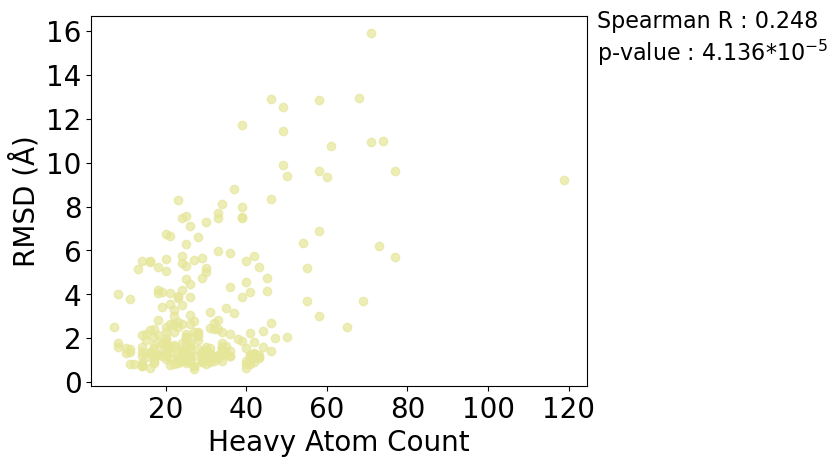

x values plot
0      18
1       5
2       3
3       3
4       6
       ..
263     9
264     4
265     7
266     2
267     7
Name: Rot_Bonds, Length: 268, dtype: int64
y values plot
0      9.891156
1      1.179264
2      6.292030
3      4.064958
4      0.759707
         ...   
263    1.538600
264    1.310540
265    4.578700
266    3.540096
267    1.966392
Name: RMSD, Length: 268, dtype: float64
Spearman R 3 formats
raw 0.015150004914626524
.3e 1.515e-02
sci. not. 1.515*$10^{-2}$


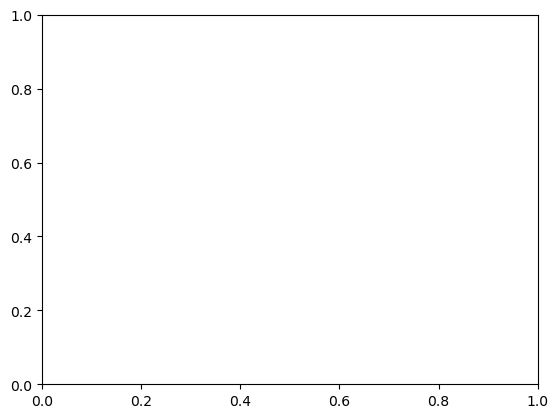

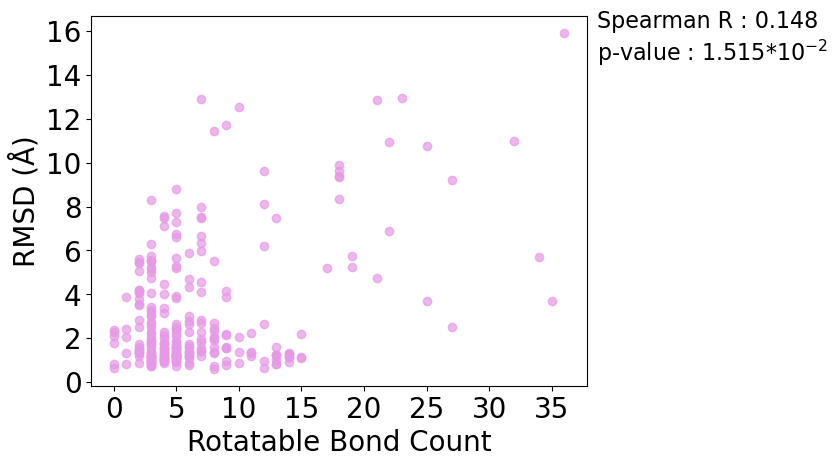

x values plot
0     -17.845891
1      -3.593731
2     -15.720450
3     -34.795880
4      -6.095395
         ...    
263    -6.767556
264   -13.731414
265    -7.040458
266   -10.402741
267   -16.339849
Name: Rg_Percent_Error, Length: 268, dtype: float64
y values plot
0      9.891156
1      1.179264
2      6.292030
3      4.064958
4      0.759707
         ...   
263    1.538600
264    1.310540
265    4.578700
266    3.540096
267    1.966392
Name: RMSD, Length: 268, dtype: float64
Spearman R 3 formats
raw 7.018432393910316e-14
.3e 7.018e-14
sci. not. 7.018*$10^{-14}$


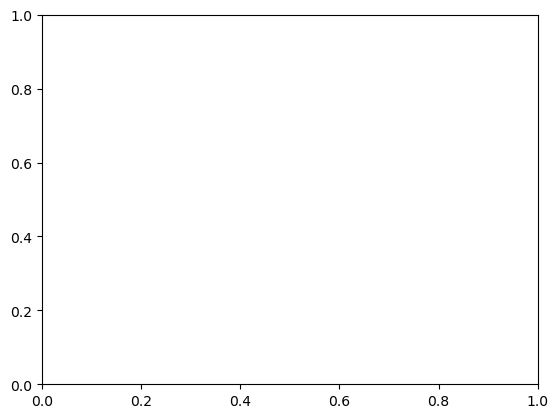

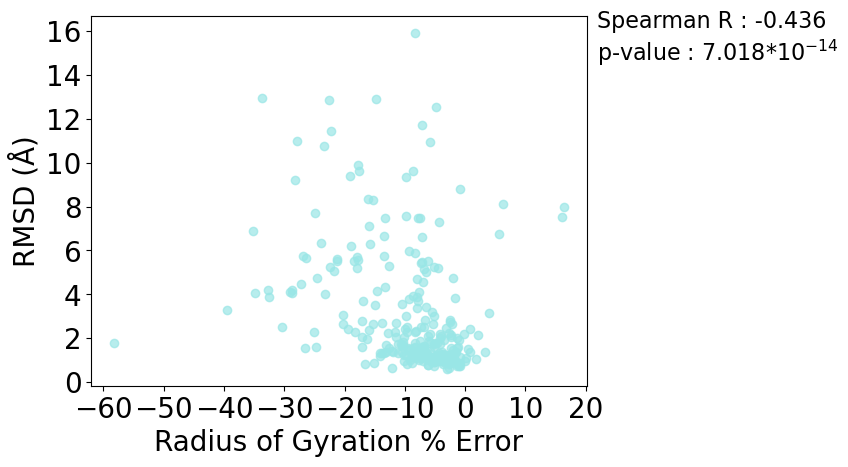

x values plot
[17.845891411116867, 3.5937306225628687, 15.720450157706923, 34.79588048869595, 6.095394744915585, 5.395804424755725, 15.152854501692957, 3.167573201804868, 27.866570598458456, 0.9554905846144957, 2.597973666156089, 7.075063536361025, 3.538883875307073, 7.954342630468081, 8.836884302238886, 7.494584498032352, 7.2052469160431345, 5.425352589237637, 0.8035402866409276, 11.186069836354282, 8.141337684326949, 33.613547171157855, 6.770545753636593, 0.8976790307122479, 8.061867897868046, 6.742503982356574, 8.258348318644423, 4.592178022692277, 8.379425101685765, 6.774912303557672, 3.998374628748801, 7.793365497719004, 13.242041771143006, 6.619413378601991, 1.3775520735837892, 5.0363446064085045, 2.3358534733077465, 14.151408833770919, 6.0396499912271295, 4.726285443111944, 1.6279369864970223, 17.93558345752178, 1.978602196147303, 22.33962739353455, 7.6911311900742225, 6.294764950285011, 7.188071781234382, 8.482827300244637, 29.116944882167612, 0.9874839799995326, 9.070558962986

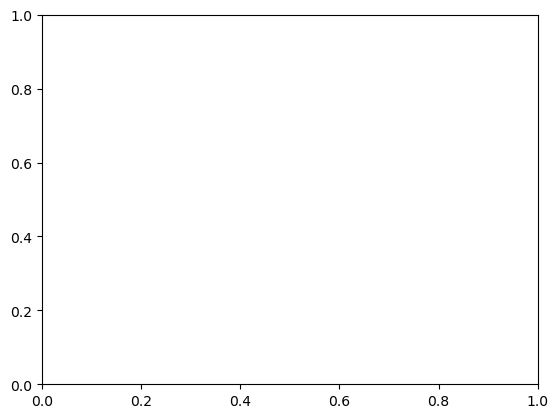

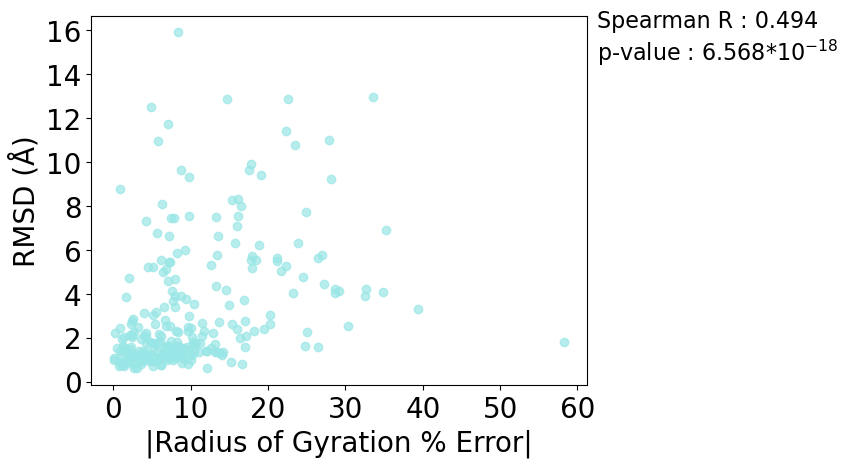

x values plot
0     -17.845891
1      -3.593731
2     -15.720450
3     -34.795880
4      -6.095395
         ...    
263    -6.767556
264   -13.731414
265    -7.040458
266   -10.402741
267   -16.339849
Name: Rg_Percent_Error, Length: 268, dtype: float64
y values plot
0      49
1      26
2      25
3      21
4      21
       ..
263    17
264    25
265    40
266    21
267    38
Name: Heavy_Atom_Count, Length: 268, dtype: int64
Spearman R 3 formats
raw 0.3267882124662017
.3e 3.268e-01
sci. not. 3.268*$10^{-1}$


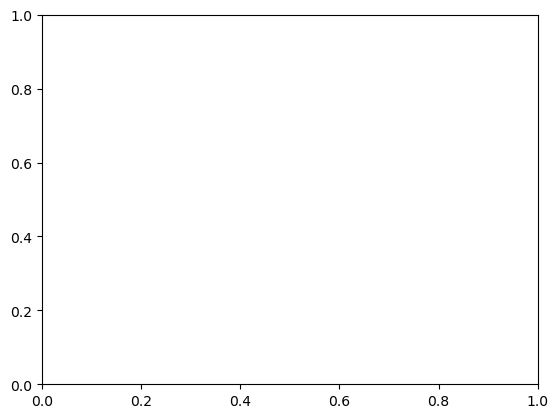

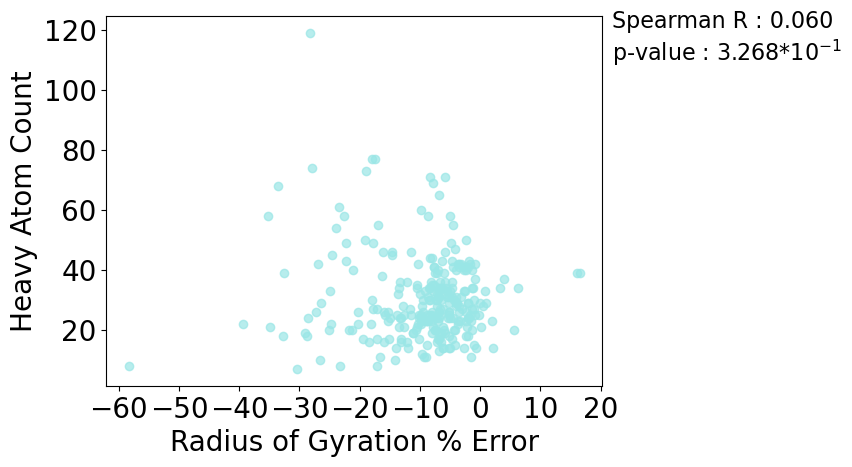

x values plot
[17.845891411116867, 3.5937306225628687, 15.720450157706923, 34.79588048869595, 6.095394744915585, 5.395804424755725, 15.152854501692957, 3.167573201804868, 27.866570598458456, 0.9554905846144957, 2.597973666156089, 7.075063536361025, 3.538883875307073, 7.954342630468081, 8.836884302238886, 7.494584498032352, 7.2052469160431345, 5.425352589237637, 0.8035402866409276, 11.186069836354282, 8.141337684326949, 33.613547171157855, 6.770545753636593, 0.8976790307122479, 8.061867897868046, 6.742503982356574, 8.258348318644423, 4.592178022692277, 8.379425101685765, 6.774912303557672, 3.998374628748801, 7.793365497719004, 13.242041771143006, 6.619413378601991, 1.3775520735837892, 5.0363446064085045, 2.3358534733077465, 14.151408833770919, 6.0396499912271295, 4.726285443111944, 1.6279369864970223, 17.93558345752178, 1.978602196147303, 22.33962739353455, 7.6911311900742225, 6.294764950285011, 7.188071781234382, 8.482827300244637, 29.116944882167612, 0.9874839799995326, 9.070558962986

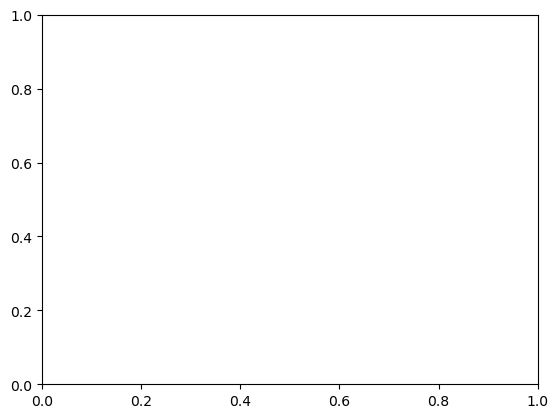

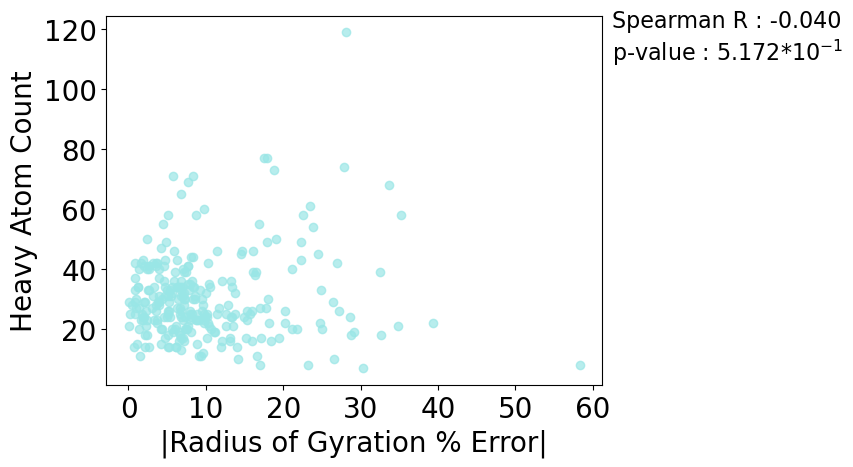

x values plot
0     -33.954766
1     -17.694465
2     -24.253292
3     -36.277097
4     -19.904159
         ...    
263   -35.242170
264   -18.118440
265   -23.721028
266   -12.853356
267   -17.449126
Name: Bond_Distance_Percent_Error_Average, Length: 268, dtype: float64
y1 values plot
0     -17.845891
1      -3.593731
2     -15.720450
3     -34.795880
4      -6.095395
         ...    
263    -6.767556
264   -13.731414
265    -7.040458
266   -10.402741
267   -16.339849
Name: Rg_Percent_Error, Length: 268, dtype: float64
y2 values plot
0      9.891156
1      1.179264
2      6.292030
3      4.064958
4      0.759707
         ...   
263    1.538600
264    1.310540
265    4.578700
266    3.540096
267    1.966392
Name: RMSD, Length: 268, dtype: float64


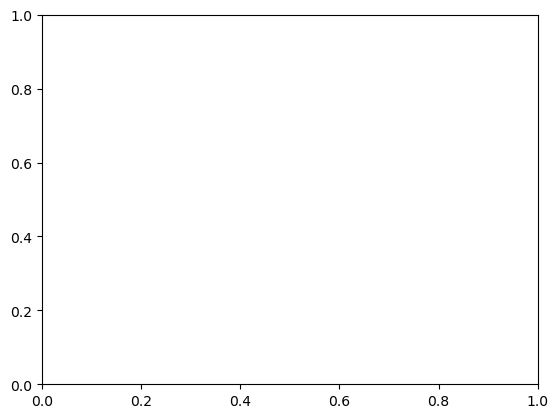

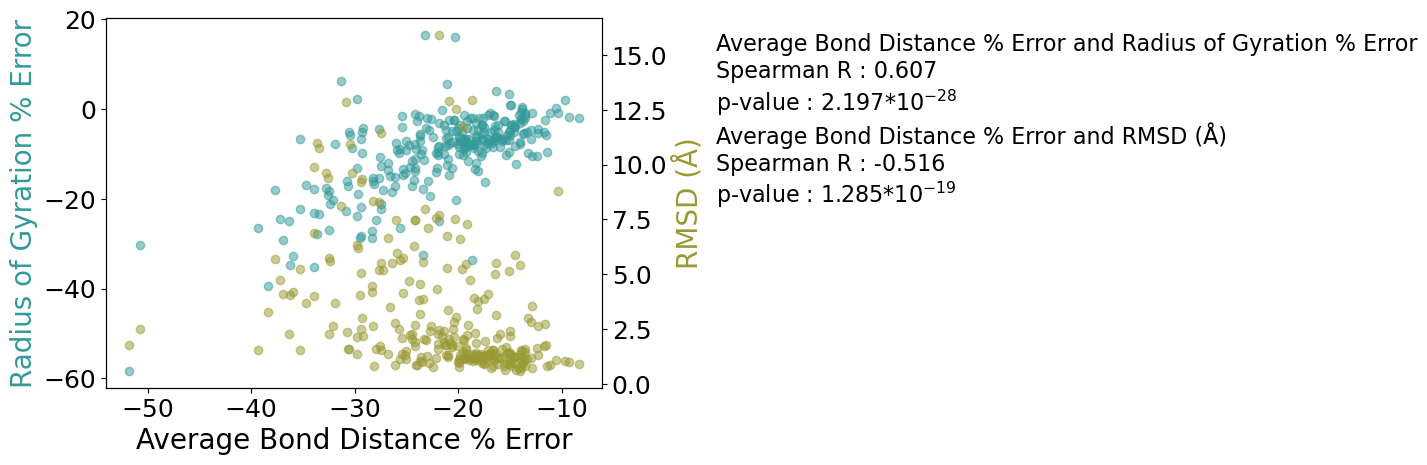

consensus max 0       24
1       80
2       74
3       68
4       20
      ... 
263      0
264    139
265    113
266     33
267    123
Name: SD_0.10_Consensus_Distance_Count, Length: 268, dtype: int64


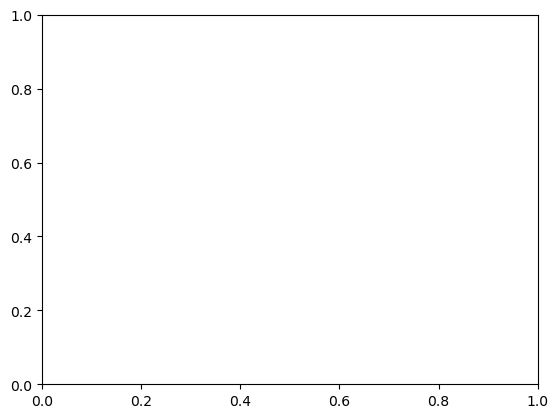

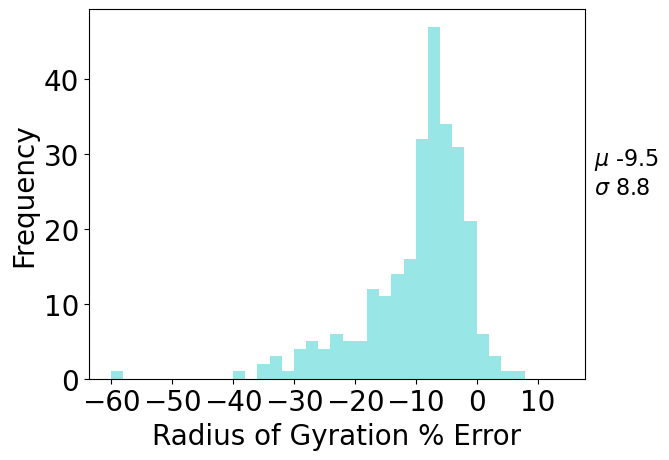

Radius of Gyration % Error has 268 entries, 255 below 0 for 95.14925373134328% below
Bond_Distance_Percent_Error_List
where 0?
(array([], dtype=int64),)


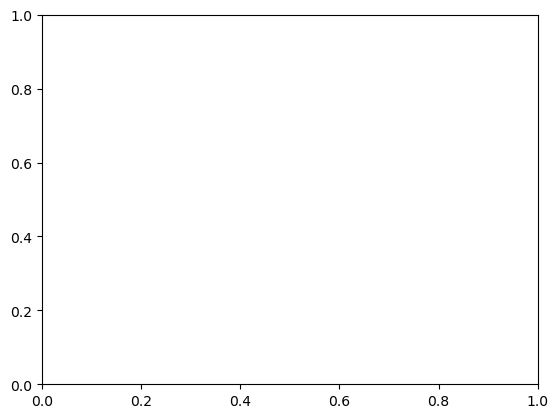

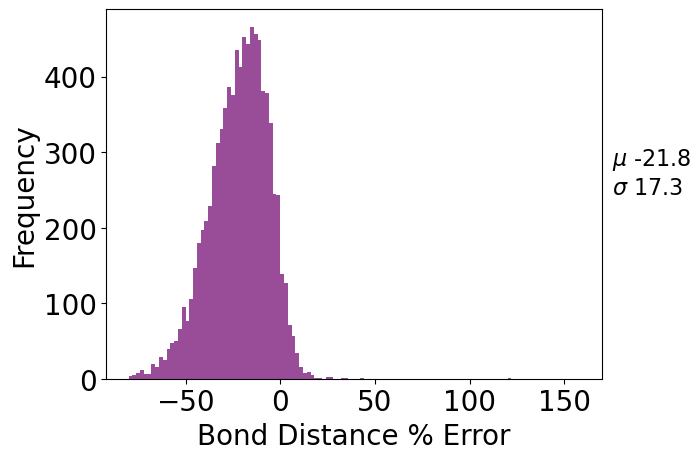

Bond Distance % Error has 8788 entries, 8313 below 0 for 94.59490213928083% below


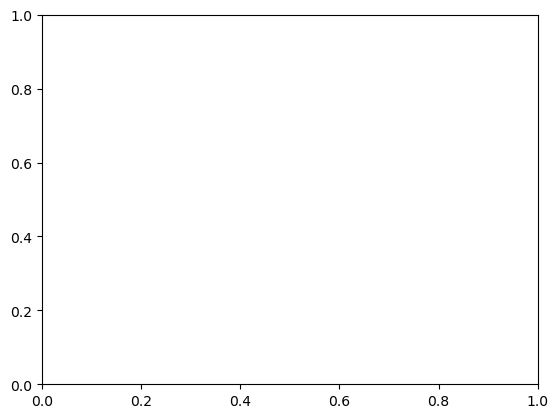

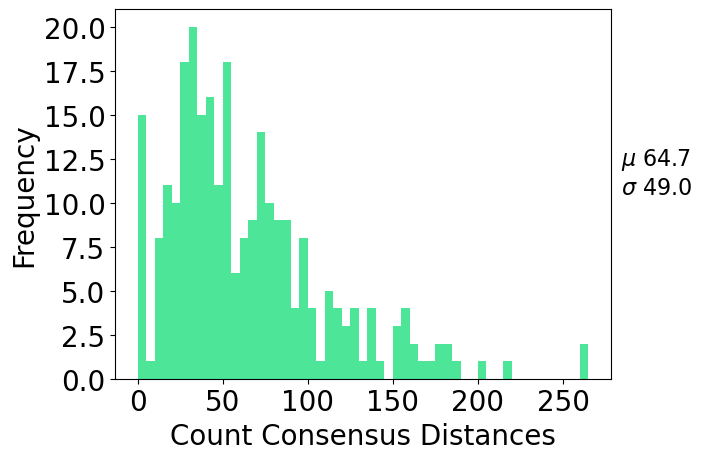

Count Consensus Distances has 268 entries, 0 below 0 for 0.0% below
All_LR_SD
where 0?
(array([], dtype=int64),)


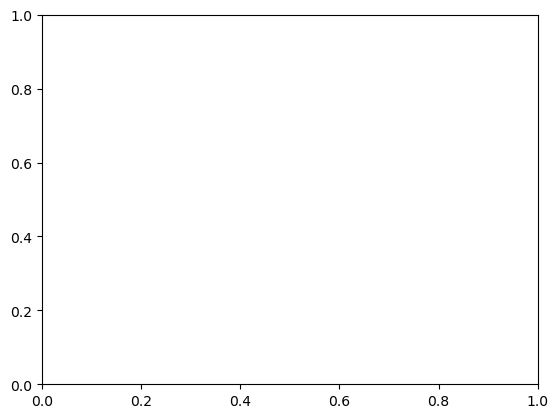

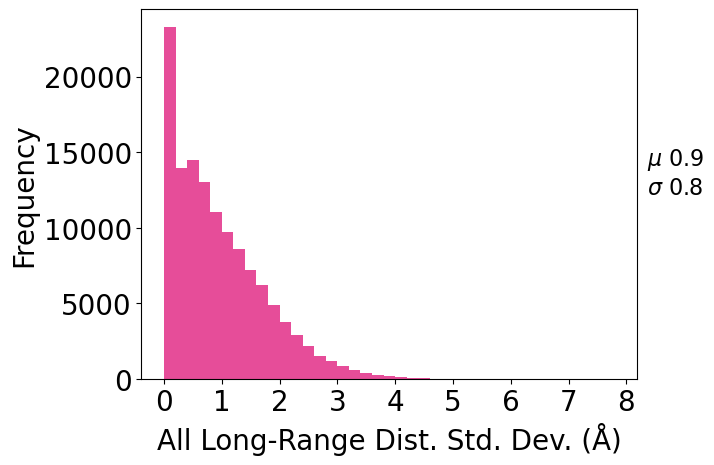

All Long-Range Dist. Std. Dev. (Å) has 126291 entries, 0 below 0 for 0.0% below


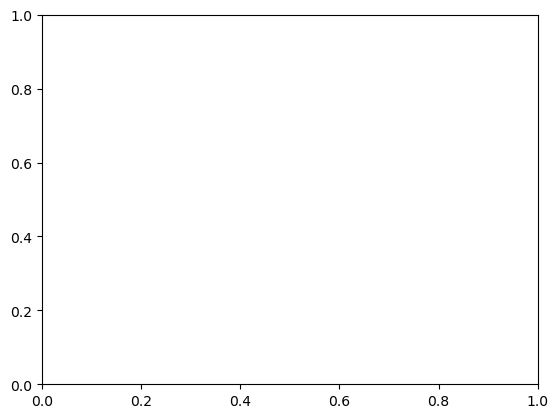

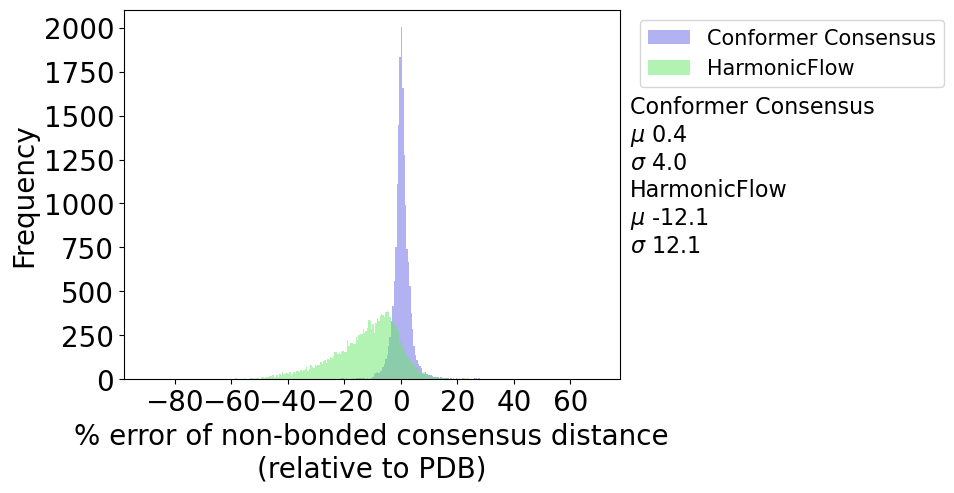

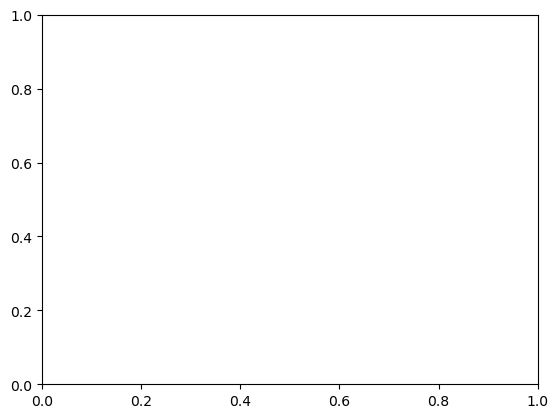

In [25]:
#2/5/24 try for a couple ligands
#This has processed PDBbind data
pdb_dir_check = "/Users/dsharon/Documents/MIT/6.8701/Project/Code/HarmonicFlow/FlowSite/data/PDBBind_processed/"

#I had parsed the _xt.pdb output and placed the 20th set of coordinates for each in a directory
hf_out_dir_check = "/Users/dsharon/Documents/MIT/6.8701/Project/Data/For_ICLR_2024_02_05/Poses_Harmonic_Prior_2024_02_05_2250/Last_xt_2024_02_05_2250"

#csv for comparison
#hfcsv = pd.read_csv("/Users/dsharon/Documents/MIT/6.8701/Project/Data/From_Hannes/HarmonicFlow/pred_0.csv")

test_list = obtain_list_from_file("/Users/dsharon/Documents/MIT/6.8701/Project/Data/For_ICLR_2024_02_05/PDB_Lists/test_pdb_ids.txt")

#Whether to sanitize
s_boolean = True

#Output directory
dir_output_run = "/Users/dsharon/Documents/MIT/6.8701/Project/Analysis/Output/240205/Run_Test_Set_Harmonic_SH_268_240205_2355_Sanitize_True_redo_p"
check_df_sd_consensus = run_analysis(pdb_dir_check, 
                                     hf_out_dir_check, 
                                     dir_output_run,
                                     test_list,
                                     s_boolean)

In [26]:
#2/5/24 try for train set too
#This has processed PDBbind data
pdb_dir_check = "/Users/dsharon/Documents/MIT/6.8701/Project/Code/HarmonicFlow/FlowSite/data/PDBBind_processed/"

#I had parsed the _xt.pdb output and placed the 20th set of coordinates for each in a directory
#hf_out_dir_check = "/Users/dsharon/Documents/MIT/6.8701/Project/Data/From_Hannes/HarmonicFlow/inference_output_last_xt"

#csv for comparison
#hfcsv = pd.read_csv("/Users/dsharon/Documents/MIT/6.8701/Project/Data/From_Hannes/HarmonicFlow/pred_0.csv")


train_set_list = obtain_list_from_file("/Users/dsharon/Documents/MIT/6.8701/Project/Data/For_ICLR_2024_02_05/PDB_Lists/train_pdb_ids.txt")

#Output directory
dir_output_run_train = "/Users/dsharon/Documents/MIT/6.8701/Project/Analysis/Output/240205/Run_Train_Set_Harmonic_SH_240206_0020_Sanitize_True"
check_df_train = run_analysis(pdb_dir_check, 
                        None, 
                        dir_output_run_train,
                        train_set_list,
                        True)

On 4kz8 index 0
On 1ajp index 1
On 3tu7 index 2
On 2qi1 index 3
On 4mvx index 4
On 3qxv index 5
On 4e35 index 6
Can't kekulize mol.  Unkekulized atoms: 16 17 18 19 20 21 22 23 24
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 16 17 18 19 20 21 22 23 24
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.
On 4dst index 7
Can't kekulize mol.  Unkekulized atoms: 2 4 5 6 7 8 9 10 11
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 2 4 5 6 7 8 9 10 11
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.
On 3i5z index 8
Can't kekulize mol.  Unkekulized atoms: 14 15 16 17 18
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 14 15 16 17 18
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.


[00:21:22] Can't kekulize mol.  Unkekulized atoms: 16 17 18 19 20 21 22 23 24
[00:21:22] Can't kekulize mol.  Unkekulized atoms: 16 17 18 19 20 21 22 23 24
[00:21:22] Can't kekulize mol.  Unkekulized atoms: 2 4 5 6 7 8 9 10 11
[00:21:22] Can't kekulize mol.  Unkekulized atoms: 2 4 5 6 7 8 9 10 11
[00:21:22] Can't kekulize mol.  Unkekulized atoms: 14 15 16 17 18
[00:21:22] Can't kekulize mol.  Unkekulized atoms: 14 15 16 17 18
[00:21:22] Can't kekulize mol.  Unkekulized atoms: 9 11 12 15 21 22 23
[00:21:22] Can't kekulize mol.  Unkekulized atoms: 9 11 12 15 21 22 23
[00:21:22] Can't kekulize mol.  Unkekulized atoms: 0 1 2 4 10 11 12 13 14
[00:21:22] Can't kekulize mol.  Unkekulized atoms: 0 1 2 4 10 11 12 13 14
[00:21:22] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 5 9 10 11
[00:21:22] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 5 9 10 11
[00:21:22] Can't kekulize mol.  Unkekulized atoms: 22 23 24 25 26 27 28 29 30
[00:21:22] Can't kekulize mol.  Unkekulized atoms: 22 23 24 

Can't kekulize mol.  Unkekulized atoms: 22 23 24 25 26 27 28 29 30
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 22 23 24 25 26 27 28 29 30
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.
On 2x8d index 63
Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 5 6 7 8
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 5 6 7 8
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.
On 1hsg index 64
On 4z0k index 65
On 4um3 index 66
On 5kdf index 67
On 3ns9 index 68
On 4wpf index 69
On 3kiv index 70
On 3t0x index 71
Can't kekulize mol.  Unkekulized atoms: 9 10 11 13 14 15 16 17 18
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 9 10 11 13 14 15 16 17 18
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead a

[00:21:22] Can't kekulize mol.  Unkekulized atoms: 26 27 28 29 30 31 32 33 34
[00:21:22] Can't kekulize mol.  Unkekulized atoms: 26 27 28 29 30 31 32 33 34
[00:21:22] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 5 7 8 9
[00:21:22] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 5 7 8 9
[00:21:23] Can't kekulize mol.  Unkekulized atoms: 14 15 16 17 18 19 20 21 22
[00:21:23] Can't kekulize mol.  Unkekulized atoms: 14 15 16 17 18 19 20 21 22
[00:21:23] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 5 9 10 11
[00:21:23] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 5 9 10 11
[00:21:23] Can't kekulize mol.  Unkekulized atoms: 13 14 15 16 17 18 19 20 21
[00:21:23] Can't kekulize mol.  Unkekulized atoms: 13 14 15 16 17 18 19 20 21
[00:21:23] Can't kekulize mol.  Unkekulized atoms: 9 10 11 12 18
[00:21:23] Can't kekulize mol.  Unkekulized atoms: 9 10 11 12 18
[00:21:23] Can't kekulize mol.  Unkekulized atoms: 1 2 3 9 10
[00:21:23] Can't kekulize mol.  Unkekulized atoms: 1 2 3 9 1

Can't kekulize mol.  Unkekulized atoms: 0 2 3 8 17
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 0 2 3 8 17
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.
On 1nz7 index 132
On 5ttv index 133
Can't kekulize mol.  Unkekulized atoms: 0 2 6 14 15 16 17 18 19
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 0 2 6 14 15 16 17 18 19
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.
On 6aqs index 134
Can't kekulize mol.  Unkekulized atoms: 0 4 5 8 9 10
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 0 4 5 8 9 10
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.
On 5cap index 135
On 4qzw index 136
On 4glw index 137
On 5eh0 index 138
On 5w8j index 139
On 5j8i index 140
On 1utt in

[00:21:23] Can't kekulize mol.  Unkekulized atoms: 1 2 6 9 14 20 21 26 28
[00:21:23] Can't kekulize mol.  Unkekulized atoms: 1 2 6 9 14 20 21 26 28
[00:21:23] Can't kekulize mol.  Unkekulized atoms: 3 4 9 10 11 12 14 15 16
[00:21:23] Can't kekulize mol.  Unkekulized atoms: 3 4 9 10 11 12 14 15 16
[00:21:23] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 18 19 20 21 22
[00:21:23] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 18 19 20 21 22
[00:21:23] Can't kekulize mol.  Unkekulized atoms: 8 9 10 11 12 13 14 15 17
[00:21:23] Can't kekulize mol.  Unkekulized atoms: 8 9 10 11 12 13 14 15 17
[00:21:23] Can't kekulize mol.  Unkekulized atoms: 2 3 5 6 8 9 10 11 12
[00:21:23] Can't kekulize mol.  Unkekulized atoms: 2 3 5 6 8 9 10 11 12
[00:21:23] Can't kekulize mol.  Unkekulized atoms: 12 14 15 16 17 18 19 20 21
[00:21:23] Can't kekulize mol.  Unkekulized atoms: 12 14 15 16 17 18 19 20 21
[00:21:23] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 23 24 25 26 27
[00:21:23] Can't kekulize mo

On 6eya index 208
Can't kekulize mol.  Unkekulized atoms: 0 1 2 4 5 6 19 22 23
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 0 1 2 4 5 6 19 22 23
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.
On 2z3z index 209
Explicit valence for atom # 17 C, 5, is greater than permitted
RDKit was unable to read the molecule.
Explicit valence for atom # 17 C, 5, is greater than permitted
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.
On 5t31 index 210
Can't kekulize mol.  Unkekulized atoms: 6 13 14 15 16
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 6 13 14 15 16
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.
On 3m53 index 211
On 4clb index 212
On 3hq5 index 213
On 3lik index 214
On 3n5e index 215
On 3ch9 

[00:21:23] Can't kekulize mol.  Unkekulized atoms: 0 2 3 4 5 14 15 16 17
[00:21:23] Can't kekulize mol.  Unkekulized atoms: 0 2 3 4 5 14 15 16 17
[00:21:23] Can't kekulize mol.  Unkekulized atoms: 6 7 8 9 22
[00:21:23] Can't kekulize mol.  Unkekulized atoms: 6 7 8 9 22
[00:21:23] Can't kekulize mol.  Unkekulized atoms: 9 10 11 12 13
[00:21:23] Can't kekulize mol.  Unkekulized atoms: 9 10 11 12 13
[00:21:23] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 5 6 8 10
[00:21:23] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 5 6 8 10
[00:21:23] Can't kekulize mol.  Unkekulized atoms: 0 2 9 10 11
[00:21:23] Can't kekulize mol.  Unkekulized atoms: 0 2 9 10 11
[00:21:23] Can't kekulize mol.  Unkekulized atoms: 18 19 20 21 22 23 24 25 26
[00:21:23] Can't kekulize mol.  Unkekulized atoms: 18 19 20 21 22 23 24 25 26
[00:21:23] Can't kekulize mol.  Unkekulized atoms: 0 4 5 6 7 13 14 15 16
[00:21:23] Can't kekulize mol.  Unkekulized atoms: 0 4 5 6 7 13 14 15 16
[00:21:23] Can't kekulize mol.  

On 4a4e index 275
On 4ybi index 276
On 4ju6 index 277
On 2gh7 index 278
On 3d7h index 279
On 2anm index 280
On 4de2 index 281
Can't kekulize mol.  Unkekulized atoms: 19 20 21 22 23
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 19 20 21 22 23
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.
On 1ym1 index 282
On 4wlb index 283
On 3gcp index 284
Can't kekulize mol.  Unkekulized atoms: 15 16 17 18 19
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 15 16 17 18 19
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.
On 6c0s index 285
On 1kqb index 286
On 3l3m index 287
Can't kekulize mol.  Unkekulized atoms: 1 3 5 8 10 11 13 20 21
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 1 3 5 8 10 11 13 20 21
RDKit was unable to read the molecule.
Using the .sdf

[00:21:23] Can't kekulize mol.  Unkekulized atoms: 3 4 5 6 7 8 9 22 23
[00:21:23] Can't kekulize mol.  Unkekulized atoms: 3 4 5 6 7 8 9 22 23
[00:21:23] Can't kekulize mol.  Unkekulized atoms: 5 6 7 17 18
[00:21:23] Can't kekulize mol.  Unkekulized atoms: 5 6 7 17 18
[00:21:23] Can't kekulize mol.  Unkekulized atoms: 17 18 19 20 22 23 24 25 26
[00:21:23] Can't kekulize mol.  Unkekulized atoms: 17 18 19 20 22 23 24 25 26
[00:21:23] Can't kekulize mol.  Unkekulized atoms: 2 3 4 5 6
[00:21:23] Can't kekulize mol.  Unkekulized atoms: 2 3 4 5 6
[00:21:23] Can't kekulize mol.  Unkekulized atoms: 0 1 4 7 9 10 11 12 13
[00:21:23] Can't kekulize mol.  Unkekulized atoms: 0 1 4 7 9 10 11 12 13
[00:21:23] Can't kekulize mol.  Unkekulized atoms: 1 2 4 6 22
[00:21:23] Can't kekulize mol.  Unkekulized atoms: 1 2 4 6 22
[00:21:23] Can't kekulize mol.  Unkekulized atoms: 2 3 4 6 21
[00:21:23] Can't kekulize mol.  Unkekulized atoms: 2 3 4 6 21
[00:21:23] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4

On 6dh0 index 344
On 5gn5 index 345
On 2oei index 346
On 5jur index 347
Can't kekulize mol.  Unkekulized atoms: 17 18 19 20 22 23 24 25 26
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 17 18 19 20 22 23 24 25 26
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.
On 2aie index 348
On 3nlb index 349
Can't kekulize mol.  Unkekulized atoms: 2 3 4 5 6
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 2 3 4 5 6
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.
On 2jk9 index 350
On 3p9m index 351
On 5lud index 352
On 5fue index 353
On 2q89 index 354
On 2x8e index 355
Can't kekulize mol.  Unkekulized atoms: 0 1 4 7 9 10 11 12 13
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 0 1 4 7 9 10 11 12 13
RDKit was unable to read the molecule.
Using the .sdf file 

[00:21:23] Can't kekulize mol.  Unkekulized atoms: 7 8 10 11 14 18 20 21 22
[00:21:23] Can't kekulize mol.  Unkekulized atoms: 7 8 10 11 14 18 20 21 22
[00:21:23] Can't kekulize mol.  Unkekulized atoms: 22 23 24 25 26 27 28 29 30
[00:21:23] Can't kekulize mol.  Unkekulized atoms: 22 23 24 25 26 27 28 29 30
[00:21:23] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 5 7 11 12
[00:21:23] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 5 7 11 12
[00:21:23] Can't kekulize mol.  Unkekulized atoms: 19 20 21 22 23
[00:21:23] Can't kekulize mol.  Unkekulized atoms: 19 20 21 22 23
[00:21:23] Can't kekulize mol.  Unkekulized atoms: 8 9 10 11 12
[00:21:23] Can't kekulize mol.  Unkekulized atoms: 8 9 10 11 12
[00:21:23] Can't kekulize mol.  Unkekulized atoms: 1 12 13 14 15
[00:21:23] Can't kekulize mol.  Unkekulized atoms: 1 12 13 14 15
[00:21:23] Can't kekulize mol.  Unkekulized atoms: 0 8 14 15 16
[00:21:23] Can't kekulize mol.  Unkekulized atoms: 0 8 14 15 16
[00:21:23] Can't kekulize mol.  

On 1yw8 index 415
On 4lys index 416
On 5ee8 index 417
On 5k05 index 418
Can't kekulize mol.  Unkekulized atoms: 1 12 13 14 15
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 1 12 13 14 15
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.
On 5nk3 index 419
On 1sgu index 420
On 1gvx index 421
On 1xpz index 422
On 3rt8 index 423
On 3pxz index 424
On 2q5k index 425
On 1uwh index 426
On 3jya index 427
On 5zeq index 428
On 4ijl index 429
On 4asy index 430
On 4rj4 index 431
Can't kekulize mol.  Unkekulized atoms: 0 8 14 15 16
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 0 8 14 15 16
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.
On 3d4q index 432
On 4ual index 433
Can't kekulize mol.  Unkekulized atoms: 15 16 17 18 19
RDKit was unable to read the molecule.
Can't kekulize mol.  U

[00:21:24] Can't kekulize mol.  Unkekulized atoms: 12 13 14 15 16 17 18 19 20
[00:21:24] Can't kekulize mol.  Unkekulized atoms: 12 13 14 15 16 17 18 19 20
[00:21:24] Can't kekulize mol.  Unkekulized atoms: 24 25 26 27 28
[00:21:24] Can't kekulize mol.  Unkekulized atoms: 24 25 26 27 28
[00:21:24] Can't kekulize mol.  Unkekulized atoms: 10 11 12 13 19 20 21 22 23
[00:21:24] Can't kekulize mol.  Unkekulized atoms: 10 11 12 13 19 20 21 22 23
[00:21:24] Can't kekulize mol.  Unkekulized atoms: 7 8 11 12 23 25 26 27 28
[00:21:24] Can't kekulize mol.  Unkekulized atoms: 7 8 11 12 23 25 26 27 28
[00:21:24] Can't kekulize mol.  Unkekulized atoms: 10 11 12 13 14 15 16 17 18
[00:21:24] Can't kekulize mol.  Unkekulized atoms: 10 11 12 13 14 15 16 17 18
[00:21:24] Can't kekulize mol.  Unkekulized atoms: 24 25 26 27 28 29 30 31 32
[00:21:24] Can't kekulize mol.  Unkekulized atoms: 24 25 26 27 28 29 30 31 32
[00:21:24] Can't kekulize mol.  Unkekulized atoms: 14 15 16 17 18
[00:21:24] Can't kekulize 

On 5xpl index 493
On 3vw6 index 494
On 2r3y index 495
Can't kekulize mol.  Unkekulized atoms: 24 25 26 27 28 29 30 31 32
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 24 25 26 27 28 29 30 31 32
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.
On 4u6x index 496
PDB 4u6x Ligand [H]OC(=O)C([H])([H])C([H])([H])[C@@]([H])(C(=O)N([H])[C@]([H])(C(=O)N([H])[C@]([H])(C(=O)N([H])[C@]([H])(C(=O)O[H])[C@@]([H])(C([H])([H])[H])C([H])([H])C([H])([H])[H])C([H])([H])c1c([H])c([H])c([H])c([H])c1[H])C([H])([H])c1c([H])c([H])c(O[H])c([H])c1[H])N([H])C(=O)[C@]([H])(C([H])([H])C([H])([H])C([H])([H])C([H])([H])[N+]([H])([H])[H])[N+]([H])([H])[H].[H]OC(=O)C([H])([H])[C@@]([H])(C(=O)N([H])[C@]([H])(C([H])=O)C([H])([H])[H])N([H])C(=O)[C@@]([H])(N([H])C(=O)[C@@]([H])(N([H])C(=O)[C@]([H])(C([H])([H])[H])[N+]([H])([H])[H])C([H])([H])C([H])(C([H])([H])[H])C([H])([H])[H])C([H])([H])C([H])([H])C(=O)N([H])[H] 

[00:21:24] Can't kekulize mol.  Unkekulized atoms: 12 13 14 15 16
[00:21:24] Can't kekulize mol.  Unkekulized atoms: 12 13 14 15 16
[00:21:24] Can't kekulize mol.  Unkekulized atoms: 7 8 9 41 42
[00:21:24] Can't kekulize mol.  Unkekulized atoms: 7 8 9 41 42
[00:21:24] Can't kekulize mol.  Unkekulized atoms: 14 15 16 17 18
[00:21:24] Can't kekulize mol.  Unkekulized atoms: 14 15 16 17 18
[00:21:24] Can't kekulize mol.  Unkekulized atoms: 19 20 21 22 23
[00:21:24] Can't kekulize mol.  Unkekulized atoms: 19 20 21 22 23
[00:21:24] Can't kekulize mol.  Unkekulized atoms: 9 10 11 15 18 19
[00:21:24] Can't kekulize mol.  Unkekulized atoms: 9 10 11 15 18 19
[00:21:24] Can't kekulize mol.  Unkekulized atoms: 2 3 4 5 6
[00:21:24] Can't kekulize mol.  Unkekulized atoms: 2 3 4 5 6
[00:21:24] Can't kekulize mol.  Unkekulized atoms: 15 16 17 18 19 20 21 22 23
[00:21:24] Can't kekulize mol.  Unkekulized atoms: 15 16 17 18 19 20 21 22 23
[00:21:24] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 5 6 1

On 3fnu index 567
On 2vuk index 568
On 6f5l index 569
On 5lhg index 570
On 2wyg index 571
On 4y29 index 572
On 1okl index 573
On 5alh index 574
On 1qon index 575
On 3jq9 index 576
Can't kekulize mol.  Unkekulized atoms: 9 10 11 15 18 19
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 9 10 11 15 18 19
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.
On 1c88 index 577
On 5y7z index 578
On 2m0u index 579
On 6g07 index 580
On 2xc0 index 581
On 2nn7 index 582
On 3qn7 index 583
On 4k3p index 584
On 1fsw index 585
On 6got index 586
On 3cyw index 587
On 4uzd index 588
Can't kekulize mol.  Unkekulized atoms: 2 3 4 5 6
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 2 3 4 5 6
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.
On 1swn index 589
On 4q83 index 590
On 3hvh index 591
On 2jiu 

[00:21:24] Can't kekulize mol.  Unkekulized atoms: 3 4 8 9 10
[00:21:24] Can't kekulize mol.  Unkekulized atoms: 3 4 8 9 10
[00:21:24] Can't kekulize mol.  Unkekulized atoms: 8 9 10 11 12 13 14 16 17
[00:21:24] Can't kekulize mol.  Unkekulized atoms: 8 9 10 11 12 13 14 16 17
[00:21:24] Can't kekulize mol.  Unkekulized atoms: 14 15 16 17 18 19 20 21 22
[00:21:24] Can't kekulize mol.  Unkekulized atoms: 14 15 16 17 18 19 20 21 22
[00:21:24] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 13 14 15 16
[00:21:24] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 13 14 15 16
[00:21:24] Can't kekulize mol.  Unkekulized atoms: 2 3 4 5 6 7 8 9 10 11 12 13 14
[00:21:24] Can't kekulize mol.  Unkekulized atoms: 2 3 4 5 6 7 8 9 10 11 12 13 14
[00:21:24] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 10
[00:21:24] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 10
[00:21:24] Can't kekulize mol.  Unkekulized atoms: 9 10 11 23 24 25 26 27 28
[00:21:24] Can't kekulize mol.  Unkekulized atoms: 9 10 1

On 2nnk index 632
On 3ft4 index 633
On 2nta index 634
On 5djr index 635
Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 13 14 15 16
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 13 14 15 16
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.
On 2qoa index 636
On 1t69 index 637
On 1dzm index 638
On 4rvl index 639
Can't kekulize mol.  Unkekulized atoms: 2 3 4 5 6 7 8 9 10 11 12 13 14
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 2 3 4 5 6 7 8 9 10 11 12 13 14
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.
On 3az8 index 640
On 1qj1 index 641
On 5f00 index 642
On 5q11 index 643
On 1rth index 644
On 4s1g index 645
On 5mql index 646
On 5jzy index 647
On 1il3 index 648
Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 10
RDKit was unable to read the molecule.
Can't keku

[00:21:24] Can't kekulize mol.  Unkekulized atoms: 7 8 9 10 11 12 13 14 15
[00:21:24] Can't kekulize mol.  Unkekulized atoms: 7 8 9 10 11 12 13 14 15
[00:21:24] Can't kekulize mol.  Unkekulized atoms: 47 48 49 50 51 52 53 54 55
[00:21:24] Can't kekulize mol.  Unkekulized atoms: 47 48 49 50 51 52 53 54 55
[00:21:24] Can't kekulize mol.  Unkekulized atoms: 16 17 18 19 20 21 22 23 24
[00:21:24] Can't kekulize mol.  Unkekulized atoms: 16 17 18 19 20 21 22 23 24
[00:21:24] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4
[00:21:24] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4
[00:21:24] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 17 18 20 21 22
[00:21:24] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 17 18 20 21 22
[00:21:24] Can't kekulize mol.  Unkekulized atoms: 8 9 10 11 12
[00:21:24] Can't kekulize mol.  Unkekulized atoms: 8 9 10 11 12
[00:21:24] Can't kekulize mol.  Unkekulized atoms: 21 22 23 24 25
[00:21:24] Can't kekulize mol.  Unkekulized atoms: 21 22 23 24 25
[00:21:2

On 1mx1 index 696
On 4ffs index 697
Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 17 18 20 21 22
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 17 18 20 21 22
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.
On 5q1c index 698
On 3vfb index 699
On 5j6n index 700
On 2ito index 701
On 5eq0 index 702
On 3zya index 703
On 5v88 index 704
On 1gu1 index 705
On 3uev index 706
On 2o4p index 707
On 5l3f index 708
On 6g9b index 709
On 4q1a index 710
On 3qar index 711
Can't kekulize mol.  Unkekulized atoms: 8 9 10 11 12
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 8 9 10 11 12
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.
On 6apz index 712
On 5j6s index 713
On 6e9a index 714
On 2jkk index 715
On 4a4o index 716
On 4oho index 717
On 4jxv index 718
On 5dgj index 719
On 4j81 

[00:21:24] Can't kekulize mol.  Unkekulized atoms: 0 1 17 18 19 20 21 22 23
[00:21:24] Can't kekulize mol.  Unkekulized atoms: 0 1 17 18 19 20 21 22 23
[00:21:24] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4
[00:21:24] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4
[00:21:24] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 6 10 11 12 13 14
[00:21:24] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 6 10 11 12 13 14
[00:21:24] Can't kekulize mol.  Unkekulized atoms: 0 1 10 11 17 18 19 20 21
[00:21:24] Can't kekulize mol.  Unkekulized atoms: 0 1 10 11 17 18 19 20 21
[00:21:24] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 5 9 10 11
[00:21:25] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 5 9 10 11
[00:21:25] Can't kekulize mol.  Unkekulized atoms: 2 5 6 7 21
[00:21:25] Can't kekulize mol.  Unkekulized atoms: 2 5 6 7 21
[00:21:25] Can't kekulize mol.  Unkekulized atoms: 6 7 8 14 15 16 17 18 19
[00:21:25] Can't kekulize mol.  Unkekulized atoms: 6 7 8 14 15 16 17 18 19
[00:21

On 3kb7 index 759
On 5ioy index 760
On 4puj index 761
Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 6 10 11 12 13 14
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 6 10 11 12 13 14
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.
On 3lxe index 762
On 4hzm index 763
On 3pxy index 764
On 4z2l index 765
On 6bbv index 766
Can't kekulize mol.  Unkekulized atoms: 0 1 10 11 17 18 19 20 21
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 0 1 10 11 17 18 19 20 21
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.
On 4m84 index 767
On 4cst index 768
On 5hm3 index 769
On 5hvs index 770
On 3nnw index 771
On 5g4m index 772
On 4p6g index 773
On 1o3d index 774
Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 5 9 10 11
RDKit was unable to read the molecule.
Can't kekulize mol.  Unke

[00:21:25] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 5 9 10 11
[00:21:25] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 5 9 10 11
[00:21:25] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 5 6 7 8
[00:21:25] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 5 6 7 8
[00:21:25] Can't kekulize mol.  Unkekulized atoms: 0 1 2 4 5 6 7 8 9 10 14
[00:21:25] Can't kekulize mol.  Unkekulized atoms: 0 1 2 4 5 6 7 8 9 10 14
[00:21:25] Can't kekulize mol.  Unkekulized atoms: 9 10 11 12 13 14 15 16 17
[00:21:25] Can't kekulize mol.  Unkekulized atoms: 9 10 11 12 13 14 15 16 17
[00:21:25] Can't kekulize mol.  Unkekulized atoms: 4 5 6 17 18 19 20 21 22
[00:21:25] Can't kekulize mol.  Unkekulized atoms: 4 5 6 17 18 19 20 21 22
[00:21:25] Can't kekulize mol.  Unkekulized atoms: 12 13 14 15 18 19 20 21 22
[00:21:25] Can't kekulize mol.  Unkekulized atoms: 12 13 14 15 18 19 20 21 22
[00:21:25] Can't kekulize mol.  Unkekulized atoms: 9 10 11 12 13
[00:21:25] Can't kekulize mol.  Unkekulized a

Can't kekulize mol.  Unkekulized atoms: 9 10 11 12 13 14 15 16 17
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 9 10 11 12 13 14 15 16 17
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.
On 4xu0 index 876
On 4ob2 index 877
Explicit valence for atom # 3 C, 5, is greater than permitted
RDKit was unable to read the molecule.
Explicit valence for atom # 3 C, 5, is greater than permitted
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.
On 4jk5 index 878
On 3s3r index 879
On 2wmw index 880
Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 5 6 7 8 9
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 5 6 7 8 9
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.
On 2vwl index 881
On 2h4g index 882
On 4kwg in

[00:21:25] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 5 6 7 8 9
[00:21:25] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 5 6 7 8 9
[00:21:25] Can't kekulize mol.  Unkekulized atoms: 5 6 7 8 17
[00:21:25] Can't kekulize mol.  Unkekulized atoms: 5 6 7 8 17
[00:21:25] Can't kekulize mol.  Unkekulized atoms: 5 6 7 8 9 10 12 13 14 15 16 17 18
[00:21:25] Can't kekulize mol.  Unkekulized atoms: 5 6 7 8 9 10 12 13 14 15 16 17 18
[00:21:25] Can't kekulize mol.  Unkekulized atoms: 9 10 11 12 13 14 15 16 25
[00:21:25] Can't kekulize mol.  Unkekulized atoms: 9 10 11 12 13 14 15 16 25
[00:21:25] Can't kekulize mol.  Unkekulized atoms: 8 9 10 11 12
[00:21:25] Can't kekulize mol.  Unkekulized atoms: 8 9 10 11 12
[00:21:25] Can't kekulize mol.  Unkekulized atoms: 9 10 11 13 14 15 16 17 18
[00:21:25] Can't kekulize mol.  Unkekulized atoms: 9 10 11 13 14 15 16 17 18
[00:21:25] Explicit valence for atom # 10 O, 3, is greater than permitted
[00:21:25] Explicit valence for atom # 10 O, 3, is greater

On 4ach index 936
On 5v8p index 937
Can't kekulize mol.  Unkekulized atoms: 5 6 7 8 9
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 5 6 7 8 9
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.
On 4wr7 index 938
On 4mq1 index 939
On 5nap index 940
On 5t6g index 941
On 3h0q index 942
On 1c1v index 943
Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 5 7 11 12
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 5 7 11 12
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.
On 5afm index 944
Can't kekulize mol.  Unkekulized atoms: 7 8 9 11 13
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 7 8 9 11 13
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.
On 1uyk index 945
On 3

[00:21:25] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 5 7 11 12
[00:21:25] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 5 7 11 12
[00:21:25] Can't kekulize mol.  Unkekulized atoms: 7 8 9 11 13
[00:21:25] Can't kekulize mol.  Unkekulized atoms: 7 8 9 11 13
[00:21:25] Can't kekulize mol.  Unkekulized atoms: 23 24 25 26 27
[00:21:25] Can't kekulize mol.  Unkekulized atoms: 23 24 25 26 27
[00:21:25] Can't kekulize mol.  Unkekulized atoms: 14 15 16 17 18 19 20 21 22
[00:21:25] Can't kekulize mol.  Unkekulized atoms: 14 15 16 17 18 19 20 21 22
[00:21:25] Can't kekulize mol.  Unkekulized atoms: 6 7 10 11 12
[00:21:25] Can't kekulize mol.  Unkekulized atoms: 6 7 10 11 12
[00:21:25] Can't kekulize mol.  Unkekulized atoms: 1 4 9 10 11
[00:21:25] Can't kekulize mol.  Unkekulized atoms: 1 4 9 10 11
[00:21:25] Can't kekulize mol.  Unkekulized atoms: 29 30 31 32 33 34 35 36 37
[00:21:25] Can't kekulize mol.  Unkekulized atoms: 29 30 31 32 33 34 35 36 37
[00:21:25] Can't kekulize mol.  Un

On 2lsv index 990
On 1j36 index 991
On 4crf index 992
On 2xk4 index 993
On 1utl index 994
On 1h3b index 995
On 6g5j index 996
On 5owh index 997
On 4x7k index 998
On 1rv1 index 999
On 1w8m index 1000
On 4btk index 1001
On 4n1b index 1002
On 4oc3 index 1003
On 4l19 index 1004
On 4yl0 index 1005
Can't kekulize mol.  Unkekulized atoms: 4 5 8 9 10 11 12 13 14 15 16 17 18 24 25 26 27
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 4 5 8 9 10 11 12 13 14 15 16 17 18 24 25 26 27
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.
On 1rrw index 1006
On 5nut index 1007
On 5txy index 1008
On 4zy4 index 1009
Can't kekulize mol.  Unkekulized atoms: 3 15 16 17 18
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 3 15 16 17 18
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.
On 5ivn index 1010
C

[00:21:25] Can't kekulize mol.  Unkekulized atoms: 4 5 8 9 10 11 12 13 14 15 16 17 18 24 25 26 27
[00:21:25] Can't kekulize mol.  Unkekulized atoms: 4 5 8 9 10 11 12 13 14 15 16 17 18 24 25 26 27
[00:21:25] Can't kekulize mol.  Unkekulized atoms: 3 15 16 17 18
[00:21:25] Can't kekulize mol.  Unkekulized atoms: 3 15 16 17 18
[00:21:25] Can't kekulize mol.  Unkekulized atoms: 66 67 68 69 70
[00:21:25] Can't kekulize mol.  Unkekulized atoms: 66 67 68 69 70
[00:21:25] Can't kekulize mol.  Unkekulized atoms: 3 8 9 10 11
[00:21:25] Can't kekulize mol.  Unkekulized atoms: 3 8 9 10 11
[00:21:25] Can't kekulize mol.  Unkekulized atoms: 19 20 21 22 23 24 25 26 27
[00:21:25] Can't kekulize mol.  Unkekulized atoms: 19 20 21 22 23 24 25 26 27
[00:21:25] Can't kekulize mol.  Unkekulized atoms: 5 6 7 8 19 20 21 22 23
[00:21:25] Can't kekulize mol.  Unkekulized atoms: 5 6 7 8 19 20 21 22 23
[00:21:25] Can't kekulize mol.  Unkekulized atoms: 5 6 7 8 9
[00:21:25] Can't kekulize mol.  Unkekulized atoms: 

Can't kekulize mol.  Unkekulized atoms: 0 1 14 15 17 18 19 20 21
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 0 1 14 15 17 18 19 20 21
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.
On 5o1d index 1056
On 5n84 index 1057
On 5gwz index 1058
On 1vjy index 1059
Can't kekulize mol.  Unkekulized atoms: 7 8 9 10 11
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 7 8 9 10 11
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.
On 4e3i index 1060
On 1swk index 1061
On 4bio index 1062
On 4cxx index 1063
On 2v2q index 1064
Can't kekulize mol.  Unkekulized atoms: 21 22 23 24 25 26 27 28 29
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 21 22 23 24 25 26 27 28 29
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file inste

[00:21:26] Can't kekulize mol.  Unkekulized atoms: 0 1 18 19 20
[00:21:26] Can't kekulize mol.  Unkekulized atoms: 0 1 18 19 20
[00:21:26] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 5 6 7 8
[00:21:26] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 5 6 7 8
[00:21:26] Can't kekulize mol.  Unkekulized atoms: 0 1 6 8 11 12 15 16 18
[00:21:26] Can't kekulize mol.  Unkekulized atoms: 0 1 6 8 11 12 15 16 18
[00:21:26] Can't kekulize mol.  Unkekulized atoms: 12 13 14 15 16
[00:21:26] Can't kekulize mol.  Unkekulized atoms: 12 13 14 15 16
[00:21:26] Can't kekulize mol.  Unkekulized atoms: 3 4 5 6 7 8 9 10 11
[00:21:26] Can't kekulize mol.  Unkekulized atoms: 3 4 5 6 7 8 9 10 11
[00:21:26] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 5 9 10 11
[00:21:26] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 5 9 10 11
[00:21:26] Can't kekulize mol.  Unkekulized atoms: 11 12 13 14 17 18 19 20 21
[00:21:26] Can't kekulize mol.  Unkekulized atoms: 11 12 13 14 17 18 19 20 21
[00:21:26] Can

On 2bal index 1127
On 4kqp index 1128
On 3kjd index 1129
Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 8 9 10 11 12
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 8 9 10 11 12
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.
On 3sl8 index 1130
On 4e7r index 1131
On 3ndm index 1132
On 1ssq index 1133
On 2w8y index 1134
On 4pnw index 1135
On 2g00 index 1136
On 5ll5 index 1137
On 3owj index 1138
Can't kekulize mol.  Unkekulized atoms: 0 2 3 4 5 6 7 8 9 10 12 13 14
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 0 2 3 4 5 6 7 8 9 10 12 13 14
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.
On 3ft5 index 1139
On 3ttz index 1140
Can't kekulize mol.  Unkekulized atoms: 2 4 5 6 7
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 2 4 5 6 7
RDKit

[00:21:26] Can't kekulize mol.  Unkekulized atoms: 2 4 5 6 7
[00:21:26] Can't kekulize mol.  Unkekulized atoms: 2 4 5 6 7
[00:21:26] Can't kekulize mol.  Unkekulized atoms: 6 7 8 9 10 11 12 13 14
[00:21:26] Can't kekulize mol.  Unkekulized atoms: 6 7 8 9 10 11 12 13 14
[00:21:26] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 5 6 8 9
[00:21:26] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 5 6 8 9
[00:21:26] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 9
[00:21:26] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 9
[00:21:26] Can't kekulize mol.  Unkekulized atoms: 3 4 7 9 10 11 15 26 27
[00:21:26] Can't kekulize mol.  Unkekulized atoms: 3 4 7 9 10 11 15 26 27
[00:21:26] Can't kekulize mol.  Unkekulized atoms: 0 1 11 12 13
[00:21:26] Can't kekulize mol.  Unkekulized atoms: 0 1 11 12 13
[00:21:26] Can't kekulize mol.  Unkekulized atoms: 0
[00:21:26] Can't kekulize mol.  Unkekulized atoms: 0
[00:21:26] Can't kekulize mol.  Unkekulized atoms: 49 50 51 52 53
[00:21:26] Can't kekul

On 3f69 index 1172
On 2zjv index 1173
On 5ceo index 1174
On 5lh8 index 1175
On 4xg9 index 1176
On 2vth index 1177
On 3udq index 1178
On 4qls index 1179
On 3f6g index 1180
On 3cl2 index 1181
On 4e1n index 1182
On 4luo index 1183
On 1uyg index 1184
Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 6 7 8 10 11
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 6 7 8 10 11
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.
On 3zps index 1185
On 2bmg index 1186
On 2nwn index 1187
Can't kekulize mol.  Unkekulized atoms: 17 18 19 20 21 22 23 24 25
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 17 18 19 20 21 22 23 24 25
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.
On 3qcs index 1188
Can't kekulize mol.  Unkekulized atoms: 0 1 2 4 5 6 9 17 18
RDKit was unable to read the molecu

[00:21:26] Can't kekulize mol.  Unkekulized atoms: 17 18 19 20 21 22 23 24 25
[00:21:26] Can't kekulize mol.  Unkekulized atoms: 17 18 19 20 21 22 23 24 25
[00:21:26] Can't kekulize mol.  Unkekulized atoms: 0 1 2 4 5 6 9 17 18
[00:21:26] Can't kekulize mol.  Unkekulized atoms: 0 1 2 4 5 6 9 17 18
[00:21:26] Can't kekulize mol.  Unkekulized atoms: 1 2 3 13 14
[00:21:26] Can't kekulize mol.  Unkekulized atoms: 1 2 3 13 14
[00:21:26] Can't kekulize mol.  Unkekulized atoms: 6 8 9 10 19 20 21 22 24
[00:21:26] Can't kekulize mol.  Unkekulized atoms: 6 8 9 10 19 20 21 22 24
[00:21:26] Can't kekulize mol.  Unkekulized atoms: 49 50 51 52 53
[00:21:26] Can't kekulize mol.  Unkekulized atoms: 49 50 51 52 53
[00:21:26] Can't kekulize mol.  Unkekulized atoms: 18 19 20 21 22 23 24 25 26
[00:21:26] Can't kekulize mol.  Unkekulized atoms: 18 19 20 21 22 23 24 25 26
[00:21:26] Can't kekulize mol.  Unkekulized atoms: 6 7 11 16 17
[00:21:26] Can't kekulize mol.  Unkekulized atoms: 6 7 11 16 17
[00:21:26]

On 3io7 index 1223
On 6f3b index 1224
On 6g9k index 1225
On 5mwa index 1226
On 1wqv index 1227
On 4lh3 index 1228
On 4hzt index 1229
On 5o7i index 1230
Can't kekulize mol.  Unkekulized atoms: 6 7 11 16 17
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 6 7 11 16 17
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.
On 3sc1 index 1231
On 4aa7 index 1232
On 2rjs index 1233
On 3rlp index 1234
On 6e7j index 1235
On 1h8y index 1236
On 5ejv index 1237
On 3v6s index 1238
On 3qcx index 1239
Can't kekulize mol.  Unkekulized atoms: 0 1 2 4 5 6 9 18 19
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 0 1 2 4 5 6 9 18 19
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.
On 4egk index 1240
On 1tmb index 1241
On 1z71 index 1242
Can't kekulize mol.  Unkekulized atoms: 0 1 3 4 5
RDKit was unable

[00:21:26] Can't kekulize mol.  Unkekulized atoms: 0 1 3 4 5
[00:21:26] Can't kekulize mol.  Unkekulized atoms: 0 1 3 4 5
[00:21:26] Can't kekulize mol.  Unkekulized atoms: 9 10 11 12 13 14 15 16 17
[00:21:26] Can't kekulize mol.  Unkekulized atoms: 9 10 11 12 13 14 15 16 17
[00:21:26] Can't kekulize mol.  Unkekulized atoms: 3 4 5 6 7
[00:21:26] Can't kekulize mol.  Unkekulized atoms: 3 4 5 6 7
[00:21:26] Can't kekulize mol.  Unkekulized atoms: 0 10 11 12 13 14 15 16 17 21 22 23 24
[00:21:26] Can't kekulize mol.  Unkekulized atoms: 0 10 11 12 13 14 15 16 17 21 22 23 24
[00:21:26] Can't kekulize mol.  Unkekulized atoms: 5 6 7 8 9
[00:21:26] Can't kekulize mol.  Unkekulized atoms: 5 6 7 8 9
[00:21:26] Can't kekulize mol.  Unkekulized atoms: 4 5 6 8 23 24 25 26 27 28 29 35 36 37 38 39 40
[00:21:26] Can't kekulize mol.  Unkekulized atoms: 4 5 6 8 23 24 25 26 27 28 29 35 36 37 38 39 40
[00:21:26] Can't kekulize mol.  Unkekulized atoms: 14 15 16 17 18 19 20 21 34
[00:21:26] Can't kekulize mo

On 4avj index 1285
On 1b3g index 1286
On 5wb6 index 1287
Can't kekulize mol.  Unkekulized atoms: 4 5 6 8 23 24 25 26 27 28 29 35 36 37 38 39 40
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 4 5 6 8 23 24 25 26 27 28 29 35 36 37 38 39 40
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.
On 5j9l index 1288
Can't kekulize mol.  Unkekulized atoms: 14 15 16 17 18 19 20 21 34
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 14 15 16 17 18 19 20 21 34
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.
On 6h9b index 1289
On 5th7 index 1290
On 1dhj index 1291
On 1g3m index 1292
On 3n3g index 1293
On 4aof index 1294
On 4w4z index 1295
Can't kekulize mol.  Unkekulized atoms: 76 77 78 79 80 81 82 83 84
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 76 77 78 

[00:21:26] Can't kekulize mol.  Unkekulized atoms: 6 10 17 24 26
[00:21:26] Can't kekulize mol.  Unkekulized atoms: 6 10 17 24 26
[00:21:26] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 5 6 14 15
[00:21:26] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 5 6 14 15
[00:21:26] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 5 6 7 8
[00:21:26] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 5 6 7 8
[00:21:26] Can't kekulize mol.  Unkekulized atoms: 2 3 4 17 18
[00:21:26] Can't kekulize mol.  Unkekulized atoms: 2 3 4 17 18
[00:21:26] Can't kekulize mol.  Unkekulized atoms: 14 15 16 17 18 19 20 21 22
[00:21:26] Can't kekulize mol.  Unkekulized atoms: 14 15 16 17 18 19 20 21 22
[00:21:26] Explicit valence for atom # 1 C, 6, is greater than permitted
[00:21:26] Explicit valence for atom # 1 C, 6, is greater than permitted
[00:21:26] Can't kekulize mol.  Unkekulized atoms: 11 12 13 14 15 16 17 18 19
[00:21:26] Can't kekulize mol.  Unkekulized atoms: 11 12 13 14 15 16 17 18 19
[00:21

Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 5 6 7 9
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 5 6 7 9
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.
On 5ne1 index 1336
On 4f3i index 1337
On 1upk index 1338
Can't kekulize mol.  Unkekulized atoms: 13 14 15 16 17 18 19 20 21
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 13 14 15 16 17 18 19 20 21
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.
On 5mmg index 1339
On 1dif index 1340
On 5nkh index 1341
On 4ruy index 1342
On 5f04 index 1343
On 3rw9 index 1344
On 6fsy index 1345
On 4mmm index 1346
On 5owt index 1347
On 3e2m index 1348
On 3qcl index 1349
On 3fu0 index 1350
On 5if4 index 1351
On 3uyr index 1352
Can't kekulize mol.  Unkekulized atoms: 42 43 44 45 46 47 48 49 50
RDKit was unable to read the mol

[00:21:27] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 5 6 14 15 16
[00:21:27] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 5 6 14 15 16
[00:21:27] Can't kekulize mol.  Unkekulized atoms: 5 6 7 8 9
[00:21:27] Can't kekulize mol.  Unkekulized atoms: 5 6 7 8 9
[00:21:27] Can't kekulize mol.  Unkekulized atoms: 16
[00:21:27] Can't kekulize mol.  Unkekulized atoms: 16
[00:21:27] Can't kekulize mol.  Unkekulized atoms: 16 17 18 24 25
[00:21:27] Can't kekulize mol.  Unkekulized atoms: 16 17 18 24 25
[00:21:27] Can't kekulize mol.  Unkekulized atoms: 13 14 15 16 17
[00:21:27] Can't kekulize mol.  Unkekulized atoms: 13 14 15 16 17
[00:21:27] Can't kekulize mol.  Unkekulized atoms: 9 10 11 12 13
[00:21:27] Can't kekulize mol.  Unkekulized atoms: 9 10 11 12 13
[00:21:27] Can't kekulize mol.  Unkekulized atoms: 16 17 18 19 20
[00:21:27] Can't kekulize mol.  Unkekulized atoms: 16 17 18 19 20
[00:21:27] Can't kekulize mol.  Unkekulized atoms: 17 18 19 20 21 22 23 24 25
[00:21:27] Can't kekul

On 2vw2 index 1399
On 5wxf index 1400
Can't kekulize mol.  Unkekulized atoms: 17 18 19 20 21 22 23 24 25
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 17 18 19 20 21 22 23 24 25
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.
On 1hvh index 1401
On 4pyx index 1402
On 3owb index 1403
Can't kekulize mol.  Unkekulized atoms: 8 9 15 16 17
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 8 9 15 16 17
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.
On 4ibf index 1404
On 3dog index 1405
On 2qtu index 1406
On 4q3u index 1407
On 6eol index 1408
On 3kgq index 1409
On 2yg2 index 1410
On 5e7n index 1411
On 4rwj index 1412
Can't kekulize mol.  Unkekulized atoms: 10 12 21 22 23
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 10 12 21 22 23
RDKit was unable 

[00:21:27] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 18 19 20 22 23
[00:21:27] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 18 19 20 22 23
[00:21:27] Can't kekulize mol.  Unkekulized atoms: 0 2 6 18 19 20 21 22 23
[00:21:27] Can't kekulize mol.  Unkekulized atoms: 0 2 6 18 19 20 21 22 23
[00:21:27] 6db4_ligand: Warning - no explicit hydrogens in mol2 file but needed for formal charge estimation.
[00:21:27] 6db4_ligand: Warning - no explicit hydrogens in mol2 file but needed for formal charge estimation.
[00:21:27] Can't kekulize mol.  Unkekulized atoms: 4 12 14 15 16
[00:21:27] Can't kekulize mol.  Unkekulized atoms: 4 12 14 15 16
[00:21:27] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 5 6 7 8 9
[00:21:27] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 5 6 7 8 9
[00:21:27] Can't kekulize mol.  Unkekulized atoms: 6 7 22 24 25
[00:21:27] Can't kekulize mol.  Unkekulized atoms: 6 7 22 24 25
[00:21:27] Can't kekulize mol.  Unkekulized atoms: 10 11 12 13 14
[00:21:27] Can't kek

On 2jh0 index 1463
On 2va7 index 1464
On 3fas index 1465
On 3k3b index 1466
On 3ds1 index 1467
On 3o1d index 1468
Can't kekulize mol.  Unkekulized atoms: 10 11 12 13 14
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 10 11 12 13 14
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.
On 4rx8 index 1469
Can't kekulize mol.  Unkekulized atoms: 3 4 9 10 11 12 18 19 25
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 3 4 9 10 11 12 18 19 25
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.
On 2xow index 1470
On 4uub index 1471
On 6dnp index 1472
On 5fah index 1473
On 3a73 index 1474
On 1exw index 1475
On 3t07 index 1476
Can't kekulize mol.  Unkekulized atoms: 5 9 11 13 15 19 21 23 25
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 5 9 11 13 15 19 21 23 25

[00:21:27] Can't kekulize mol.  Unkekulized atoms: 2 6 7 10 11 12
[00:21:27] Can't kekulize mol.  Unkekulized atoms: 2 6 7 10 11 12
[00:21:27] Can't kekulize mol.  Unkekulized atoms: 0 1 14 15 17 18 19 20 21
[00:21:27] Can't kekulize mol.  Unkekulized atoms: 0 1 14 15 17 18 19 20 21
[00:21:27] Can't kekulize mol.  Unkekulized atoms: 8 9 10 11 12 13 14 15 16
[00:21:27] Can't kekulize mol.  Unkekulized atoms: 8 9 10 11 12 13 14 15 16
[00:21:27] Can't kekulize mol.  Unkekulized atoms: 26 27 28 29 30 35 36 37 38
[00:21:27] Can't kekulize mol.  Unkekulized atoms: 26 27 28 29 30 35 36 37 38
[00:21:27] Can't kekulize mol.  Unkekulized atoms: 16 17 18 19 20 21 22 23 25
[00:21:27] Can't kekulize mol.  Unkekulized atoms: 16 17 18 19 20 21 22 23 25
[00:21:27] Can't kekulize mol.  Unkekulized atoms: 29 30 31 32 33
[00:21:27] Can't kekulize mol.  Unkekulized atoms: 29 30 31 32 33
[00:21:27] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 5 6 7 8
[00:21:27] Can't kekulize mol.  Unkekulized atoms: 

On 4bqh index 1527
On 4nym index 1528
Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 5 6 7 8
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 5 6 7 8
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.
On 5hbe index 1529
On 4uzh index 1530
Can't kekulize mol.  Unkekulized atoms: 15 16 17 19 20
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 15 16 17 19 20
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.
On 2xmy index 1531
On 3nq3 index 1532
On 5mos index 1533
On 1i7g index 1534
On 4meq index 1535
On 4hw7 index 1536
Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 5 6 7 8
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 5 6 7 8
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and 

[00:21:27] Explicit valence for atom # 9 O, 3, is greater than permitted
[00:21:27] Explicit valence for atom # 9 O, 3, is greater than permitted
[00:21:27] Can't kekulize mol.  Unkekulized atoms: 3 4 7 8 9 10 11 12 13
[00:21:27] Can't kekulize mol.  Unkekulized atoms: 3 4 7 8 9 10 11 12 13
[00:21:27] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 5 6 7 8
[00:21:27] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 5 6 7 8
[00:21:27] Can't kekulize mol.  Unkekulized atoms: 4 5 8 9 10 11 12
[00:21:27] Can't kekulize mol.  Unkekulized atoms: 4 5 8 9 10 11 12
[00:21:27] Can't kekulize mol.  Unkekulized atoms: 3 4 8 16 17
[00:21:27] Can't kekulize mol.  Unkekulized atoms: 3 4 8 16 17
[00:21:27] Can't kekulize mol.  Unkekulized atoms: 63 64 65 66 67 68 69 70 71
[00:21:27] Can't kekulize mol.  Unkekulized atoms: 63 64 65 66 67 68 69 70 71
[00:21:27] Can't kekulize mol.  Unkekulized atoms: 2 3 6 7 12 13 15 17 18
[00:21:27] Can't kekulize mol.  Unkekulized atoms: 2 3 6 7 12 13 15 17 18
[00:

On 5g4o index 1595
On 3eoc index 1596
On 4ehv index 1597
On 5a5v index 1598
On 4d88 index 1599
On 4k5z index 1600
On 3bla index 1601
On 4q1d index 1602
On 4b3u index 1603
On 2c1p index 1604
On 2ai7 index 1605
On 5alj index 1606
On 4hup index 1607
Can't kekulize mol.  Unkekulized atoms: 4 5 8 9 10 11 12
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 4 5 8 9 10 11 12
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.
On 5ka9 index 1608
On 1nny index 1609
On 5f88 index 1610
On 4ze6 index 1611
On 5t37 index 1612
Can't kekulize mol.  Unkekulized atoms: 3 4 8 16 17
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 3 4 8 16 17
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.
On 4yxo index 1613
On 6fqo index 1614
On 6ela index 1615
On 2r5d index 1616
Can't kekulize mol.  Unkekulized ato

[00:21:27] Can't kekulize mol.  Unkekulized atoms: 9 10 11 12 13
[00:21:27] Can't kekulize mol.  Unkekulized atoms: 9 10 11 12 13
[00:21:28] Can't kekulize mol.  Unkekulized atoms: 0 1 12 13 14 16 17 18 20
[00:21:28] Can't kekulize mol.  Unkekulized atoms: 0 1 12 13 14 16 17 18 20
[00:21:28] Can't kekulize mol.  Unkekulized atoms: 0 1 4 5 6 7 9 13 16 17
[00:21:28] Can't kekulize mol.  Unkekulized atoms: 0 1 4 5 6 7 9 13 16 17
[00:21:28] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 5 6 7 8
[00:21:28] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 5 6 7 8
[00:21:28] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 5 6 7 30
[00:21:28] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 5 6 7 30
[00:21:28] Can't kekulize mol.  Unkekulized atoms: 6 7 8 9 10 12 13 14 15
[00:21:28] Can't kekulize mol.  Unkekulized atoms: 6 7 8 9 10 12 13 14 15
[00:21:28] Can't kekulize mol.  Unkekulized atoms: 1 7 8 9 10 11 12 13 14
[00:21:28] Can't kekulize mol.  Unkekulized atoms: 1 7 8 9 10 11 12 13

On 3eou index 1648
Can't kekulize mol.  Unkekulized atoms: 0 1 4 5 6 7 9 13 16 17
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 0 1 4 5 6 7 9 13 16 17
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.
On 3ax5 index 1649
On 2w16 index 1650
On 5iv4 index 1651
On 5umx index 1652
On 5fbn index 1653
On 3i7c index 1654
On 4x8u index 1655
Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 5 6 7 8
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 5 6 7 8
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.
On 3gvb index 1656
On 2yz3 index 1657
On 4c73 index 1658
On 4myq index 1659
On 1nl6 index 1660
On 6ay3 index 1661
Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 5 6 7 30
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 5 6 7 30
RDKit w

[00:21:28] Can't kekulize mol.  Unkekulized atoms: 13 14 15 16 17
[00:21:28] Can't kekulize mol.  Unkekulized atoms: 13 14 15 16 17
[00:21:28] Can't kekulize mol.  Unkekulized atoms: 7 8 9 10 14
[00:21:28] Can't kekulize mol.  Unkekulized atoms: 7 8 9 10 14
[00:21:28] Can't kekulize mol.  Unkekulized atoms: 38 39 40 41 42 43 44 45 46
[00:21:28] Can't kekulize mol.  Unkekulized atoms: 38 39 40 41 42 43 44 45 46
[00:21:28] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 5 6 7 8
[00:21:28] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 5 6 7 8
[00:21:28] Can't kekulize mol.  Unkekulized atoms: 3 4 5 6 8 10 11 12 13
[00:21:28] Can't kekulize mol.  Unkekulized atoms: 3 4 5 6 8 10 11 12 13
[00:21:28] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 5 6 7 8
[00:21:28] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 5 6 7 8
[00:21:28] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 5 6 7 8
[00:21:28] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 5 6 7 8
[00:21:28] Can't kekulize 

On 2pk5 index 1703
On 1zd2 index 1704
On 4rlk index 1705
On 5dqc index 1706
On 3adt index 1707
Can't kekulize mol.  Unkekulized atoms: 3 4 5 6 8 10 11 12 13
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 3 4 5 6 8 10 11 12 13
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.
On 1g48 index 1708
On 3ccc index 1709
On 1h08 index 1710
On 2zas index 1711
On 6f3i index 1712
On 1y3x index 1713
On 5e8z index 1714
On 4afe index 1715
On 1heg index 1716
On 4avg index 1717
On 5mmp index 1718
On 5zah index 1719
On 3owd index 1720
On 2yj2 index 1721
On 5clm index 1722
On 2zfp index 1723
On 6eux index 1724
Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 5 6 7 8
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 5 6 7 8
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.
On 4ryg index 

[00:21:28] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 5 9 10 11
[00:21:28] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 5 9 10 11
[00:21:28] Can't kekulize mol.  Unkekulized atoms: 10 11 12 20 21
[00:21:28] Can't kekulize mol.  Unkekulized atoms: 10 11 12 20 21
[00:21:28] Can't kekulize mol.  Unkekulized atoms: 0 1 2 5 6 7 8 9 10
[00:21:28] Can't kekulize mol.  Unkekulized atoms: 0 1 2 5 6 7 8 9 10
[00:21:28] Can't kekulize mol.  Unkekulized atoms: 27 28 30 31 32
[00:21:28] Can't kekulize mol.  Unkekulized atoms: 27 28 30 31 32
[00:21:28] Can't kekulize mol.  Unkekulized atoms: 0 1 10 12 15
[00:21:28] Can't kekulize mol.  Unkekulized atoms: 0 1 10 12 15
[00:21:28] Can't kekulize mol.  Unkekulized atoms: 73 74 75 76 77
[00:21:28] Can't kekulize mol.  Unkekulized atoms: 73 74 75 76 77
[00:21:28] Explicit valence for atom # 16 B, 4, is greater than permitted
[00:21:28] Explicit valence for atom # 16 B, 4, is greater than permitted
[00:21:28] Can't kekulize mol.  Unkekulized at

On 4y8d index 1774
On 5lrj index 1775
On 4c1g index 1776
On 2r9w index 1777
On 3u8w index 1778
On 6cb5 index 1779
Can't kekulize mol.  Unkekulized atoms: 10 11 12 20 21
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 10 11 12 20 21
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.
On 2o5k index 1780
Can't kekulize mol.  Unkekulized atoms: 0 1 2 5 6 7 8 9 10
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 0 1 2 5 6 7 8 9 10
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.
On 3rak index 1781
On 2xxt index 1782
On 4cix index 1783
On 4dko index 1784
On 3oxc index 1785
On 2r3n index 1786
On 2qi7 index 1787
On 5wlo index 1788
On 5e7r index 1789
On 5ijr index 1790
On 4muk index 1791
On 5yg2 index 1792
Can't kekulize mol.  Unkekulized atoms: 27 28 30 31 32
RDKit was unable to read the

[00:21:28] Can't kekulize mol.  Unkekulized atoms: 0 1 2 4 5 6 21 24 25
[00:21:28] Can't kekulize mol.  Unkekulized atoms: 0 1 2 4 5 6 21 24 25
[00:21:28] Can't kekulize mol.  Unkekulized atoms: 11 15 16 17 18 19 20 21 22
[00:21:28] Can't kekulize mol.  Unkekulized atoms: 11 15 16 17 18 19 20 21 22
[00:21:28] Can't kekulize mol.  Unkekulized atoms: 82 83 84 85 86
[00:21:28] Can't kekulize mol.  Unkekulized atoms: 82 83 84 85 86
[00:21:28] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 5 6 7 8
[00:21:28] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 5 6 7 8
[00:21:28] Can't kekulize mol.  Unkekulized atoms: 3 5 21 22 23
[00:21:28] Can't kekulize mol.  Unkekulized atoms: 3 5 21 22 23
[00:21:28] Can't kekulize mol.  Unkekulized atoms: 2 3 4 5 10
[00:21:28] Can't kekulize mol.  Unkekulized atoms: 2 3 4 5 10
[00:21:28] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 5 6 7 8
[00:21:28] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 5 6 7 8
[00:21:28] Can't kekulize mol.  Unkekuli

Can't kekulize mol.  Unkekulized atoms: 11 15 16 17 18 19 20 21 22
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 11 15 16 17 18 19 20 21 22
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.
On 3r1v index 1847
On 3ip5 index 1848
On 4f20 index 1849
On 1xap index 1850
On 5n8b index 1851
Can't kekulize mol.  Unkekulized atoms: 82 83 84 85 86
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 82 83 84 85 86
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.
On 1i48 index 1852
On 3kdd index 1853
On 4nyj index 1854
Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 5 6 7 8
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 5 6 7 8
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use th

[00:21:28] Can't kekulize mol.  Unkekulized atoms: 0 1 2 11 12 13 14 15 16
[00:21:28] Can't kekulize mol.  Unkekulized atoms: 0 1 2 11 12 13 14 15 16
[00:21:28] Can't kekulize mol.  Unkekulized atoms: 2 6 7 17 18 19 22 23 24 25
[00:21:28] Can't kekulize mol.  Unkekulized atoms: 2 6 7 17 18 19 22 23 24 25
[00:21:28] Can't kekulize mol.  Unkekulized atoms: 55 56 57 58 59 60 61 62 63
[00:21:28] Can't kekulize mol.  Unkekulized atoms: 55 56 57 58 59 60 61 62 63
[00:21:28] Can't kekulize mol.  Unkekulized atoms: 9 10 11 12 18
[00:21:28] Can't kekulize mol.  Unkekulized atoms: 9 10 11 12 18
[00:21:28] Can't kekulize mol.  Unkekulized atoms: 20 21 22 23 24 25 26 27 28
[00:21:28] Can't kekulize mol.  Unkekulized atoms: 20 21 22 23 24 25 26 27 28
[00:21:28] Can't kekulize mol.  Unkekulized atoms: 34 35 36 37 38
[00:21:28] Can't kekulize mol.  Unkekulized atoms: 34 35 36 37 38
[00:21:28] Can't kekulize mol.  Unkekulized atoms: 27 28 29 30 31 32 33 34 35
[00:21:28] Can't kekulize mol.  Unkekulize

Can't kekulize mol.  Unkekulized atoms: 2 6 7 17 18 19 22 23 24 25
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 2 6 7 17 18 19 22 23 24 25
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.
On 3lzu index 1907
On 2eh8 index 1908
Can't kekulize mol.  Unkekulized atoms: 55 56 57 58 59 60 61 62 63
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 55 56 57 58 59 60 61 62 63
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.
On 3w2o index 1909
On 4a4w index 1910
On 2ff2 index 1911
Can't kekulize mol.  Unkekulized atoms: 9 10 11 12 18
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 9 10 11 12 18
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.
On 3wzk index 1912
On 4cr9 index 1913

[00:21:29] Can't kekulize mol.  Unkekulized atoms: 5 6 7 8 9 10 11 12 13
[00:21:29] Can't kekulize mol.  Unkekulized atoms: 5 6 7 8 9 10 11 12 13
[00:21:29] Can't kekulize mol.  Unkekulized atoms: 0 1 2 4 5 6 13 14 15 16 17 18 23 24 25 26 27
[00:21:29] Can't kekulize mol.  Unkekulized atoms: 0 1 2 4 5 6 13 14 15 16 17 18 23 24 25 26 27
[00:21:29] Can't kekulize mol.  Unkekulized atoms: 11 12 13 14 15
[00:21:29] Can't kekulize mol.  Unkekulized atoms: 11 12 13 14 15
[00:21:29] Can't kekulize mol.  Unkekulized atoms: 0 1 2 5 6 13 14 18 20
[00:21:29] Can't kekulize mol.  Unkekulized atoms: 0 1 2 5 6 13 14 18 20
[00:21:29] Can't kekulize mol.  Unkekulized atoms: 12 13 14 15 16
[00:21:29] Can't kekulize mol.  Unkekulized atoms: 12 13 14 15 16


On 4fny index 1952
On 3sx9 index 1953
On 5ih5 index 1954
On 2wu6 index 1955
On 4q2k index 1956
Can't kekulize mol.  Unkekulized atoms: 0 1 2 4 5 6 13 14 15 16 17 18 23 24 25 26 27
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 0 1 2 4 5 6 13 14 15 16 17 18 23 24 25 26 27
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.
On 5n1x index 1957
On 5lrq index 1958
On 5fb7 index 1959
On 4qwl index 1960
On 3rxb index 1961
On 4wy1 index 1962
On 3uph index 1963
On 2o7n index 1964
On 4c71 index 1965
On 4frs index 1966
On 3k27 index 1967
On 5auz index 1968
On 3l5c index 1969
On 6duh index 1970
On 2w6p index 1971
On 2q8i index 1972
On 5mby index 1973
On 4cwq index 1974
On 1kl3 index 1975
Can't kekulize mol.  Unkekulized atoms: 11 12 13 14 15
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 11 12 13 14 15
RDKit was unable to read the molecule.
Using the .sdf file fa

[00:21:29] Can't kekulize mol.  Unkekulized atoms: 16 17 18 19 20 21 22 23 24
[00:21:29] Can't kekulize mol.  Unkekulized atoms: 16 17 18 19 20 21 22 23 24
[00:21:29] Can't kekulize mol.  Unkekulized atoms: 3 6 16 17 18
[00:21:29] Can't kekulize mol.  Unkekulized atoms: 3 6 16 17 18
[00:21:29] Can't kekulize mol.  Unkekulized atoms: 67 68 69 70 71
[00:21:29] Can't kekulize mol.  Unkekulized atoms: 67 68 69 70 71
[00:21:29] Can't kekulize mol.  Unkekulized atoms: 13 14 15 16 20
[00:21:29] Can't kekulize mol.  Unkekulized atoms: 13 14 15 16 20
[00:21:29] Can't kekulize mol.  Unkekulized atoms: 11 12 13 14 15 16 17 18 19
[00:21:29] Can't kekulize mol.  Unkekulized atoms: 11 12 13 14 15 16 17 18 19
[00:21:29] Can't kekulize mol.  Unkekulized atoms: 3 4 5 6 7
[00:21:29] Can't kekulize mol.  Unkekulized atoms: 3 4 5 6 7
[00:21:29] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 5 6 7 8 9
[00:21:29] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 5 6 7 8 9
[00:21:29] Explicit valence for atom

On 1e66 index 2012
On 4rx5 index 2013
On 6gjl index 2014
Can't kekulize mol.  Unkekulized atoms: 3 6 16 17 18
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 3 6 16 17 18
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.
On 1i8i index 2015
Can't kekulize mol.  Unkekulized atoms: 67 68 69 70 71
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 67 68 69 70 71
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.
On 1kcs index 2016
On 2n0w index 2017
On 4o9s index 2018
On 1ttv index 2019
On 5uhi index 2020
On 2fda index 2021
On 1xud index 2022
On 3gx0 index 2023
On 1h4w index 2024
On 3ebb index 2025
On 6cyd index 2026
On 4eg5 index 2027
On 2ohs index 2028
On 6dgy index 2029
On 5jid index 2030
On 6gz9 index 2031
Can't kekulize mol.  Unkekulized atoms: 13 14 15 16 20
RDKit was unable to r

[00:21:29] Can't kekulize mol.  Unkekulized atoms: 5 6 7 8 9
[00:21:29] Can't kekulize mol.  Unkekulized atoms: 5 6 7 8 9
[00:21:29] Can't kekulize mol.  Unkekulized atoms: 18 19 20 21 22
[00:21:29] Can't kekulize mol.  Unkekulized atoms: 18 19 20 21 22
[00:21:29] Can't kekulize mol.  Unkekulized atoms: 5 6 7 8 9 10 11 12 13
[00:21:29] Can't kekulize mol.  Unkekulized atoms: 5 6 7 8 9 10 11 12 13
[00:21:29] Can't kekulize mol.  Unkekulized atoms: 12 13 14 15 16
[00:21:29] Can't kekulize mol.  Unkekulized atoms: 12 13 14 15 16
[00:21:29] Can't kekulize mol.  Unkekulized atoms: 1 2 5 6 7 8 9 22 23
[00:21:29] Can't kekulize mol.  Unkekulized atoms: 1 2 5 6 7 8 9 22 23
[00:21:29] Can't kekulize mol.  Unkekulized atoms: 22 23 24 25 26
[00:21:29] Can't kekulize mol.  Unkekulized atoms: 22 23 24 25 26
[00:21:29] Can't kekulize mol.  Unkekulized atoms: 57 58 59 60 61 62 63 64 65
[00:21:29] Can't kekulize mol.  Unkekulized atoms: 57 58 59 60 61 62 63 64 65
[00:21:29] Can't kekulize mol.  Unkeku

Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.
On 1e37 index 2144
On 3sxu index 2145
On 5u7d index 2146
On 5yyb index 2147
On 4nyi index 2148
Can't kekulize mol.  Unkekulized atoms: 4 5 6 7 8 9 10 11 12
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 4 5 6 7 8 9 10 11 12
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.
On 5nk7 index 2149
On 5uiq index 2150
On 5a0b index 2151
On 4b7n index 2152
On 4h71 index 2153
On 5fwa index 2154
On 2w6n index 2155
On 1nm6 index 2156
On 1sre index 2157
On 4qz0 index 2158
On 4jpx index 2159
On 6gnp index 2160
On 1qin index 2161
On 6ge7 index 2162
On 4bqy index 2163
On 1q3d index 2164
On 5nqr index 2165
On 1mtr index 2166
On 4lv2 index 2167
On 1bnu index 2168
On 3d0b index 2169
On 6f9v index 2170
On 3psd index 2171
Can't kekulize mol.  Unkekulized atoms: 5 18 19 20 21 22 23 24 26 27 28
RDKit was unable to read

[00:21:29] Can't kekulize mol.  Unkekulized atoms: 5 18 19 20 21 22 23 24 26 27 28
[00:21:29] Can't kekulize mol.  Unkekulized atoms: 5 18 19 20 21 22 23 24 26 27 28
[00:21:29] Can't kekulize mol.  Unkekulized atoms: 13 14 15 16 17 18 19 20 21
[00:21:29] Can't kekulize mol.  Unkekulized atoms: 13 14 15 16 17 18 19 20 21
[00:21:29] Can't kekulize mol.  Unkekulized atoms: 6 7 9 25 26 27 28 29 30 31 32
[00:21:29] Can't kekulize mol.  Unkekulized atoms: 6 7 9 25 26 27 28 29 30 31 32
[00:21:29] Can't kekulize mol.  Unkekulized atoms: 5 6 7 8 9 14 15 16 17
[00:21:29] Can't kekulize mol.  Unkekulized atoms: 5 6 7 8 9 14 15 16 17
[00:21:29] Can't kekulize mol.  Unkekulized atoms: 3 4 7 8 9
[00:21:29] Can't kekulize mol.  Unkekulized atoms: 3 4 7 8 9
[00:21:29] Can't kekulize mol.  Unkekulized atoms: 29 30 31 32 33 34 35 36 37
[00:21:29] Can't kekulize mol.  Unkekulized atoms: 29 30 31 32 33 34 35 36 37
[00:21:29] Can't kekulize mol.  Unkekulized atoms: 0
[00:21:29] Can't kekulize mol.  Unkekul

On 5fwj index 2211
On 4qpd index 2212
Can't kekulize mol.  Unkekulized atoms: 0
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 0
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.
On 1gt3 index 2213
On 3rme index 2214
On 6ft9 index 2215
Can't kekulize mol.  Unkekulized atoms: 0 1 9 10 11 14 15 16 17
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 0 1 9 10 11 14 15 16 17
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.
On 4tk5 index 2216
On 4pgb index 2217
Can't kekulize mol.  Unkekulized atoms: 40 41 42 43 44 45 46 47 48
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 40 41 42 43 44 45 46 47 48
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.
On 5axq index 2218
On 4nbl in

[00:21:29] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 9 10 11 12
[00:21:29] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 9 10 11 12
[00:21:29] Can't kekulize mol.  Unkekulized atoms: 38 39 40 41 42
[00:21:29] Can't kekulize mol.  Unkekulized atoms: 38 39 40 41 42
[00:21:30] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 5 9 10 11
[00:21:30] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 5 9 10 11
[00:21:30] Can't kekulize mol.  Unkekulized atoms: 11 12 13 20 21
[00:21:30] Can't kekulize mol.  Unkekulized atoms: 11 12 13 20 21
[00:21:30] Can't kekulize mol.  Unkekulized atoms: 4 5 6 28 29 30 31 32 33
[00:21:30] Can't kekulize mol.  Unkekulized atoms: 4 5 6 28 29 30 31 32 33
[00:21:30] Can't kekulize mol.  Unkekulized atoms: 2 8 9 10 11
[00:21:30] Can't kekulize mol.  Unkekulized atoms: 2 8 9 10 11
[00:21:30] Can't kekulize mol.  Unkekulized atoms: 20 21 22 23 24
[00:21:30] Can't kekulize mol.  Unkekulized atoms: 20 21 22 23 24
[00:21:30] Can't kekulize mol.  Unkekulize

On 1rtf index 2272
On 2jdt index 2273
On 4xyc index 2274
On 1t49 index 2275
On 4nak index 2276
Can't kekulize mol.  Unkekulized atoms: 2 8 9 10 11
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 2 8 9 10 11
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.
On 4cc3 index 2277
On 6f05 index 2278
On 4ci2 index 2279
On 1o48 index 2280
On 5dg6 index 2281
On 3kb3 index 2282
On 6b27 index 2283
On 3hnz index 2284
On 3t1m index 2285
On 3si4 index 2286
Can't kekulize mol.  Unkekulized atoms: 20 21 22 23 24
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 20 21 22 23 24
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.
On 3qzt index 2287
Can't kekulize mol.  Unkekulized atoms: 37 38 39 40 41
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 37 38 39 40 41
RDKit

[00:21:30] Can't kekulize mol.  Unkekulized atoms: 21 23 24 25 26
[00:21:30] Can't kekulize mol.  Unkekulized atoms: 21 23 24 25 26
[00:21:30] Can't kekulize mol.  Unkekulized atoms: 1 6 14 15 16 17 18 19 20
[00:21:30] Can't kekulize mol.  Unkekulized atoms: 1 6 14 15 16 17 18 19 20
[00:21:30] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 5 6 7 11 12
[00:21:30] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 5 6 7 11 12
[00:21:30] Explicit valence for atom # 9 B, 4, is greater than permitted
[00:21:30] Explicit valence for atom # 9 B, 4, is greater than permitted
[00:21:30] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 17 18 20 21 22
[00:21:30] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 17 18 20 21 22
[00:21:30] Can't kekulize mol.  Unkekulized atoms: 12 13 14 15 16 17 18 19 23
[00:21:30] Can't kekulize mol.  Unkekulized atoms: 12 13 14 15 16 17 18 19 23
[00:21:30] Can't kekulize mol.  Unkekulized atoms: 9 10 11 12 13 14 15 16 18
[00:21:30] Can't kekulize mol.  Unkekulized ato

On 3omm index 2339
On 5tzz index 2340
On 1npz index 2341
On 1nq0 index 2342
On 5ttf index 2343
On 1rs2 index 2344
On 3nw7 index 2345
Can't kekulize mol.  Unkekulized atoms: 4 9 10 20 23
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 4 9 10 20 23
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.
On 5whc index 2346
On 4wvu index 2347
On 5euk index 2348
Can't kekulize mol.  Unkekulized atoms: 20 21 22 23 24
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 20 21 22 23 24
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.
On 4uiw index 2349
On 5etu index 2350
On 3p5k index 2351
On 4tk2 index 2352
On 1m5f index 2353
On 5x9p index 2354
On 1vwn index 2355
Can't kekulize mol.  Unkekulized atoms: 14 15 16 17 18
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms:

[00:21:30] Can't kekulize mol.  Unkekulized atoms: 17 18 19 20 21 23 24 25 26
[00:21:30] Can't kekulize mol.  Unkekulized atoms: 17 18 19 20 21 23 24 25 26
[00:21:30] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4
[00:21:30] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4
[00:21:30] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4
[00:21:30] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4
[00:21:30] Can't kekulize mol.  Unkekulized atoms: 6 7 8 9 10 11 12 13 14
[00:21:30] Can't kekulize mol.  Unkekulized atoms: 6 7 8 9 10 11 12 13 14
[00:21:30] Can't kekulize mol.  Unkekulized atoms: 14 15 16 17 18
[00:21:30] Can't kekulize mol.  Unkekulized atoms: 14 15 16 17 18
[00:21:30] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 6 7 8 9
[00:21:30] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 6 7 8 9
[00:21:30] Can't kekulize mol.  Unkekulized atoms: 8 9 10 11 12
[00:21:30] Can't kekulize mol.  Unkekulized atoms: 8 9 10 11 12
[00:21:30] Can't kekulize mol.  Unkekulized atoms: 16 

On 4ahs index 2405
On 3nww index 2406
On 1pi4 index 2407
On 4jfm index 2408
On 3dcr index 2409
On 5alg index 2410
On 2jk7 index 2411
On 2gnl index 2412
On 3v8w index 2413
Can't kekulize mol.  Unkekulized atoms: 6 7 8 9 10 11 12 13 14
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 6 7 8 9 10 11 12 13 14
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.
On 4i0z index 2414
On 5l6j index 2415
On 4cg8 index 2416
On 1unl index 2417
On 5j9z index 2418
On 5enj index 2419
On 5a1f index 2420
On 4n6y index 2421
On 5c1x index 2422
On 2zof index 2423
On 3i4b index 2424
Can't kekulize mol.  Unkekulized atoms: 14 15 16 17 18
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 14 15 16 17 18
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.
On 4trc index 2425
Can't kekulize mol.  Unkekulized atom

[00:21:30] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 5 6 7 8 9
[00:21:30] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 5 6 7 8 9
[00:21:30] Can't kekulize mol.  Unkekulized atoms: 37 38 39 40 41
[00:21:30] Can't kekulize mol.  Unkekulized atoms: 37 38 39 40 41
[00:21:30] Can't kekulize mol.  Unkekulized atoms: 5 6 7 37 38
[00:21:30] Can't kekulize mol.  Unkekulized atoms: 5 6 7 37 38
[00:21:30] Can't kekulize mol.  Unkekulized atoms: 0 1 8 13 15 16 17 18 19 20 21
[00:21:30] Can't kekulize mol.  Unkekulized atoms: 0 1 8 13 15 16 17 18 19 20 21
[00:21:30] Can't kekulize mol.  Unkekulized atoms: 8 9 10 11 14 15 16 17 18
[00:21:30] Can't kekulize mol.  Unkekulized atoms: 8 9 10 11 14 15 16 17 18
[00:21:30] Can't kekulize mol.  Unkekulized atoms: 67 68 69 70 71 72 73 74 75
[00:21:30] Can't kekulize mol.  Unkekulized atoms: 67 68 69 70 71 72 73 74 75
[00:21:30] Can't kekulize mol.  Unkekulized atoms: 27 28 30 31 32
[00:21:30] Can't kekulize mol.  Unkekulized atoms: 27 28 30 31 32
[0

On 3tt0 index 2480
On 1y6r index 2481
Can't kekulize mol.  Unkekulized atoms: 10 11 12 13 14 16 17 18 19
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 10 11 12 13 14 16 17 18 19
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.
On 6ayr index 2482
Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 17 18 20 21 22
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 17 18 20 21 22
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.
On 4abe index 2483
On 2o63 index 2484
On 5o1c index 2485
On 5du4 index 2486
On 2w12 index 2487
On 3o9f index 2488
On 6eyb index 2489
Can't kekulize mol.  Unkekulized atoms: 0 1 2 10 14 20 21 22 23
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 0 1 2 10 14 20 21 22 23
RDKit was unable to read the molecule.
Using the .sdf f

[00:21:30] Can't kekulize mol.  Unkekulized atoms: 6 7 8 9 23 24 25 26 27
[00:21:30] Can't kekulize mol.  Unkekulized atoms: 6 7 8 9 23 24 25 26 27
[00:21:30] Can't kekulize mol.  Unkekulized atoms: 3 4 7 8 9
[00:21:30] Can't kekulize mol.  Unkekulized atoms: 3 4 7 8 9
[00:21:30] Can't kekulize mol.  Unkekulized atoms: 4 5 6 7 8 9 10 11 12
[00:21:30] Can't kekulize mol.  Unkekulized atoms: 4 5 6 7 8 9 10 11 12
[00:21:30] Can't kekulize mol.  Unkekulized atoms: 9 10 16 17 19 20 28 29 30
[00:21:30] Can't kekulize mol.  Unkekulized atoms: 9 10 16 17 19 20 28 29 30
[00:21:30] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4
[00:21:30] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4
[00:21:30] Can't kekulize mol.  Unkekulized atoms: 11
[00:21:30] Can't kekulize mol.  Unkekulized atoms: 11
[00:21:30] Can't kekulize mol.  Unkekulized atoms: 3 4 30 32 33
[00:21:30] Can't kekulize mol.  Unkekulized atoms: 3 4 30 32 33
[00:21:30] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 9 10 11 12 13

On 1ai7 index 2539
On 4hxr index 2540
On 3efk index 2541
Can't kekulize mol.  Unkekulized atoms: 11
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 11
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.
On 5gvk index 2542
Can't kekulize mol.  Unkekulized atoms: 3 4 30 32 33
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 3 4 30 32 33
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.
On 2rcx index 2543
On 3fxb index 2544
On 4djr index 2545
On 2p7a index 2546
On 1ngw index 2547
Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 9 10 11 12 13 18 19 20 21 22 30 31 32 33 34
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 9 10 11 12 13 18 19 20 21 22 30 31 32 33 34
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol

[00:21:31] Can't kekulize mol.  Unkekulized atoms: 21 22 23 24 25 26 27 28 29
[00:21:31] Can't kekulize mol.  Unkekulized atoms: 21 22 23 24 25 26 27 28 29
[00:21:31] Can't kekulize mol.  Unkekulized atoms: 3 4 5 6 7 20 21 22 23
[00:21:31] Can't kekulize mol.  Unkekulized atoms: 3 4 5 6 7 20 21 22 23
[00:21:31] Can't kekulize mol.  Unkekulized atoms: 2 4 5 6 7 8
[00:21:31] Can't kekulize mol.  Unkekulized atoms: 2 4 5 6 7 8
[00:21:31] Can't kekulize mol.  Unkekulized atoms: 12 13 14 21 22 23 24 25 26
[00:21:31] Can't kekulize mol.  Unkekulized atoms: 12 13 14 21 22 23 24 25 26
[00:21:31] Can't kekulize mol.  Unkekulized atoms: 29 30 31 32 33
[00:21:31] Can't kekulize mol.  Unkekulized atoms: 29 30 31 32 33
[00:21:31] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 5 6 8 15 16 17 18 19 20
[00:21:31] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 5 6 8 15 16 17 18 19 20
[00:21:31] Can't kekulize mol.  Unkekulized atoms: 3 6 7 8 21
[00:21:31] Can't kekulize mol.  Unkekulized atoms: 3 6 7

On 1q83 index 2593
Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 5 6 8 15 16 17 18 19 20
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 5 6 8 15 16 17 18 19 20
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.
On 6h34 index 2594
On 2xd6 index 2595
On 6gxu index 2596
On 5mrd index 2597
On 4nka index 2598
Can't kekulize mol.  Unkekulized atoms: 3 6 7 8 21
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 3 6 7 8 21
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.
On 5mi5 index 2599
On 3l38 index 2600
On 2cbj index 2601
On 2cnf index 2602
Can't kekulize mol.  Unkekulized atoms: 17 18 19 20 21 22 23 24 25
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 17 18 19 20 21 22 23 24 25
RDKit was unable to read the molecule.
Using the .sdf file fail

[00:21:31] Can't kekulize mol.  Unkekulized atoms: 4 5 6 7 8 16 17 18 19 20 21 22 23 24 25
[00:21:31] Can't kekulize mol.  Unkekulized atoms: 4 5 6 7 8 16 17 18 19 20 21 22 23 24 25
[00:21:31] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 10
[00:21:31] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 10
[00:21:31] Can't kekulize mol.  Unkekulized atoms: 0 2 3 4 5 6 9 10 11
[00:21:31] Can't kekulize mol.  Unkekulized atoms: 0 2 3 4 5 6 9 10 11
[00:21:31] Can't kekulize mol.  Unkekulized atoms: 12 13 14 15 16 17 18 19 20
[00:21:31] Can't kekulize mol.  Unkekulized atoms: 12 13 14 15 16 17 18 19 20
[00:21:31] Can't kekulize mol.  Unkekulized atoms: 0 3 4 12 14 15 17 18 19 21 22 23 24
[00:21:31] Can't kekulize mol.  Unkekulized atoms: 0 3 4 12 14 15 17 18 19 21 22 23 24
[00:21:31] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 11 13 18 22 23
[00:21:31] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 11 13 18 22 23
[00:21:31] Can't kekulize mol.  Unkekulized atoms: 10 11 12 13 15 16 17 18

Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.
On 1kmy index 2655
On 5y0g index 2656
On 3q43 index 2657
On 6es0 index 2658
On 6gnm index 2659
On 3fhe index 2660
On 1cnw index 2661
On 4pte index 2662
On 5uwn index 2663
On 1g74 index 2664
On 5u4d index 2665
On 5fbe index 2666
On 6fg6 index 2667
On 2ycm index 2668
On 5fcw index 2669
On 4m3e index 2670
On 3i7g index 2671
On 3gnv index 2672
On 4zim index 2673
Can't kekulize mol.  Unkekulized atoms: 0 3 4 12 14 15 17 18 19 21 22 23 24
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 0 3 4 12 14 15 17 18 19 21 22 23 24
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.
On 4yve index 2674
On 5kej index 2675
On 4la7 index 2676
On 6cee index 2677
On 3nu5 index 2678
On 6ce2 index 2679
On 3kdt index 2680
On 4qps index 2681
On 3kpu index 2682
On 6ced index 2683
On 3iaw index 2684
On 4urv index 2685
On 5yof i

[00:21:31] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 5 9 10 11
[00:21:31] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 5 9 10 11
[00:21:31] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 5 6 7 8
[00:21:31] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 5 6 7 8
[00:21:31] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 17 18 20 21 22
[00:21:31] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 17 18 20 21 22
[00:21:31] Can't kekulize mol.  Unkekulized atoms: 4 5 6 7 9 10 11 12 13
[00:21:31] Can't kekulize mol.  Unkekulized atoms: 4 5 6 7 9 10 11 12 13
[00:21:31] Can't kekulize mol.  Unkekulized atoms: 0 1 3 4 5 6 10 11 12
[00:21:31] Can't kekulize mol.  Unkekulized atoms: 0 1 3 4 5 6 10 11 12
[00:21:31] Can't kekulize mol.  Unkekulized atoms: 19 20 21 22 23 24 25 26 27
[00:21:31] Can't kekulize mol.  Unkekulized atoms: 19 20 21 22 23 24 25 26 27
[00:21:31] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 5 6 7 8
[00:21:31] Can't kekulize mol.  Unkekulized atoms: 0 1 2 

On 5fe9 index 2726
On 6chq index 2727
On 1ukh index 2728
On 1o5f index 2729
Can't kekulize mol.  Unkekulized atoms: 0 1 3 4 5 6 10 11 12
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 0 1 3 4 5 6 10 11 12
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.
On 3dya index 2730
Can't kekulize mol.  Unkekulized atoms: 19 20 21 22 23 24 25 26 27
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 19 20 21 22 23 24 25 26 27
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.
On 6h1u index 2731
On 5swh index 2732
On 2opb index 2733
On 4cq0 index 2734
On 4o0y index 2735
On 5jdc index 2736
On 3sjo index 2737
On 5enm index 2738
On 1std index 2739
On 3u5l index 2740
On 2zyb index 2741
On 5e74 index 2742
On 2ypp index 2743
On 5bnj index 2744
On 6rsa index 2745
On 5zag index 2746
On 1fv0 index 274

[00:21:31] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 5 6 7 8
[00:21:31] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 5 6 7 8
[00:21:31] Can't kekulize mol.  Unkekulized atoms: 3 4 5 6 7
[00:21:31] Can't kekulize mol.  Unkekulized atoms: 3 4 5 6 7
[00:21:31] Can't kekulize mol.  Unkekulized atoms: 0 5 6 9 10 11 12 19 20
[00:21:31] Can't kekulize mol.  Unkekulized atoms: 0 5 6 9 10 11 12 19 20
[00:21:31] Can't kekulize mol.  Unkekulized atoms: 19 21 22 23 24 26 27 28 29
[00:21:31] Can't kekulize mol.  Unkekulized atoms: 19 21 22 23 24 26 27 28 29
[00:21:31] Can't kekulize mol.  Unkekulized atoms: 9 10 11 12 13 14 15 16 17
[00:21:31] Can't kekulize mol.  Unkekulized atoms: 9 10 11 12 13 14 15 16 17
[00:21:31] Can't kekulize mol.  Unkekulized atoms: 16 17 18 24 25
[00:21:31] Can't kekulize mol.  Unkekulized atoms: 16 17 18 24 25
[00:21:31] Can't kekulize mol.  Unkekulized atoms: 8 9 10 11 12
[00:21:31] Can't kekulize mol.  Unkekulized atoms: 8 9 10 11 12
[00:21:31] Can't kekul

On 4lwv index 2805
On 4ih7 index 2806
On 3vw1 index 2807
On 3bxs index 2808
On 1uvu index 2809
On 1evh index 2810
On 4xir index 2811
On 4dmy index 2812
Can't kekulize mol.  Unkekulized atoms: 19 21 22 23 24 26 27 28 29
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 19 21 22 23 24 26 27 28 29
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.
On 1aid index 2813
On 1onh index 2814
On 3l0v index 2815
On 1k1p index 2816
On 4itp index 2817
On 6csq index 2818
On 4jpe index 2819
On 3qiy index 2820
On 2j47 index 2821
On 3c4f index 2822
Can't kekulize mol.  Unkekulized atoms: 9 10 11 12 13 14 15 16 17
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 9 10 11 12 13 14 15 16 17
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.
On 3h03 index 2823
On 6b5r index 2824
On 3q96 index 2825
On 4pl4

[00:21:31] Can't kekulize mol.  Unkekulized atoms: 20 21 22 23 24
[00:21:31] Can't kekulize mol.  Unkekulized atoms: 20 21 22 23 24
[00:21:31] Can't kekulize mol.  Unkekulized atoms: 4 5 6 20 21 22 23 24 25
[00:21:31] Can't kekulize mol.  Unkekulized atoms: 4 5 6 20 21 22 23 24 25
[00:21:31] Can't kekulize mol.  Unkekulized atoms: 0 1 2 18 19
[00:21:31] Can't kekulize mol.  Unkekulized atoms: 0 1 2 18 19
[00:21:31] Can't kekulize mol.  Unkekulized atoms: 8 9 10 18 19 20 21 22 23
[00:21:31] Can't kekulize mol.  Unkekulized atoms: 8 9 10 18 19 20 21 22 23
[00:21:31] Can't kekulize mol.  Unkekulized atoms: 5 7 10 13 15
[00:21:31] Can't kekulize mol.  Unkekulized atoms: 5 7 10 13 15
[00:21:31] Can't kekulize mol.  Unkekulized atoms: 25 26 27 28 29
[00:21:31] Can't kekulize mol.  Unkekulized atoms: 25 26 27 28 29
[00:21:32] Can't kekulize mol.  Unkekulized atoms: 10 11 12 13 14 15 16 17 18 24 25
[00:21:32] Can't kekulize mol.  Unkekulized atoms: 10 11 12 13 14 15 16 17 18 24 25
[00:21:32] C

On 4mul index 2889
On 6c8x index 2890
On 4z46 index 2891
On 1x76 index 2892
On 1d7i index 2893
On 4ikr index 2894
On 5auu index 2895
On 5djv index 2896
Can't kekulize mol.  Unkekulized atoms: 0 1 2 18 19
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 0 1 2 18 19
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.
On 3hv4 index 2897
On 4zt5 index 2898
Can't kekulize mol.  Unkekulized atoms: 8 9 10 18 19 20 21 22 23
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 8 9 10 18 19 20 21 22 23
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.
On 5eie index 2899
On 5u12 index 2900
Can't kekulize mol.  Unkekulized atoms: 5 7 10 13 15
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 5 7 10 13 15
RDKit was unable to read the molecule.
Using the .sdf file failed

[00:21:32] Explicit valence for atom # 15 C, 6, is greater than permitted
[00:21:32] Explicit valence for atom # 15 C, 6, is greater than permitted
[00:21:32] Can't kekulize mol.  Unkekulized atoms: 0 1 2 4 5 6 7 9 18 19 20 21 24 25
[00:21:32] Can't kekulize mol.  Unkekulized atoms: 0 1 2 4 5 6 7 9 18 19 20 21 24 25
[00:21:32] Can't kekulize mol.  Unkekulized atoms: 0 1 2 4 5 15 16 17 18
[00:21:32] Can't kekulize mol.  Unkekulized atoms: 0 1 2 4 5 15 16 17 18
[00:21:32] Can't kekulize mol.  Unkekulized atoms: 6 7 8 12 13
[00:21:32] Can't kekulize mol.  Unkekulized atoms: 6 7 8 12 13
[00:21:32] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 5 6 7 8
[00:21:32] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 5 6 7 8
[00:21:32] Can't kekulize mol.  Unkekulized atoms: 15 16 17 18 19
[00:21:32] Can't kekulize mol.  Unkekulized atoms: 15 16 17 18 19
[00:21:32] Can't kekulize mol.  Unkekulized atoms: 3 4 5 6 7 8 9 10 11
[00:21:32] Can't kekulize mol.  Unkekulized atoms: 3 4 5 6 7 8 9 10 1

On 3k39 index 3028
On 5eyr index 3029
On 6fyi index 3030
On 2a4l index 3031
On 2f6t index 3032
On 4iks index 3033
On 4g3f index 3034
On 2o4r index 3035
On 5eiw index 3036
On 5eef index 3037
On 4gw1 index 3038
On 3fu3 index 3039
On 5e0j index 3040
On 1sh9 index 3041
On 4fjz index 3042
On 5ivc index 3043
On 4zfi index 3044
Can't kekulize mol.  Unkekulized atoms: 24 25 26 27 28 29 30 31 32
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 24 25 26 27 28 29 30 31 32
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.
On 2xch index 3045
On 4x60 index 3046
On 6dqb index 3047
On 1xgj index 3048
On 1h62 index 3049
On 1h39 index 3050
On 4y38 index 3051
On 2v3u index 3052
On 4kn2 index 3053
Can't kekulize mol.  Unkekulized atoms: 8 9 10 11 12 15
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 8 9 10 11 12 15
RDKit was unable to read the molecule.
Using the .sdf fil

[00:21:32] Can't kekulize mol.  Unkekulized atoms: 24 25 26 27 28 29 30 31 32
[00:21:32] Can't kekulize mol.  Unkekulized atoms: 24 25 26 27 28 29 30 31 32
[00:21:32] Can't kekulize mol.  Unkekulized atoms: 8 9 10 11 12 15
[00:21:32] Can't kekulize mol.  Unkekulized atoms: 8 9 10 11 12 15
[00:21:32] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 12 13 14 24 25
[00:21:32] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 12 13 14 24 25
[00:21:32] Can't kekulize mol.  Unkekulized atoms: 3 4 5 6 7
[00:21:32] Can't kekulize mol.  Unkekulized atoms: 3 4 5 6 7
[00:21:32] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 5 9 10 11
[00:21:32] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 5 9 10 11
[00:21:32] Can't kekulize mol.  Unkekulized atoms: 5 6 7 8 9
[00:21:32] Can't kekulize mol.  Unkekulized atoms: 5 6 7 8 9
[00:21:32] Can't kekulize mol.  Unkekulized atoms: 6 7 8 9 10 11 12 13 21
[00:21:32] Can't kekulize mol.  Unkekulized atoms: 6 7 8 9 10 11 12 13 21
[00:21:32] Can't kekulize mo

On 4u5u index 3095
On 1l7x index 3096
On 5lrg index 3097
On 4ck3 index 3098
On 3unz index 3099
On 5w73 index 3100
On 5ng9 index 3101
On 5d12 index 3102
Can't kekulize mol.  Unkekulized atoms: 22 23 24 25 26
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 22 23 24 25 26
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.
On 3s6t index 3103
On 2i4u index 3104
On 5hln index 3105
Can't kekulize mol.  Unkekulized atoms: 0 1 22 23 24
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 0 1 22 23 24
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.
On 1lev index 3106
Can't kekulize mol.  Unkekulized atoms: 5 6 7 11 12 13 14 16 17
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 5 6 7 11 12 13 14 16 17
RDKit was unable to read the molecule.
Using the .sdf file fa

[00:21:32] Can't kekulize mol.  Unkekulized atoms: 4 5 6 7 8
[00:21:32] Can't kekulize mol.  Unkekulized atoms: 4 5 6 7 8
[00:21:32] Can't kekulize mol.  Unkekulized atoms: 16 17 18 19 20
[00:21:32] Can't kekulize mol.  Unkekulized atoms: 16 17 18 19 20
[00:21:32] Can't kekulize mol.  Unkekulized atoms: 11 12 13 14 15 16 17 18 19
[00:21:32] Can't kekulize mol.  Unkekulized atoms: 11 12 13 14 15 16 17 18 19
[00:21:32] Can't kekulize mol.  Unkekulized atoms: 40 43 44
[00:21:32] Can't kekulize mol.  Unkekulized atoms: 40 43 44
[00:21:32] Can't kekulize mol.  Unkekulized atoms: 12 13 14 15 16
[00:21:32] Can't kekulize mol.  Unkekulized atoms: 12 13 14 15 16
[00:21:32] Can't kekulize mol.  Unkekulized atoms: 15 16 17 18 19 20 21 22 23
[00:21:32] Can't kekulize mol.  Unkekulized atoms: 15 16 17 18 19 20 21 22 23
[00:21:32] Can't kekulize mol.  Unkekulized atoms: 3 4 8 9 17
[00:21:32] Can't kekulize mol.  Unkekulized atoms: 3 4 8 9 17
[00:21:32] Can't kekulize mol.  Unkekulized atoms: 9 10 11

On 4ijp index 3156
On 3r4p index 3157
On 4qwk index 3158
On 6evm index 3159
On 6ewk index 3160
On 5lom index 3161
On 4hws index 3162
On 5tzx index 3163
On 3h0y index 3164
On 4xg6 index 3165
On 4abv index 3166
On 2y5k index 3167
On 1p01 index 3168
On 4uj9 index 3169
On 1rt9 index 3170
Can't kekulize mol.  Unkekulized atoms: 9 10 11 12 18
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 9 10 11 12 18
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.
On 4gjb index 3171
On 3ppo index 3172
On 2z9g index 3173
On 4q0l index 3174
On 2jt6 index 3175
On 4oz2 index 3176
Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 10
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 10
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.
On 1l83 index 3177
On 2byp index 3178
Can't kekulize mol.  Unke

[00:21:32] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 10
[00:21:32] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 10
[00:21:32] Can't kekulize mol.  Unkekulized atoms: 64 65 66 67 68 69 70 71 72
[00:21:32] Can't kekulize mol.  Unkekulized atoms: 64 65 66 67 68 69 70 71 72
[00:21:32] Can't kekulize mol.  Unkekulized atoms: 11 12 13 14 15 16 17 18 19
[00:21:32] Can't kekulize mol.  Unkekulized atoms: 11 12 13 14 15 16 17 18 19
[00:21:32] Can't kekulize mol.  Unkekulized atoms: 11 12 13 14 15 16 17 26 27
[00:21:32] Can't kekulize mol.  Unkekulized atoms: 11 12 13 14 15 16 17 26 27
[00:21:32] Can't kekulize mol.  Unkekulized atoms: 4 5 6 7 8 10 11 15 18
[00:21:32] Can't kekulize mol.  Unkekulized atoms: 4 5 6 7 8 10 11 15 18
[00:21:32] Can't kekulize mol.  Unkekulized atoms: 0 1 3 6 11
[00:21:32] Can't kekulize mol.  Unkekulized atoms: 0 1 3 6 11
[00:21:32] Can't kekulize mol.  Unkekulized atoms: 73 74 75 76 77
[00:21:32] Can't kekulize mol.  Unkekulized atoms: 73 74 75 76 77
[00:21

On 3asx index 3208
On 1tve index 3209
On 1k1o index 3210
On 4aoi index 3211
Can't kekulize mol.  Unkekulized atoms: 18 19 20 21 22 23 24 25 26
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 18 19 20 21 22 23 24 25 26
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.
On 2pre index 3212
On 5tqf index 3213
On 4ad6 index 3214
Can't kekulize mol.  Unkekulized atoms: 4 7 11 12 13
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 4 7 11 12 13
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.
On 3ovz index 3215
On 1y2c index 3216
On 1dbk index 3217
On 3chg index 3218
On 4mao index 3219
Can't kekulize mol.  Unkekulized atoms: 9 10 11 12 13 14 15 28 29
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 9 10 11 12 13 14 15 28 29
RDKit was unable to read the mole

[00:21:33] Can't kekulize mol.  Unkekulized atoms: 19 20 21 22 23 24 25 26 27
[00:21:33] Can't kekulize mol.  Unkekulized atoms: 19 20 21 22 23 24 25 26 27
[00:21:33] Can't kekulize mol.  Unkekulized atoms: 0 5 6 7 8 9 10 16 17
[00:21:33] Can't kekulize mol.  Unkekulized atoms: 0 5 6 7 8 9 10 16 17
[00:21:33] Can't kekulize mol.  Unkekulized atoms: 6 7 8 9 13
[00:21:33] Can't kekulize mol.  Unkekulized atoms: 6 7 8 9 13
[00:21:33] Can't kekulize mol.  Unkekulized atoms: 4 12 14 15 16
[00:21:33] Can't kekulize mol.  Unkekulized atoms: 4 12 14 15 16
[00:21:33] Can't kekulize mol.  Unkekulized atoms: 9 10 11 12 13 14 15 16 17
[00:21:33] Can't kekulize mol.  Unkekulized atoms: 9 10 11 12 13 14 15 16 17
[00:21:33] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 5 6 7 8 9
[00:21:33] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 5 6 7 8 9
[00:21:33] Can't kekulize mol.  Unkekulized atoms: 15 16 17 18 19 20 21 22 23
[00:21:33] Can't kekulize mol.  Unkekulized atoms: 15 16 17 18 19 20 21 22 2

On 1ol2 index 3265
On 3v5g index 3266
On 4oc5 index 3267
On 3p7c index 3268
On 1pi5 index 3269
On 2q96 index 3270
On 3ds0 index 3271
On 5oxg index 3272
On 4urw index 3273
On 1yvx index 3274
On 4mf1 index 3275
Can't kekulize mol.  Unkekulized atoms: 25 26 27 28 29
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 25 26 27 28 29
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.
On 2p99 index 3276
On 5lqf index 3277
Can't kekulize mol.  Unkekulized atoms: 0 1 14 15 17 18 19 20 21
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 0 1 14 15 17 18 19 20 21
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.
On 2p7z index 3278
On 3pr0 index 3279
On 2kdh index 3280
On 3oc0 index 3281
On 4psx index 3282
On 1jiz index 3283
On 3f3v index 3284
On 6ebe index 3285
On 3bgz index 3286
Can't kekulize

[00:21:33] Can't kekulize mol.  Unkekulized atoms: 1 5 6 7 8 20 21 22 23
[00:21:33] Can't kekulize mol.  Unkekulized atoms: 1 5 6 7 8 20 21 22 23
[00:21:33] Can't kekulize mol.  Unkekulized atoms: 7 8 9 10 15
[00:21:33] Can't kekulize mol.  Unkekulized atoms: 7 8 9 10 15
[00:21:33] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 21 22 23 24 27
[00:21:33] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 21 22 23 24 27
[00:21:33] Can't kekulize mol.  Unkekulized atoms: 1 2 3 5 9 10 11 12 16
[00:21:33] Can't kekulize mol.  Unkekulized atoms: 1 2 3 5 9 10 11 12 16
[00:21:33] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 13 14 15 16 17
[00:21:33] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 13 14 15 16 17
[00:21:33] Can't kekulize mol.  Unkekulized atoms: 0 1 12 14 15 18 19 20 22
[00:21:33] Can't kekulize mol.  Unkekulized atoms: 0 1 12 14 15 18 19 20 22
[00:21:33] Can't kekulize mol.  Unkekulized atoms: 0 1 4 9 11
[00:21:33] Can't kekulize mol.  Unkekulized atoms: 0 1 4 9 11
[00:21:33]

Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 5
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 5
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.
On 5q1e index 3326
Can't kekulize mol.  Unkekulized atoms: 20 21 22 23 24
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 20 21 22 23 24
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.
On 3dp4 index 3327
On 3wym index 3328
On 4umn index 3329
Can't kekulize mol.  Unkekulized atoms: 65 66 67 68 69 70 71 72 73
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 65 66 67 68 69 70 71 72 73
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.
On 2vrx index 3330
On 4e3b index 3331
Can't kekulize mol.  Unkekulized atoms: 22 23 24 2

[00:21:33] Can't kekulize mol.  Unkekulized atoms: 28 29 30 31 32 33 34 35 36
[00:21:33] Can't kekulize mol.  Unkekulized atoms: 28 29 30 31 32 33 34 35 36
[00:21:33] Can't kekulize mol.  Unkekulized atoms: 0 9 10 11 12 13 14 15 16
[00:21:33] Can't kekulize mol.  Unkekulized atoms: 0 9 10 11 12 13 14 15 16
[00:21:33] Can't kekulize mol.  Unkekulized atoms: 11 13 25 26 27 28 29 30 31
[00:21:33] Can't kekulize mol.  Unkekulized atoms: 11 13 25 26 27 28 29 30 31
[00:21:33] Can't kekulize mol.  Unkekulized atoms: 7 8 9 14 15
[00:21:33] Can't kekulize mol.  Unkekulized atoms: 7 8 9 14 15
[00:21:33] Can't kekulize mol.  Unkekulized atoms: 11 12 13 14 15
[00:21:33] Can't kekulize mol.  Unkekulized atoms: 11 12 13 14 15
[00:21:33] Can't kekulize mol.  Unkekulized atoms: 3 4 5 14 15
[00:21:33] Can't kekulize mol.  Unkekulized atoms: 3 4 5 14 15
[00:21:33] Can't kekulize mol.  Unkekulized atoms: 39 40 41 42 43
[00:21:33] Can't kekulize mol.  Unkekulized atoms: 39 40 41 42 43
[00:21:33] Can't kek

On 5ml6 index 3388
On 1njs index 3389
On 1a4q index 3390
On 5f41 index 3391
On 3twp index 3392
On 4ew2 index 3393
On 5c1w index 3394
On 6das index 3395
On 1osg index 3396
Can't kekulize mol.  Unkekulized atoms: 11 12 13 14 15
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 11 12 13 14 15
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.
On 5dhg index 3397
On 1cim index 3398
On 3as0 index 3399
On 4zwy index 3400
On 5jgi index 3401
On 4u91 index 3402
On 6by8 index 3403
On 4g5f index 3404
On 4l4m index 3405
On 4jlm index 3406
On 3aav index 3407
On 5a7c index 3408
On 2owb index 3409
Can't kekulize mol.  Unkekulized atoms: 3 4 5 14 15
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 3 4 5 14 15
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.
On 1h1b index 3410
On 2p3b index 3411
On

[00:21:33] Can't kekulize mol.  Unkekulized atoms: 27 28 29 30 31 32 33 34 35
[00:21:33] Can't kekulize mol.  Unkekulized atoms: 27 28 29 30 31 32 33 34 35
[00:21:33] Can't kekulize mol.  Unkekulized atoms: 10 14 15 16 17
[00:21:33] Can't kekulize mol.  Unkekulized atoms: 10 14 15 16 17
[00:21:33] Can't kekulize mol.  Unkekulized atoms: 10 12 13 14 15 16 17 28 29
[00:21:33] Can't kekulize mol.  Unkekulized atoms: 10 12 13 14 15 16 17 28 29
[00:21:33] Can't kekulize mol.  Unkekulized atoms: 0 1 4 5 6 7 8 9 10
[00:21:33] Can't kekulize mol.  Unkekulized atoms: 0 1 4 5 6 7 8 9 10
[00:21:33] Can't kekulize mol.  Unkekulized atoms: 23 24 27 28 29
[00:21:33] Can't kekulize mol.  Unkekulized atoms: 23 24 27 28 29
[00:21:33] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 5 6 7 8 16 17 18
[00:21:33] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 5 6 7 8 16 17 18
[00:21:33] Can't kekulize mol.  Unkekulized atoms: 0 4 5 7 13 17 18 19 22
[00:21:33] Can't kekulize mol.  Unkekulized atoms: 0 4 5 7

Can't kekulize mol.  Unkekulized atoms: 0 1 4 5 6 7 8 9 10
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 0 1 4 5 6 7 8 9 10
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.
On 1xot index 3450
Can't kekulize mol.  Unkekulized atoms: 23 24 27 28 29
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 23 24 27 28 29
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.
On 1uto index 3451
On 5os0 index 3452
On 4rvr index 3453
On 4ehz index 3454
Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 5 6 7 8 16 17 18
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 5 6 7 8 16 17 18
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.
On 5hlb index 3455
On 6b4l index 3456
Can't kekulize mo

[00:21:33] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 8 9 10 11 12
[00:21:33] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 8 9 10 11 12
[00:21:33] Can't kekulize mol.  Unkekulized atoms: 3 4 5 6 13 14 15 16 17
[00:21:33] Can't kekulize mol.  Unkekulized atoms: 3 4 5 6 13 14 15 16 17
[00:21:34] Can't kekulize mol.  Unkekulized atoms: 22 23 24 25 26 27 28 29 30
[00:21:34] Can't kekulize mol.  Unkekulized atoms: 22 23 24 25 26 27 28 29 30
[00:21:34] Can't kekulize mol.  Unkekulized atoms: 1 2 3 5 6 7 8 9 10
[00:21:34] Can't kekulize mol.  Unkekulized atoms: 1 2 3 5 6 7 8 9 10
[00:21:34] Can't kekulize mol.  Unkekulized atoms: 30 31 32 33 34
[00:21:34] Can't kekulize mol.  Unkekulized atoms: 30 31 32 33 34
[00:21:34] Can't kekulize mol.  Unkekulized atoms: 0 1 2 4 5 6 7 8 9
[00:21:34] Can't kekulize mol.  Unkekulized atoms: 0 1 2 4 5 6 7 8 9
[00:21:34] Can't kekulize mol.  Unkekulized atoms: 1 8 9 10 11 12 22 23 24
[00:21:34] Can't kekulize mol.  Unkekulized atoms: 1 8 9 10 11 12 2

Can't kekulize mol.  Unkekulized atoms: 22 23 24 25 26 27 28 29 30
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 22 23 24 25 26 27 28 29 30
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.
On 4llj index 3506
Can't kekulize mol.  Unkekulized atoms: 1 2 3 5 6 7 8 9 10
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 1 2 3 5 6 7 8 9 10
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.
On 4m1d index 3507
Can't kekulize mol.  Unkekulized atoms: 30 31 32 33 34
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 30 31 32 33 34
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.
On 1eoc index 3508
On 5mng index 3509
On 5wdc index 3510
On 6b7a index 3511
Can't kekulize mol.  Unkekulized

[00:21:34] Can't kekulize mol.  Unkekulized atoms: 12 13 15 16 17
[00:21:34] Can't kekulize mol.  Unkekulized atoms: 12 13 15 16 17
[00:21:34] Can't kekulize mol.  Unkekulized atoms: 33 34 35 36 37
[00:21:34] Can't kekulize mol.  Unkekulized atoms: 33 34 35 36 37
[00:21:34] Can't kekulize mol.  Unkekulized atoms: 0 1 9 10 11 12 13 14 15
[00:21:34] Can't kekulize mol.  Unkekulized atoms: 0 1 9 10 11 12 13 14 15
[00:21:34] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 5 6 7 8
[00:21:34] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 5 6 7 8
[00:21:34] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 5 10 11 12 13
[00:21:34] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 5 10 11 12 13
[00:21:34] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 10
[00:21:34] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 10
[00:21:34] Can't kekulize mol.  Unkekulized atoms: 4 5 6 7 8
[00:21:34] Can't kekulize mol.  Unkekulized atoms: 4 5 6 7 8
[00:21:34] Can't kekulize mol.  Unkekulized atoms: 11 12

On 2bqw index 3570
On 6c7i index 3571
On 3nyn index 3572
On 1w9u index 3573
Can't kekulize mol.  Unkekulized atoms: 33 34 35 36 37
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 33 34 35 36 37
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.
On 2y7i index 3574
On 4ef6 index 3575
On 3u9c index 3576
On 4n9a index 3577
Can't kekulize mol.  Unkekulized atoms: 0 1 9 10 11 12 13 14 15
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 0 1 9 10 11 12 13 14 15
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.
On 1hii index 3578
On 5x28 index 3579
On 2uzb index 3580
On 4zw3 index 3581
On 5aku index 3582
On 4w4y index 3583
On 5am4 index 3584
On 1cps index 3585
On 5nb6 index 3586
On 3hxb index 3587
On 1ork index 3588
On 1hk5 index 3589
On 3tdc index 3590
On 4flh index 3591
On 5mja index 35

[00:21:34] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 7 8 9 12 13
[00:21:34] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 7 8 9 12 13
[00:21:34] Can't kekulize mol.  Unkekulized atoms: 17 18 19 20 21 22 23 24 25
[00:21:34] Can't kekulize mol.  Unkekulized atoms: 17 18 19 20 21 22 23 24 25
[00:21:34] Can't kekulize mol.  Unkekulized atoms: 31 32 33 34 35 36 37 38 39
[00:21:34] Can't kekulize mol.  Unkekulized atoms: 31 32 33 34 35 36 37 38 39
[00:21:34] Can't kekulize mol.  Unkekulized atoms: 64 65 66 67 68 69 70 71 72
[00:21:34] Can't kekulize mol.  Unkekulized atoms: 64 65 66 67 68 69 70 71 72
[00:21:34] Can't kekulize mol.  Unkekulized atoms: 78 79 80 81 82 83 84 85 86
[00:21:34] Can't kekulize mol.  Unkekulized atoms: 78 79 80 81 82 83 84 85 86
[00:21:34] Explicit valence for atom # 9 B, 4, is greater than permitted
[00:21:34] Explicit valence for atom # 9 B, 4, is greater than permitted
[00:21:34] Can't kekulize mol.  Unkekulized atoms: 30 31 32 33 34
[00:21:34] Can't kekul

On 3tz2 index 3705
On 3npc index 3706
On 2w17 index 3707
On 5adt index 3708
On 1yqy index 3709
On 4ezl index 3710
On 4qw5 index 3711
On 4dbn index 3712
On 1qvu index 3713
On 1tkz index 3714
On 4gvd index 3715
On 5t2l index 3716
On 2bow index 3717
On 2wzz index 3718
On 6afd index 3719
On 5d45 index 3720
On 4nxq index 3721
On 4eb8 index 3722
Can't kekulize mol.  Unkekulized atoms: 0 4 5 8 9 10
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 0 4 5 8 9 10
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.
On 5xyy index 3723
Can't kekulize mol.  Unkekulized atoms: 10 11 12 13 14
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 10 11 12 13 14
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.
On 4bib index 3724
Can't kekulize mol.  Unkekulized atoms: 3 4 5 6 14 15 16 17 18
RDKit was una

[00:21:34] Can't kekulize mol.  Unkekulized atoms: 0 4 5 8 9 10
[00:21:34] Can't kekulize mol.  Unkekulized atoms: 0 4 5 8 9 10
[00:21:34] Can't kekulize mol.  Unkekulized atoms: 10 11 12 13 14
[00:21:34] Can't kekulize mol.  Unkekulized atoms: 10 11 12 13 14
[00:21:34] Can't kekulize mol.  Unkekulized atoms: 3 4 5 6 14 15 16 17 18
[00:21:34] Can't kekulize mol.  Unkekulized atoms: 3 4 5 6 14 15 16 17 18
[00:21:34] Can't kekulize mol.  Unkekulized atoms: 0 2 3 17 18
[00:21:34] Can't kekulize mol.  Unkekulized atoms: 0 2 3 17 18
[00:21:34] Can't kekulize mol.  Unkekulized atoms: 11 17 20 21 22 34 35 36 37
[00:21:34] Can't kekulize mol.  Unkekulized atoms: 11 17 20 21 22 34 35 36 37
[00:21:34] Can't kekulize mol.  Unkekulized atoms: 72 73 74 75 76 77 78 79 80
[00:21:34] Can't kekulize mol.  Unkekulized atoms: 72 73 74 75 76 77 78 79 80
[00:21:34] Can't kekulize mol.  Unkekulized atoms: 19 20 22 23 24
[00:21:34] Can't kekulize mol.  Unkekulized atoms: 19 20 22 23 24
[00:21:34] Can't kekul

On 5er1 index 3783
On 1em6 index 3784
Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 5 6 7 8
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 5 6 7 8
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.
On 3lp4 index 3785
On 3sz9 index 3786
On 5m0d index 3787
On 4q90 index 3788
On 3i0r index 3789
On 3tpr index 3790
On 4f6v index 3791
On 4cff index 3792
On 1ida index 3793
On 5nf5 index 3794
On 3db6 index 3795
Can't kekulize mol.  Unkekulized atoms: 0 2 31 32 33
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 0 2 31 32 33
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.
On 4o2f index 3796
Can't kekulize mol.  Unkekulized atoms: 5 6 7 8 9
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 5 6 7 8 9
RDKit was unable to read the molecule.
Using 

[00:21:34] Can't kekulize mol.  Unkekulized atoms: 24 25 26 27 28
[00:21:34] Can't kekulize mol.  Unkekulized atoms: 24 25 26 27 28
[00:21:34] Can't kekulize mol.  Unkekulized atoms: 16 17 18 19 20
[00:21:34] Can't kekulize mol.  Unkekulized atoms: 16 17 18 19 20
[00:21:34] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4
[00:21:34] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4
[00:21:34] Explicit valence for atom # 9 B, 4, is greater than permitted
[00:21:34] Explicit valence for atom # 9 B, 4, is greater than permitted
[00:21:34] Can't kekulize mol.  Unkekulized atoms: 7 9 11 20 21
[00:21:34] Can't kekulize mol.  Unkekulized atoms: 7 9 11 20 21
[00:21:34] Can't kekulize mol.  Unkekulized atoms: 9
[00:21:34] Can't kekulize mol.  Unkekulized atoms: 9
[00:21:34] Can't kekulize mol.  Unkekulized atoms: 24 25 26 27 28 29 30 31 32
[00:21:34] Can't kekulize mol.  Unkekulized atoms: 24 25 26 27 28 29 30 31 32
[00:21:34] Can't kekulize mol.  Unkekulized atoms: 26 27 28 29 30 31 32 33 34


Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 5 6 7 8
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 5 6 7 8
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.
On 4jju index 3864
On 6ahi index 3865
On 4no1 index 3866
Explicit valence for atom # 26 C, 5, is greater than permitted
RDKit was unable to read the molecule.
Explicit valence for atom # 26 C, 5, is greater than permitted
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.
On 6hsk index 3867
On 1s17 index 3868
On 5xva index 3869
Can't kekulize mol.  Unkekulized atoms: 10 11 12 21 22
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 10 11 12 21 22
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.
On 3vjm index 3870
On 1d7j index 3871
On 4

[00:21:35] Can't kekulize mol.  Unkekulized atoms: 43 44 45 46 47 48 49 50 51
[00:21:35] Can't kekulize mol.  Unkekulized atoms: 43 44 45 46 47 48 49 50 51
[00:21:35] Can't kekulize mol.  Unkekulized atoms: 19 20 21 22 23
[00:21:35] Can't kekulize mol.  Unkekulized atoms: 19 20 21 22 23
[00:21:35] Can't kekulize mol.  Unkekulized atoms: 7 8 9 10 11
[00:21:35] Can't kekulize mol.  Unkekulized atoms: 7 8 9 10 11
[00:21:35] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 5 6 14 15 16
[00:21:35] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 5 6 14 15 16
[00:21:35] Can't kekulize mol.  Unkekulized atoms: 63 64 65 66 67 68 69 70 71
[00:21:35] Can't kekulize mol.  Unkekulized atoms: 63 64 65 66 67 68 69 70 71
[00:21:35] Can't kekulize mol.  Unkekulized atoms: 0 1 4 14 15
[00:21:35] Can't kekulize mol.  Unkekulized atoms: 0 1 4 14 15
[00:21:35] Can't kekulize mol.  Unkekulized atoms: 19 20 21 22 23
[00:21:35] Can't kekulize mol.  Unkekulized atoms: 19 20 21 22 23
[00:21:35] Can't kekulize mo

On 5orz index 3931
On 3ptg index 3932
Can't kekulize mol.  Unkekulized atoms: 19 20 21 22 23
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 19 20 21 22 23
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.
On 3puj index 3933
Can't kekulize mol.  Unkekulized atoms: 42 43 44 45 46
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 42 43 44 45 46
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.
On 4n07 index 3934
On 6ma5 index 3935
On 2zmd index 3936
Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 5 6 7 8 9 10 11 13 15 16
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 5 6 7 8 9 10 11 13 15 16
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.
On 3c45 index 3937
On 4z

[00:21:35] Can't kekulize mol.  Unkekulized atoms: 27 28 29 30 31 32 33 34 35
[00:21:35] Can't kekulize mol.  Unkekulized atoms: 27 28 29 30 31 32 33 34 35
[00:21:35] Can't kekulize mol.  Unkekulized atoms: 1 6 7 8 10
[00:21:35] Can't kekulize mol.  Unkekulized atoms: 1 6 7 8 10
[00:21:35] Can't kekulize mol.  Unkekulized atoms: 5 6 7 8 9 18 19 20 21
[00:21:35] Can't kekulize mol.  Unkekulized atoms: 5 6 7 8 9 18 19 20 21
[00:21:35] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4
[00:21:35] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4
[00:21:35] Can't kekulize mol.  Unkekulized atoms: 15 16 17 18 19
[00:21:35] Can't kekulize mol.  Unkekulized atoms: 15 16 17 18 19
[00:21:35] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 7 8 9 12 16
[00:21:35] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 7 8 9 12 16
[00:21:35] Can't kekulize mol.  Unkekulized atoms: 22 23 24 25 26 27 28 29 30
[00:21:35] Can't kekulize mol.  Unkekulized atoms: 22 23 24 25 26 27 28 29 30
[00:21:35] Can't k

Can't kekulize mol.  Unkekulized atoms: 15 16 17 18 19
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 15 16 17 18 19
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.
On 3s73 index 3995
On 1me3 index 3996
On 4q4s index 3997
Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 7 8 9 12 16
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 7 8 9 12 16
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.
On 5ku3 index 3998
On 1tv6 index 3999
On 4e1m index 4000
On 4xrq index 4001
Can't kekulize mol.  Unkekulized atoms: 22 23 24 25 26 27 28 29 30
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 22 23 24 25 26 27 28 29 30
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.
On 4mjq

[00:21:35] Can't kekulize mol.  Unkekulized atoms: 0 27 28 29 30 31 32 33 34
[00:21:35] Can't kekulize mol.  Unkekulized atoms: 0 27 28 29 30 31 32 33 34
[00:21:35] Can't kekulize mol.  Unkekulized atoms: 3 4 5 6 7 9 10 11 12
[00:21:35] Can't kekulize mol.  Unkekulized atoms: 3 4 5 6 7 9 10 11 12
[00:21:35] Can't kekulize mol.  Unkekulized atoms: 20 21 22 23 24
[00:21:35] Can't kekulize mol.  Unkekulized atoms: 20 21 22 23 24
[00:21:35] Can't kekulize mol.  Unkekulized atoms: 5 6 7 8 9 10 11 20 21
[00:21:35] Can't kekulize mol.  Unkekulized atoms: 5 6 7 8 9 10 11 20 21
[00:21:35] Can't kekulize mol.  Unkekulized atoms: 15 16 17 18 19 20 21 22 23
[00:21:35] Can't kekulize mol.  Unkekulized atoms: 15 16 17 18 19 20 21 22 23
[00:21:35] Can't kekulize mol.  Unkekulized atoms: 3 4 5 10 11
[00:21:35] Can't kekulize mol.  Unkekulized atoms: 3 4 5 10 11
[00:21:35] Can't kekulize mol.  Unkekulized atoms: 9 10 11 12 13 14 15 16 17
[00:21:35] Can't kekulize mol.  Unkekulized atoms: 9 10 11 12 13 

On 5i3x index 4064
On 2f81 index 4065
On 3a4p index 4066
On 4f1q index 4067
On 3s0d index 4068
On 2vd1 index 4069
On 1xq0 index 4070
On 4fn5 index 4071
Can't kekulize mol.  Unkekulized atoms: 15 16 17 18 19 20 21 22 23
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 15 16 17 18 19 20 21 22 23
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.
On 4ok3 index 4072
On 4qw3 index 4073
On 4p75 index 4074
Can't kekulize mol.  Unkekulized atoms: 3 4 5 10 11
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 3 4 5 10 11
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.
On 4pp5 index 4075
On 2r64 index 4076
Can't kekulize mol.  Unkekulized atoms: 9 10 11 12 13 14 15 16 17
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 9 10 11 12 13 14 15 16 17
RDKit was unable

[00:21:35] Can't kekulize mol.  Unkekulized atoms: 17 18 19 20 21
[00:21:35] Can't kekulize mol.  Unkekulized atoms: 17 18 19 20 21
[00:21:35] Can't kekulize mol.  Unkekulized atoms: 1 3 5 6 7
[00:21:35] Can't kekulize mol.  Unkekulized atoms: 1 3 5 6 7
[00:21:35] Can't kekulize mol.  Unkekulized atoms: 5 6 7 8 9
[00:21:35] Can't kekulize mol.  Unkekulized atoms: 5 6 7 8 9
[00:21:35] Can't kekulize mol.  Unkekulized atoms: 6 7 8 9 10 11 12 13 14
[00:21:35] Can't kekulize mol.  Unkekulized atoms: 6 7 8 9 10 11 12 13 14
[00:21:35] Can't kekulize mol.  Unkekulized atoms: 2 5 15 16 17 18 19 20 21
[00:21:35] Can't kekulize mol.  Unkekulized atoms: 2 5 15 16 17 18 19 20 21
[00:21:35] Can't kekulize mol.  Unkekulized atoms: 1 4 7 9 11
[00:21:35] Can't kekulize mol.  Unkekulized atoms: 1 4 7 9 11
[00:21:35] Can't kekulize mol.  Unkekulized atoms: 1 2 4 5 9
[00:21:35] Can't kekulize mol.  Unkekulized atoms: 1 2 4 5 9
[00:21:35] Can't kekulize mol.  Unkekulized atoms: 20 21 22 23 24 25 26 27 28


Can't kekulize mol.  Unkekulized atoms: 20 21 22 23 24 25 26 27 28
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 20 21 22 23 24 25 26 27 28
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.
On 1vfn index 4126
Can't kekulize mol.  Unkekulized atoms: 3 4 7 8 9
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 3 4 7 8 9
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.
On 3hvj index 4127
On 1a61 index 4128
On 4j8m index 4129
Can't kekulize mol.  Unkekulized atoms: 27 28 29 30 36
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 27 28 29 30 36
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.
On 2xcn index 4130
On 2wtc index 4131
On 3kvx index 4132
On 2jst index 4133
On 4o70 inde

[00:21:35] Can't kekulize mol.  Unkekulized atoms: 0 1 2 4 5 6 9 24 25
[00:21:35] Can't kekulize mol.  Unkekulized atoms: 0 1 2 4 5 6 9 24 25
[00:21:36] Can't kekulize mol.  Unkekulized atoms: 0 1 3 4 8 9
[00:21:36] Can't kekulize mol.  Unkekulized atoms: 0 1 3 4 8 9
[00:21:36] Can't kekulize mol.  Unkekulized atoms: 12 13 14 21 22 23 24 25 26
[00:21:36] Can't kekulize mol.  Unkekulized atoms: 12 13 14 21 22 23 24 25 26
[00:21:36] Can't kekulize mol.  Unkekulized atoms: 0 3 5 6 8 11 13 14 15
[00:21:36] Can't kekulize mol.  Unkekulized atoms: 0 3 5 6 8 11 13 14 15
[00:21:36] Can't kekulize mol.  Unkekulized atoms: 0 4 5 8 9 10
[00:21:36] Can't kekulize mol.  Unkekulized atoms: 0 4 5 8 9 10
[00:21:36] Can't kekulize mol.  Unkekulized atoms: 1 2 15 16 17
[00:21:36] Can't kekulize mol.  Unkekulized atoms: 1 2 15 16 17
[00:21:36] Can't kekulize mol.  Unkekulized atoms: 3 4 5 14 15
[00:21:36] Can't kekulize mol.  Unkekulized atoms: 3 4 5 14 15
[00:21:36] Can't kekulize mol.  Unkekulized atom

On 4xv1 index 4194
Can't kekulize mol.  Unkekulized atoms: 1 4 6 9 10 12 13 17 28
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 1 4 6 9 10 12 13 17 28
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.
On 4xkb index 4195
On 5eyc index 4196
On 2or9 index 4197
On 5th4 index 4198
On 5sz6 index 4199
On 1cbr index 4200
On 2xke index 4201
On 2hai index 4202
On 4gs8 index 4203
Can't kekulize mol.  Unkekulized atoms: 0 16 17 18 19
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 0 16 17 18 19
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.
On 5vlk index 4204
Can't kekulize mol.  Unkekulized atoms: 8 9 10 11 12 13 14 15 16
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 8 9 10 11 12 13 14 15 16
RDKit was unable to read the molecule.
Using the .sdf file f

[00:21:36] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 5 6 7 8 9 10 11 12 13
[00:21:36] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 5 6 7 8 9 10 11 12 13
[00:21:36] Can't kekulize mol.  Unkekulized atoms: 15 16 17 18 19 20 21 22 23
[00:21:36] Can't kekulize mol.  Unkekulized atoms: 15 16 17 18 19 20 21 22 23
[00:21:36] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 5 6 7 8 9
[00:21:36] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 5 6 7 8 9
[00:21:36] Can't kekulize mol.  Unkekulized atoms: 5 6 7 8 9 10 11 12 13
[00:21:36] Can't kekulize mol.  Unkekulized atoms: 5 6 7 8 9 10 11 12 13
[00:21:36] Can't kekulize mol.  Unkekulized atoms: 9 10 11 12 19
[00:21:36] Can't kekulize mol.  Unkekulized atoms: 9 10 11 12 19
[00:21:36] Can't kekulize mol.  Unkekulized atoms: 30 31 32 33 34 35 36 37 38
[00:21:36] Can't kekulize mol.  Unkekulized atoms: 30 31 32 33 34 35 36 37 38
[00:21:36] Can't kekulize mol.  Unkekulized atoms: 3 4 5 6 12 13 14
[00:21:36] Can't kekulize mol.  Unkekulized 

On 2pmn index 4260
On 5a2s index 4261
On 3qsd index 4262
On 1zsr index 4263
On 4mmf index 4264
On 4ap0 index 4265
On 2ieo index 4266
On 3apc index 4267
On 1ajn index 4268
On 3ixk index 4269
On 6h96 index 4270
On 2h6k index 4271
On 5h5r index 4272
Can't kekulize mol.  Unkekulized atoms: 30 31 32 33 34 35 36 37 38
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 30 31 32 33 34 35 36 37 38
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.
On 1vj5 index 4273
On 4x0u index 4274
On 5l4i index 4275
On 5e4w index 4276
On 4ax9 index 4277
On 3dbd index 4278
On 1vzq index 4279
On 4gj7 index 4280
On 4u54 index 4281
On 4gk4 index 4282
Can't kekulize mol.  Unkekulized atoms: 3 4 5 6 12 13 14
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 3 4 5 6 12 13 14
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying 

[00:21:36] Can't kekulize mol.  Unkekulized atoms: 0
[00:21:36] Can't kekulize mol.  Unkekulized atoms: 0
[00:21:36] Can't kekulize mol.  Unkekulized atoms: 2 9 10 13 15 16
[00:21:36] Can't kekulize mol.  Unkekulized atoms: 2 9 10 13 15 16
[00:21:36] Can't kekulize mol.  Unkekulized atoms: 4 5 6 7 8
[00:21:36] Can't kekulize mol.  Unkekulized atoms: 4 5 6 7 8
[00:21:36] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4
[00:21:36] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4
[00:21:36] Can't kekulize mol.  Unkekulized atoms: 13 14 15 16 18 19 21
[00:21:36] Can't kekulize mol.  Unkekulized atoms: 13 14 15 16 18 19 21
[00:21:36] Can't kekulize mol.  Unkekulized atoms: 5 6 7 8 9 10 11 12 13
[00:21:36] Can't kekulize mol.  Unkekulized atoms: 5 6 7 8 9 10 11 12 13
[00:21:36] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 5 6 7 8
[00:21:36] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 5 6 7 8
[00:21:36] Can't kekulize mol.  Unkekulized atoms: 1 8 9 19 30
[00:21:36] Can't kekulize

On 2vnt index 4328
On 3hvk index 4329
On 5qac index 4330
On 2c4w index 4331
Can't kekulize mol.  Unkekulized atoms: 4 5 6 7 8
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 4 5 6 7 8
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.
On 1f7b index 4332
On 5lj1 index 4333
On 2uup index 4334
On 2w1d index 4335
Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.
On 2gj4 index 4336
Can't kekulize mol.  Unkekulized atoms: 13 14 15 16 18 19 21
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 13 14 15 16 18 19 21
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.
On 2wxh index 4

[00:21:36] Can't kekulize mol.  Unkekulized atoms: 61 62 63 64 65 66 67 68 69
[00:21:36] Can't kekulize mol.  Unkekulized atoms: 61 62 63 64 65 66 67 68 69
[00:21:36] Explicit valence for atom # 1 C, 6, is greater than permitted
[00:21:36] Explicit valence for atom # 1 C, 6, is greater than permitted
[00:21:36] Can't kekulize mol.  Unkekulized atoms: 63 64 65 66 67 68 69 70 71
[00:21:36] Can't kekulize mol.  Unkekulized atoms: 63 64 65 66 67 68 69 70 71
[00:21:36] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 5 8 9 10
[00:21:36] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 5 8 9 10
[00:21:36] Can't kekulize mol.  Unkekulized atoms: 12 13 14 15 26
[00:21:36] Can't kekulize mol.  Unkekulized atoms: 12 13 14 15 26
[00:21:36] Can't kekulize mol.  Unkekulized atoms: 2 3 6 7 8
[00:21:36] Can't kekulize mol.  Unkekulized atoms: 2 3 6 7 8
[00:21:36] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 9 14 15 16 17
[00:21:36] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 9 14 15 16 17
[0

On 4hs8 index 4409
Can't kekulize mol.  Unkekulized atoms: 63 64 65 66 67 68 69 70 71
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 63 64 65 66 67 68 69 70 71
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.
On 5hl9 index 4410
On 1h0w index 4411
Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 5 8 9 10
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 5 8 9 10
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.
On 5kr2 index 4412
On 5y5u index 4413
On 3ekw index 4414
On 5awu index 4415
On 3g2s index 4416
On 2cbs index 4417
On 4o44 index 4418
On 4xg8 index 4419
On 2bz8 index 4420
On 4epy index 4421
Can't kekulize mol.  Unkekulized atoms: 12 13 14 15 26
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 12 13 14 15 26
RDKit was unable to read

[00:21:36] Can't kekulize mol.  Unkekulized atoms: 11 12 13 14 16 17 18 19 20
[00:21:36] Can't kekulize mol.  Unkekulized atoms: 11 12 13 14 16 17 18 19 20
[00:21:36] Explicit valence for atom # 31 O, 3, is greater than permitted
[00:21:36] Explicit valence for atom # 31 O, 3, is greater than permitted
[00:21:36] Can't kekulize mol.  Unkekulized atoms: 30 31 32 33 34 35 36 37 38
[00:21:36] Can't kekulize mol.  Unkekulized atoms: 30 31 32 33 34 35 36 37 38
[00:21:36] Explicit valence for atom # 2 C, 6, is greater than permitted
[00:21:36] Explicit valence for atom # 2 C, 6, is greater than permitted
[00:21:36] Can't kekulize mol.  Unkekulized atoms: 3 6 7 8 9 10 11
[00:21:37] Can't kekulize mol.  Unkekulized atoms: 3 6 7 8 9 10 11
[00:21:37] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 5 9 10 11
[00:21:37] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 5 9 10 11
[00:21:37] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 5 6 7 8
[00:21:37] Can't kekulize mol.  Unkekulized atoms

Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.
On 5mi7 index 4466
On 6d5e index 4467
On 5u5t index 4468
On 3ieo index 4469
On 1h8s index 4470
On 4j6i index 4471
On 4fhh index 4472
On 4wt2 index 4473
On 4tw8 index 4474
On 2ql9 index 4475
On 5awj index 4476
On 5ugc index 4477
On 5tyl index 4478
On 5q0m index 4479
On 4bs5 index 4480
On 3e6k index 4481
Explicit valence for atom # 2 C, 6, is greater than permitted
RDKit was unable to read the molecule.
Explicit valence for atom # 2 C, 6, is greater than permitted
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.
On 4kju index 4482
On 2mji index 4483
On 1k6t index 4484
On 4hbx index 4485
On 1bb0 index 4486
On 3dt1 index 4487
On 3zrl index 4488
On 3o8h index 4489
On 3g0c index 4490
On 2r9s index 4491
On 4z6i index 4492
On 3vv7 index 4493
On 2j95 index 4494
On 4pku index 4495
On 4dce index 4496
On 2cmf index 4497
On 5f4r index 4498

[00:21:37] Can't kekulize mol.  Unkekulized atoms: 79 80 81 82 83
[00:21:37] Can't kekulize mol.  Unkekulized atoms: 79 80 81 82 83
[00:21:37] Explicit valence for atom # 2 C, 6, is greater than permitted
[00:21:37] Explicit valence for atom # 2 C, 6, is greater than permitted
[00:21:37] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 5 6 7 8
[00:21:37] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 5 6 7 8
[00:21:37] Can't kekulize mol.  Unkekulized atoms: 3 4 5 6 7 8 9 10 11
[00:21:37] Can't kekulize mol.  Unkekulized atoms: 3 4 5 6 7 8 9 10 11
[00:21:37] Can't kekulize mol.  Unkekulized atoms: 19 20 21 22 23 24 25 26 27
[00:21:37] Can't kekulize mol.  Unkekulized atoms: 19 20 21 22 23 24 25 26 27
[00:21:37] Can't kekulize mol.  Unkekulized atoms: 0 5 6 8 15 16 17 18 19
[00:21:37] Can't kekulize mol.  Unkekulized atoms: 0 5 6 8 15 16 17 18 19
[00:21:37] Can't kekulize mol.  Unkekulized atoms: 4 12 14 15 16
[00:21:37] Can't kekulize mol.  Unkekulized atoms: 4 12 14 15 16
[00:21:3

On 5ll7 index 4537
Explicit valence for atom # 2 C, 6, is greater than permitted
RDKit was unable to read the molecule.
Explicit valence for atom # 2 C, 6, is greater than permitted
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.
On 5ti5 index 4538
On 1h01 index 4539
On 3sww index 4540
On 3tjd index 4541
On 2wk6 index 4542
On 2y1w index 4543
Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 5 6 7 8
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 5 6 7 8
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.
On 5e90 index 4544
On 4u7v index 4545
On 3cen index 4546
On 5x4q index 4547
On 2hzl index 4548
On 2q1q index 4549
On 5hz6 index 4550
On 5jf3 index 4551
On 1l2s index 4552
On 5w44 index 4553
On 1nlo index 4554
On 5i43 index 4555
On 1tfz index 4556
On 5akz index 4557
On 4msa index 4558
Can't kekulize

[00:21:37] Can't kekulize mol.  Unkekulized atoms: 0 1 4 6 7 8
[00:21:37] Can't kekulize mol.  Unkekulized atoms: 0 1 4 6 7 8
[00:21:37] Can't kekulize mol.  Unkekulized atoms: 5 6 7 8 9
[00:21:37] Can't kekulize mol.  Unkekulized atoms: 5 6 7 8 9
[00:21:37] Can't kekulize mol.  Unkekulized atoms: 0 2 3 22 23 24 25 26 27
[00:21:37] Can't kekulize mol.  Unkekulized atoms: 0 2 3 22 23 24 25 26 27
[00:21:37] Can't kekulize mol.  Unkekulized atoms: 29 30 31 32 33
[00:21:37] Can't kekulize mol.  Unkekulized atoms: 29 30 31 32 33
[00:21:37] Can't kekulize mol.  Unkekulized atoms: 0 2 3 4 6 7 8 9 10
[00:21:37] Can't kekulize mol.  Unkekulized atoms: 0 2 3 4 6 7 8 9 10
[00:21:37] Can't kekulize mol.  Unkekulized atoms: 3 4 5 6 7 9 11 17 18
[00:21:37] Can't kekulize mol.  Unkekulized atoms: 3 4 5 6 7 9 11 17 18
[00:21:37] Can't kekulize mol.  Unkekulized atoms: 0 1 10 11 22 23 24 25 26
[00:21:37] Can't kekulize mol.  Unkekulized atoms: 0 1 10 11 22 23 24 25 26
[00:21:37] Can't kekulize mol.  Un

On 1xm6 index 4601
On 4bcd index 4602
On 4zsj index 4603
On 3eq8 index 4604
On 3s78 index 4605
On 1w11 index 4606
On 4mz4 index 4607
On 3m54 index 4608
On 3h91 index 4609
On 4mm4 index 4610
On 5ntq index 4611
On 4yb5 index 4612
Can't kekulize mol.  Unkekulized atoms: 5 6 7 8 9
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 5 6 7 8 9
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.
On 5zwi index 4613
On 5t2g index 4614
On 6dpy index 4615
On 5yj8 index 4616
On 5h21 index 4617
On 4aze index 4618
On 5nai index 4619
Can't kekulize mol.  Unkekulized atoms: 0 2 3 22 23 24 25 26 27
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 0 2 3 22 23 24 25 26 27
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.
On 5l9h index 4620
Can't kekulize mol.  Unkekulized atoms: 29 30 31 32 33
RDKit was

[00:21:37] Can't kekulize mol.  Unkekulized atoms: 14 15 16 17 18
[00:21:37] Can't kekulize mol.  Unkekulized atoms: 14 15 16 17 18
[00:21:37] Can't kekulize mol.  Unkekulized atoms: 3 5 6 7 9 27 28 29 30 31 32
[00:21:37] Can't kekulize mol.  Unkekulized atoms: 3 5 6 7 9 27 28 29 30 31 32
[00:21:37] Can't kekulize mol.  Unkekulized atoms: 27 28 29 30 31
[00:21:37] Can't kekulize mol.  Unkekulized atoms: 27 28 29 30 31
[00:21:37] Can't kekulize mol.  Unkekulized atoms: 0 1 2 4 5 6 9 15 16
[00:21:37] Can't kekulize mol.  Unkekulized atoms: 0 1 2 4 5 6 9 15 16
[00:21:37] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 19 20 21 22 23
[00:21:37] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 19 20 21 22 23
[00:21:37] Can't kekulize mol.  Unkekulized atoms: 4 5 6 7 23
[00:21:37] Can't kekulize mol.  Unkekulized atoms: 4 5 6 7 23
[00:21:37] Can't kekulize mol.  Unkekulized atoms: 6 7 8 9 10
[00:21:37] Can't kekulize mol.  Unkekulized atoms: 6 7 8 9 10
[00:21:37] Can't kekulize mol.  Unkekuli

On 3m35 index 4666
On 3ttn index 4667
On 5eq1 index 4668
On 4zw6 index 4669
On 4aq3 index 4670
On 3rth index 4671
On 5qby index 4672
On 5lpr index 4673
On 5ak0 index 4674
On 2qmf index 4675
On 5tks index 4676
Can't kekulize mol.  Unkekulized atoms: 3 5 6 7 9 27 28 29 30 31 32
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 3 5 6 7 9 27 28 29 30 31 32
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.
On 5xgl index 4677
Can't kekulize mol.  Unkekulized atoms: 27 28 29 30 31
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 27 28 29 30 31
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.
On 3qcq index 4678
Can't kekulize mol.  Unkekulized atoms: 0 1 2 4 5 6 9 15 16
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 0 1 2 4 5 6 9 15 16
RDKit was unable to 

[00:21:37] Can't kekulize mol.  Unkekulized atoms: 41 42 43 44 45
[00:21:37] Can't kekulize mol.  Unkekulized atoms: 41 42 43 44 45
[00:21:37] Can't kekulize mol.  Unkekulized atoms: 4 5 6 7 8
[00:21:37] Can't kekulize mol.  Unkekulized atoms: 4 5 6 7 8
[00:21:37] Can't kekulize mol.  Unkekulized atoms: 5 6 7 8 9
[00:21:37] Can't kekulize mol.  Unkekulized atoms: 5 6 7 8 9
[00:21:37] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 5 6 7 8
[00:21:37] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 5 6 7 8
[00:21:37] Can't kekulize mol.  Unkekulized atoms: 21
[00:21:37] Can't kekulize mol.  Unkekulized atoms: 21
[00:21:37] Can't kekulize mol.  Unkekulized atoms: 31 32 33 34 35 36 37 38 39
[00:21:37] Can't kekulize mol.  Unkekulized atoms: 31 32 33 34 35 36 37 38 39
[00:21:37] Can't kekulize mol.  Unkekulized atoms: 3 4 5 6 7 8 9 10 11
[00:21:37] Can't kekulize mol.  Unkekulized atoms: 3 4 5 6 7 8 9 10 11
[00:21:37] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4
[00:21:37] Can't ke

Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.
On 1b9v index 4734
On 3g34 index 4735
Can't kekulize mol.  Unkekulized atoms: 4 5 6 7 8
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 4 5 6 7 8
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.
On 2ay3 index 4736
On 3st5 index 4737
On 3u8n index 4738
On 3ka2 index 4739
On 4x7n index 4740
On 3wz8 index 4741
On 2weq index 4742
On 1x8s index 4743
Can't kekulize mol.  Unkekulized atoms: 5 6 7 8 9
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 5 6 7 8 9
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.
On 2v96 index 4744
On 6g1v index 4745
Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 5 6 7 8
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 5 6 7 8
RDK

[00:21:37] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 9 10 11 12
[00:21:37] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 9 10 11 12
[00:21:37] Can't kekulize mol.  Unkekulized atoms: 0 1 3 4 5 6 9 10 11
[00:21:37] Can't kekulize mol.  Unkekulized atoms: 0 1 3 4 5 6 9 10 11
[00:21:38] Can't kekulize mol.  Unkekulized atoms: 5 6 7 8 9
[00:21:38] Can't kekulize mol.  Unkekulized atoms: 5 6 7 8 9
[00:21:38] Can't kekulize mol.  Unkekulized atoms: 1 6 7 16 17
[00:21:38] Can't kekulize mol.  Unkekulized atoms: 1 6 7 16 17
[00:21:38] Explicit valence for atom # 3 C, 6, is greater than permitted
[00:21:38] Explicit valence for atom # 3 C, 6, is greater than permitted
[00:21:38] Can't kekulize mol.  Unkekulized atoms: 80 81 82 83 84 85 86 87 88
[00:21:38] Can't kekulize mol.  Unkekulized atoms: 80 81 82 83 84 85 86 87 88
[00:21:38] Can't kekulize mol.  Unkekulized atoms: 6 11 12 13 14
[00:21:38] Can't kekulize mol.  Unkekulized atoms: 6 11 12 13 14
[00:21:38] Can't kekulize mol.  Un

On 4f7v index 4862
Can't kekulize mol.  Unkekulized atoms: 30
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 30
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.
On 4ykn index 4863
On 3qti index 4864
On 4m8y index 4865
On 5egs index 4866
On 1hs6 index 4867
On 1ttm index 4868
On 11gs index 4869
On 2vtt index 4870
Can't kekulize mol.  Unkekulized atoms: 7 8 9 10 11
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 7 8 9 10 11
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.
On 1gjb index 4871
Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 5 9 10 11
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 5 9 10 11
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.
On 2isc 

[00:21:38] Can't kekulize mol.  Unkekulized atoms: 11 12 13 14 15
[00:21:38] Can't kekulize mol.  Unkekulized atoms: 11 12 13 14 15
[00:21:38] Explicit valence for atom # 9 B, 4, is greater than permitted
[00:21:38] Explicit valence for atom # 9 B, 4, is greater than permitted
[00:21:38] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4
[00:21:38] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4
[00:21:38] Can't kekulize mol.  Unkekulized atoms: 5 6 7 15 16 17 18 19 20
[00:21:38] Can't kekulize mol.  Unkekulized atoms: 5 6 7 15 16 17 18 19 20
[00:21:38] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 11 12 13 15 16
[00:21:38] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 11 12 13 15 16
[00:21:38] Can't kekulize mol.  Unkekulized atoms: 5 6 9 10 11 17 18
[00:21:38] Can't kekulize mol.  Unkekulized atoms: 5 6 9 10 11 17 18
[00:21:38] Can't kekulize mol.  Unkekulized atoms: 68 69 70 71 72
[00:21:38] Can't kekulize mol.  Unkekulized atoms: 68 69 70 71 72
[00:21:38] Can't kekulize mol.  

On 5uis index 4918
On 1f4f index 4919
On 2ovy index 4920
On 5hk2 index 4921
On 1epp index 4922
On 3lpj index 4923
On 5yc1 index 4924
On 2ybp index 4925
On 1h23 index 4926
On 3koo index 4927
On 2qhz index 4928
On 5dlx index 4929
On 5oht index 4930
On 4v24 index 4931
On 4hxm index 4932
On 1v2k index 4933
On 4mg6 index 4934
On 5cy9 index 4935
On 4qwj index 4936
On 5he0 index 4937
Can't kekulize mol.  Unkekulized atoms: 28 29 30 31 32 33 34 35 36
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 28 29 30 31 32 33 34 35 36
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.
On 1str index 4938
Can't kekulize mol.  Unkekulized atoms: 14 15 16 17 18
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 14 15 16 17 18
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.
On 3biz index 4939
On 4cig in

[00:21:38] Can't kekulize mol.  Unkekulized atoms: 14 15 17 18 19 20 21 29 30
[00:21:38] Can't kekulize mol.  Unkekulized atoms: 14 15 17 18 19 20 21 29 30
[00:21:38] Can't kekulize mol.  Unkekulized atoms: 7 10 12 13 14 15 16 17 18
[00:21:38] Can't kekulize mol.  Unkekulized atoms: 7 10 12 13 14 15 16 17 18
[00:21:38] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 19 20 21 23 27
[00:21:38] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 19 20 21 23 27
[00:21:38] Can't kekulize mol.  Unkekulized atoms: 14 15 16 17 18 19 20 21 22
[00:21:38] Can't kekulize mol.  Unkekulized atoms: 14 15 16 17 18 19 20 21 22
[00:21:38] Can't kekulize mol.  Unkekulized atoms: 18 19 20 21 22
[00:21:38] Can't kekulize mol.  Unkekulized atoms: 18 19 20 21 22
[00:21:38] Can't kekulize mol.  Unkekulized atoms: 2 3 6 7 10 11 12 13 14
[00:21:38] Can't kekulize mol.  Unkekulized atoms: 2 3 6 7 10 11 12 13 14
[00:21:38] Can't kekulize mol.  Unkekulized atoms: 30 31 32 33 34 35 36 37 38
[00:21:38] Can't kekulize mo

On 4wiv index 4982
On 4bdc index 4983
On 6g98 index 4984
On 5vdw index 4985
On 3dgq index 4986
On 1z3j index 4987
On 3ao5 index 4988
On 5ien index 4989
On 2hds index 4990
On 4b0b index 4991
On 4x61 index 4992
On 4hva index 4993
On 4ezr index 4994
Can't kekulize mol.  Unkekulized atoms: 11 12 13 14 15
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 11 12 13 14 15
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.
On 2f9u index 4995
On 1i33 index 4996
On 4e5g index 4997
On 5lrk index 4998
On 1rlq index 4999
On 5cr7 index 5000
Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 5 6 8 9
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 5 6 8 9
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.
On 1ing index 5001
On 2kgi index 5002
On 5l2i index 5003
On 2yix index 5004
On 1jq3 i

[00:21:38] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 5 6 7 8 9
[00:21:38] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 5 6 7 8 9
[00:21:38] Can't kekulize mol.  Unkekulized atoms: 6 7 8 9 10
[00:21:38] Can't kekulize mol.  Unkekulized atoms: 6 7 8 9 10
[00:21:38] Can't kekulize mol.  Unkekulized atoms: 0 23 24 25 26
[00:21:38] Can't kekulize mol.  Unkekulized atoms: 0 23 24 25 26
[00:21:38] Can't kekulize mol.  Unkekulized atoms: 9 11 21 23 30
[00:21:38] Can't kekulize mol.  Unkekulized atoms: 9 11 21 23 30
[00:21:38] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 5 6 7 8
[00:21:38] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 5 6 7 8
[00:21:38] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 5 9 10 11
[00:21:38] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 5 9 10 11
[00:21:38] Can't kekulize mol.  Unkekulized atoms: 0 1 3 4 6
[00:21:38] Can't kekulize mol.  Unkekulized atoms: 0 1 3 4 6
[00:21:38] Can't kekulize mol.  Unkekulized atoms: 5 6 7 8 9
[00:21:38] Can'

On 2vtj index 5058
On 4cps index 5059
On 3jy0 index 5060
On 5drt index 5061
On 5lqq index 5062
On 3qu0 index 5063
On 4yyt index 5064
On 2xix index 5065
Can't kekulize mol.  Unkekulized atoms: 0 1 3 4 6
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 0 1 3 4 6
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.
On 3sxf index 5066
On 4avt index 5067
On 5le1 index 5068
On 3m6q index 5069
On 4prn index 5070
Can't kekulize mol.  Unkekulized atoms: 5 6 7 8 9
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 5 6 7 8 9
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.
On 4c52 index 5071
On 6beh index 5072
On 6eq7 index 5073
Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 9 10 13 15 16
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 9 10 13 15 16
RDKit

[00:21:38] Can't kekulize mol.  Unkekulized atoms: 0 2 3 20 21 22 23 24 26
[00:21:38] Can't kekulize mol.  Unkekulized atoms: 0 2 3 20 21 22 23 24 26
[00:21:38] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 5 6 14 17 19
[00:21:38] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 5 6 14 17 19
[00:21:38] Can't kekulize mol.  Unkekulized atoms: 7 8 9 10 24 25 26 27 28
[00:21:38] Can't kekulize mol.  Unkekulized atoms: 7 8 9 10 24 25 26 27 28
[00:21:38] Can't kekulize mol.  Unkekulized atoms: 30 31 32 33 34 35 36 37 38
[00:21:38] Can't kekulize mol.  Unkekulized atoms: 30 31 32 33 34 35 36 37 38
[00:21:38] Can't kekulize mol.  Unkekulized atoms: 4 5 6 7 8
[00:21:38] Can't kekulize mol.  Unkekulized atoms: 4 5 6 7 8
[00:21:38] Can't kekulize mol.  Unkekulized atoms: 2 9 10 13 15
[00:21:38] Can't kekulize mol.  Unkekulized atoms: 2 9 10 13 15
[00:21:38] Can't kekulize mol.  Unkekulized atoms: 0 1 2 19 20 21 22 23 24
[00:21:38] Can't kekulize mol.  Unkekulized atoms: 0 1 2 19 20 21 22 23 24


Can't kekulize mol.  Unkekulized atoms: 0 1 2 19 20 21 22 23 24
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 0 1 2 19 20 21 22 23 24
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.
On 4dpi index 5124
On 5heb index 5125
On 5nr7 index 5126
On 3t3u index 5127
On 4hyf index 5128
On 3vhd index 5129
On 4ayy index 5130
On 3nzs index 5131
On 1x70 index 5132
On 2xck index 5133
On 4ifh index 5134
On 2hah index 5135
On 1zub index 5136
Can't kekulize mol.  Unkekulized atoms: 35 36 37 38 39 40 41 42 43
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 35 36 37 38 39 40 41 42 43
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.
On 4d83 index 5137
Can't kekulize mol.  Unkekulized atoms: 4 5 6 7 8 9 10 11 12
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 4 5 

[00:21:39] Can't kekulize mol.  Unkekulized atoms: 6 7 8 9 10 11 12 13 14
[00:21:39] Can't kekulize mol.  Unkekulized atoms: 6 7 8 9 10 11 12 13 14
[00:21:39] Can't kekulize mol.  Unkekulized atoms: 34 35 36 37 38
[00:21:39] Can't kekulize mol.  Unkekulized atoms: 34 35 36 37 38
[00:21:39] Can't kekulize mol.  Unkekulized atoms: 38 39 40 41 42 43 44 45 46
[00:21:39] Can't kekulize mol.  Unkekulized atoms: 38 39 40 41 42 43 44 45 46
[00:21:39] Can't kekulize mol.  Unkekulized atoms: 12 13 14 15 16
[00:21:39] Can't kekulize mol.  Unkekulized atoms: 12 13 14 15 16


On 4uiz index 5161
On 3ms9 index 5162
On 3nnu index 5163
On 4ab9 index 5164
On 3dxj index 5165
On 1sbg index 5166
Can't kekulize mol.  Unkekulized atoms: 34 35 36 37 38
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 34 35 36 37 38
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.
On 3oev index 5167
On 2cma index 5168
On 5n1z index 5169
On 3krd index 5170
On 4l7j index 5171
On 3f48 index 5172
On 3lc5 index 5173
On 4yk0 index 5174
On 5n2f index 5175
On 5vfj index 5176
On 2joa index 5177
Can't kekulize mol.  Unkekulized atoms: 38 39 40 41 42 43 44 45 46
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 38 39 40 41 42 43 44 45 46
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.
On 4j06 index 5178
On 4r7m index 5179
On 6fob index 5180
On 3gv6 index 5181
On 4wh9 index 5182
On 4k7i in

[00:21:39] Can't kekulize mol.  Unkekulized atoms: 5 6 7 24 25
[00:21:39] Can't kekulize mol.  Unkekulized atoms: 5 6 7 24 25
[00:21:39] Can't kekulize mol.  Unkekulized atoms: 0 1 2 4 5 6 8 9 10 14
[00:21:39] Can't kekulize mol.  Unkekulized atoms: 0 1 2 4 5 6 8 9 10 14
[00:21:39] Can't kekulize mol.  Unkekulized atoms: 9 10 11 12 13 14 15 16 17
[00:21:39] Can't kekulize mol.  Unkekulized atoms: 9 10 11 12 13 14 15 16 17
[00:21:39] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 20 21 22 24 25
[00:21:39] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 20 21 22 24 25
[00:21:39] Can't kekulize mol.  Unkekulized atoms: 4 5 6 7 8 9 10 11 12
[00:21:39] Can't kekulize mol.  Unkekulized atoms: 4 5 6 7 8 9 10 11 12
[00:21:39] Can't kekulize mol.  Unkekulized atoms: 7 8 9 13 14 15 17 20 22
[00:21:39] Can't kekulize mol.  Unkekulized atoms: 7 8 9 13 14 15 17 20 22
[00:21:39] Can't kekulize mol.  Unkekulized atoms: 5 6 7 8 9 10 11 12 13
[00:21:39] Can't kekulize mol.  Unkekulized atoms: 5 6 7 8 

Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.
On 5lny index 5221
Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 20 21 22 24 25
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 20 21 22 24 25
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.
On 1y6b index 5222
On 4gw8 index 5223
On 5ugb index 5224
On 6dh2 index 5225
On 4nld index 5226
On 3i4y index 5227
On 1ugp index 5228
On 5eml index 5229
On 2ovx index 5230
On 5h14 index 5231
On 5fq9 index 5232
On 6ggn index 5233
On 4qsm index 5234
On 3vg1 index 5235
Can't kekulize mol.  Unkekulized atoms: 4 5 6 7 8 9 10 11 12
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 4 5 6 7 8 9 10 11 12
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.
On 4msu index 5236
On 5dt2 index 5237
On 3kc3 index 5

[00:21:39] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 5
[00:21:39] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 5
[00:21:39] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 19 20 21 22 23
[00:21:39] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 19 20 21 22 23
[00:21:39] Can't kekulize mol.  Unkekulized atoms: 31 32 33 34 35 36 37 38 39
[00:21:39] Can't kekulize mol.  Unkekulized atoms: 31 32 33 34 35 36 37 38 39
[00:21:39] Explicit valence for atom # 18 C, 6, is greater than permitted
[00:21:39] Explicit valence for atom # 18 C, 6, is greater than permitted
[00:21:39] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4
[00:21:39] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4
[00:21:39] Can't kekulize mol.  Unkekulized atoms: 2 4 5 6 7 8
[00:21:39] Can't kekulize mol.  Unkekulized atoms: 2 4 5 6 7 8
[00:21:39] Can't kekulize mol.  Unkekulized atoms: 15 16 17 18 19
[00:21:39] Can't kekulize mol.  Unkekulized atoms: 15 16 17 18 19
[00:21:39] Can't kekulize mol.  Unkekulized at

Explicit valence for atom # 18 C, 6, is greater than permitted
RDKit was unable to read the molecule.
Explicit valence for atom # 18 C, 6, is greater than permitted
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.
On 2pe1 index 5290
Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.
On 4zyy index 5291
Can't kekulize mol.  Unkekulized atoms: 2 4 5 6 7 8
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 2 4 5 6 7 8
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.
On 4kne index 5292
On 2r0u index 5293
Can't kekulize mol.  Unkekulized atoms: 15 16 17 18 19
RDKit was unable to read the molecule.
Can't ke

[00:21:39] Can't kekulize mol.  Unkekulized atoms: 11 12 13 14 15
[00:21:39] Can't kekulize mol.  Unkekulized atoms: 11 12 13 14 15
[00:21:39] Can't kekulize mol.  Unkekulized atoms: 5 6 13 14 15 17 20 28 30
[00:21:39] Can't kekulize mol.  Unkekulized atoms: 5 6 13 14 15 17 20 28 30
[00:21:39] Can't kekulize mol.  Unkekulized atoms: 4 5 8 9 12 14 20 21 22
[00:21:39] Can't kekulize mol.  Unkekulized atoms: 4 5 8 9 12 14 20 21 22
[00:21:39] Can't kekulize mol.  Unkekulized atoms: 4 5 6 7 8 9 10 25 27
[00:21:39] Can't kekulize mol.  Unkekulized atoms: 4 5 6 7 8 9 10 25 27
[00:21:39] Can't kekulize mol.  Unkekulized atoms: 3 4 5 6 7 9 10 11 12
[00:21:39] Can't kekulize mol.  Unkekulized atoms: 3 4 5 6 7 9 10 11 12
[00:21:39] Can't kekulize mol.  Unkekulized atoms: 17 18 19 20 21 22 23 24 25 26 27
[00:21:39] Can't kekulize mol.  Unkekulized atoms: 17 18 19 20 21 22 23 24 25 26 27
[00:21:39] Can't kekulize mol.  Unkekulized atoms: 5 6 7 8 9
[00:21:39] Can't kekulize mol.  Unkekulized atoms: 

On 5kls index 5345
On 6dq4 index 5346
On 1ohr index 5347
On 2imd index 5348
On 2p94 index 5349
Can't kekulize mol.  Unkekulized atoms: 4 5 6 7 8 9 10 25 27
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 4 5 6 7 8 9 10 25 27
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.
On 4hw2 index 5350
Can't kekulize mol.  Unkekulized atoms: 3 4 5 6 7 9 10 11 12
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 3 4 5 6 7 9 10 11 12
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.
On 2x2r index 5351
On 2bkt index 5352
On 1bgq index 5353
On 3oyp index 5354
On 2y8o index 5355
On 1yy4 index 5356
On 4e5w index 5357
Can't kekulize mol.  Unkekulized atoms: 17 18 19 20 21 22 23 24 25 26 27
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 17 18 19 20 21 22 23 24 25 26

[00:21:39] Can't kekulize mol.  Unkekulized atoms: 13 14 15 16 17 18 19 20 21
[00:21:39] Can't kekulize mol.  Unkekulized atoms: 13 14 15 16 17 18 19 20 21
[00:21:39] Can't kekulize mol.  Unkekulized atoms: 12 13 14 15 16 17 18 19 20
[00:21:39] Can't kekulize mol.  Unkekulized atoms: 12 13 14 15 16 17 18 19 20
[00:21:40] Can't kekulize mol.  Unkekulized atoms: 15 16 17 18 19 20 21 22 23
[00:21:40] Can't kekulize mol.  Unkekulized atoms: 15 16 17 18 19 20 21 22 23
[00:21:40] Can't kekulize mol.  Unkekulized atoms: 9 10 11 12 20 21 31 32 33
[00:21:40] Can't kekulize mol.  Unkekulized atoms: 9 10 11 12 20 21 31 32 33
[00:21:40] Can't kekulize mol.  Unkekulized atoms: 0 2 3 17 18
[00:21:40] Can't kekulize mol.  Unkekulized atoms: 0 2 3 17 18
[00:21:40] Can't kekulize mol.  Unkekulized atoms: 3
[00:21:40] Can't kekulize mol.  Unkekulized atoms: 3
[00:21:40] Can't kekulize mol.  Unkekulized atoms: 1 2 5 6 7 15 16 17 18
[00:21:40] Can't kekulize mol.  Unkekulized atoms: 1 2 5 6 7 15 16 17 18


On 5kqf index 5403
On 3buf index 5404
On 1a85 index 5405
On 3sue index 5406
On 6eil index 5407
On 5xpp index 5408
On 4od7 index 5409
Can't kekulize mol.  Unkekulized atoms: 15 16 17 18 19 20 21 22 23
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 15 16 17 18 19 20 21 22 23
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.
On 4fgt index 5410
On 2hdu index 5411
On 1onz index 5412
On 2rkf index 5413
On 4eox index 5414
On 5ohi index 5415
Can't kekulize mol.  Unkekulized atoms: 9 10 11 12 20 21 31 32 33
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 9 10 11 12 20 21 31 32 33
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.
On 4exg index 5416
On 6bh2 index 5417
Can't kekulize mol.  Unkekulized atoms: 0 2 3 17 18
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekuliz

[00:21:40] Can't kekulize mol.  Unkekulized atoms: 24 25 26 27 28
[00:21:40] Can't kekulize mol.  Unkekulized atoms: 24 25 26 27 28
[00:21:40] Can't kekulize mol.  Unkekulized atoms: 1 11 12 17 18 19 20 21 22
[00:21:40] Can't kekulize mol.  Unkekulized atoms: 1 11 12 17 18 19 20 21 22
[00:21:40] Can't kekulize mol.  Unkekulized atoms: 2 3 4 5 6 7 8 9 10
[00:21:40] Can't kekulize mol.  Unkekulized atoms: 2 3 4 5 6 7 8 9 10
[00:21:40] Can't kekulize mol.  Unkekulized atoms: 16 17 18 47 48
[00:21:40] Can't kekulize mol.  Unkekulized atoms: 16 17 18 47 48
[00:21:40] Can't kekulize mol.  Unkekulized atoms: 0 1 2 4 13 15 16 17 18
[00:21:40] Can't kekulize mol.  Unkekulized atoms: 0 1 2 4 13 15 16 17 18
[00:21:40] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 5 7 11 12
[00:21:40] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 5 7 11 12
[00:21:40] Can't kekulize mol.  Unkekulized atoms: 11 12 13 14 15 16 17 18 19
[00:21:40] Can't kekulize mol.  Unkekulized atoms: 11 12 13 14 15 16 17 18

On 4zw5 index 5460
On 1mui index 5461
On 5wre index 5462
On 4po7 index 5463
PDB 4po7 Ligand [H]OC(=O)C([H])([H])C([H])([H])[C@@]([H])(C(=O)N([H])[C@]([H])(C([H])=O)C([H])([H])C(=O)N([H])[H])N([H])C(=O)[C@@]([H])(N([H])C(=O)[C@@]([H])(N([H])C(=O)[C@@]1([H])N([H])C(=O)C([H])([H])C1([H])[H])C([H])([H])C([H])(C([H])([H])[H])C([H])([H])[H])C([H])([H])c1c([H])c([H])c(O[H])c([H])c1[H].[H]OC(=O)[C@@]([H])(N([H])C(=O)[C@@]([H])(N([H])C(=O)[C@@]([H])(N([H])C(=O)[C@]1([H])C([H])([H])C([H])([H])C([H])([H])[N+]1([H])[H])C([H])([H])c1c([H])c([H])c(O[H])c([H])c1[H])[C@@]([H])(C([H])([H])[H])C([H])([H])C([H])([H])[H])C([H])([H])C([H])(C([H])([H])[H])C([H])([H])[H] multiple molecules, do not use
On 3zly index 5464
Can't kekulize mol.  Unkekulized atoms: 2 3 4 5 6 7 8 9 10
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 2 3 4 5 6 7 8 9 10
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.
On 4tjz ind

[00:21:40] Can't kekulize mol.  Unkekulized atoms: 5 6 7 8 9
[00:21:40] Can't kekulize mol.  Unkekulized atoms: 5 6 7 8 9
[00:21:40] Can't kekulize mol.  Unkekulized atoms: 8 9 10 11 12
[00:21:40] Can't kekulize mol.  Unkekulized atoms: 8 9 10 11 12
[00:21:40] Can't kekulize mol.  Unkekulized atoms: 4 5 8 9 10 11 12
[00:21:40] Can't kekulize mol.  Unkekulized atoms: 4 5 8 9 10 11 12
[00:21:40] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 5 7 8 9
[00:21:40] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 5 7 8 9
[00:21:40] Can't kekulize mol.  Unkekulized atoms: 6 7 8 9 10
[00:21:40] Can't kekulize mol.  Unkekulized atoms: 6 7 8 9 10
[00:21:40] Can't kekulize mol.  Unkekulized atoms: 0 1 14 15 17 18 19 20 21
[00:21:40] Can't kekulize mol.  Unkekulized atoms: 0 1 14 15 17 18 19 20 21
[00:21:40] Can't kekulize mol.  Unkekulized atoms: 5 6 7 8 10 13 14 15 16
[00:21:40] Can't kekulize mol.  Unkekulized atoms: 5 6 7 8 10 13 14 15 16
[00:21:40] Can't kekulize mol.  Unkekulized atoms: 9

Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.
On 4jj7 index 5527
On 1mqh index 5528
On 4huo index 5529
Can't kekulize mol.  Unkekulized atoms: 4 5 8 9 10 11 12
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 4 5 8 9 10 11 12
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.
On 2xb8 index 5530
On 1ao8 index 5531
On 2pax index 5532
On 3kec index 5533
On 3w33 index 5534
On 2f9b index 5535
Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 5 7 8 9
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 5 7 8 9
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.
On 3ao4 index 5536
On 2qh6 index 5537
On 2jaj index 5538
On 5aoj index 5539
On 2vtq index 5540
Can't kekulize mol.  Unkekulized atoms: 6 7 8 9 10
RDKit was unable to read the molecule.


[00:21:40] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 5 6 7 8
[00:21:40] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 5 6 7 8
[00:21:40] Can't kekulize mol.  Unkekulized atoms: 23 24 25 26 27 28 29 30 31
[00:21:40] Can't kekulize mol.  Unkekulized atoms: 23 24 25 26 27 28 29 30 31
[00:21:40] Can't kekulize mol.  Unkekulized atoms: 1 2 3 21 22
[00:21:40] Can't kekulize mol.  Unkekulized atoms: 1 2 3 21 22
[00:21:40] Can't kekulize mol.  Unkekulized atoms: 0 1 2 6 13 14 15 16 17
[00:21:40] Can't kekulize mol.  Unkekulized atoms: 0 1 2 6 13 14 15 16 17
[00:21:40] Can't kekulize mol.  Unkekulized atoms: 28 29 30 31 32
[00:21:40] Can't kekulize mol.  Unkekulized atoms: 28 29 30 31 32
[00:21:40] Can't kekulize mol.  Unkekulized atoms: 60 61 62 63 64
[00:21:40] Can't kekulize mol.  Unkekulized atoms: 60 61 62 63 64
[00:21:40] Can't kekulize mol.  Unkekulized atoms: 7 8 9 10 14
[00:21:40] Can't kekulize mol.  Unkekulized atoms: 7 8 9 10 14
[00:21:40] Can't kekulize mol.  Unkekulize

On 5u3b index 5597
On 4o55 index 5598
Can't kekulize mol.  Unkekulized atoms: 23 24 25 26 27 28 29 30 31
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 23 24 25 26 27 28 29 30 31
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.
On 2pg2 index 5599
On 4gtv index 5600
On 4eh7 index 5601
On 4umr index 5602
On 4j48 index 5603
On 3t60 index 5604
On 2c6k index 5605
On 3t6r index 5606
On 5bqs index 5607
On 4b33 index 5608
On 5ehp index 5609
On 6dlj index 5610
On 5f1u index 5611
On 2sfp index 5612
On 1d5j index 5613
On 1s9t index 5614
On 5fqr index 5615
On 2yis index 5616
On 4zjj index 5617
On 1nhg index 5618
On 4ehe index 5619
On 5mts index 5620
On 4f63 index 5621
Can't kekulize mol.  Unkekulized atoms: 1 2 3 21 22
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 1 2 3 21 22
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 

[00:21:40] Can't kekulize mol.  Unkekulized atoms: 0 2 3 4 5 7 8 17 18
[00:21:40] Can't kekulize mol.  Unkekulized atoms: 0 2 3 4 5 7 8 17 18
[00:21:40] Can't kekulize mol.  Unkekulized atoms: 20 21 22 23 24 25 26 27 28
[00:21:40] Can't kekulize mol.  Unkekulized atoms: 20 21 22 23 24 25 26 27 28
[00:21:40] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 5 6 7 8 9 10 11 13 15 16
[00:21:40] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 5 6 7 8 9 10 11 13 15 16
[00:21:40] Can't kekulize mol.  Unkekulized atoms: 0 1 5 7 8 9 11 21 22
[00:21:40] Can't kekulize mol.  Unkekulized atoms: 0 1 5 7 8 9 11 21 22
[00:21:40] Can't kekulize mol.  Unkekulized atoms: 0 9 11 16 19
[00:21:40] Can't kekulize mol.  Unkekulized atoms: 0 9 11 16 19
[00:21:40] Can't kekulize mol.  Unkekulized atoms: 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25
[00:21:40] Can't kekulize mol.  Unkekulized atoms: 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25
[00:21:40] Can't kekulize mol.  Unkekulized atoms: 11 12 13 14 15


Can't kekulize mol.  Unkekulized atoms: 0 2 3 4 5 7 8 17 18
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 0 2 3 4 5 7 8 17 18
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.
On 1i91 index 5655
On 1tvr index 5656
On 4qw1 index 5657
On 5vcz index 5658
On 3udh index 5659
On 1f0s index 5660
Can't kekulize mol.  Unkekulized atoms: 20 21 22 23 24 25 26 27 28
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 20 21 22 23 24 25 26 27 28
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.
On 4qf9 index 5661
On 1l6y index 5662
On 6iik index 5663
On 5zop index 5664
On 6bed index 5665
On 5lvl index 5666
Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 5 6 7 8 9 10 11 13 15 16
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 5 6 7 8 9 10 11 13 15 16
R

[00:21:41] Can't kekulize mol.  Unkekulized atoms: 8 9 11 25 26
[00:21:41] Can't kekulize mol.  Unkekulized atoms: 8 9 11 25 26
[00:21:41] Can't kekulize mol.  Unkekulized atoms: 2
[00:21:41] Can't kekulize mol.  Unkekulized atoms: 2
[00:21:41] Can't kekulize mol.  Unkekulized atoms: 0 1 3 4 5 6 10 11 12
[00:21:41] Can't kekulize mol.  Unkekulized atoms: 0 1 3 4 5 6 10 11 12
[00:21:41] Can't kekulize mol.  Unkekulized atoms: 10 11 12 13 14 15 16 17 18
[00:21:41] Can't kekulize mol.  Unkekulized atoms: 10 11 12 13 14 15 16 17 18
[00:21:41] Can't kekulize mol.  Unkekulized atoms: 23 24 25 26 27
[00:21:41] Can't kekulize mol.  Unkekulized atoms: 23 24 25 26 27
[00:21:41] Can't kekulize mol.  Unkekulized atoms: 26 27 28 29 30 31 32 33 34
[00:21:41] Can't kekulize mol.  Unkekulized atoms: 26 27 28 29 30 31 32 33 34
[00:21:41] Can't kekulize mol.  Unkekulized atoms: 9 10 11 12 13
[00:21:41] Can't kekulize mol.  Unkekulized atoms: 9 10 11 12 13
[00:21:41] Can't kekulize mol.  Unkekulized atom

On 2bpm index 5819
Can't kekulize mol.  Unkekulized atoms: 5 6 7 8 9
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 5 6 7 8 9
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.
On 4aft index 5820
On 1g5s index 5821
On 5aol index 5822
On 5aqq index 5823
On 2x7d index 5824
On 4i6q index 5825
Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 5 6 7 8
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 5 6 7 8
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.
On 4eev index 5826
Can't kekulize mol.  Unkekulized atoms: 10 11 14 31 32
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 10 11 14 31 32
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.
On 1h3a index 5827
On 5t68 ind

[00:21:41] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 5 6 7 8
[00:21:41] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 5 6 7 8
[00:21:41] Can't kekulize mol.  Unkekulized atoms: 10 11 14 31 32
[00:21:41] Can't kekulize mol.  Unkekulized atoms: 10 11 14 31 32
[00:21:41] Can't kekulize mol.  Unkekulized atoms: 0 1 3 5 7 8 10 18 20
[00:21:41] Can't kekulize mol.  Unkekulized atoms: 0 1 3 5 7 8 10 18 20
[00:21:41] Can't kekulize mol.  Unkekulized atoms: 12 13 14 15 16
[00:21:41] Can't kekulize mol.  Unkekulized atoms: 12 13 14 15 16
[00:21:41] Can't kekulize mol.  Unkekulized atoms: 3 6 7 8 9 10 11
[00:21:41] Can't kekulize mol.  Unkekulized atoms: 3 6 7 8 9 10 11
[00:21:41] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4
[00:21:41] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4
[00:21:41] Can't kekulize mol.  Unkekulized atoms: 9 11 12 13 14 15 16 17 18
[00:21:41] Can't kekulize mol.  Unkekulized atoms: 9 11 12 13 14 15 16 17 18
[00:21:41] Can't kekulize mol.  Unkekulized 

On 4jfl index 5912
On 3ip9 index 5913
On 1p4u index 5914
On 5d6f index 5915
On 1msn index 5916
On 5tfx index 5917
On 2h5j index 5918
On 1thz index 5919
On 5ea7 index 5920
On 4yti index 5921
Can't kekulize mol.  Unkekulized atoms: 10 11 12 22 23 24 25 26 27
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 10 11 12 22 23 24 25 26 27
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.
On 5edu index 5922
On 3dbs index 5923
Can't kekulize mol.  Unkekulized atoms: 6 25 26 27 28 29 30 31 32
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 6 25 26 27 28 29 30 31 32
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.
On 2e7f index 5924
On 4abh index 5925
On 4p1r index 5926
On 1fd0 index 5927
On 5ni8 index 5928
On 5ngb index 5929
On 2xu4 index 5930
On 5ofi index 5931
On 4i4f index 5932
On 5fox

[00:21:41] Can't kekulize mol.  Unkekulized atoms: 10 11 12 22 23 24 25 26 27
[00:21:41] Can't kekulize mol.  Unkekulized atoms: 10 11 12 22 23 24 25 26 27
[00:21:41] Can't kekulize mol.  Unkekulized atoms: 6 25 26 27 28 29 30 31 32
[00:21:41] Can't kekulize mol.  Unkekulized atoms: 6 25 26 27 28 29 30 31 32
[00:21:41] Can't kekulize mol.  Unkekulized atoms: 19 20 21 22 23
[00:21:41] Can't kekulize mol.  Unkekulized atoms: 19 20 21 22 23
[00:21:41] Can't kekulize mol.  Unkekulized atoms: 3 11 13 14 15
[00:21:41] Can't kekulize mol.  Unkekulized atoms: 3 11 13 14 15
[00:21:41] Can't kekulize mol.  Unkekulized atoms: 3 5 6 7 9 10 11 12 13
[00:21:41] Can't kekulize mol.  Unkekulized atoms: 3 5 6 7 9 10 11 12 13
[00:21:41] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4
[00:21:41] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4
[00:21:41] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 5 9 10 11
[00:21:41] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 5 9 10 11
[00:21:41] Can't k

On 3skg index 6005
On 1oit index 6006
On 4c7t index 6007
On 4hrc index 6008
On 2ccb index 6009
On 6i8b index 6010
On 5dey index 6011
On 5o7e index 6012
On 3pwd index 6013
On 5mpn index 6014
Can't kekulize mol.  Unkekulized atoms: 16 17 18 19 20
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 16 17 18 19 20
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.
On 5sz9 index 6015
On 6f2n index 6016
On 4o15 index 6017
Can't kekulize mol.  Unkekulized atoms: 19 20 21 22 23 24 25 26 27
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 19 20 21 22 23 24 25 26 27
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.
On 4qy3 index 6018
On 4pkr index 6019
On 1ztq index 6020
On 3l8v index 6021
On 2dxs index 6022
On 1czq index 6023
Can't kekulize mol.  Unkekulized atoms: 48 49 50 51 52
RDKit was un

[00:21:41] Can't kekulize mol.  Unkekulized atoms: 19 20 21 22 23 24 25 26 27
[00:21:41] Can't kekulize mol.  Unkekulized atoms: 19 20 21 22 23 24 25 26 27
[00:21:41] Can't kekulize mol.  Unkekulized atoms: 48 49 50 51 52
[00:21:41] Can't kekulize mol.  Unkekulized atoms: 48 49 50 51 52
[00:21:41] Can't kekulize mol.  Unkekulized atoms: 13 14 15 16 17 18 19 20 21
[00:21:41] Can't kekulize mol.  Unkekulized atoms: 13 14 15 16 17 18 19 20 21
[00:21:41] Explicit valence for atom # 1 O, 3, is greater than permitted
[00:21:41] Explicit valence for atom # 1 O, 3, is greater than permitted
[00:21:41] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 7 8 9 10
[00:21:41] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 7 8 9 10
[00:21:41] Can't kekulize mol.  Unkekulized atoms: 19 20 21 22 23 24 26 27 28
[00:21:41] Can't kekulize mol.  Unkekulized atoms: 19 20 21 22 23 24 26 27 28
[00:21:41] Can't kekulize mol.  Unkekulized atoms: 19 20 21 22 23 24 25 26 27
[00:21:41] Can't kekulize mol.  Unke

On 3qvu index 6065
On 5ual index 6066
On 5e1d index 6067
On 4mcv index 6068
Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 7 16 17 18 19 20 21 22 27 28 29 30 31 32
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 7 16 17 18 19 20 21 22 27 28 29 30 31 32
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.
On 4xe1 index 6069
On 2uym index 6070
On 1jsv index 6071
On 5jiy index 6072
On 1hvy index 6073
On 4at3 index 6074
On 1uyi index 6075
On 4zg6 index 6076
On 4pji index 6077
On 3jsi index 6078
On 1yi3 index 6079
On 6fu4 index 6080
Can't kekulize mol.  Unkekulized atoms: 3 4 5 6 7
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 3 4 5 6 7
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.
On 5aen index 6081
On 4z2h index 6082
On 4ebv index 6083
Can't kekulize mol.  Unkekuli

[00:21:41] Can't kekulize mol.  Unkekulized atoms: 3 4 5 6 7
[00:21:41] Can't kekulize mol.  Unkekulized atoms: 3 4 5 6 7
[00:21:41] Can't kekulize mol.  Unkekulized atoms: 8 9 10 11 17 18 19 20 21 22 23
[00:21:41] Can't kekulize mol.  Unkekulized atoms: 8 9 10 11 17 18 19 20 21 22 23
[00:21:41] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 5 9 10 11
[00:21:41] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 5 9 10 11
[00:21:41] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 5 6 7 8 9
[00:21:41] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 5 6 7 8 9
[00:21:41] Can't kekulize mol.  Unkekulized atoms: 4 5 6 26 27
[00:21:41] Can't kekulize mol.  Unkekulized atoms: 4 5 6 26 27
[00:21:41] Can't kekulize mol.  Unkekulized atoms: 16 17 18 19 20
[00:21:41] Can't kekulize mol.  Unkekulized atoms: 16 17 18 19 20
[00:21:41] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 6 7 8 9
[00:21:41] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 6 7 8 9
[00:21:41] Can't kekulize mol.  Unkeku

On 5kup index 6131
On 4phw index 6132
Can't kekulize mol.  Unkekulized atoms: 2 3 4 5 6 7 8 9 10
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 2 3 4 5 6 7 8 9 10
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.
On 4dwk index 6133
Can't kekulize mol.  Unkekulized atoms: 0 25 26 27 28
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 0 25 26 27 28
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.
On 3atm index 6134
Can't kekulize mol.  Unkekulized atoms: 3 4 5 6 7 8 9 10 11
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 3 4 5 6 7 8 9 10 11
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.
On 2h6q index 6135
On 5cs6 index 6136
On 3kai index 6137
On 4kot index 6138
On 5l9i in

[00:21:42] Can't kekulize mol.  Unkekulized atoms: 7
[00:21:42] Can't kekulize mol.  Unkekulized atoms: 7
[00:21:42] Can't kekulize mol.  Unkekulized atoms: 3 4 5 6 7 8 9 10 11
[00:21:42] Can't kekulize mol.  Unkekulized atoms: 3 4 5 6 7 8 9 10 11
[00:21:42] Can't kekulize mol.  Unkekulized atoms: 82 83 84 85 86 87 88 89 90
[00:21:42] Can't kekulize mol.  Unkekulized atoms: 82 83 84 85 86 87 88 89 90
[00:21:42] Can't kekulize mol.  Unkekulized atoms: 14 15 16 17 18 19 20 21 22
[00:21:42] Can't kekulize mol.  Unkekulized atoms: 14 15 16 17 18 19 20 21 22
[00:21:42] Can't kekulize mol.  Unkekulized atoms: 0 1 5 6 8 11 14 15 16
[00:21:42] Can't kekulize mol.  Unkekulized atoms: 0 1 5 6 8 11 14 15 16
[00:21:42] Can't kekulize mol.  Unkekulized atoms: 9
[00:21:42] Can't kekulize mol.  Unkekulized atoms: 9
[00:21:42] Can't kekulize mol.  Unkekulized atoms: 11 13 25 26 27 28 29 30 31
[00:21:42] Can't kekulize mol.  Unkekulized atoms: 11 13 25 26 27 28 29 30 31
[00:21:42] Can't kekulize mol.  

On 4lc7 index 6190
On 2pe2 index 6191
Can't kekulize mol.  Unkekulized atoms: 17 18 19 20 21
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 17 18 19 20 21
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.
On 4p0v index 6192
On 6ghj index 6193
On 3anq index 6194
On 3iut index 6195
On 3m58 index 6196
On 5vja index 6197
On 4lmu index 6198
On 2cf8 index 6199
On 4zx9 index 6200
On 4qmw index 6201
Can't kekulize mol.  Unkekulized atoms: 15 16 17 18 19 20 21 22 23
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 15 16 17 18 19 20 21 22 23
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.
On 3vp1 index 6202
On 3upi index 6203
On 3ds9 index 6204
Can't kekulize mol.  Unkekulized atoms: 35 36 37 38 39 40 41 42 43
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atom

[00:21:42] Can't kekulize mol.  Unkekulized atoms: 3 4 5 6 7 8 9 10 11
[00:21:42] Can't kekulize mol.  Unkekulized atoms: 3 4 5 6 7 8 9 10 11
[00:21:42] Can't kekulize mol.  Unkekulized atoms: 0 1 2 6 14 15 16 18 19
[00:21:42] Can't kekulize mol.  Unkekulized atoms: 0 1 2 6 14 15 16 18 19
[00:21:42] Can't kekulize mol.  Unkekulized atoms: 28 29 30 31 32 33 34 35 36
[00:21:42] Can't kekulize mol.  Unkekulized atoms: 28 29 30 31 32 33 34 35 36
[00:21:42] Can't kekulize mol.  Unkekulized atoms: 3 4 6 7 8 15 17 18 19
[00:21:42] Can't kekulize mol.  Unkekulized atoms: 3 4 6 7 8 15 17 18 19
[00:21:42] Can't kekulize mol.  Unkekulized atoms: 12 13 16 17 18 29 30 31 35
[00:21:42] Can't kekulize mol.  Unkekulized atoms: 12 13 16 17 18 29 30 31 35
[00:21:42] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 7 12 14 15 16
[00:21:42] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 7 12 14 15 16
[00:21:42] Can't kekulize mol.  Unkekulized atoms: 9 10 11 12 13 14 15 16 17
[00:21:42] Can't kekulize

On 3f6h index 6255
On 3ms2 index 6256
On 2vj7 index 6257
On 4tsx index 6258
On 2h03 index 6259
On 3fee index 6260
On 5mwo index 6261
On 5aqt index 6262
On 4eu3 index 6263
On 6ety index 6264
On 6cdp index 6265
On 1a3e index 6266
On 4b5t index 6267
On 2c3k index 6268
Can't kekulize mol.  Unkekulized atoms: 9 10 11 12 13 14 15 16 17
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 9 10 11 12 13 14 15 16 17
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.
On 2fix index 6269
On 5o5h index 6270
On 3u4r index 6271
On 5n8j index 6272
On 4ps5 index 6273
On 4e5f index 6274
On 5ota index 6275
On 1z1h index 6276
On 3ken index 6277
On 1tni index 6278
On 4b6r index 6279
On 4kzu index 6280
On 5d0j index 6281
On 5hrx index 6282
Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 5 6 10 11 12 13
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 5 6 10 11 12 13
R

[00:21:42] Can't kekulize mol.  Unkekulized atoms: 2 3 5 6 7 8 9 11 12
[00:21:42] Can't kekulize mol.  Unkekulized atoms: 2 3 5 6 7 8 9 11 12
[00:21:42] Can't kekulize mol.  Unkekulized atoms: 30 31 33 34 35
[00:21:42] Can't kekulize mol.  Unkekulized atoms: 30 31 33 34 35
[00:21:42] Can't kekulize mol.  Unkekulized atoms: 6 7 8 9 10 11 12 13 14
[00:21:42] Can't kekulize mol.  Unkekulized atoms: 6 7 8 9 10 11 12 13 14
[00:21:42] Can't kekulize mol.  Unkekulized atoms: 3 4 5 6 7 8 9 10 11
[00:21:42] Can't kekulize mol.  Unkekulized atoms: 3 4 5 6 7 8 9 10 11
[00:21:42] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 5 6 7 8
[00:21:42] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 5 6 7 8
[00:21:42] Can't kekulize mol.  Unkekulized atoms: 0 2 3 22 23 24 25 26 27
[00:21:42] Can't kekulize mol.  Unkekulized atoms: 0 2 3 22 23 24 25 26 27
[00:21:42] Can't kekulize mol.  Unkekulized atoms: 0 1 22 23 24
[00:21:42] Can't kekulize mol.  Unkekulized atoms: 0 1 22 23 24
[00:21:42] Can't kek

On 1avd index 6335
On 3suf index 6336
On 4xkx index 6337
On 4hxj index 6338
On 4pl3 index 6339
On 4aj4 index 6340
On 3s74 index 6341
On 5lx6 index 6342
Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 8 9 10 11 12
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 8 9 10 11 12
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.
On 6bmi index 6343
On 1xuc index 6344
On 2xb7 index 6345
On 5eh8 index 6346
On 4kyk index 6347
On 4q19 index 6348
On 4eny index 6349
On 5n55 index 6350
Can't kekulize mol.  Unkekulized atoms: 0 2 3 22 23 24 25 26 27
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 0 2 3 22 23 24 25 26 27
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.
On 3f80 index 6351
On 2avs index 6352
On 1t13 index 6353
On 4y5d index 6354
On 2cf9 index 6355
On 5lgn index 6356
On 1

[00:21:42] Can't kekulize mol.  Unkekulized atoms: 20 21 22 23 24 25 26 27 28
[00:21:42] Can't kekulize mol.  Unkekulized atoms: 20 21 22 23 24 25 26 27 28
[00:21:42] Can't kekulize mol.  Unkekulized atoms: 2 3 4 9 12 13 20 21 22
[00:21:42] Can't kekulize mol.  Unkekulized atoms: 2 3 4 9 12 13 20 21 22
[00:21:42] Can't kekulize mol.  Unkekulized atoms: 79 80 81 82 83
[00:21:42] Can't kekulize mol.  Unkekulized atoms: 79 80 81 82 83
[00:21:42] Can't kekulize mol.  Unkekulized atoms: 0 2 3 4 5 14 15 16 17
[00:21:42] Can't kekulize mol.  Unkekulized atoms: 0 2 3 4 5 14 15 16 17
[00:21:42] Can't kekulize mol.  Unkekulized atoms: 3
[00:21:42] Can't kekulize mol.  Unkekulized atoms: 3
[00:21:42] Can't kekulize mol.  Unkekulized atoms: 9 10 11 12 13 14 15 17 22
[00:21:42] Can't kekulize mol.  Unkekulized atoms: 9 10 11 12 13 14 15 17 22
[00:21:42] Can't kekulize mol.  Unkekulized atoms: 13 14 15 17 18
[00:21:42] Can't kekulize mol.  Unkekulized atoms: 13 14 15 17 18
[00:21:42] Can't kekulize 

On 3ly2 index 6413
On 3fci index 6414
On 4kz4 index 6415
On 5d11 index 6416
Can't kekulize mol.  Unkekulized atoms: 13 14 15 17 18
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 13 14 15 17 18
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.
On 3k5k index 6417
On 3spk index 6418
On 1wn6 index 6419
On 2jsd index 6420
On 4x8t index 6421
On 5one index 6422
On 3dnd index 6423
On 6bfx index 6424
On 2rr4 index 6425
On 4i5m index 6426
On 5h7h index 6427
Can't kekulize mol.  Unkekulized atoms: 8 9 10 11 12 13 14 15 16
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 8 9 10 11 12 13 14 15 16
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.
On 2l1r index 6428
On 5t23 index 6429
On 1jeu index 6430
On 4abi index 6431
On 6ggv index 6432
On 3zcw index 6433
On 4oar index 6434
On 4tz8 index 

[00:21:42] Can't kekulize mol.  Unkekulized atoms: 0 4 5 6 7 9 10 11 12
[00:21:42] Can't kekulize mol.  Unkekulized atoms: 0 4 5 6 7 9 10 11 12
[00:21:43] Can't kekulize mol.  Unkekulized atoms: 19 20 21 22 23 24 25 26 27
[00:21:43] Can't kekulize mol.  Unkekulized atoms: 19 20 21 22 23 24 25 26 27
[00:21:43] Can't kekulize mol.  Unkekulized atoms: 11 12 13 14 15 16 17 18 19
[00:21:43] Can't kekulize mol.  Unkekulized atoms: 11 12 13 14 15 16 17 18 19
[00:21:43] Can't kekulize mol.  Unkekulized atoms: 32 33 34 35 36
[00:21:43] Can't kekulize mol.  Unkekulized atoms: 32 33 34 35 36
[00:21:43] Can't kekulize mol.  Unkekulized atoms: 0 2 3 6 7
[00:21:43] Can't kekulize mol.  Unkekulized atoms: 0 2 3 6 7
[00:21:43] Can't kekulize mol.  Unkekulized atoms: 6 10 19 20 21
[00:21:43] Can't kekulize mol.  Unkekulized atoms: 6 10 19 20 21
[00:21:43] Can't kekulize mol.  Unkekulized atoms: 16 17 18 19 20
[00:21:43] Can't kekulize mol.  Unkekulized atoms: 16 17 18 19 20
[00:21:43] Can't kekulize mo

Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.
On 4j5e index 6500
On 6euc index 6501
On 5lcj index 6502
On 3wkb index 6503
On 4wa9 index 6504
Can't kekulize mol.  Unkekulized atoms: 11 12 13 14 15 16 17 18 19
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 11 12 13 14 15 16 17 18 19
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.
On 4fys index 6505
Can't kekulize mol.  Unkekulized atoms: 32 33 34 35 36
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 32 33 34 35 36
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.
On 5l2m index 6506
On 3bgb index 6507
On 3fl8 index 6508
On 4gtr index 6509
On 5h2u index 6510
On 5em3 index 6511
On 5kgn index 6512
On 4ui4 index 6513
On 6b59 index 6514
On 2vo4 index 6515
On 5khm index 6516
On 5wfc index 6517


[00:21:43] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 5 9 10 11
[00:21:43] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 5 9 10 11
[00:21:43] Can't kekulize mol.  Unkekulized atoms: 2 3 4 8 9 10 11 12 13 14
[00:21:43] Can't kekulize mol.  Unkekulized atoms: 2 3 4 8 9 10 11 12 13 14
[00:21:43] Can't kekulize mol.  Unkekulized atoms: 5 6 7 8 9 10 11 12 13
[00:21:43] Can't kekulize mol.  Unkekulized atoms: 5 6 7 8 9 10 11 12 13
[00:21:43] Can't kekulize mol.  Unkekulized atoms: 2 7 8 9 21 23
[00:21:43] Can't kekulize mol.  Unkekulized atoms: 2 7 8 9 21 23
[00:21:43] Can't kekulize mol.  Unkekulized atoms: 19 20 21 22 23
[00:21:43] Can't kekulize mol.  Unkekulized atoms: 19 20 21 22 23
[00:21:43] Can't kekulize mol.  Unkekulized atoms: 3 9 10 11 12 13 14 15 16
[00:21:43] Can't kekulize mol.  Unkekulized atoms: 3 9 10 11 12 13 14 15 16
[00:21:43] Can't kekulize mol.  Unkekulized atoms: 9 10 12 13 14 15 16 30 31
[00:21:43] Can't kekulize mol.  Unkekulized atoms: 9 10 12 13 14 15 1

On 3bcn index 6567
On 1e3g index 6568
On 5dsx index 6569
On 6bgy index 6570
Can't kekulize mol.  Unkekulized atoms: 3 4 5 7 19 20 21 23 24
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 3 4 5 7 19 20 21 23 24
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.
On 1pq3 index 6571
Explicit valence for atom # 9 B, 4, is greater than permitted
RDKit was unable to read the molecule.
Explicit valence for atom # 9 B, 4, is greater than permitted
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.
On 4bdf index 6572
Can't kekulize mol.  Unkekulized atoms: 0 2 8 9 11
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 0 2 8 9 11
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.
On 3g4k index 6573
On 5v40 index 6574
On 6

[00:21:43] Can't kekulize mol.  Unkekulized atoms: 7 8 11 15 17
[00:21:43] Can't kekulize mol.  Unkekulized atoms: 7 8 11 15 17
[00:21:43] Can't kekulize mol.  Unkekulized atoms: 18 19 20 21 22 23 24 25 26
[00:21:43] Can't kekulize mol.  Unkekulized atoms: 18 19 20 21 22 23 24 25 26
[00:21:43] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 5 19 20 21
[00:21:43] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 5 19 20 21
[00:21:43] Can't kekulize mol.  Unkekulized atoms: 54 55 56 57 58
[00:21:43] Can't kekulize mol.  Unkekulized atoms: 54 55 56 57 58
[00:21:43] Can't kekulize mol.  Unkekulized atoms: 4 5 6 9 10 11 18 19 20
[00:21:43] Can't kekulize mol.  Unkekulized atoms: 4 5 6 9 10 11 18 19 20
[00:21:43] Can't kekulize mol.  Unkekulized atoms: 0 1 2 4 5 7 8 9 10
[00:21:43] Can't kekulize mol.  Unkekulized atoms: 0 1 2 4 5 7 8 9 10
[00:21:43] Can't kekulize mol.  Unkekulized atoms: 16 17 18 19 20
[00:21:43] Can't kekulize mol.  Unkekulized atoms: 16 17 18 19 20
[00:21:43] Can't kek

On 2c6m index 6636
On 3mlb index 6637
On 2w6z index 6638
On 3e62 index 6639
Can't kekulize mol.  Unkekulized atoms: 0 1 2 4 5 7 8 9 10
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 0 1 2 4 5 7 8 9 10
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.
On 5usf index 6640
On 3ij1 index 6641
Can't kekulize mol.  Unkekulized atoms: 16 17 18 19 20
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 16 17 18 19 20
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.
On 4z2b index 6642
Can't kekulize mol.  Unkekulized atoms: 26 27 28 29 30 31 32 33 34
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 26 27 28 29 30 31 32 33 34
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.
On 6c2y index

[00:21:43] Can't kekulize mol.  Unkekulized atoms: 8 9 10 20 21
[00:21:43] Can't kekulize mol.  Unkekulized atoms: 8 9 10 20 21
[00:21:43] Can't kekulize mol.  Unkekulized atoms: 16 17 18 19 20 21 22 23 24
[00:21:43] Can't kekulize mol.  Unkekulized atoms: 16 17 18 19 20 21 22 23 24
[00:21:43] Can't kekulize mol.  Unkekulized atoms: 8 9 10 12 13 14 15 16 17 20 21
[00:21:43] Can't kekulize mol.  Unkekulized atoms: 8 9 10 12 13 14 15 16 17 20 21
[00:21:43] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 5 6 14 17 19
[00:21:43] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 5 6 14 17 19
[00:21:43] Can't kekulize mol.  Unkekulized atoms: 53 54 55 56 57 58 59 60 61
[00:21:43] Can't kekulize mol.  Unkekulized atoms: 53 54 55 56 57 58 59 60 61
[00:21:43] Can't kekulize mol.  Unkekulized atoms: 11 12 13 14 15
[00:21:43] Can't kekulize mol.  Unkekulized atoms: 11 12 13 14 15
[00:21:43] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 5 6 7 14
[00:21:43] Can't kekulize mol.  Unkekulized atoms:

On 3ws9 index 6700
On 1i9o index 6701
On 4fil index 6702
On 4aua index 6703
Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 5 6 7 14
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 5 6 7 14
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.
On 1slg index 6704
Can't kekulize mol.  Unkekulized atoms: 22 23 24 25 26
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 22 23 24 25 26
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.
On 3cy2 index 6705
On 1k1l index 6706
On 5ivf index 6707
On 3me9 index 6708
On 4ofl index 6709
Can't kekulize mol.  Unkekulized atoms: 5 6 7 8 9
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 5 6 7 8 9
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to 

[00:21:43] Can't kekulize mol.  Unkekulized atoms: 25 26 27 28 29
[00:21:43] Can't kekulize mol.  Unkekulized atoms: 25 26 27 28 29
[00:21:43] Can't kekulize mol.  Unkekulized atoms: 16 17 18 24 25
[00:21:43] Can't kekulize mol.  Unkekulized atoms: 16 17 18 24 25
[00:21:43] Explicit valence for atom # 26 O, 3, is greater than permitted
[00:21:43] Explicit valence for atom # 26 O, 3, is greater than permitted
[00:21:43] Can't kekulize mol.  Unkekulized atoms: 4 12 14 15 16
[00:21:43] Can't kekulize mol.  Unkekulized atoms: 4 12 14 15 16
[00:21:43] Can't kekulize mol.  Unkekulized atoms: 5 6 7 8 9 10 11 12 13
[00:21:43] Can't kekulize mol.  Unkekulized atoms: 5 6 7 8 9 10 11 12 13
[00:21:43] Can't kekulize mol.  Unkekulized atoms: 5 6 7 11 12
[00:21:43] Can't kekulize mol.  Unkekulized atoms: 5 6 7 11 12
[00:21:43] Can't kekulize mol.  Unkekulized atoms: 14
[00:21:43] Can't kekulize mol.  Unkekulized atoms: 14
[00:21:43] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4
[00:21:43] Can't 

On 5u8f index 6767
On 5lp6 index 6768
On 4lkf index 6769
Can't kekulize mol.  Unkekulized atoms: 5 6 7 8 9 10 11 12 13
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 5 6 7 8 9 10 11 12 13
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.
On 6hkz index 6770
On 3inh index 6771
On 2zm3 index 6772
On 3uw4 index 6773
On 5tyh index 6774
Can't kekulize mol.  Unkekulized atoms: 5 6 7 11 12
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 5 6 7 11 12
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.
On 4oys index 6775
Can't kekulize mol.  Unkekulized atoms: 14
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 14
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.
On 5cuq index 6776
On 1

[00:21:44] Can't kekulize mol.  Unkekulized atoms: 3 4 7 9 10 11 15 24 25
[00:21:44] Can't kekulize mol.  Unkekulized atoms: 3 4 7 9 10 11 15 24 25
[00:21:44] Can't kekulize mol.  Unkekulized atoms: 67 68 69 70 71
[00:21:44] Can't kekulize mol.  Unkekulized atoms: 67 68 69 70 71
[00:21:44] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 5 6 7 8 9
[00:21:44] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 5 6 7 8 9
[00:21:44] Can't kekulize mol.  Unkekulized atoms: 16 17 18 19 20 21 22 23 24
[00:21:44] Can't kekulize mol.  Unkekulized atoms: 16 17 18 19 20 21 22 23 24
[00:21:44] Can't kekulize mol.  Unkekulized atoms: 10 11 12 13 14 15 16 17 18
[00:21:44] Can't kekulize mol.  Unkekulized atoms: 10 11 12 13 14 15 16 17 18
[00:21:44] Can't kekulize mol.  Unkekulized atoms: 83 84 85 86 87 88 89 90 91
[00:21:44] Can't kekulize mol.  Unkekulized atoms: 83 84 85 86 87 88 89 90 91
[00:21:44] Can't kekulize mol.  Unkekulized atoms: 0 15 16 17 18
[00:21:44] Can't kekulize mol.  Unkekulized atoms

On 3u93 index 6835
On 4z3v index 6836
Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 5 6 7 8 9
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 5 6 7 8 9
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.
On 5a7b index 6837
On 4k75 index 6838
Can't kekulize mol.  Unkekulized atoms: 16 17 18 19 20 21 22 23 24
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 16 17 18 19 20 21 22 23 24
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.
On 5ncz index 6839
On 3d83 index 6840
On 6f8v index 6841
On 3up2 index 6842
On 5dk4 index 6843
Can't kekulize mol.  Unkekulized atoms: 10 11 12 13 14 15 16 17 18
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 10 11 12 13 14 15 16 17 18
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a 

[00:21:44] Can't kekulize mol.  Unkekulized atoms: 9 10 11 12 18
[00:21:44] Can't kekulize mol.  Unkekulized atoms: 9 10 11 12 18
[00:21:44] Explicit valence for atom # 17 C, 5, is greater than permitted
[00:21:44] Explicit valence for atom # 17 C, 5, is greater than permitted
[00:21:44] Can't kekulize mol.  Unkekulized atoms: 7 8 9 10 11
[00:21:44] Can't kekulize mol.  Unkekulized atoms: 7 8 9 10 11
[00:21:44] Can't kekulize mol.  Unkekulized atoms: 8 9 10 11 12 13 14 38 39
[00:21:44] Can't kekulize mol.  Unkekulized atoms: 8 9 10 11 12 13 14 38 39
[00:21:44] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 5 6 7 8
[00:21:44] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 5 6 7 8
[00:21:44] Can't kekulize mol.  Unkekulized atoms: 2 3 4 5 6 7 8 9 10
[00:21:44] Can't kekulize mol.  Unkekulized atoms: 2 3 4 5 6 7 8 9 10
[00:21:44] Can't kekulize mol.  Unkekulized atoms: 3 4 5 6 7 8 9 10 11
[00:21:44] Can't kekulize mol.  Unkekulized atoms: 3 4 5 6 7 8 9 10 11
[00:21:44] Can't kekuliz

On 4yqm index 6903
On 3mrv index 6904
On 2w1i index 6905
Can't kekulize mol.  Unkekulized atoms: 7 8 9 10 11
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 7 8 9 10 11
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.
On 1w9v index 6906
On 4ny3 index 6907
On 4lkt index 6908
On 4mue index 6909
On 4f8j index 6910
On 5fsn index 6911
On 1wcc index 6912
On 3msj index 6913
On 2wks index 6914
On 4p7e index 6915
On 1g53 index 6916
On 3rxa index 6917
On 4bw3 index 6918
On 2p4y index 6919
On 5dyo index 6920
On 3eta index 6921
Can't kekulize mol.  Unkekulized atoms: 8 9 10 11 12 13 14 38 39
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 8 9 10 11 12 13 14 38 39
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.
On 1p1q index 6922
On 3ppk index 6923
On 5aoi index 6924
Can't kekulize mol. 

[00:21:44] Can't kekulize mol.  Unkekulized atoms: 9 10 11 12 18
[00:21:44] Can't kekulize mol.  Unkekulized atoms: 9 10 11 12 18
[00:21:44] Can't kekulize mol.  Unkekulized atoms: 17 18 19 20 21 22 23 24 25
[00:21:44] Can't kekulize mol.  Unkekulized atoms: 17 18 19 20 21 22 23 24 25
[00:21:44] Can't kekulize mol.  Unkekulized atoms: 13 22 23 24 25 26 27 28 29
[00:21:44] Can't kekulize mol.  Unkekulized atoms: 13 22 23 24 25 26 27 28 29
[00:21:44] Can't kekulize mol.  Unkekulized atoms: 5 28 29 30 31 32 33 34 35
[00:21:44] Can't kekulize mol.  Unkekulized atoms: 5 28 29 30 31 32 33 34 35
[00:21:44] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 5 6 10 11 12 13
[00:21:44] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 5 6 10 11 12 13
[00:21:44] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 5 9 10 11
[00:21:44] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 5 9 10 11
[00:21:44] Can't kekulize mol.  Unkekulized atoms: 15 16 17 18 19 20 22 23 24
[00:21:44] Can't kekulize mol.

On 4x48 index 6973
On 6cex index 6974
On 3t8v index 6975
On 3ook index 6976
On 4eo4 index 6977
On 3ppp index 6978
On 2fwp index 6979
On 2p93 index 6980
On 2opy index 6981
Can't kekulize mol.  Unkekulized atoms: 13 22 23 24 25 26 27 28 29
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 13 22 23 24 25 26 27 28 29
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.
On 1pb9 index 6982
On 1xow index 6983
On 1ciz index 6984
Can't kekulize mol.  Unkekulized atoms: 5 28 29 30 31 32 33 34 35
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 5 28 29 30 31 32 33 34 35
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.
On 6beb index 6985
On 3avg index 6986
On 3rcd index 6987
On 5mra index 6988
On 5q1g index 6989
On 5k8n index 6990
On 2d0k index 6991
On 3bm9 index 6992
On 2fum index 6993
On 1g4j

[00:21:44] Can't kekulize mol.  Unkekulized atoms: 7 8 9 10 11 12 13 14 15 16 17
[00:21:44] Can't kekulize mol.  Unkekulized atoms: 7 8 9 10 11 12 13 14 15 16 17
[00:21:44] Can't kekulize mol.  Unkekulized atoms: 16 17 18 19 20
[00:21:44] Can't kekulize mol.  Unkekulized atoms: 16 17 18 19 20
[00:21:44] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 5 9 10 11
[00:21:44] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 5 9 10 11
[00:21:44] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 5 6 7 8
[00:21:44] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 5 6 7 8
[00:21:44] Can't kekulize mol.  Unkekulized atoms: 14 15 16 17 18
[00:21:44] Can't kekulize mol.  Unkekulized atoms: 14 15 16 17 18
[00:21:44] Can't kekulize mol.  Unkekulized atoms: 2 3 4 12 14
[00:21:44] Can't kekulize mol.  Unkekulized atoms: 2 3 4 12 14
[00:21:44] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 17 18 20 21 22
[00:21:44] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 17 18 20 21 22
[00:21:44] Can't kek

Can't kekulize mol.  Unkekulized atoms: 16 17 18 19 20
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 16 17 18 19 20
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.
On 3dd0 index 7052
On 4hmh index 7053
On 5d29 index 7054
On 1e4h index 7055
On 1hge index 7056
On 5umw index 7057
On 4z2j index 7058
On 2nnq index 7059
On 2io6 index 7060
On 3mpm index 7061
On 5mwz index 7062
On 6hkj index 7063
On 4bkt index 7064
On 5teh index 7065
On 2ga2 index 7066
On 2flb index 7067
Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 5 9 10 11
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 5 9 10 11
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.
On 1zgv index 7068
On 2v5a index 7069
On 5ngz index 7070
On 4my6 index 7071
On 5acw index 7072
On 3kxz index 7073
On 4ll3 index 7074
On 3f

[00:21:44] Can't kekulize mol.  Unkekulized atoms: 1 4 5 6 7 8 9 10 11
[00:21:44] Can't kekulize mol.  Unkekulized atoms: 1 4 5 6 7 8 9 10 11
[00:21:44] Can't kekulize mol.  Unkekulized atoms: 0 1 14 17 21 22 23 29 30
[00:21:44] Can't kekulize mol.  Unkekulized atoms: 0 1 14 17 21 22 23 29 30
[00:21:44] Can't kekulize mol.  Unkekulized atoms: 43 44 45 46 47 48 49 50 51
[00:21:44] Can't kekulize mol.  Unkekulized atoms: 43 44 45 46 47 48 49 50 51
[00:21:44] Can't kekulize mol.  Unkekulized atoms: 5 6 7 8 9 10 11 12 13
[00:21:44] Can't kekulize mol.  Unkekulized atoms: 5 6 7 8 9 10 11 12 13
[00:21:44] Can't kekulize mol.  Unkekulized atoms: 5 6 7 8 9
[00:21:44] Can't kekulize mol.  Unkekulized atoms: 5 6 7 8 9
[00:21:44] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 5 6 7 8
[00:21:44] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 5 6 7 8
[00:21:44] Can't kekulize mol.  Unkekulized atoms: 2 3 4 5 6 7 9 10 21
[00:21:44] Can't kekulize mol.  Unkekulized atoms: 2 3 4 5 6 7 9 10 21
[0

On 3g9e index 7135
On 6eyz index 7136
Can't kekulize mol.  Unkekulized atoms: 0 1 14 17 21 22 23 29 30
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 0 1 14 17 21 22 23 29 30
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.
On 1juf index 7137
Can't kekulize mol.  Unkekulized atoms: 43 44 45 46 47 48 49 50 51
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 43 44 45 46 47 48 49 50 51
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.
On 4wz4 index 7138
On 2qlj index 7139
Can't kekulize mol.  Unkekulized atoms: 5 6 7 8 9 10 11 12 13
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 5 6 7 8 9 10 11 12 13
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.
On 4hy9 index 7140
On 1pr

[00:21:45] Can't kekulize mol.  Unkekulized atoms: 6 7 8 9 20 21 22 23 24
[00:21:45] Can't kekulize mol.  Unkekulized atoms: 6 7 8 9 20 21 22 23 24
[00:21:45] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 5 9 10 11
[00:21:45] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 5 9 10 11
[00:21:45] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 5 6 7 8
[00:21:45] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 5 6 7 8
[00:21:45] Can't kekulize mol.  Unkekulized atoms: 7 8 9 10 11 12 13 14 15
[00:21:45] Can't kekulize mol.  Unkekulized atoms: 7 8 9 10 11 12 13 14 15
[00:21:45] Can't kekulize mol.  Unkekulized atoms: 0 11 12 13 14
[00:21:45] Can't kekulize mol.  Unkekulized atoms: 0 11 12 13 14
[00:21:45] Can't kekulize mol.  Unkekulized atoms: 5 8 14 15 17 18 19 20 21
[00:21:45] Can't kekulize mol.  Unkekulized atoms: 5 8 14 15 17 18 19 20 21
[00:21:45] Can't kekulize mol.  Unkekulized atoms: 6 7 8 9 10
[00:21:45] Can't kekulize mol.  Unkekulized atoms: 6 7 8 9 10
[00:21:45] Can't

On 2uwl index 7294
On 1hgj index 7295
On 4xuc index 7296
On 1kzn index 7297
Can't kekulize mol.  Unkekulized atoms: 39 40 41 42 43
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 39 40 41 42 43
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.
On 5w4w index 7298
On 2wxo index 7299
On 2ygu index 7300
On 5w8h index 7301
On 5sys index 7302
On 6ej4 index 7303
Can't kekulize mol.  Unkekulized atoms: 7 8 9 10 11 12 13 14 15
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 7 8 9 10 11 12 13 14 15
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.
On 5nwz index 7304
Can't kekulize mol.  Unkekulized atoms: 5 6 26 27 30
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 5 6 26 27 30
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .m

[00:21:45] Can't kekulize mol.  Unkekulized atoms: 39 40 41 42 43
[00:21:45] Can't kekulize mol.  Unkekulized atoms: 39 40 41 42 43
[00:21:45] Can't kekulize mol.  Unkekulized atoms: 7 8 9 10 11 12 13 14 15
[00:21:45] Can't kekulize mol.  Unkekulized atoms: 7 8 9 10 11 12 13 14 15
[00:21:45] Can't kekulize mol.  Unkekulized atoms: 5 6 26 27 30
[00:21:45] Can't kekulize mol.  Unkekulized atoms: 5 6 26 27 30
[00:21:45] Can't kekulize mol.  Unkekulized atoms: 21 22 23 24 25
[00:21:45] Can't kekulize mol.  Unkekulized atoms: 21 22 23 24 25
[00:21:45] Can't kekulize mol.  Unkekulized atoms: 0 1 3 4 5 6 10 11 12
[00:21:45] Can't kekulize mol.  Unkekulized atoms: 0 1 3 4 5 6 10 11 12
[00:21:45] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 5 6 7 8
[00:21:45] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 5 6 7 8
[00:21:45] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 9 14 15 16 17
[00:21:45] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 9 14 15 16 17
[00:21:45] Can't kekulize mol.

On 2vnn index 7357
On 4hiq index 7358
Can't kekulize mol.  Unkekulized atoms: 14 15 17 18 19
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 14 15 17 18 19
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.
On 4k0y index 7359
On 6gbx index 7360
On 5i4o index 7361
On 3shy index 7362
On 5ylt index 7363
On 5l4e index 7364
On 1ai4 index 7365
On 5k4i index 7366
On 4yec index 7367
On 3qup index 7368
Can't kekulize mol.  Unkekulized atoms: 15 19 20 23 24 26 27 28 29
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 15 19 20 23 24 26 27 28 29
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.
On 4uy1 index 7369
Can't kekulize mol.  Unkekulized atoms: 7 8 9 10 11
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 7 8 9 10 11
RDKit was unable to read the molecule.

[00:21:45] Can't kekulize mol.  Unkekulized atoms: 15 19 20 23 24 26 27 28 29
[00:21:45] Can't kekulize mol.  Unkekulized atoms: 15 19 20 23 24 26 27 28 29
[00:21:45] Can't kekulize mol.  Unkekulized atoms: 7 8 9 10 11
[00:21:45] Can't kekulize mol.  Unkekulized atoms: 7 8 9 10 11
[00:21:45] Can't kekulize mol.  Unkekulized atoms: 10 11 12 13 14 15 16 17 18
[00:21:45] Can't kekulize mol.  Unkekulized atoms: 10 11 12 13 14 15 16 17 18
[00:21:45] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4
[00:21:45] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4
[00:21:45] Can't kekulize mol.  Unkekulized atoms: 15 16 17 18 19
[00:21:45] Can't kekulize mol.  Unkekulized atoms: 15 16 17 18 19
[00:21:45] Can't kekulize mol.  Unkekulized atoms: 69 70 71 72 73 74 75 76 77
[00:21:45] Can't kekulize mol.  Unkekulized atoms: 69 70 71 72 73 74 75 76 77
[00:21:45] Can't kekulize mol.  Unkekulized atoms: 86 87 88 89 90 91 92 93 94
[00:21:45] Can't kekulize mol.  Unkekulized atoms: 86 87 88 89 90 91 92 93

On 1e06 index 7420
On 4e0x index 7421
On 4l0v index 7422
On 4ayv index 7423
On 1xp1 index 7424
On 4iut index 7425
On 5jat index 7426
On 5lli index 7427
On 6b8y index 7428
Can't kekulize mol.  Unkekulized atoms: 10 11 12 13 14 15 16 17 18
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 10 11 12 13 14 15 16 17 18
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.
On 6fgf index 7429
On 5i3y index 7430
On 4cmu index 7431
On 4gjc index 7432
On 5wg5 index 7433
Can't kekulize mol.  Unkekulized atoms: 15 16 17 18 19 20 21 22 23
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 15 16 17 18 19 20 21 22 23
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.
On 3e5a index 7434
Can't kekulize mol.  Unkekulized atoms: 14 15 16 17 18
RDKit was unable to read the molecule.
Can't kekulize mol.  Unke

[00:21:45] Can't kekulize mol.  Unkekulized atoms: 15 16 17 18 19 20 21 22 23
[00:21:45] Can't kekulize mol.  Unkekulized atoms: 15 16 17 18 19 20 21 22 23
[00:21:45] Can't kekulize mol.  Unkekulized atoms: 14 15 16 17 18
[00:21:45] Can't kekulize mol.  Unkekulized atoms: 14 15 16 17 18
[00:21:45] Can't kekulize mol.  Unkekulized atoms: 6 7 8 9 10
[00:21:45] Can't kekulize mol.  Unkekulized atoms: 6 7 8 9 10
[00:21:45] Can't kekulize mol.  Unkekulized atoms: 0 11 15 16 17 18 19 20 22
[00:21:45] Can't kekulize mol.  Unkekulized atoms: 0 11 15 16 17 18 19 20 22
[00:21:45] Can't kekulize mol.  Unkekulized atoms: 68 69 70 71 72
[00:21:45] Can't kekulize mol.  Unkekulized atoms: 68 69 70 71 72
[00:21:45] Explicit valence for atom # 1 O, 3, is greater than permitted
[00:21:45] Explicit valence for atom # 1 O, 3, is greater than permitted
[00:21:45] Can't kekulize mol.  Unkekulized atoms: 12 13 14 19 21 22
[00:21:45] Can't kekulize mol.  Unkekulized atoms: 12 13 14 19 21 22
[00:21:45] Can't k

Can't kekulize mol.  Unkekulized atoms: 23 24 25 26 27
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 23 24 25 26 27
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.
On 4fyo index 7489
On 1gi8 index 7490
Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 5 9 10 11
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 5 9 10 11
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.
On 6eiz index 7491
On 1l2z index 7492
Can't kekulize mol.  Unkekulized atoms: 11 12 13 14 15
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 11 12 13 14 15
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.
On 3t64 index 7493
On 1qb9 index 7494
On 1o3j index 7495
Can't kekulize mol.  Unkekulized at

[00:21:45] Can't kekulize mol.  Unkekulized atoms: 15 16 17 18 19
[00:21:45] Can't kekulize mol.  Unkekulized atoms: 15 16 17 18 19
[00:21:46] Can't kekulize mol.  Unkekulized atoms: 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18
[00:21:46] Can't kekulize mol.  Unkekulized atoms: 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18
[00:21:46] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 5 15 16 17
[00:21:46] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 5 15 16 17
[00:21:46] Can't kekulize mol.  Unkekulized atoms: 0 3 4 5 6 7 8 9 10
[00:21:46] Can't kekulize mol.  Unkekulized atoms: 0 3 4 5 6 7 8 9 10
[00:21:46] Can't kekulize mol.  Unkekulized atoms: 10 11 12 15 16
[00:21:46] Can't kekulize mol.  Unkekulized atoms: 10 11 12 15 16
[00:21:46] Can't kekulize mol.  Unkekulized atoms: 3 4 5 6 19 20 22 24 25
[00:21:46] Can't kekulize mol.  Unkekulized atoms: 3 4 5 6 19 20 22 24 25
[00:21:46] Can't kekulize mol.  Unkekulized atoms: 8 9 10 11 12
[00:21:46] Can't kekulize mol.  Unkekulized atoms: 8 9 10 11

On 5xpo index 7551
On 1vru index 7552
On 5y93 index 7553
On 1o3g index 7554
Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 5 9 10 11
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 5 9 10 11
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.
On 6f5h index 7555
On 4jt9 index 7556
On 6bbs index 7557
On 5ufr index 7558
On 4xue index 7559
On 1h61 index 7560
On 5z95 index 7561
On 3mt8 index 7562
On 3fqh index 7563
Can't kekulize mol.  Unkekulized atoms: 18 19 20 21 22 23 24 25 26
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 18 19 20 21 22 23 24 25 26
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.
On 5ap2 index 7564
On 2yc0 index 7565
On 1o2q index 7566
Can't kekulize mol.  Unkekulized atoms: 0 1 3 4 5 6 10 11 12
RDKit was unable to read the molecule.
Can't kekulize

[00:21:46] Can't kekulize mol.  Unkekulized atoms: 1 4 5 8 9 10
[00:21:46] Can't kekulize mol.  Unkekulized atoms: 1 4 5 8 9 10
[00:21:46] Can't kekulize mol.  Unkekulized atoms: 63 64 65 66 67 68 69 70 72
[00:21:46] Can't kekulize mol.  Unkekulized atoms: 63 64 65 66 67 68 69 70 72
[00:21:46] Can't kekulize mol.  Unkekulized atoms: 0 2 7 12 15
[00:21:46] Can't kekulize mol.  Unkekulized atoms: 0 2 7 12 15
[00:21:46] Can't kekulize mol.  Unkekulized atoms: 81 82 83 84 85 86 87 88 89
[00:21:46] Can't kekulize mol.  Unkekulized atoms: 81 82 83 84 85 86 87 88 89
[00:21:46] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 5 6 7 8
[00:21:46] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 5 6 7 8
[00:21:46] Can't kekulize mol.  Unkekulized atoms: 2 4 5 7 8 9 10 11 12
[00:21:46] Can't kekulize mol.  Unkekulized atoms: 2 4 5 7 8 9 10 11 12
[00:21:46] Can't kekulize mol.  Unkekulized atoms: 17 18 19 20 21 23 24 25 26
[00:21:46] Can't kekulize mol.  Unkekulized atoms: 17 18 19 20 21 23 24 25

On 3bls index 7617
On 1pwy index 7618
On 3gcv index 7619
On 4ohm index 7620
On 3e8n index 7621
On 4fzg index 7622
On 3l9m index 7623
Can't kekulize mol.  Unkekulized atoms: 1 8 15 17 19 20 21 22 23
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 1 8 15 17 19 20 21 22 23
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.
On 5opc index 7624
On 6fa3 index 7625
On 4b7p index 7626
On 3i60 index 7627
Can't kekulize mol.  Unkekulized atoms: 15 16 17 18 19
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 15 16 17 18 19
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.
On 3zo2 index 7628
Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 5 6 7 8
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 5 6 7 8
RDKit was unable to read the molecule.
Using the 

[00:21:46] Can't kekulize mol.  Unkekulized atoms: 2 4 5 6 7 8
[00:21:46] Can't kekulize mol.  Unkekulized atoms: 2 4 5 6 7 8
[00:21:46] Can't kekulize mol.  Unkekulized atoms: 2 3 9 17 18 19 20 22 23
[00:21:46] Can't kekulize mol.  Unkekulized atoms: 2 3 9 17 18 19 20 22 23
[00:21:46] Can't kekulize mol.  Unkekulized atoms: 5 6 7 8 9
[00:21:46] Can't kekulize mol.  Unkekulized atoms: 5 6 7 8 9
[00:21:46] Can't kekulize mol.  Unkekulized atoms: 1 5 6 7 8 9 11 27 28 29 30
[00:21:46] Can't kekulize mol.  Unkekulized atoms: 1 5 6 7 8 9 11 27 28 29 30
[00:21:46] Can't kekulize mol.  Unkekulized atoms: 3 4 5 6 7
[00:21:46] Can't kekulize mol.  Unkekulized atoms: 3 4 5 6 7
[00:21:46] Can't kekulize mol.  Unkekulized atoms: 6 8 11 15 16 17
[00:21:46] Can't kekulize mol.  Unkekulized atoms: 6 8 11 15 16 17
[00:21:46] Can't kekulize mol.  Unkekulized atoms: 23 24 27 28 29
[00:21:46] Can't kekulize mol.  Unkekulized atoms: 23 24 27 28 29
[00:21:46] Can't kekulize mol.  Unkekulized atoms: 14 15 1

On 4ysi index 7694
On 5aia index 7695
On 5lhu index 7696
Can't kekulize mol.  Unkekulized atoms: 5 6 7 8 9
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 5 6 7 8 9
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.
On 2wsx index 7697
On 5x9o index 7698
On 4qw7 index 7699
On 2hs2 index 7700
On 1g46 index 7701
On 1soj index 7702
Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.
On 5kzi index 7703
On 5f2u index 7704
On 5yjk index 7705
On 2ydv index 7706
On 4ksp index 7707
On 5j1w index 7708
On 5uiu index 7709
On 4pks index 7710
On 1uv5 index 7711
On 4ngm index 7712
On 5jrq index 7713
Can't kekulize mol.  Unkekulized atoms: 2 3 4 5 22 23 24 25 26
RDKit was unable to read the 

[00:21:46] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 5 6 7 9
[00:21:46] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 5 6 7 9
[00:21:46] Can't kekulize mol.  Unkekulized atoms: 0 16 17 18 19
[00:21:46] Can't kekulize mol.  Unkekulized atoms: 0 16 17 18 19
[00:21:46] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 5 8 9 12 13 15
[00:21:46] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 5 8 9 12 13 15
[00:21:46] Can't kekulize mol.  Unkekulized atoms: 10 11 12 13 14 15 16 17 18
[00:21:46] Can't kekulize mol.  Unkekulized atoms: 10 11 12 13 14 15 16 17 18
[00:21:46] Explicit valence for atom # 3 C, 6, is greater than permitted
[00:21:46] Explicit valence for atom # 3 C, 6, is greater than permitted
[00:21:46] Can't kekulize mol.  Unkekulized atoms: 26 27 28 29 30
[00:21:46] Can't kekulize mol.  Unkekulized atoms: 26 27 28 29 30
[00:21:46] Can't kekulize mol.  Unkekulized atoms: 0 13 14 16 17 18 19 20 25
[00:21:46] Can't kekulize mol.  Unkekulized atoms: 0 13 14 16 17 18 1

Can't kekulize mol.  Unkekulized atoms: 72 73 74 75 76
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 72 73 74 75 76
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.
On 4e4a index 7776
On 5mhq index 7777
On 3vf7 index 7778
On 2pwc index 7779
On 5mob index 7780
On 1ta6 index 7781
On 2psu index 7782
On 6b1x index 7783
On 6ht8 index 7784
On 1b46 index 7785
On 5b5p index 7786
Can't kekulize mol.  Unkekulized atoms: 8 13 20 21 23
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 8 13 20 21 23
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.
On 4ft2 index 7787
On 5wik index 7788
On 2yki index 7789
Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 5 6 8 10
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 5 6 8 10
RDKit was unable to read the mo

[00:21:46] Can't kekulize mol.  Unkekulized atoms: 0 2 3 4 5 6 7 8 9
[00:21:46] Can't kekulize mol.  Unkekulized atoms: 0 2 3 4 5 6 7 8 9
[00:21:46] Can't kekulize mol.  Unkekulized atoms: 6 8 11 15 16 17
[00:21:46] Can't kekulize mol.  Unkekulized atoms: 6 8 11 15 16 17
[00:21:46] Can't kekulize mol.  Unkekulized atoms: 8 9 10 11 12 13 14 15 16
[00:21:46] Can't kekulize mol.  Unkekulized atoms: 8 9 10 11 12 13 14 15 16
[00:21:46] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 5 6 7 8
[00:21:46] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 5 6 7 8
[00:21:46] Can't kekulize mol.  Unkekulized atoms: 11 12 13 14 15 16 17 18 19
[00:21:46] Can't kekulize mol.  Unkekulized atoms: 11 12 13 14 15 16 17 18 19
[00:21:46] Can't kekulize mol.  Unkekulized atoms: 42 43 44 45 46
[00:21:46] Can't kekulize mol.  Unkekulized atoms: 42 43 44 45 46
[00:21:46] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 5 6 7 8
[00:21:46] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 5 6 7 8
[00:21:46] C

On 4mma index 7843
On 5mrb index 7844
On 1bl6 index 7845
On 3fei index 7846
On 3n5h index 7847
Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 5 6 7 8 9
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 5 6 7 8 9
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.
On 3m67 index 7848
Can't kekulize mol.  Unkekulized atoms: 4 5 6 7 8 9 10 11 12
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 4 5 6 7 8 9 10 11 12
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.
On 2d3u index 7849
On 4b35 index 7850
Can't kekulize mol.  Unkekulized atoms: 4 5 6 7 8 9 10 11 12
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 4 5 6 7 8 9 10 11 12
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use th

[00:21:47] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 5 6 7 8 9 10 11 12 13
[00:21:47] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 5 6 7 8 9 10 11 12 13
[00:21:47] Can't kekulize mol.  Unkekulized atoms: 40 41 42 43 44
[00:21:47] Can't kekulize mol.  Unkekulized atoms: 40 41 42 43 44
[00:21:47] Can't kekulize mol.  Unkekulized atoms: 0 1 2 4 6 7 8 9 10
[00:21:47] Can't kekulize mol.  Unkekulized atoms: 0 1 2 4 6 7 8 9 10
[00:21:47] Can't kekulize mol.  Unkekulized atoms: 5 6 7 8 9
[00:21:47] Can't kekulize mol.  Unkekulized atoms: 5 6 7 8 9
[00:21:47] Can't kekulize mol.  Unkekulized atoms: 20 21 22 23 24 25 26 27 28
[00:21:47] Can't kekulize mol.  Unkekulized atoms: 20 21 22 23 24 25 26 27 28
[00:21:47] Can't kekulize mol.  Unkekulized atoms: 3 4 5 6 7 8 9 10 11
[00:21:47] Can't kekulize mol.  Unkekulized atoms: 3 4 5 6 7 8 9 10 11
[00:21:47] Can't kekulize mol.  Unkekulized atoms: 0 3 4 5 6 7 8 9 10
[00:21:47] Can't kekulize mol.  Unkekulized atoms: 0 3 4 5 6 7 8 9 10
[00:21

On 1c87 index 7911
On 4ere index 7912
On 5ejw index 7913
On 4tu4 index 7914
On 4jxw index 7915
On 6g3o index 7916
On 3zls index 7917
Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 5 6 7 8
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 5 6 7 8
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.
On 4x69 index 7918
On 5f62 index 7919
On 3hv7 index 7920
On 5n9k index 7921
On 2qnn index 7922
On 4qna index 7923
On 5hn9 index 7924
On 2ybu index 7925
Can't kekulize mol.  Unkekulized atoms: 20 21 22 23 24
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 20 21 22 23 24
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.
On 5ii1 index 7926
Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 5 6 7 8 12 13 14
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms

[00:21:47] Can't kekulize mol.  Unkekulized atoms: 17 18 19 20 21 26 27 30 31 32 33 34 35 36 37
[00:21:47] Can't kekulize mol.  Unkekulized atoms: 17 18 19 20 21 26 27 30 31 32 33 34 35 36 37
[00:21:47] Can't kekulize mol.  Unkekulized atoms: 6 8 9 10 11
[00:21:47] Can't kekulize mol.  Unkekulized atoms: 6 8 9 10 11
[00:21:47] Can't kekulize mol.  Unkekulized atoms: 22 23 24 25 26 27 28 29 30
[00:21:47] Can't kekulize mol.  Unkekulized atoms: 22 23 24 25 26 27 28 29 30
[00:21:47] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 12
[00:21:47] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 12
[00:21:47] Can't kekulize mol.  Unkekulized atoms: 30 31 32 33 34
[00:21:47] Can't kekulize mol.  Unkekulized atoms: 30 31 32 33 34
[00:21:47] Can't kekulize mol.  Unkekulized atoms: 0 1 9 10 12 15
[00:21:47] Can't kekulize mol.  Unkekulized atoms: 0 1 9 10 12 15
[00:21:47] Can't kekulize mol.  Unkekulized atoms: 11 12 13 14 15
[00:21:47] Can't kekulize mol.  Unkekulized atoms: 11 12 13 14 15
[00:21

Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.
On 3v2p index 7976
On 5x4m index 7977
On 2xdl index 7978
On 2of4 index 7979
On 4bw1 index 7980
On 5w1e index 7981
On 4yha index 7982
On 4zx4 index 7983
On 3aau index 7984
On 2iv9 index 7985
On 2nqg index 7986
Can't kekulize mol.  Unkekulized atoms: 35 36 37 38 39 40 41 42 43
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 35 36 37 38 39 40 41 42 43
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.
On 1b51 index 7987
On 3vye index 7988
On 3wdc index 7989
On 1f4g index 7990
On 5csw index 7991
On 5f2f index 7992
On 4e3d index 7993
On 5fbi index 7994
Can't kekulize mol.  Unkekulized atoms: 0 1 2 11 12 13 14 15 16
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 0 1 2 11 12 13 14 15 16
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file

[00:21:47] Can't kekulize mol.  Unkekulized atoms: 5 6 16 17 18
[00:21:47] Can't kekulize mol.  Unkekulized atoms: 5 6 16 17 18
[00:21:47] Can't kekulize mol.  Unkekulized atoms: 48 49 50 51 52
[00:21:47] Can't kekulize mol.  Unkekulized atoms: 48 49 50 51 52
[00:21:47] Can't kekulize mol.  Unkekulized atoms: 20 21 22 23 24 25 26 27 28
[00:21:47] Can't kekulize mol.  Unkekulized atoms: 20 21 22 23 24 25 26 27 28
[00:21:47] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 5 6 7 8 9
[00:21:47] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 5 6 7 8 9
[00:21:47] Can't kekulize mol.  Unkekulized atoms: 17 18 19 20 21
[00:21:47] Can't kekulize mol.  Unkekulized atoms: 17 18 19 20 21
[00:21:47] Can't kekulize mol.  Unkekulized atoms: 9 10 12 13 14
[00:21:47] Can't kekulize mol.  Unkekulized atoms: 9 10 12 13 14
[00:21:47] Can't kekulize mol.  Unkekulized atoms: 7 8 9 10 11
[00:21:47] Can't kekulize mol.  Unkekulized atoms: 7 8 9 10 11
[00:21:47] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3

On 5zh2 index 8047
On 4xx4 index 8048
On 6h7m index 8049
On 4ke0 index 8050
On 2rin index 8051
On 3hy7 index 8052
On 1d6w index 8053
Can't kekulize mol.  Unkekulized atoms: 7 8 9 10 11
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 7 8 9 10 11
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.
On 3uvk index 8054
On 5anv index 8055
On 4w9n index 8056
On 5kmf index 8057
On 5e8w index 8058
On 3dcw index 8059
On 5nba index 8060
On 6h7f index 8061
Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.
On 6h33 index 8062
On 1hvi index 8063
On 3g0i index 8064
On 4e5d index 8065
On 3uoh index 8066
On 5ntk index 8067
On 4nus index 8068
On 4j7d index 8069
On 5i23 index 8070
On 1pz5 inde

[00:21:47] Can't kekulize mol.  Unkekulized atoms: 11 12 13 14 15
[00:21:47] Can't kekulize mol.  Unkekulized atoms: 11 12 13 14 15
[00:21:47] Can't kekulize mol.  Unkekulized atoms: 5 6 7 8 9
[00:21:47] Can't kekulize mol.  Unkekulized atoms: 5 6 7 8 9
[00:21:47] Can't kekulize mol.  Unkekulized atoms: 15 16 17 18 19 20 21 22 23
[00:21:47] Can't kekulize mol.  Unkekulized atoms: 15 16 17 18 19 20 21 22 23
[00:21:47] Can't kekulize mol.  Unkekulized atoms: 8 9 10 11 12 13 14 15 16
[00:21:47] Can't kekulize mol.  Unkekulized atoms: 8 9 10 11 12 13 14 15 16
[00:21:47] Can't kekulize mol.  Unkekulized atoms: 5 6 7 8 9 10 11 12 13
[00:21:47] Can't kekulize mol.  Unkekulized atoms: 5 6 7 8 9 10 11 12 13
[00:21:47] Can't kekulize mol.  Unkekulized atoms: 10 11 12 13 14 15 16 25 26
[00:21:47] Can't kekulize mol.  Unkekulized atoms: 10 11 12 13 14 15 16 25 26
[00:21:47] Can't kekulize mol.  Unkekulized atoms: 5 6 7 8 9 18 19 20 21
[00:21:47] Can't kekulize mol.  Unkekulized atoms: 5 6 7 8 9 18

On 5ml8 index 8113
On 1sfi index 8114
On 3uw9 index 8115
On 4k3h index 8116
On 4a4q index 8117
On 4emv index 8118
Can't kekulize mol.  Unkekulized atoms: 5 6 7 8 9 10 11 12 13
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 5 6 7 8 9 10 11 12 13
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.
On 3eax index 8119
On 5u6d index 8120
On 1dis index 8121
On 4j0t index 8122
On 5aip index 8123
On 5lxb index 8124
On 5dgw index 8125
On 3iad index 8126
On 3l13 index 8127
On 5zo8 index 8128
On 4nrp index 8129
On 1n7j index 8130
On 1wbs index 8131
Can't kekulize mol.  Unkekulized atoms: 10 11 12 13 14 15 16 25 26
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 10 11 12 13 14 15 16 25 26
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.
On 5a46 index 8132
Can't kekulize mol.  Unkekulized a

[00:21:47] Can't kekulize mol.  Unkekulized atoms: 2 6 7 18 19 20 23 24 25 26
[00:21:47] Can't kekulize mol.  Unkekulized atoms: 2 6 7 18 19 20 23 24 25 26
[00:21:47] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 5 7 8 9 14 15 17 18
[00:21:47] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 5 7 8 9 14 15 17 18
[00:21:48] Can't kekulize mol.  Unkekulized atoms: 22 23 24 25 26 27 28 29 30
[00:21:48] Can't kekulize mol.  Unkekulized atoms: 22 23 24 25 26 27 28 29 30
[00:21:48] Can't kekulize mol.  Unkekulized atoms: 0 1 2 8 9 20 21 22 23
[00:21:48] Can't kekulize mol.  Unkekulized atoms: 0 1 2 8 9 20 21 22 23
[00:21:48] Can't kekulize mol.  Unkekulized atoms: 0 1 2 4 7 16 24 25 26
[00:21:48] Can't kekulize mol.  Unkekulized atoms: 0 1 2 4 7 16 24 25 26
[00:21:48] 6da4_ligand: Warning - no explicit hydrogens in mol2 file but needed for formal charge estimation.
[00:21:48] 6da4_ligand: Warning - no explicit hydrogens in mol2 file but needed for formal charge estimation.
[00:21:48] Can

Can't kekulize mol.  Unkekulized atoms: 22 23 24 25 26 27 28 29 30
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 22 23 24 25 26 27 28 29 30
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.
On 5wbz index 8182
On 4jjs index 8183
On 5t1u index 8184
On 1so2 index 8185
On 1o46 index 8186
On 2hb9 index 8187
On 2qi6 index 8188
On 4cft index 8189
On 5jyp index 8190
On 6ht1 index 8191
Can't kekulize mol.  Unkekulized atoms: 0 1 2 8 9 20 21 22 23
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 0 1 2 8 9 20 21 22 23
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.
On 3wnr index 8192
On 4m2v index 8193
On 5c1y index 8194
On 6da4 index 8195
Can't kekulize mol.  Unkekulized atoms: 0 1 2 4 7 16 24 25 26
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 0 1 2 4

[00:21:48] Can't kekulize mol.  Unkekulized atoms: 54 55 56 57 58 59 60 61 62
[00:21:48] Can't kekulize mol.  Unkekulized atoms: 54 55 56 57 58 59 60 61 62
[00:21:48] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 5 6 7 30
[00:21:48] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 5 6 7 30
[00:21:48] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 5 6 7 8 9
[00:21:48] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 5 6 7 8 9
[00:21:48] Can't kekulize mol.  Unkekulized atoms: 48 49 50 51 52 53 54 55 56
[00:21:48] Can't kekulize mol.  Unkekulized atoms: 48 49 50 51 52 53 54 55 56
[00:21:48] Can't kekulize mol.  Unkekulized atoms: 9 10 11 12 13 14 16 17 18 19 20
[00:21:48] Can't kekulize mol.  Unkekulized atoms: 9 10 11 12 13 14 16 17 18 19 20
[00:21:48] Can't kekulize mol.  Unkekulized atoms: 8 9 10 11 12 13 14 30 31
[00:21:48] Can't kekulize mol.  Unkekulized atoms: 8 9 10 11 12 13 14 30 31
[00:21:48] Can't kekulize mol.  Unkekulized atoms: 31 32 33 34 35 36 37 38 39
[00:21:48] Can

On 6c5t index 8258
On 2gv7 index 8259
On 2e9o index 8260
Can't kekulize mol.  Unkekulized atoms: 9 10 11 12 13 14 16 17 18 19 20
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 9 10 11 12 13 14 16 17 18 19 20
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.
On 4wrs index 8261
Can't kekulize mol.  Unkekulized atoms: 8 9 10 11 12 13 14 30 31
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 8 9 10 11 12 13 14 30 31
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.
On 4hej index 8262
On 4mra index 8263
On 6dcg index 8264
Can't kekulize mol.  Unkekulized atoms: 31 32 33 34 35 36 37 38 39
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 31 32 33 34 35 36 37 38 39
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file ins

[00:21:48] Explicit valence for atom # 9 Br, 4, is greater than permitted
[00:21:48] Explicit valence for atom # 9 Br, 4, is greater than permitted
[00:21:48] Can't kekulize mol.  Unkekulized atoms: 7 8 9 10 11 12 13 14 15 16 17 18 19
[00:21:48] Can't kekulize mol.  Unkekulized atoms: 7 8 9 10 11 12 13 14 15 16 17 18 19
[00:21:48] Can't kekulize mol.  Unkekulized atoms: 0 6 8 15 16 17 18 19 20
[00:21:48] Can't kekulize mol.  Unkekulized atoms: 0 6 8 15 16 17 18 19 20
[00:21:48] Can't kekulize mol.  Unkekulized atoms: 12 13 14 15 16 17 18 22 24
[00:21:48] Can't kekulize mol.  Unkekulized atoms: 12 13 14 15 16 17 18 22 24
[00:21:48] Can't kekulize mol.  Unkekulized atoms: 13 14 15 16 17 18 19 20 21
[00:21:48] Can't kekulize mol.  Unkekulized atoms: 13 14 15 16 17 18 19 20 21
[00:21:48] Can't kekulize mol.  Unkekulized atoms: 27 28 29 30 31
[00:21:48] Can't kekulize mol.  Unkekulized atoms: 27 28 29 30 31
[00:21:48] Can't kekulize mol.  Unkekulized atoms: 0 1 2 4 5 7 8 9 10
[00:21:48] Can

On 5cei index 8320
On 3wyl index 8321
On 5dpa index 8322
On 4mrw index 8323
On 5tjx index 8324
On 3fv8 index 8325
On 5j4v index 8326
On 2pcp index 8327
On 1fq6 index 8328
On 6b3v index 8329
On 4r3s index 8330
On 1b40 index 8331
On 3ty0 index 8332
On 4blb index 8333
Can't kekulize mol.  Unkekulized atoms: 27 28 29 30 31
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 27 28 29 30 31
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.
On 4qxj index 8334
On 4xuz index 8335
On 4w7t index 8336
On 4xct index 8337
On 2fzz index 8338
On 4lbp index 8339
On 1nlj index 8340
On 1qca index 8341
On 4dv9 index 8342
On 5nfh index 8343
Can't kekulize mol.  Unkekulized atoms: 0 1 2 4 5 7 8 9 10
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 0 1 2 4 5 7 8 9 10
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying t

[00:21:48] Can't kekulize mol.  Unkekulized atoms: 23 24 25 26 27
[00:21:48] Can't kekulize mol.  Unkekulized atoms: 23 24 25 26 27
[00:21:48] Can't kekulize mol.  Unkekulized atoms: 5 7 10 13 14 15
[00:21:48] Can't kekulize mol.  Unkekulized atoms: 5 7 10 13 14 15
[00:21:48] Can't kekulize mol.  Unkekulized atoms: 23 24 25 26 27 28 29 30 31
[00:21:48] Can't kekulize mol.  Unkekulized atoms: 23 24 25 26 27 28 29 30 31
[00:21:48] Can't kekulize mol.  Unkekulized atoms: 8 9 10 12 13 14 15 16 17
[00:21:48] Can't kekulize mol.  Unkekulized atoms: 8 9 10 12 13 14 15 16 17
[00:21:48] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 5 9 10 11
[00:21:48] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 5 9 10 11
[00:21:48] Can't kekulize mol.  Unkekulized atoms: 5 6 8 20 21 22 23 24 25
[00:21:48] Can't kekulize mol.  Unkekulized atoms: 5 6 8 20 21 22 23 24 25
[00:21:48] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 9
[00:21:48] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 9
[00:21:48] C

On 5f5b index 8388
On 3ary index 8389
On 4jh0 index 8390
On 4jnc index 8391
On 4ceb index 8392
On 3cf8 index 8393
On 3v5p index 8394
On 3sow index 8395
On 4o5b index 8396
Can't kekulize mol.  Unkekulized atoms: 23 24 25 26 27 28 29 30 31
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 23 24 25 26 27 28 29 30 31
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.
On 3vbw index 8397
On 3o8g index 8398
On 5l8a index 8399
On 4tki index 8400
On 4cfu index 8401
Can't kekulize mol.  Unkekulized atoms: 8 9 10 12 13 14 15 16 17
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 8 9 10 12 13 14 15 16 17
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.
On 3fvg index 8402
On 2y6d index 8403
On 5c7d index 8404
On 1o33 index 8405
Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 5 9 10 11
RDKit 

[00:21:48] Can't kekulize mol.  Unkekulized atoms: 20 21 22 23 24
[00:21:48] Can't kekulize mol.  Unkekulized atoms: 20 21 22 23 24
[00:21:48] Can't kekulize mol.  Unkekulized atoms: 13 14 15 16 17 18 19 20 21
[00:21:48] Can't kekulize mol.  Unkekulized atoms: 13 14 15 16 17 18 19 20 21
[00:21:48] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 11 12 13 15 16
[00:21:48] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 11 12 13 15 16
[00:21:48] Can't kekulize mol.  Unkekulized atoms: 10 11 12 13 14
[00:21:48] Can't kekulize mol.  Unkekulized atoms: 10 11 12 13 14
[00:21:48] Can't kekulize mol.  Unkekulized atoms: 1 8 9 10 11 15 16 17 18
[00:21:48] Can't kekulize mol.  Unkekulized atoms: 1 8 9 10 11 15 16 17 18
[00:21:48] Can't kekulize mol.  Unkekulized atoms: 9 10 11 12 13
[00:21:48] Can't kekulize mol.  Unkekulized atoms: 9 10 11 12 13
[00:21:48] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 5 6 7 8
[00:21:48] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 5 6 7 8
[00:21:48] Can

Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.
On 1y6q index 8470
Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 11 12 13 15 16
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 11 12 13 15 16
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.
On 4twy index 8471
Can't kekulize mol.  Unkekulized atoms: 10 11 12 13 14
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 10 11 12 13 14
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.
On 1zge index 8472
On 5wyx index 8473
On 3kw9 index 8474
On 5apr index 8475
On 4k4j index 8476
On 5ngs index 8477
Can't kekulize mol.  Unkekulized atoms: 1 8 9 10 11 15 16 17 18
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 1 8 9 10 11 15 16 17 18
RDKit was unable to read the mo

[00:21:49] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 5 6 7 15 16 17
[00:21:49] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 5 6 7 15 16 17
[00:21:49] Can't kekulize mol.  Unkekulized atoms: 41 42 43 44 45
[00:21:49] Can't kekulize mol.  Unkekulized atoms: 41 42 43 44 45
[00:21:49] Can't kekulize mol.  Unkekulized atoms: 1 2 3 5 6
[00:21:49] Can't kekulize mol.  Unkekulized atoms: 1 2 3 5 6
[00:21:49] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 5 6 7 8
[00:21:49] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 5 6 7 8
[00:21:49] Can't kekulize mol.  Unkekulized atoms: 14 15 16 17 18 19 20 21 22
[00:21:49] Can't kekulize mol.  Unkekulized atoms: 14 15 16 17 18 19 20 21 22
[00:21:49] Can't kekulize mol.  Unkekulized atoms: 3 4 5 6 18 19 20 21 22
[00:21:49] Can't kekulize mol.  Unkekulized atoms: 3 4 5 6 18 19 20 21 22
[00:21:49] Can't kekulize mol.  Unkekulized atoms: 76 77 78 79 80 81 82 83 84
[00:21:49] Can't kekulize mol.  Unkekulized atoms: 76 77 78 79 80 81 82 83

Can't kekulize mol.  Unkekulized atoms: 41 42 43 44 45
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 41 42 43 44 45
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.
On 3pb9 index 8549
On 5ito index 8550
On 6g4m index 8551
On 3uoj index 8552
On 4b13 index 8553
On 3wav index 8554
On 4qvy index 8555
On 5ak5 index 8556
On 4g8y index 8557
On 2x2k index 8558
Can't kekulize mol.  Unkekulized atoms: 1 2 3 5 6
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 1 2 3 5 6
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.
On 4m3g index 8559
On 3t3y index 8560
On 6eq5 index 8561
Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 5 6 7 8
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 5 6 7 8
RDKit was unable to read the molecule.
Using the .sdf file f

[00:21:49] Can't kekulize mol.  Unkekulized atoms: 6 7 8 9 11
[00:21:49] Can't kekulize mol.  Unkekulized atoms: 6 7 8 9 11
[00:21:49] Can't kekulize mol.  Unkekulized atoms: 5 6 7 8 9 10 11 12 13
[00:21:49] Can't kekulize mol.  Unkekulized atoms: 5 6 7 8 9 10 11 12 13
[00:21:49] Can't kekulize mol.  Unkekulized atoms: 10 12 21 22 23
[00:21:49] Can't kekulize mol.  Unkekulized atoms: 10 12 21 22 23
[00:21:49] Can't kekulize mol.  Unkekulized atoms: 12 13 14 15 16
[00:21:49] Can't kekulize mol.  Unkekulized atoms: 12 13 14 15 16
[00:21:49] Can't kekulize mol.  Unkekulized atoms: 2 3 21 22 24 25 26 27 28
[00:21:49] Can't kekulize mol.  Unkekulized atoms: 2 3 21 22 24 25 26 27 28
[00:21:49] Can't kekulize mol.  Unkekulized atoms: 4 5 6 7 8
[00:21:49] Can't kekulize mol.  Unkekulized atoms: 4 5 6 7 8
[00:21:49] Can't kekulize mol.  Unkekulized atoms: 4 5 6 7 24 25 26
[00:21:49] Can't kekulize mol.  Unkekulized atoms: 4 5 6 7 24 25 26
[00:21:49] Can't kekulize mol.  Unkekulized atoms: 51 52

On 4qr3 index 8684
On 6exm index 8685
On 3hhk index 8686
On 5hdz index 8687
On 5yba index 8688
Can't kekulize mol.  Unkekulized atoms: 37 38 39 40 41 42 43 44 45
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 37 38 39 40 41 42 43 44 45
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.
On 5ayt index 8689
On 3px9 index 8690
Can't kekulize mol.  Unkekulized atoms: 4 6 9 10 11 12 13
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 4 6 9 10 11 12 13
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.
On 3iu8 index 8691
Can't kekulize mol.  Unkekulized atoms: 3 5 7 12 13
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 3 5 7 12 13
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.
On

[00:21:49] Can't kekulize mol.  Unkekulized atoms: 37 38 39 40 41 42 43 44 45
[00:21:49] Can't kekulize mol.  Unkekulized atoms: 37 38 39 40 41 42 43 44 45
[00:21:49] Can't kekulize mol.  Unkekulized atoms: 4 6 9 10 11 12 13
[00:21:49] Can't kekulize mol.  Unkekulized atoms: 4 6 9 10 11 12 13
[00:21:49] Can't kekulize mol.  Unkekulized atoms: 3 5 7 12 13
[00:21:49] Can't kekulize mol.  Unkekulized atoms: 3 5 7 12 13
[00:21:49] Can't kekulize mol.  Unkekulized atoms: 3 4 5 15 17 18 19 20 21
[00:21:49] Can't kekulize mol.  Unkekulized atoms: 3 4 5 15 17 18 19 20 21
[00:21:49] Can't kekulize mol.  Unkekulized atoms: 14 15 16 17 18 19 20 21 22
[00:21:49] Can't kekulize mol.  Unkekulized atoms: 14 15 16 17 18 19 20 21 22
[00:21:49] Can't kekulize mol.  Unkekulized atoms: 7 8 9 18 22
[00:21:49] Can't kekulize mol.  Unkekulized atoms: 7 8 9 18 22
[00:21:49] Can't kekulize mol.  Unkekulized atoms: 2 3 4 7 11
[00:21:49] Can't kekulize mol.  Unkekulized atoms: 2 3 4 7 11
[00:21:49] Can't kekuliz

On 5dyt index 8737
On 2uxi index 8738
On 2hwg index 8739
On 2chm index 8740
On 5emj index 8741
On 3ip6 index 8742
On 6f34 index 8743
On 6hmx index 8744
Can't kekulize mol.  Unkekulized atoms: 10 11 12 13 15
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 10 11 12 13 15
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.
On 1tnk index 8745
On 3lnk index 8746
On 4cpr index 8747
On 5ake index 8748
On 5mgx index 8749
On 1lag index 8750
Can't kekulize mol.  Unkekulized atoms: 5 6 7 8 9
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 5 6 7 8 9
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.
On 4y6m index 8751
On 6hvj index 8752
On 5lgu index 8753
On 1swr index 8754
On 3zc6 index 8755
Can't kekulize mol.  Unkekulized atoms: 11 12 13 14 15 16 17 18 19
RDKit was unable to read the molec

[00:21:49] Can't kekulize mol.  Unkekulized atoms: 10 11 12 13 15
[00:21:49] Can't kekulize mol.  Unkekulized atoms: 10 11 12 13 15
[00:21:49] Can't kekulize mol.  Unkekulized atoms: 5 6 7 8 9
[00:21:49] Can't kekulize mol.  Unkekulized atoms: 5 6 7 8 9
[00:21:49] Can't kekulize mol.  Unkekulized atoms: 11 12 13 14 15 16 17 18 19
[00:21:49] Can't kekulize mol.  Unkekulized atoms: 11 12 13 14 15 16 17 18 19
[00:21:49] Can't kekulize mol.  Unkekulized atoms: 22 23 24 25 26
[00:21:49] Can't kekulize mol.  Unkekulized atoms: 22 23 24 25 26
[00:21:49] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 5 6 7 8
[00:21:49] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 5 6 7 8
[00:21:49] Can't kekulize mol.  Unkekulized atoms: 5 6 7 8 9
[00:21:49] Can't kekulize mol.  Unkekulized atoms: 5 6 7 8 9
[00:21:49] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4
[00:21:49] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4
[00:21:49] Can't kekulize mol.  Unkekulized atoms: 0 1 2 4 5 6 17 21 22
[00:

On 2w54 index 8802
On 4zz3 index 8803
Can't kekulize mol.  Unkekulized atoms: 8 9 10 11 12 15
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 8 9 10 11 12 15
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.
On 5aeh index 8804
On 6fgy index 8805
On 4k4f index 8806
On 5qam index 8807
On 5d47 index 8808
On 1v2n index 8809
On 4o78 index 8810
Can't kekulize mol.  Unkekulized atoms: 7 8 9 18 19 20 22 23 24
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 7 8 9 18 19 20 22 23 24
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.
On 4k9h index 8811
On 5opv index 8812
Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 6 8 10 12
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 6 8 10 12
RDKit was unable to read the molecule.
Using the .sdf file faile

[00:21:49] Can't kekulize mol.  Unkekulized atoms: 7 8 9 18 19 20 22 23 24
[00:21:49] Can't kekulize mol.  Unkekulized atoms: 7 8 9 18 19 20 22 23 24
[00:21:49] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 6 8 10 12
[00:21:49] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 6 8 10 12
[00:21:49] Can't kekulize mol.  Unkekulized atoms: 17 18 19 20 21 22 23 24 25
[00:21:49] Can't kekulize mol.  Unkekulized atoms: 17 18 19 20 21 22 23 24 25
[00:21:50] Can't kekulize mol.  Unkekulized atoms: 15 16 17 18 19 20 21 22 23
[00:21:50] Can't kekulize mol.  Unkekulized atoms: 15 16 17 18 19 20 21 22 23
[00:21:50] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 6 7 8 9
[00:21:50] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 6 7 8 9
[00:21:50] Can't kekulize mol.  Unkekulized atoms: 14 15 16 17 18 19 20 21 22
[00:21:50] Can't kekulize mol.  Unkekulized atoms: 14 15 16 17 18 19 20 21 22
[00:21:50] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 5 6 7 8
[00:21:50] Can't kekulize mol.  U

On 5als index 8863
Can't kekulize mol.  Unkekulized atoms: 4 5 8 9 10 11 18 19 20
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 4 5 8 9 10 11 18 19 20
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.
On 2vj1 index 8864
On 1hps index 8865
Can't kekulize mol.  Unkekulized atoms: 5 6 7 8 9
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 5 6 7 8 9
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.
On 5zo9 index 8866
On 2b07 index 8867
On 5kjn index 8868
Can't kekulize mol.  Unkekulized atoms: 0 1 2 4 5 36 37 38 39
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 0 1 2 4 5 36 37 38 39
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.
On 5opr index 8869
On 1g9b index 8870
Can't 

[00:21:50] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 5 7 11 12
[00:21:50] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 5 7 11 12
[00:21:50] Can't kekulize mol.  Unkekulized atoms: 1 13 14 19 20
[00:21:50] Can't kekulize mol.  Unkekulized atoms: 1 13 14 19 20
[00:21:50] Explicit valence for atom # 1 O, 3, is greater than permitted
[00:21:50] Explicit valence for atom # 1 O, 3, is greater than permitted
[00:21:50] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4
[00:21:50] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4
[00:21:50] Can't kekulize mol.  Unkekulized atoms: 4 5 6 7 8 9 10 11 12
[00:21:50] Can't kekulize mol.  Unkekulized atoms: 4 5 6 7 8 9 10 11 12
[00:21:50] Can't kekulize mol.  Unkekulized atoms: 35 36 37 38 39 40 41 42 43
[00:21:50] Can't kekulize mol.  Unkekulized atoms: 35 36 37 38 39 40 41 42 43
[00:21:50] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 5 9 10 11
[00:21:50] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 5 9 10 11
[00:21:50] Can't k

Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.
On 7gch index 8926
On 5wcl index 8927
On 2aoj index 8928
On 5zvw index 8929
On 3jzh index 8930
On 6f23 index 8931
Can't kekulize mol.  Unkekulized atoms: 0 1 2 12 13 14 15 18 19
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 0 1 2 12 13 14 15 18 19
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.
On 4pmp index 8932
On 2wo9 index 8933
On 3vbq index 8934
On 3hp9 index 8935
On 2hb3 index 8936
On 4g2w index 8937
On 4mr5 index 8938
On 1ph0 index 8939
On 4no6 index 8940
On 1g52 index 8941
On 5ifu index 8942
On 3qj0 index 8943
On 3ttm index 8944
On 4i5h index 8945
On 6q6y index 8946
On 3zt3 index 8947
On 3hw1 index 8948
On 6db3 index 8949
Can't kekulize mol.  Unkekulized atoms: 0 2 6 9 15 16 17 18 19
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 0 2 6 9 15 16 17 18 19
R

[00:21:50] Can't kekulize mol.  Unkekulized atoms: 0 2 6 9 15 16 17 18 19
[00:21:50] Can't kekulize mol.  Unkekulized atoms: 0 2 6 9 15 16 17 18 19
[00:21:50] Can't kekulize mol.  Unkekulized atoms: 2 3 8 9 11
[00:21:50] Can't kekulize mol.  Unkekulized atoms: 2 3 8 9 11
[00:21:50] Can't kekulize mol.  Unkekulized atoms: 11 12 13 14 15
[00:21:50] Can't kekulize mol.  Unkekulized atoms: 11 12 13 14 15
[00:21:50] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 5 14 15 17
[00:21:50] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 5 14 15 17
[00:21:50] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 17 18 19 21 22
[00:21:50] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 17 18 19 21 22
[00:21:50] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 9
[00:21:50] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 9
[00:21:50] Can't kekulize mol.  Unkekulized atoms: 6 8 9 10 14 15 16 17 19
[00:21:50] Can't kekulize mol.  Unkekulized atoms: 6 8 9 10 14 15 16 17 19
[00:21:50] Can't kekulize mol.  

On 4e70 index 9001
On 5mo8 index 9002
On 1unh index 9003
On 2jxr index 9004
On 2ye9 index 9005
On 4v25 index 9006
On 4iho index 9007
Can't kekulize mol.  Unkekulized atoms: 61 62 63 64 65 66 67 68 69
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 61 62 63 64 65 66 67 68 69
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.
On 4oeu index 9008
Can't kekulize mol.  Unkekulized atoms: 5 6 7 8 9
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 5 6 7 8 9
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.
On 5can index 9009
On 5tc0 index 9010
Can't kekulize mol.  Unkekulized atoms: 9 10 26 27 28
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 9 10 26 27 28
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and 

[00:21:50] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4
[00:21:50] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4
[00:21:50] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 5 12 13 14 15
[00:21:50] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 5 12 13 14 15
[00:21:50] Can't kekulize mol.  Unkekulized atoms: 2 3 6 7 10 11 12 13 14
[00:21:50] Can't kekulize mol.  Unkekulized atoms: 2 3 6 7 10 11 12 13 14
[00:21:50] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 8 9 23 24 25
[00:21:50] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 8 9 23 24 25
[00:21:50] Can't kekulize mol.  Unkekulized atoms: 18
[00:21:50] Can't kekulize mol.  Unkekulized atoms: 18
[00:21:50] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 5 6 7 8
[00:21:50] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 5 6 7 8
[00:21:50] Can't kekulize mol.  Unkekulized atoms: 18 19 20 21 22
[00:21:50] Can't kekulize mol.  Unkekulized atoms: 18 19 20 21 22
[00:21:50] Can't kekulize mol.  Unkekulized atoms: 1 2 4 6 8 9

On 3tgs index 9061
On 4z0q index 9062
On 3q1x index 9063
On 5kh7 index 9064
On 6hf5 index 9065
On 3t4v index 9066
On 6hoy index 9067
On 3l81 index 9068
On 4ly1 index 9069
On 2jgs index 9070
On 6ccn index 9071
Can't kekulize mol.  Unkekulized atoms: 0 10 11 12 13 14 15 16 17
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 0 10 11 12 13 14 15 16 17
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.
On 5m29 index 9072
On 1n2v index 9073
Can't kekulize mol.  Unkekulized atoms: 0 1 6 7 13
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 0 1 6 7 13
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.
On 4cpy index 9074
On 3l59 index 9075
On 4dew index 9076
On 2p33 index 9077
Can't kekulize mol.  Unkekulized atoms: 19 20 21 22 23 24 25 26 27
RDKit was unable to read the molecule.
Can't kek

[00:21:50] Can't kekulize mol.  Unkekulized atoms: 7 8 9 11 13
[00:21:50] Can't kekulize mol.  Unkekulized atoms: 7 8 9 11 13
[00:21:50] Explicit valence for atom # 1 O, 3, is greater than permitted
[00:21:50] Explicit valence for atom # 1 O, 3, is greater than permitted
[00:21:50] Can't kekulize mol.  Unkekulized atoms: 10 11 12 13 14 15 16 17 18
[00:21:50] Can't kekulize mol.  Unkekulized atoms: 10 11 12 13 14 15 16 17 18
[00:21:50] Can't kekulize mol.  Unkekulized atoms: 18
[00:21:50] Can't kekulize mol.  Unkekulized atoms: 18
[00:21:50] Can't kekulize mol.  Unkekulized atoms: 2 4 5 6 7 8
[00:21:50] Can't kekulize mol.  Unkekulized atoms: 2 4 5 6 7 8
[00:21:50] Can't kekulize mol.  Unkekulized atoms: 6 7 10 11 12
[00:21:50] Can't kekulize mol.  Unkekulized atoms: 6 7 10 11 12
[00:21:50] Can't kekulize mol.  Unkekulized atoms: 12 13 14 15 16 17 18 19 20 21 22
[00:21:50] Can't kekulize mol.  Unkekulized atoms: 12 13 14 15 16 17 18 19 20 21 22
[00:21:50] Can't kekulize mol.  Unkekulize

Can't kekulize mol.  Unkekulized atoms: 0 26 27 28 29
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 0 26 27 28 29
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.
On 4eg6 index 9126
Can't kekulize mol.  Unkekulized atoms: 25 26 27 28 29 30 31 32 33
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 25 26 27 28 29 30 31 32 33
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.
On 4yh3 index 9127
On 1qbn index 9128
Can't kekulize mol.  Unkekulized atoms: 27 28 29 30 31
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 27 28 29 30 31
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.
On 5fto index 9129
Can't kekulize mol.  Unkekulized atoms: 23 24 25 26 27 28 29 30 31
RDKit was una

[00:21:51] Can't kekulize mol.  Unkekulized atoms: 0 1 6 7 13
[00:21:51] Can't kekulize mol.  Unkekulized atoms: 0 1 6 7 13
[00:21:51] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 5
[00:21:51] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 5
[00:21:51] Can't kekulize mol.  Unkekulized atoms: 4 6 9 10 11 12 13
[00:21:51] Can't kekulize mol.  Unkekulized atoms: 4 6 9 10 11 12 13
[00:21:51] Can't kekulize mol.  Unkekulized atoms: 5 6 7 8 9 10 11 12 13
[00:21:51] Can't kekulize mol.  Unkekulized atoms: 5 6 7 8 9 10 11 12 13
[00:21:51] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 5
[00:21:51] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 5
[00:21:51] Can't kekulize mol.  Unkekulized atoms: 28 29 30 31 32
[00:21:51] Can't kekulize mol.  Unkekulized atoms: 28 29 30 31 32
[00:21:51] Can't kekulize mol.  Unkekulized atoms: 17 18 19 20 21
[00:21:51] Can't kekulize mol.  Unkekulized atoms: 17 18 19 20 21
[00:21:51] Can't kekulize mol.  Unkekulized atoms: 16 17 18 19 20 21 22 23 24
[00:21

Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.
On 4ow0 index 9194
On 3aru index 9195
On 3zn1 index 9196
On 5mxk index 9197
On 2wti index 9198
On 4dgb index 9199
On 4k42 index 9200
On 3tay index 9201
On 4tw9 index 9202
Can't kekulize mol.  Unkekulized atoms: 5 12 13 15 16 17 18 19 20
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 5 12 13 15 16 17 18 19 20
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.
On 5n21 index 9203
On 3d28 index 9204
On 5qc4 index 9205
On 6hsh index 9206
On 4ycw index 9207
On 4ob1 index 9208
Explicit valence for atom # 3 C, 5, is greater than permitted
RDKit was unable to read the molecule.
Explicit valence for atom # 3 C, 5, is greater than permitted
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.
On 5ely index 9209
On 6g97 index 9210
On 5a0a

[00:21:51] Can't kekulize mol.  Unkekulized atoms: 3 4 7 8 9
[00:21:51] Can't kekulize mol.  Unkekulized atoms: 3 4 7 8 9
[00:21:51] Can't kekulize mol.  Unkekulized atoms: 28 29 30 31 32 33 34 35 36
[00:21:51] Can't kekulize mol.  Unkekulized atoms: 28 29 30 31 32 33 34 35 36
[00:21:51] Can't kekulize mol.  Unkekulized atoms: 4 5 12 19 21
[00:21:51] Can't kekulize mol.  Unkekulized atoms: 4 5 12 19 21
[00:21:51] Can't kekulize mol.  Unkekulized atoms: 15 16 17 18 19 20 21 22 23
[00:21:51] Can't kekulize mol.  Unkekulized atoms: 15 16 17 18 19 20 21 22 23
[00:21:51] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4
[00:21:51] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4
[00:21:51] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 5 6 8 22 24
[00:21:51] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 5 6 8 22 24
[00:21:51] Can't kekulize mol.  Unkekulized atoms: 28 29 30 33 34
[00:21:51] Can't kekulize mol.  Unkekulized atoms: 28 29 30 33 34
[00:21:51] Can't kekulize mol.  Unkekulize

On 3kdc index 9276
On 5os7 index 9277
On 2j7g index 9278
On 1meu index 9279
On 5wip index 9280
On 4wnk index 9281
Can't kekulize mol.  Unkekulized atoms: 28 29 30 31 32 33 34 35 36
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 28 29 30 31 32 33 34 35 36
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.
On 5tex index 9282
On 1pro index 9283
On 4jrg index 9284
On 3ps6 index 9285
On 2vvc index 9286
On 2i4j index 9287
On 3h5u index 9288
On 5lvr index 9289
On 5u4f index 9290
On 4mcb index 9291
Can't kekulize mol.  Unkekulized atoms: 4 5 12 19 21
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 4 5 12 19 21
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.
On 1ad8 index 9292
Can't kekulize mol.  Unkekulized atoms: 15 16 17 18 19 20 21 22 23
RDKit was unable to read the molecule.
Can

[00:21:51] Can't kekulize mol.  Unkekulized atoms: 34 35 36 37 38
[00:21:51] Can't kekulize mol.  Unkekulized atoms: 34 35 36 37 38
[00:21:51] Can't kekulize mol.  Unkekulized atoms: 32 33 34 35 36 37 38 39 40
[00:21:51] Can't kekulize mol.  Unkekulized atoms: 32 33 34 35 36 37 38 39 40
[00:21:51] Can't kekulize mol.  Unkekulized atoms: 6 7 20 21 22 23 24 34 35
[00:21:51] Can't kekulize mol.  Unkekulized atoms: 6 7 20 21 22 23 24 34 35
[00:21:51] Can't kekulize mol.  Unkekulized atoms: 3 4 5 6 8 11 12 13 14
[00:21:51] Can't kekulize mol.  Unkekulized atoms: 3 4 5 6 8 11 12 13 14
[00:21:51] Can't kekulize mol.  Unkekulized atoms: 4 5 6 9 10 11 18 19 21
[00:21:51] Can't kekulize mol.  Unkekulized atoms: 4 5 6 9 10 11 18 19 21
[00:21:51] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 5 6 7 8 10 11
[00:21:51] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 5 6 7 8 10 11
[00:21:51] Can't kekulize mol.  Unkekulized atoms: 3 5 6 7 8 26 27 28 29 30 31
[00:21:51] Can't kekulize mol.  Unkek

On 1bqo index 9341
On 1h25 index 9342
On 3rtm index 9343
On 2p9a index 9344
On 1etz index 9345
On 3kqc index 9346
On 6gxw index 9347
On 5wys index 9348
On 3rzb index 9349
On 5j8x index 9350
On 5j75 index 9351
On 4awq index 9352
On 2wei index 9353
On 2vh0 index 9354
On 4akn index 9355
On 3a2c index 9356
On 3pe2 index 9357
On 5eel index 9358
On 1k2i index 9359
On 5q0e index 9360
Can't kekulize mol.  Unkekulized atoms: 3 5 6 7 8 26 27 28 29 30 31
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 3 5 6 7 8 26 27 28 29 30 31
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.
On 1pyn index 9361
On 3u90 index 9362
On 4cnh index 9363
On 4z1j index 9364
On 2w1c index 9365
Can't kekulize mol.  Unkekulized atoms: 10 11 12 13 14
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 10 11 12 13 14
RDKit was unable to read the molecule.
Using the .sdf file failed. We found 

[00:21:51] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 5 6 8 9
[00:21:51] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 5 6 8 9
[00:21:51] Can't kekulize mol.  Unkekulized atoms: 8 9 10 11 12 13 14 29 30
[00:21:51] Can't kekulize mol.  Unkekulized atoms: 8 9 10 11 12 13 14 29 30
[00:21:51] Can't kekulize mol.  Unkekulized atoms: 64 65 66 67 68 69 70 71 72
[00:21:51] Can't kekulize mol.  Unkekulized atoms: 64 65 66 67 68 69 70 71 72
[00:21:51] Can't kekulize mol.  Unkekulized atoms: 0 1 2 4 5 6 7 13 14
[00:21:51] Can't kekulize mol.  Unkekulized atoms: 0 1 2 4 5 6 7 13 14
[00:21:51] Can't kekulize mol.  Unkekulized atoms: 3 4 5 6 7 8 34 35 36
[00:21:51] Can't kekulize mol.  Unkekulized atoms: 3 4 5 6 7 8 34 35 36
[00:21:51] Can't kekulize mol.  Unkekulized atoms: 3 9 10 11 14 15 16 17 19
[00:21:51] Can't kekulize mol.  Unkekulized atoms: 3 9 10 11 14 15 16 17 19
[00:21:51] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 5 6 7 8
[00:21:51] Can't kekulize mol.  Unkekulized ato

On 2qx0 index 9408
On 3m59 index 9409
On 6afi index 9410
On 4z7h index 9411
On 3lpu index 9412
On 5m4u index 9413
On 1a5g index 9414
On 5nhy index 9415
Can't kekulize mol.  Unkekulized atoms: 3 9 10 11 14 15 16 17 19
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 3 9 10 11 14 15 16 17 19
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.
On 1r5h index 9416
On 5u0e index 9417
On 1wzy index 9418
Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 5 6 7 8
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 5 6 7 8
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.
On 6ej2 index 9419
On 3m8p index 9420
On 5w86 index 9421
On 4eoy index 9422
Can't kekulize mol.  Unkekulized atoms: 21 22 23 24 25 26 27 28 29
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized at

[00:21:51] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 5 6 7 8 9 10
[00:21:51] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 5 6 7 8 9 10
[00:21:51] Can't kekulize mol.  Unkekulized atoms: 8 9 10 11 12 13 14 15 16
[00:21:51] Can't kekulize mol.  Unkekulized atoms: 8 9 10 11 12 13 14 15 16
[00:21:51] Can't kekulize mol.  Unkekulized atoms: 26 27 28 29 30 31 32 46 47
[00:21:51] Can't kekulize mol.  Unkekulized atoms: 26 27 28 29 30 31 32 46 47
[00:21:51] Can't kekulize mol.  Unkekulized atoms: 17 18 19 20 21 22 23 24 25
[00:21:51] Can't kekulize mol.  Unkekulized atoms: 17 18 19 20 21 22 23 24 25
[00:21:51] Can't kekulize mol.  Unkekulized atoms: 32 33 34 35 36
[00:21:51] Can't kekulize mol.  Unkekulized atoms: 32 33 34 35 36
[00:21:51] Can't kekulize mol.  Unkekulized atoms: 16 17 18 19 20 21 22 23 24
[00:21:52] Can't kekulize mol.  Unkekulized atoms: 16 17 18 19 20 21 22 23 24
[00:21:52] Can't kekulize mol.  Unkekulized atoms: 14 15 16 17 18 19 20 21 22
[00:21:52] Can't kekul

On 4hwt index 9471
Can't kekulize mol.  Unkekulized atoms: 17 18 19 20 21 22 23 24 25
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 17 18 19 20 21 22 23 24 25
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.
On 2aof index 9472
On 6hrq index 9473
On 1w10 index 9474
On 2j9n index 9475
On 3aw0 index 9476
Can't kekulize mol.  Unkekulized atoms: 32 33 34 35 36
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 32 33 34 35 36
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.
On 1j15 index 9477
On 6gxa index 9478
On 4bao index 9479
On 4o6e index 9480
On 3ozp index 9481
On 4bt4 index 9482
On 3tam index 9483
Can't kekulize mol.  Unkekulized atoms: 16 17 18 19 20 21 22 23 24
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 16 17 18 19 20 21 22 23 24
RDKit wa

[00:21:52] Can't kekulize mol.  Unkekulized atoms: 3 6 10 11 12 13 14
[00:21:52] Can't kekulize mol.  Unkekulized atoms: 3 6 10 11 12 13 14
[00:21:52] Can't kekulize mol.  Unkekulized atoms: 0 1 2 7 8 9 10 11 12
[00:21:52] Can't kekulize mol.  Unkekulized atoms: 0 1 2 7 8 9 10 11 12
[00:21:52] Can't kekulize mol.  Unkekulized atoms: 2 3 4 5 6 7 8 10 12
[00:21:52] Can't kekulize mol.  Unkekulized atoms: 2 3 4 5 6 7 8 10 12
[00:21:52] Can't kekulize mol.  Unkekulized atoms: 9 10 11 12 13
[00:21:52] Can't kekulize mol.  Unkekulized atoms: 9 10 11 12 13
[00:21:52] Can't kekulize mol.  Unkekulized atoms: 4 5 6 7 14
[00:21:52] Can't kekulize mol.  Unkekulized atoms: 4 5 6 7 14
[00:21:52] Can't kekulize mol.  Unkekulized atoms: 0 1 3 12 13 14 15 16 17
[00:21:52] Can't kekulize mol.  Unkekulized atoms: 0 1 3 12 13 14 15 16 17
[00:21:52] Can't kekulize mol.  Unkekulized atoms: 47 48 49 50 51
[00:21:52] Can't kekulize mol.  Unkekulized atoms: 47 48 49 50 51
[00:21:52] Can't kekulize mol.  Unkeku

On 3b26 index 9537
On 2r38 index 9538
On 2i0h index 9539
On 4f0c index 9540
On 3ekt index 9541
On 2rku index 9542
On 5w99 index 9543
On 3puk index 9544
Can't kekulize mol.  Unkekulized atoms: 47 48 49 50 51
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 47 48 49 50 51
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.
On 4i9c index 9545
On 1yds index 9546
On 3kig index 9547
On 2vb8 index 9548
On 2pfy index 9549
On 3nim index 9550
On 5oq8 index 9551
On 3kdu index 9552
On 4wwp index 9553
Can't kekulize mol.  Unkekulized atoms: 21 22 23 24 25 26 27 28 29
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 21 22 23 24 25 26 27 28 29
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.
On 3btl index 9554
On 5ek9 index 9555
On 1h60 index 9556
On 4n70 index 9557
On 5vzu index 9558
On 6b2p in

[00:21:52] Can't kekulize mol.  Unkekulized atoms: 0 1 3 4 5 6 10 11 12
[00:21:52] Can't kekulize mol.  Unkekulized atoms: 0 1 3 4 5 6 10 11 12
[00:21:52] Can't kekulize mol.  Unkekulized atoms: 29 30 32 33 34
[00:21:52] Can't kekulize mol.  Unkekulized atoms: 29 30 32 33 34
[00:21:52] Can't kekulize mol.  Unkekulized atoms: 4 5 8 9 10 11 12
[00:21:52] Can't kekulize mol.  Unkekulized atoms: 4 5 8 9 10 11 12
[00:21:52] Can't kekulize mol.  Unkekulized atoms: 48 49 50 51 52 53 54 55 56
[00:21:52] Can't kekulize mol.  Unkekulized atoms: 48 49 50 51 52 53 54 55 56
[00:21:52] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 5 6 7 8
[00:21:52] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 5 6 7 8
[00:21:52] Can't kekulize mol.  Unkekulized atoms: 55 56 57 58 59
[00:21:52] Can't kekulize mol.  Unkekulized atoms: 55 56 57 58 59


On 1v0p index 9603
On 4bfz index 9604
On 4hv3 index 9605
Can't kekulize mol.  Unkekulized atoms: 4 5 8 9 10 11 12
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 4 5 8 9 10 11 12
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.
On 2fs8 index 9606
On 6upj index 9607
On 1toi index 9608
On 4o45 index 9609
On 1uou index 9610
On 3bvb index 9611
On 3tpu index 9612
Can't kekulize mol.  Unkekulized atoms: 48 49 50 51 52 53 54 55 56
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 48 49 50 51 52 53 54 55 56
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.
On 1zd3 index 9613
On 4u6r index 9614
On 1i00 index 9615
On 4tk1 index 9616
On 5gmn index 9617
On 3ipu index 9618
On 4nud index 9619
On 3sv6 index 9620
On 4css index 9621
On 3e01 index 9622
Can't kekulize mol.  Unkekulized atoms: 0 1 

[00:21:52] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 5 6 7 8 26
[00:21:52] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 5 6 7 8 26
[00:21:52] Can't kekulize mol.  Unkekulized atoms: 4 5 6 7 8 9 10 11 12
[00:21:52] Can't kekulize mol.  Unkekulized atoms: 4 5 6 7 8 9 10 11 12
[00:21:52] Can't kekulize mol.  Unkekulized atoms: 0 1 4 5 6 8 9 18 20
[00:21:52] Can't kekulize mol.  Unkekulized atoms: 0 1 4 5 6 8 9 18 20
[00:21:52] Can't kekulize mol.  Unkekulized atoms: 17 18 19 20 21
[00:21:52] Can't kekulize mol.  Unkekulized atoms: 17 18 19 20 21
[00:21:52] Can't kekulize mol.  Unkekulized atoms: 11 12 13 14 15 22 23 25 26
[00:21:52] Can't kekulize mol.  Unkekulized atoms: 11 12 13 14 15 22 23 25 26
[00:21:52] Can't kekulize mol.  Unkekulized atoms: 8 9 10 15 31
[00:21:52] Can't kekulize mol.  Unkekulized atoms: 8 9 10 15 31
[00:21:52] Can't kekulize mol.  Unkekulized atoms: 43 44 45 46 47 48 49 50 51
[00:21:52] Can't kekulize mol.  Unkekulized atoms: 43 44 45 46 47 48 49 50 51
[0

Can't kekulize mol.  Unkekulized atoms: 4 5 6 7 8 9 10 11 12
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 4 5 6 7 8 9 10 11 12
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.
On 3nyx index 9669
On 2ydf index 9670
On 3b25 index 9671
On 5k4l index 9672
On 4q93 index 9673
On 4bzn index 9674
On 4iq6 index 9675
Can't kekulize mol.  Unkekulized atoms: 0 1 4 5 6 8 9 18 20
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 0 1 4 5 6 8 9 18 20
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.
On 5xyz index 9676
Can't kekulize mol.  Unkekulized atoms: 17 18 19 20 21
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 17 18 19 20 21
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.
On 5

[00:21:52] Can't kekulize mol.  Unkekulized atoms: 3 4 13 14 15 16 17 18 19
[00:21:52] Can't kekulize mol.  Unkekulized atoms: 3 4 13 14 15 16 17 18 19
[00:21:52] Can't kekulize mol.  Unkekulized atoms: 2 3 4 5 6 7 8 9 10
[00:21:52] Can't kekulize mol.  Unkekulized atoms: 2 3 4 5 6 7 8 9 10
[00:21:52] Can't kekulize mol.  Unkekulized atoms: 16 20 21 22 23
[00:21:52] Can't kekulize mol.  Unkekulized atoms: 16 20 21 22 23
[00:21:52] Can't kekulize mol.  Unkekulized atoms: 6 7 8 9 10 11 19 20 21
[00:21:52] Can't kekulize mol.  Unkekulized atoms: 6 7 8 9 10 11 19 20 21
[00:21:52] Can't kekulize mol.  Unkekulized atoms: 11 12 13 14 15 16 17 18 19
[00:21:52] Can't kekulize mol.  Unkekulized atoms: 11 12 13 14 15 16 17 18 19
[00:21:52] Can't kekulize mol.  Unkekulized atoms: 41 42 43 44 45
[00:21:52] Can't kekulize mol.  Unkekulized atoms: 41 42 43 44 45
[00:21:52] Can't kekulize mol.  Unkekulized atoms: 6 9 12 14 15
[00:21:52] Can't kekulize mol.  Unkekulized atoms: 6 9 12 14 15
[00:21:52] C

Can't kekulize mol.  Unkekulized atoms: 11 12 13 14 15 16 17 18 19
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 11 12 13 14 15 16 17 18 19
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.
On 5wej index 9730
On 4jx7 index 9731
On 2ms4 index 9732
On 3fui index 9733
On 4k3m index 9734
On 1pot index 9735
On 3gyn index 9736
On 6bmv index 9737
On 1qm4 index 9738
On 3chp index 9739
On 5nk9 index 9740
On 3bc5 index 9741
On 4fev index 9742
On 5wio index 9743
On 5ddb index 9744
On 3ifp index 9745
Can't kekulize mol.  Unkekulized atoms: 41 42 43 44 45
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 41 42 43 44 45
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.
On 5ai4 index 9746
On 5f2s index 9747
On 4k3o index 9748
On 1u9v index 9749
On 5b5o index 9750
Can't kekulize mol.  Unkekuli

[00:21:52] Can't kekulize mol.  Unkekulized atoms: 29 30 31 32 33 34 35 36 37
[00:21:52] Can't kekulize mol.  Unkekulized atoms: 29 30 31 32 33 34 35 36 37
[00:21:52] Can't kekulize mol.  Unkekulized atoms: 2 6 9 15 16
[00:21:52] Can't kekulize mol.  Unkekulized atoms: 2 6 9 15 16
[00:21:53] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 5 6 8 10 11
[00:21:53] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 5 6 8 10 11
[00:21:53] Can't kekulize mol.  Unkekulized atoms: 21 23 24 25 26
[00:21:53] Can't kekulize mol.  Unkekulized atoms: 21 23 24 25 26
[00:21:53] Can't kekulize mol.  Unkekulized atoms: 3 4 5 7 8
[00:21:53] Can't kekulize mol.  Unkekulized atoms: 3 4 5 7 8
[00:21:53] Can't kekulize mol.  Unkekulized atoms: 7 8 9 10 11 12 13 14 15
[00:21:53] Can't kekulize mol.  Unkekulized atoms: 7 8 9 10 11 12 13 14 15
[00:21:53] Can't kekulize mol.  Unkekulized atoms: 22 23 24 25 26 27 28 29 30
[00:21:53] Can't kekulize mol.  Unkekulized atoms: 22 23 24 25 26 27 28 29 30
[00:21:53] Can't

Can't kekulize mol.  Unkekulized atoms: 21 23 24 25 26
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 21 23 24 25 26
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.
On 5n24 index 9802
On 3sjf index 9803
On 6dil index 9804
On 4y5h index 9805
On 4ju7 index 9806
On 2whp index 9807
Can't kekulize mol.  Unkekulized atoms: 3 4 5 7 8
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 3 4 5 7 8
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.
On 5w13 index 9808
On 5gso index 9809
On 3hf8 index 9810
On 2xxx index 9811
On 2ow1 index 9812
On 3ri1 index 9813
On 5ew9 index 9814
On 4mme index 9815
On 5ohy index 9816
On 3fqe index 9817
On 2vgo index 9818
Can't kekulize mol.  Unkekulized atoms: 7 8 9 10 11 12 13 14 15
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized ato

[00:21:53] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 8 9 10 11 12
[00:21:53] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 8 9 10 11 12
[00:21:53] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 6 10
[00:21:53] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 6 10
[00:21:53] Can't kekulize mol.  Unkekulized atoms: 9 10 11 12 13 14 16 17 18
[00:21:53] Can't kekulize mol.  Unkekulized atoms: 9 10 11 12 13 14 16 17 18
[00:21:53] Can't kekulize mol.  Unkekulized atoms: 61 62 63 64 65 66 67 68 69
[00:21:53] Can't kekulize mol.  Unkekulized atoms: 61 62 63 64 65 66 67 68 69
[00:21:53] Can't kekulize mol.  Unkekulized atoms: 1 2 7 8 22
[00:21:53] Can't kekulize mol.  Unkekulized atoms: 1 2 7 8 22
[00:21:53] Can't kekulize mol.  Unkekulized atoms: 6 7 8 9 10 11 12 13 14
[00:21:53] Can't kekulize mol.  Unkekulized atoms: 6 7 8 9 10 11 12 13 14
[00:21:53] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 5 6 7 8 9
[00:21:53] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 5 6 7 8 9
[00:21:5

On 4e5i index 9879
On 3vvz index 9880
On 5lto index 9881
On 3k26 index 9882
On 5jha index 9883
On 4g19 index 9884
On 4drn index 9885
On 1b9j index 9886
On 4ith index 9887
Can't kekulize mol.  Unkekulized atoms: 9 10 11 12 13 14 16 17 18
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 9 10 11 12 13 14 16 17 18
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.
On 4ah9 index 9888
On 4qyo index 9889
On 5h5q index 9890
Can't kekulize mol.  Unkekulized atoms: 61 62 63 64 65 66 67 68 69
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 61 62 63 64 65 66 67 68 69
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.
On 5trj index 9891
On 2ohk index 9892
On 2xb9 index 9893
On 1jg0 index 9894
On 4zx0 index 9895
On 5nhl index 9896
Can't kekulize mol.  Unkekulized atoms: 1 2 7 8 22
RDKit was una

[00:21:53] Can't kekulize mol.  Unkekulized atoms: 2 3 4 5 6 7 8 9 10
[00:21:53] Can't kekulize mol.  Unkekulized atoms: 2 3 4 5 6 7 8 9 10
[00:21:53] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 7 12 14 15 16
[00:21:53] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 7 12 14 15 16
[00:21:53] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 11 12 13 15 16
[00:21:53] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 11 12 13 15 16
[00:21:53] Can't kekulize mol.  Unkekulized atoms: 14 15 16 17 18 19 20 21 22
[00:21:53] Can't kekulize mol.  Unkekulized atoms: 14 15 16 17 18 19 20 21 22
[00:21:53] Can't kekulize mol.  Unkekulized atoms: 12 13 14 15 16 17 18 22 24
[00:21:53] Can't kekulize mol.  Unkekulized atoms: 12 13 14 15 16 17 18 22 24
[00:21:53] Can't kekulize mol.  Unkekulized atoms: 2 14 15 16 17
[00:21:53] Can't kekulize mol.  Unkekulized atoms: 2 14 15 16 17
[00:21:53] Can't kekulize mol.  Unkekulized atoms: 20 21 22 23 24 25 26 27 28
[00:21:53] Can't kekulize mol.  Unkekulize

On 2rc8 index 9944
On 5f9b index 9945
On 3kr8 index 9946
On 5ia5 index 9947
On 3f18 index 9948
On 4kc4 index 9949
On 4cc6 index 9950
Can't kekulize mol.  Unkekulized atoms: 14 15 16 17 18 19 20 21 22
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 14 15 16 17 18 19 20 21 22
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.
On 2w77 index 9951
On 5oxn index 9952
On 6cc9 index 9953
Can't kekulize mol.  Unkekulized atoms: 12 13 14 15 16 17 18 22 24
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 12 13 14 15 16 17 18 22 24
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.
On 2fqo index 9954
On 4gzp index 9955
On 4cd0 index 9956
On 4wnp index 9957
Can't kekulize mol.  Unkekulized atoms: 2 14 15 16 17
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 2 14 

[00:21:53] Can't kekulize mol.  Unkekulized atoms: 6 7 8 9 10 11 12 13 14
[00:21:53] Can't kekulize mol.  Unkekulized atoms: 6 7 8 9 10 11 12 13 14
[00:21:53] Can't kekulize mol.  Unkekulized atoms: 14 17 18 19 20
[00:21:53] Can't kekulize mol.  Unkekulized atoms: 14 17 18 19 20
[00:21:53] Can't kekulize mol.  Unkekulized atoms: 1 2 5 6 7 8 9 17 18
[00:21:53] Can't kekulize mol.  Unkekulized atoms: 1 2 5 6 7 8 9 17 18
[00:21:53] Can't kekulize mol.  Unkekulized atoms: 49 50 51 52 53 54 55 56 57
[00:21:53] Can't kekulize mol.  Unkekulized atoms: 49 50 51 52 53 54 55 56 57
[00:21:53] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 5 9 10 11
[00:21:53] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 5 9 10 11
[00:21:53] Can't kekulize mol.  Unkekulized atoms: 0 1 3 12 17 20 22 29 30
[00:21:53] Can't kekulize mol.  Unkekulized atoms: 0 1 3 12 17 20 22 29 30
[00:21:53] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 5 6 7 8 9 10 11 14 17 18 19 20
[00:21:53] Can't kekulize mol.  Unkeku

On 2exg index 10019
On 5dtj index 10020
On 3m56 index 10021
On 4q6r index 10022
On 3r4m index 10023
On 2qf6 index 10024
On 2fl2 index 10025
On 5trg index 10026
On 1ros index 10027
On 3b8z index 10028
On 5al2 index 10029
On 5kz0 index 10030
On 3oaw index 10031
Can't kekulize mol.  Unkekulized atoms: 14 17 18 19 20
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 14 17 18 19 20
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.
On 5i83 index 10032
On 1yk7 index 10033
On 3m3z index 10034
On 3ho9 index 10035
On 4gfn index 10036
Can't kekulize mol.  Unkekulized atoms: 1 2 5 6 7 8 9 17 18
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 1 2 5 6 7 8 9 17 18
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.
On 2qbw index 10037
Can't kekulize mol.  Unkekulized atoms: 49 50 51 52 53 54 55 5

[00:21:53] Explicit valence for atom # 1 C, 6, is greater than permitted
[00:21:53] Explicit valence for atom # 1 C, 6, is greater than permitted
[00:21:53] Can't kekulize mol.  Unkekulized atoms: 13 14 15 16 17 18 19 20 21
[00:21:53] Can't kekulize mol.  Unkekulized atoms: 13 14 15 16 17 18 19 20 21
[00:21:53] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 5 6 7 8 9 10 11 12
[00:21:53] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 5 6 7 8 9 10 11 12
[00:21:53] Can't kekulize mol.  Unkekulized atoms: 13 14 15 16 17 18 19 20 21
[00:21:53] Can't kekulize mol.  Unkekulized atoms: 13 14 15 16 17 18 19 20 21
[00:21:53] Can't kekulize mol.  Unkekulized atoms: 3 4 5 6 7 8 9 10 11
[00:21:53] Can't kekulize mol.  Unkekulized atoms: 3 4 5 6 7 8 9 10 11
[00:21:53] Can't kekulize mol.  Unkekulized atoms: 63 64 65 66 67 68 69 70 71
[00:21:53] Can't kekulize mol.  Unkekulized atoms: 63 64 65 66 67 68 69 70 71
[00:21:53] Can't kekulize mol.  Unkekulized atoms: 5 6 7 8 9
[00:21:53] Can't kekuli

Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.
On 2az8 index 10135
On 5nho index 10136
Can't kekulize mol.  Unkekulized atoms: 4 5 16 19 20
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 4 5 16 19 20
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.
On 3cp9 index 10137
On 4msg index 10138
On 3vv6 index 10139
On 5cs5 index 10140
On 2agv index 10141
On 2qn1 index 10142
On 1r17 index 10143
Can't kekulize mol.  Unkekulized atoms: 62 63 64 65 66
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 62 63 64 65 66
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.
On 2h9n index 10144
On 4n3w index 10145
Can't kekulize mol.  Unkekulized atoms: 16 17 18 19 20
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 16 17 18 19 20
R

[00:21:54] Can't kekulize mol.  Unkekulized atoms: 4 5 16 19 20
[00:21:54] Can't kekulize mol.  Unkekulized atoms: 4 5 16 19 20
[00:21:54] Can't kekulize mol.  Unkekulized atoms: 62 63 64 65 66
[00:21:54] Can't kekulize mol.  Unkekulized atoms: 62 63 64 65 66
[00:21:54] Can't kekulize mol.  Unkekulized atoms: 16 17 18 19 20
[00:21:54] Can't kekulize mol.  Unkekulized atoms: 16 17 18 19 20
[00:21:54] Can't kekulize mol.  Unkekulized atoms: 1 8 9 13 14 15 16 17 18
[00:21:54] Can't kekulize mol.  Unkekulized atoms: 1 8 9 13 14 15 16 17 18
[00:21:54] Can't kekulize mol.  Unkekulized atoms: 8 9 10 11 12 13 14 15 16
[00:21:54] Can't kekulize mol.  Unkekulized atoms: 8 9 10 11 12 13 14 15 16
[00:21:54] Can't kekulize mol.  Unkekulized atoms: 0 2 3 4 6 7 8 9 10
[00:21:54] Can't kekulize mol.  Unkekulized atoms: 0 2 3 4 6 7 8 9 10
[00:21:54] Explicit valence for atom # 13 N, 4, is greater than permitted
[00:21:54] Explicit valence for atom # 13 N, 4, is greater than permitted
[00:21:54] Explici

On 3tfk index 10185
On 6hvh index 10186
On 1pfy index 10187
On 3s68 index 10188
On 2oh4 index 10189
Can't kekulize mol.  Unkekulized atoms: 10 16 17 18 19 20 21 34 35
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 10 16 17 18 19 20 21 34 35
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.
On 5vb9 index 10190
Can't kekulize mol.  Unkekulized atoms: 11 12 13 14 15 16 17 18 19
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 11 12 13 14 15 16 17 18 19
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.
On 6f3d index 10191
Can't kekulize mol.  Unkekulized atoms: 3 4 5 6 7 8 19 20 21
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 3 4 5 6 7 8 19 20 21
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and ar

[00:21:54] Can't kekulize mol.  Unkekulized atoms: 10 16 17 18 19 20 21 34 35
[00:21:54] Can't kekulize mol.  Unkekulized atoms: 10 16 17 18 19 20 21 34 35
[00:21:54] Can't kekulize mol.  Unkekulized atoms: 11 12 13 14 15 16 17 18 19
[00:21:54] Can't kekulize mol.  Unkekulized atoms: 11 12 13 14 15 16 17 18 19
[00:21:54] Can't kekulize mol.  Unkekulized atoms: 3 4 5 6 7 8 19 20 21
[00:21:54] Can't kekulize mol.  Unkekulized atoms: 3 4 5 6 7 8 19 20 21
[00:21:54] Can't kekulize mol.  Unkekulized atoms: 8 9 10 11 13 16
[00:21:54] Can't kekulize mol.  Unkekulized atoms: 8 9 10 11 13 16
[00:21:54] Can't kekulize mol.  Unkekulized atoms: 2 3 4 30 31 32 33 34 35
[00:21:54] Can't kekulize mol.  Unkekulized atoms: 2 3 4 30 31 32 33 34 35
[00:21:54] Can't kekulize mol.  Unkekulized atoms: 7 8 9 10 11
[00:21:54] Can't kekulize mol.  Unkekulized atoms: 7 8 9 10 11
[00:21:54] Can't kekulize mol.  Unkekulized atoms: 11 12 14 15 16
[00:21:54] Can't kekulize mol.  Unkekulized atoms: 11 12 14 15 16
[0

On 2nno index 10254
On 2rfh index 10255
On 2qrm index 10256
On 5lla index 10257
On 5ov9 index 10258
On 5t4h index 10259
On 5thi index 10260
On 5f4u index 10261
On 220l index 10262
On 2vx1 index 10263
On 3e90 index 10264
On 4cfe index 10265
Can't kekulize mol.  Unkekulized atoms: 8 9 10 11 12 13 14 15 16
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 8 9 10 11 12 13 14 15 16
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.
On 1bqm index 10266
On 6prc index 10267
On 4da5 index 10268
On 2y4a index 10269
On 4j5c index 10270
On 6f8b index 10271
On 4n5t index 10272
Can't kekulize mol.  Unkekulized atoms: 67 68 69 70 71 72 73 74 75
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 67 68 69 70 71 72 73 74 75
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.
On 5za7 index 10273
On 1biw 

[00:21:54] Can't kekulize mol.  Unkekulized atoms: 8 9 10 11 12 13 14 15 16
[00:21:54] Can't kekulize mol.  Unkekulized atoms: 8 9 10 11 12 13 14 15 16
[00:21:54] Can't kekulize mol.  Unkekulized atoms: 67 68 69 70 71 72 73 74 75
[00:21:54] Can't kekulize mol.  Unkekulized atoms: 67 68 69 70 71 72 73 74 75
[00:21:54] Can't kekulize mol.  Unkekulized atoms: 9 10 11 18 19 20 21 22 23
[00:21:54] Can't kekulize mol.  Unkekulized atoms: 9 10 11 18 19 20 21 22 23
[00:21:54] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 5 6 7 8
[00:21:54] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 5 6 7 8
[00:21:54] Can't kekulize mol.  Unkekulized atoms: 11 13 25 26 27 28 29 30 31
[00:21:54] Can't kekulize mol.  Unkekulized atoms: 11 13 25 26 27 28 29 30 31
[00:21:54] Can't kekulize mol.  Unkekulized atoms: 35 36 37 38 39 40 41 42 43
[00:21:54] Can't kekulize mol.  Unkekulized atoms: 35 36 37 38 39 40 41 42 43
[00:21:54] Can't kekulize mol.  Unkekulized atoms: 3 4 6 7 8 9 10 11 18
[00:21:54] Can't

On 6c7g index 10320
On 3su2 index 10321
On 3dbu index 10322
On 5jxq index 10323
Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 5 10 11 12 13
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 5 10 11 12 13
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.
On 4cpw index 10324
On 4dro index 10325
On 4o7f index 10326
On 4hvd index 10327
Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 5 6 7 8
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 5 6 7 8
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.
On 3gbq index 10328
On 2qu3 index 10329
On 2fmb index 10330
On 6cz3 index 10331
Can't kekulize mol.  Unkekulized atoms: 5 6 17 18 19
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 5 6 17 18 19
RDKit was unable to read the molecule.
Usin

[00:21:54] Can't kekulize mol.  Unkekulized atoms: 5 6 17 18 19
[00:21:54] Can't kekulize mol.  Unkekulized atoms: 5 6 17 18 19
[00:21:54] Can't kekulize mol.  Unkekulized atoms: 6 7 8 9 10
[00:21:54] Can't kekulize mol.  Unkekulized atoms: 6 7 8 9 10
[00:21:54] Can't kekulize mol.  Unkekulized atoms: 0 1 2 12 15
[00:21:54] Can't kekulize mol.  Unkekulized atoms: 0 1 2 12 15
[00:21:54] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 5 16 17 18 24
[00:21:54] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 5 16 17 18 24
[00:21:54] Can't kekulize mol.  Unkekulized atoms: 35 36 37 38 39 40 41 42 43
[00:21:54] Can't kekulize mol.  Unkekulized atoms: 35 36 37 38 39 40 41 42 43
[00:21:54] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 5 6 7 8
[00:21:54] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 5 6 7 8
[00:21:54] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 5 9 10 11
[00:21:54] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 5 9 10 11


On 5nih index 10392
On 4y59 index 10393
On 6bbx index 10394
On 2y2j index 10395
On 2w6m index 10396
On 2oiq index 10397
On 3pkd index 10398
On 5llg index 10399
On 1jqe index 10400
On 2p2h index 10401
On 1qf2 index 10402
On 5wl0 index 10403
Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 5 6 7 8
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 5 6 7 8
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.
On 1o2h index 10404
Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 5 9 10 11
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 5 9 10 11
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.
On 3p9t index 10405
On 1pxk index 10406
On 2jfh index 10407
On 2qrp index 10408
On 4o0j index 10409
On 2woa index 10410
On 2oc1 index 10411
On 6csp index 10412
On 2bu5 index 10

[00:21:54] Can't kekulize mol.  Unkekulized atoms: 23 24 25 26 27
[00:21:54] Can't kekulize mol.  Unkekulized atoms: 23 24 25 26 27
[00:21:54] Can't kekulize mol.  Unkekulized atoms: 16 17 18 19 20
[00:21:54] Can't kekulize mol.  Unkekulized atoms: 16 17 18 19 20
[00:21:54] Can't kekulize mol.  Unkekulized atoms: 73 74 75 76 77
[00:21:54] Can't kekulize mol.  Unkekulized atoms: 73 74 75 76 77
[00:21:55] Can't kekulize mol.  Unkekulized atoms: 16 17 18 19 20
[00:21:55] Can't kekulize mol.  Unkekulized atoms: 16 17 18 19 20
[00:21:55] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 5 33 34 35
[00:21:55] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 5 33 34 35
[00:21:55] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 5 6 8 9 10
[00:21:55] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 5 6 8 9 10
[00:21:55] Can't kekulize mol.  Unkekulized atoms: 0 2 3 7 8 16 17 18 19 20 21
[00:21:55] Can't kekulize mol.  Unkekulized atoms: 0 2 3 7 8 16 17 18 19 20 21
[00:21:55] Can't kekulize mol.

On 5edl index 10460
On 3s54 index 10461
On 4ogi index 10462
On 3nu3 index 10463
On 5mz3 index 10464
On 5g2b index 10465
On 3pck index 10466
On 4rss index 10467
On 5i9z index 10468
Can't kekulize mol.  Unkekulized atoms: 1 2 3 12 13 14 15
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 1 2 3 12 13 14 15
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.
On 6bo6 index 10469
On 3ioc index 10470
On 5vlr index 10471
On 4q4q index 10472
Can't kekulize mol.  Unkekulized atoms: 2 3 5 6 7 8 9 11 12
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 2 3 5 6 7 8 9 11 12
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.
On 1o0d index 10473
On 1o2y index 10474
Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 5 9 10 11
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atom

[00:21:55] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 5 6 7 8
[00:21:55] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 5 6 7 8
[00:21:55] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 8 9 10 11 12
[00:21:55] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 8 9 10 11 12
[00:21:55] Can't kekulize mol.  Unkekulized atoms: 3 4 8 27 28
[00:21:55] Can't kekulize mol.  Unkekulized atoms: 3 4 8 27 28
[00:21:55] Can't kekulize mol.  Unkekulized atoms: 38 39 40 41 42 43 44 45 46
[00:21:55] Can't kekulize mol.  Unkekulized atoms: 38 39 40 41 42 43 44 45 46
[00:21:55] Can't kekulize mol.  Unkekulized atoms: 3 4 5 18 19
[00:21:55] Can't kekulize mol.  Unkekulized atoms: 3 4 5 18 19
[00:21:55] Can't kekulize mol.  Unkekulized atoms: 16 17 18 19 20
[00:21:55] Can't kekulize mol.  Unkekulized atoms: 16 17 18 19 20
[00:21:55] Can't kekulize mol.  Unkekulized atoms: 10 11 12 13 14 16 17 18 19
[00:21:55] Can't kekulize mol.  Unkekulized atoms: 10 11 12 13 14 16 17 18 19
[00:21:55] Can't kekul

On 1lcj index 10526
On 1amn index 10527
On 4av5 index 10528
On 4tjw index 10529
On 1iq1 index 10530
On 4idz index 10531
On 2i4z index 10532
On 2hwh index 10533
On 4ps7 index 10534
On 1i1e index 10535
On 5tyj index 10536
On 4eh2 index 10537
On 5na0 index 10538
On 6arj index 10539
On 2xhr index 10540
On 5e13 index 10541
On 2jh6 index 10542
On 4tmr index 10543
Can't kekulize mol.  Unkekulized atoms: 26 27 29 30 31
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 26 27 29 30 31
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.
On 3eql index 10544
On 1hpo index 10545
On 4mc6 index 10546
On 4jyt index 10547
On 2fvd index 10548
On 6eq6 index 10549
On 5ddc index 10550
On 6ew6 index 10551
On 2wcx index 10552
On 5nu5 index 10553
Can't kekulize mol.  Unkekulized atoms: 7 8 9 10 11
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 7 8 9 10 11
RDKit was unable to rea

[00:21:55] Can't kekulize mol.  Unkekulized atoms: 15 16 17 18 19
[00:21:55] Can't kekulize mol.  Unkekulized atoms: 15 16 17 18 19
[00:21:55] Can't kekulize mol.  Unkekulized atoms: 14 15 16 17 18 19 20 21 22
[00:21:55] Can't kekulize mol.  Unkekulized atoms: 14 15 16 17 18 19 20 21 22
[00:21:55] Can't kekulize mol.  Unkekulized atoms: 5 10 14 15 18 19 24 28 49
[00:21:55] Can't kekulize mol.  Unkekulized atoms: 5 10 14 15 18 19 24 28 49
[00:21:55] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 5 15 16 17
[00:21:55] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 5 15 16 17
[00:21:55] Can't kekulize mol.  Unkekulized atoms: 6 7 8 9 10 23 24 25 26
[00:21:55] Can't kekulize mol.  Unkekulized atoms: 6 7 8 9 10 23 24 25 26
[00:21:55] Can't kekulize mol.  Unkekulized atoms: 0 1 2 5 7
[00:21:55] Can't kekulize mol.  Unkekulized atoms: 0 1 2 5 7
[00:21:55] Can't kekulize mol.  Unkekulized atoms: 5 6 7 8 9 10 11 12 13
[00:21:55] Can't kekulize mol.  Unkekulized atoms: 5 6 7 8 9 10 11 12 1

On 3n7h index 10607
On 3mo5 index 10608
On 5lo6 index 10609
Can't kekulize mol.  Unkekulized atoms: 6 7 8 9 10 23 24 25 26
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 6 7 8 9 10 23 24 25 26
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.
On 3ws8 index 10610
On 2x4z index 10611
Can't kekulize mol.  Unkekulized atoms: 0 1 2 5 7
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 0 1 2 5 7
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.
On 4zhm index 10612
On 4l52 index 10613
On 5q0x index 10614
On 5n87 index 10615
On 4x6s index 10616
Can't kekulize mol.  Unkekulized atoms: 5 6 7 8 9 10 11 12 13
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 5 6 7 8 9 10 11 12 13
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2

[00:21:55] Can't kekulize mol.  Unkekulized atoms: 7 8 9 10 12 13 14 15 16
[00:21:55] Can't kekulize mol.  Unkekulized atoms: 7 8 9 10 12 13 14 15 16
[00:21:55] Can't kekulize mol.  Unkekulized atoms: 18 19 20 21 22
[00:21:55] Can't kekulize mol.  Unkekulized atoms: 18 19 20 21 22
[00:21:55] Can't kekulize mol.  Unkekulized atoms: 19 20 21 22 23
[00:21:55] Can't kekulize mol.  Unkekulized atoms: 19 20 21 22 23
[00:21:55] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 5 6 7 8 9
[00:21:55] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 5 6 7 8 9
[00:21:55] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 10 11 12 13 14
[00:21:55] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 10 11 12 13 14
[00:21:55] Can't kekulize mol.  Unkekulized atoms: 8 12 13 14 15
[00:21:55] Can't kekulize mol.  Unkekulized atoms: 8 12 13 14 15
[00:21:55] Can't kekulize mol.  Unkekulized atoms: 25 26 27 28 29 30 31 32 33
[00:21:55] Can't kekulize mol.  Unkekulized atoms: 25 26 27 28 29 30 31 32 33
[00:21:55] Can

On 1ec3 index 10674
On 2vd4 index 10675
On 5ka3 index 10676
On 5kcx index 10677
On 4o3c index 10678
On 5u69 index 10679
On 4ybm index 10680
On 4djy index 10681
On 5myn index 10682
On 4kpz index 10683
On 4i0r index 10684
Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 5 6 7 8 9
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 5 6 7 8 9
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.
On 4dkp index 10685
On 3g45 index 10686
On 5ehn index 10687
On 1sri index 10688
On 4i7j index 10689
On 4xua index 10690
On 5lj0 index 10691
On 2c8y index 10692
On 5jfr index 10693
Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 10 11 12 13 14
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 10 11 12 13 14
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.
On 3lil index 10694
On 1ke5 in

[00:21:55] Can't kekulize mol.  Unkekulized atoms: 3 7 8 10 11 13 14 15 16
[00:21:55] Can't kekulize mol.  Unkekulized atoms: 3 7 8 10 11 13 14 15 16
[00:21:55] Can't kekulize mol.  Unkekulized atoms: 0 1 2 4 5 6 8 9 10 14
[00:21:55] Can't kekulize mol.  Unkekulized atoms: 0 1 2 4 5 6 8 9 10 14
[00:21:55] Can't kekulize mol.  Unkekulized atoms: 3 4 5 6 7
[00:21:55] Can't kekulize mol.  Unkekulized atoms: 3 4 5 6 7
[00:21:55] Can't kekulize mol.  Unkekulized atoms: 16 17 22 23 24 25 26 27 28
[00:21:55] Can't kekulize mol.  Unkekulized atoms: 16 17 22 23 24 25 26 27 28
[00:21:55] Can't kekulize mol.  Unkekulized atoms: 2 3 4 5 6 7 8 9 10 11 12 13 14
[00:21:55] Can't kekulize mol.  Unkekulized atoms: 2 3 4 5 6 7 8 9 10 11 12 13 14
[00:21:55] Can't kekulize mol.  Unkekulized atoms: 6 18 19 20 21
[00:21:55] Can't kekulize mol.  Unkekulized atoms: 6 18 19 20 21
[00:21:55] Can't kekulize mol.  Unkekulized atoms: 51 52 53 54 55
[00:21:55] Can't kekulize mol.  Unkekulized atoms: 51 52 53 54 55


On 4bis index 10750
On 2oj9 index 10751
Can't kekulize mol.  Unkekulized atoms: 16 17 22 23 24 25 26 27 28
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 16 17 22 23 24 25 26 27 28
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.
On 5kx8 index 10752
On 4qyh index 10753
Can't kekulize mol.  Unkekulized atoms: 2 3 4 5 6 7 8 9 10 11 12 13 14
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 2 3 4 5 6 7 8 9 10 11 12 13 14
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.
On 4k9g index 10754
On 2xwy index 10755
On 3bm6 index 10756
On 5o4t index 10757
On 1b11 index 10758
On 3jpv index 10759
On 2cem index 10760
On 3f7u index 10761
On 4u5t index 10762
On 2e7l index 10763
On 6gue index 10764
On 4zy5 index 10765
Can't kekulize mol.  Unkekulized atoms: 6 18 19 20 21
RDKit was unable to re

[00:21:56] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 5 6 7 8 16 17 18
[00:21:56] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 5 6 7 8 16 17 18
[00:21:56] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 5 6 7 8
[00:21:56] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 5 6 7 8
[00:21:56] Can't kekulize mol.  Unkekulized atoms: 3 4 5 6 13 14 15 16 17
[00:21:56] Can't kekulize mol.  Unkekulized atoms: 3 4 5 6 13 14 15 16 17
[00:21:56] Can't kekulize mol.  Unkekulized atoms: 8 9 10 11 12
[00:21:56] Can't kekulize mol.  Unkekulized atoms: 8 9 10 11 12
[00:21:56] Can't kekulize mol.  Unkekulized atoms: 7 8 9 10 11 12 13 14 15
[00:21:56] Can't kekulize mol.  Unkekulized atoms: 7 8 9 10 11 12 13 14 15
[00:21:56] Can't kekulize mol.  Unkekulized atoms: 2 3 4 5 18 19 20 21 22
[00:21:56] Can't kekulize mol.  Unkekulized atoms: 2 3 4 5 18 19 20 21 22
[00:21:56] Can't kekulize mol.  Unkekulized atoms: 6 7 8 9 14 15 16 17 18
[00:21:56] Can't kekulize mol.  Unkekulized atoms: 6 7 8 9 14 

On 4isi index 10819
On 5tr6 index 10820
On 3ijz index 10821
On 1jmq index 10822
On 5wgd index 10823
Can't kekulize mol.  Unkekulized atoms: 8 9 10 11 12
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 8 9 10 11 12
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.
On 2uy5 index 10824
Can't kekulize mol.  Unkekulized atoms: 7 8 9 10 11 12 13 14 15
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 7 8 9 10 11 12 13 14 15
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.
On 6fyk index 10825
Can't kekulize mol.  Unkekulized atoms: 2 3 4 5 18 19 20 21 22
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 2 3 4 5 18 19 20 21 22
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.
On 3b4f 

[00:21:56] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 5 6 7 8 9
[00:21:56] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 5 6 7 8 9
[00:21:56] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 5 6 7 8
[00:21:56] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 5 6 7 8
[00:21:56] Can't kekulize mol.  Unkekulized atoms: 24 25 26 27 28
[00:21:56] Can't kekulize mol.  Unkekulized atoms: 24 25 26 27 28
[00:21:56] Can't kekulize mol.  Unkekulized atoms: 1 2 3 5 6 7 8 9 10
[00:21:56] Can't kekulize mol.  Unkekulized atoms: 1 2 3 5 6 7 8 9 10
[00:21:56] Can't kekulize mol.  Unkekulized atoms: 3 4 8 9 20
[00:21:56] Can't kekulize mol.  Unkekulized atoms: 3 4 8 9 20
[00:21:56] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 5 6 7 8
[00:21:56] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 5 6 7 8
[00:21:56] Can't kekulize mol.  Unkekulized atoms: 2 4 6 7 8
[00:21:56] Can't kekulize mol.  Unkekulized atoms: 2 4 6 7 8
[00:21:56] Can't kekulize mol.  Unkekulized atoms: 8 9 10 11 12 13 1

On 3zvv index 10880
On 7std index 10881
On 5k0h index 10882
On 2aux index 10883
On 5d3j index 10884
Can't kekulize mol.  Unkekulized atoms: 3 4 8 9 20
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 3 4 8 9 20
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.
On 4qp6 index 10885
Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 5 6 7 8
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 5 6 7 8
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.
On 2yc5 index 10886
On 3fur index 10887
On 1dth index 10888
On 5vfn index 10889
On 5qa6 index 10890
On 3i6c index 10891
On 5e2m index 10892
On 4unn index 10893
On 2yi5 index 10894
On 3u2k index 10895
Can't kekulize mol.  Unkekulized atoms: 2 4 6 7 8
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 2 4 6

[00:21:56] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 5 9 10 11
[00:21:56] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 5 9 10 11
[00:21:56] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 5 9 10 11
[00:21:56] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 5 9 10 11
[00:21:56] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 5 6 7 8 9
[00:21:56] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 5 6 7 8 9
[00:21:56] Can't kekulize mol.  Unkekulized atoms: 5 6 7 8 9 10 11 12 13
[00:21:56] Can't kekulize mol.  Unkekulized atoms: 5 6 7 8 9 10 11 12 13
[00:21:56] Can't kekulize mol.  Unkekulized atoms: 0 5 6 11 19 20 21 22 24
[00:21:56] Can't kekulize mol.  Unkekulized atoms: 0 5 6 11 19 20 21 22 24
[00:21:56] Can't kekulize mol.  Unkekulized atoms: 15 16 17 18 19 20 21 22 23
[00:21:56] Can't kekulize mol.  Unkekulized atoms: 15 16 17 18 19 20 21 22 23
[00:21:56] Can't kekulize mol.  Unkekulized atoms: 6 7 10 11 12 13 14 15 16
[00:21:56] Can't kekulize mol.  Unkekulized atoms:

On 4z6h index 10966
On 3mv5 index 10967
Can't kekulize mol.  Unkekulized atoms: 5 6 7 8 9 10 11 12 13
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 5 6 7 8 9 10 11 12 13
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.
On 6e4u index 10968
Can't kekulize mol.  Unkekulized atoms: 0 5 6 11 19 20 21 22 24
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 0 5 6 11 19 20 21 22 24
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.
On 4qz5 index 10969
On 1doj index 10970
On 2k2g index 10971
On 1pwu index 10972
Can't kekulize mol.  Unkekulized atoms: 15 16 17 18 19 20 21 22 23
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 15 16 17 18 19 20 21 22 23
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are tr

[00:21:56] Can't kekulize mol.  Unkekulized atoms: 62 63 64 65 66 67 68 69 70
[00:21:56] Can't kekulize mol.  Unkekulized atoms: 62 63 64 65 66 67 68 69 70
[00:21:56] Can't kekulize mol.  Unkekulized atoms: 24
[00:21:56] Can't kekulize mol.  Unkekulized atoms: 24
[00:21:56] Can't kekulize mol.  Unkekulized atoms: 72 73 74 75 76
[00:21:56] Can't kekulize mol.  Unkekulized atoms: 72 73 74 75 76
[00:21:56] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 5 15 16 17
[00:21:56] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 5 15 16 17
[00:21:56] Can't kekulize mol.  Unkekulized atoms: 17 18 19 20 22 23 24 25 26
[00:21:56] Can't kekulize mol.  Unkekulized atoms: 17 18 19 20 22 23 24 25 26
[00:21:56] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 5 6 7 8
[00:21:56] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 5 6 7 8
[00:21:56] Can't kekulize mol.  Unkekulized atoms: 0 1 2 5 7
[00:21:56] Can't kekulize mol.  Unkekulized atoms: 0 1 2 5 7
[00:21:56] Can't kekulize mol.  Unkekulized 

On 5mte index 11059
On 4e20 index 11060
Can't kekulize mol.  Unkekulized atoms: 17 18 19 20 22 23 24 25 26
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 17 18 19 20 22 23 24 25 26
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.
On 5owf index 11061
On 4zx6 index 11062
On 5ti2 index 11063
On 4fm7 index 11064
On 3pgl index 11065
Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 5 6 7 8
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 5 6 7 8
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.
On 4o0r index 11066
Can't kekulize mol.  Unkekulized atoms: 0 1 2 5 7
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 0 1 2 5 7
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that

[00:21:56] Can't kekulize mol.  Unkekulized atoms: 19 20 21 22 24 25 26 27 28
[00:21:56] Can't kekulize mol.  Unkekulized atoms: 19 20 21 22 24 25 26 27 28
[00:21:56] Can't kekulize mol.  Unkekulized atoms: 16 17 18 19 20
[00:21:56] Can't kekulize mol.  Unkekulized atoms: 16 17 18 19 20
[00:21:56] Can't kekulize mol.  Unkekulized atoms: 3 4 5 6 7 8 9 10 11
[00:21:56] Can't kekulize mol.  Unkekulized atoms: 3 4 5 6 7 8 9 10 11
[00:21:56] Can't kekulize mol.  Unkekulized atoms: 10 11 12 13 14
[00:21:56] Can't kekulize mol.  Unkekulized atoms: 10 11 12 13 14
[00:21:56] Can't kekulize mol.  Unkekulized atoms: 0 1 2 4 5 6 16 20 21
[00:21:56] Can't kekulize mol.  Unkekulized atoms: 0 1 2 4 5 6 16 20 21
[00:21:56] Can't kekulize mol.  Unkekulized atoms: 5 6 7 8 9 10 11 12 13
[00:21:56] Can't kekulize mol.  Unkekulized atoms: 5 6 7 8 9 10 11 12 13
[00:21:56] Can't kekulize mol.  Unkekulized atoms: 1 4 5 15 16
[00:21:56] Can't kekulize mol.  Unkekulized atoms: 1 4 5 15 16
[00:21:57] Can't kekul

On 6bln index 11114
On 2csm index 11115
On 2xln index 11116
On 5cao index 11117
On 3b9s index 11118
On 5dp8 index 11119
On 5oae index 11120
On 4awi index 11121
Can't kekulize mol.  Unkekulized atoms: 3 4 5 6 7 8 9 10 11
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 3 4 5 6 7 8 9 10 11
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.
On 3eht index 11122
Can't kekulize mol.  Unkekulized atoms: 10 11 12 13 14
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 10 11 12 13 14
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.
On 3omc index 11123
On 5vb6 index 11124
On 1j5i index 11125
On 2ylq index 11126
On 5ea3 index 11127
On 2i72 index 11128
On 4w9k index 11129
On 1iep index 11130
On 6ey8 index 11131
Can't kekulize mol.  Unkekulized atoms: 0 1 2 4 5 6 16 20 21
RDKit was unable to r

[00:21:57] Can't kekulize mol.  Unkekulized atoms: 20 21 22 23 24 25 26 27 28
[00:21:57] Can't kekulize mol.  Unkekulized atoms: 20 21 22 23 24 25 26 27 28
[00:21:57] Can't kekulize mol.  Unkekulized atoms: 6 8 9 10 11
[00:21:57] Can't kekulize mol.  Unkekulized atoms: 6 8 9 10 11
[00:21:57] Can't kekulize mol.  Unkekulized atoms: 0 1 15 16 18 19 20 21 22
[00:21:57] Can't kekulize mol.  Unkekulized atoms: 0 1 15 16 18 19 20 21 22
[00:21:57] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 5 9 10 11
[00:21:57] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 5 9 10 11
[00:21:57] Can't kekulize mol.  Unkekulized atoms: 21 22 25 26 27
[00:21:57] Can't kekulize mol.  Unkekulized atoms: 21 22 25 26 27
[00:21:57] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 5 9 10 11
[00:21:57] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 5 9 10 11
[00:21:57] Can't kekulize mol.  Unkekulized atoms: 33 34 35 36 37
[00:21:57] Can't kekulize mol.  Unkekulized atoms: 33 34 35 36 37
[00:21:57] Can't k

On 4iz0 index 11247
On 2xxr index 11248
On 2zgx index 11249
On 2rip index 11250
On 4yrt index 11251
On 1hgi index 11252
On 5bwc index 11253
On 3g0f index 11254
Can't kekulize mol.  Unkekulized atoms: 4 12 14 15 16
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 4 12 14 15 16
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.
On 2wmx index 11255
Can't kekulize mol.  Unkekulized atoms: 6 7 8 9 10 11 12 13 14
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 6 7 8 9 10 11 12 13 14
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.
On 4qt0 index 11256
On 5fwg index 11257
On 2f80 index 11258
On 4qmq index 11259
On 4aa5 index 11260
On 3nil index 11261
On 3hku index 11262
On 5dro index 11263
On 5wg3 index 11264
Can't kekulize mol.  Unkekulized atoms: 0 1 2 16 17 18 19 20 21
RDKit was unab

[00:21:57] Can't kekulize mol.  Unkekulized atoms: 6 7 8 9 10 11 12 13 14
[00:21:57] Can't kekulize mol.  Unkekulized atoms: 6 7 8 9 10 11 12 13 14
[00:21:57] Can't kekulize mol.  Unkekulized atoms: 0 1 2 16 17 18 19 20 21
[00:21:57] Can't kekulize mol.  Unkekulized atoms: 0 1 2 16 17 18 19 20 21
[00:21:57] Can't kekulize mol.  Unkekulized atoms: 5 6 7 8 9
[00:21:57] Can't kekulize mol.  Unkekulized atoms: 5 6 7 8 9
[00:21:57] Can't kekulize mol.  Unkekulized atoms: 23 24 25 26 27
[00:21:57] Can't kekulize mol.  Unkekulized atoms: 23 24 25 26 27
[00:21:57] Can't kekulize mol.  Unkekulized atoms: 2 6 10 11 12
[00:21:57] Can't kekulize mol.  Unkekulized atoms: 2 6 10 11 12
[00:21:57] Can't kekulize mol.  Unkekulized atoms: 19 20 22 23 24
[00:21:57] Can't kekulize mol.  Unkekulized atoms: 19 20 22 23 24
[00:21:57] Can't kekulize mol.  Unkekulized atoms: 5 6 7 8 9 10 12 13 14
[00:21:57] Can't kekulize mol.  Unkekulized atoms: 5 6 7 8 9 10 12 13 14
[00:21:57] Can't kekulize mol.  Unkekulize

On 2ybs index 11319
On 3rxd index 11320
On 1tfq index 11321
On 4gj3 index 11322
On 5xqx index 11323
Can't kekulize mol.  Unkekulized atoms: 6 7 8 9 10
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 6 7 8 9 10
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.
On 4aro index 11324
On 4x6n index 11325
Can't kekulize mol.  Unkekulized atoms: 0 1 9 20 21
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 0 1 9 20 21
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.
On 1hvk index 11326
On 2ha7 index 11327
On 3bgq index 11328
On 4avu index 11329
On 4q3r index 11330
Explicit valence for atom # 1 B, 4, is greater than permitted
RDKit was unable to read the molecule.
Explicit valence for atom # 1 B, 4, is greater than permitted
RDKit was unable to read the molecule.
Using the .sdf file fail

[00:21:57] Explicit valence for atom # 1 B, 4, is greater than permitted
[00:21:57] Explicit valence for atom # 1 B, 4, is greater than permitted
[00:21:57] Can't kekulize mol.  Unkekulized atoms: 17 18 19 20 21 22 23 24 25
[00:21:57] Can't kekulize mol.  Unkekulized atoms: 17 18 19 20 21 22 23 24 25
[00:21:57] Can't kekulize mol.  Unkekulized atoms: 0 1 2 11 12 13 14 15 16
[00:21:57] Can't kekulize mol.  Unkekulized atoms: 0 1 2 11 12 13 14 15 16
[00:21:57] Can't kekulize mol.  Unkekulized atoms: 7 9 10 13 15 18 19 21 23
[00:21:57] Can't kekulize mol.  Unkekulized atoms: 7 9 10 13 15 18 19 21 23
[00:21:57] Can't kekulize mol.  Unkekulized atoms: 24 25 26 27 28 29 30 31 32
[00:21:57] Can't kekulize mol.  Unkekulized atoms: 24 25 26 27 28 29 30 31 32
[00:21:57] Can't kekulize mol.  Unkekulized atoms: 2 3 4 5 17 18 19 20 21
[00:21:57] Can't kekulize mol.  Unkekulized atoms: 2 3 4 5 17 18 19 20 21
[00:21:57] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 5 9 10 11
[00:21:57] Can't keku

On 5evk index 11397
On 5igk index 11398
On 1o86 index 11399
On 3krl index 11400
On 5h6v index 11401
On 4gqr index 11402
On 4q1b index 11403
On 6czv index 11404
On 6g93 index 11405
On 3ig6 index 11406
On 5xii index 11407
On 4m0r index 11408
On 2wbb index 11409
On 6bto index 11410
On 5owl index 11411
On 5xgh index 11412
On 6gy5 index 11413
On 4tkh index 11414
On 1p1o index 11415
On 4kza index 11416
On 2nnv index 11417
On 4qwr index 11418
On 3p50 index 11419
On 1x8b index 11420
Can't kekulize mol.  Unkekulized atoms: 4 5 7 8 9 10 13 17 18
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 4 5 7 8 9 10 13 17 18
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.
On 1bhx index 11421
On 3e85 index 11422
On 3gy4 index 11423
On 3ttp index 11424
On 2jj3 index 11425
On 6fiv index 11426
On 5nar index 11427
On 3b8q index 11428
On 3k99 index 11429
On 4e8y index 11430
On 3t5i index 11431
On 4uvw inde

[00:21:57] Can't kekulize mol.  Unkekulized atoms: 4 5 7 8 9 10 13 17 18
[00:21:57] Can't kekulize mol.  Unkekulized atoms: 4 5 7 8 9 10 13 17 18
[00:21:57] Can't kekulize mol.  Unkekulized atoms: 11 12 13 14 15 16 17 18 19
[00:21:57] Can't kekulize mol.  Unkekulized atoms: 11 12 13 14 15 16 17 18 19
[00:21:57] Can't kekulize mol.  Unkekulized atoms: 2 7 8 9 10 11 12 14 16
[00:21:57] Can't kekulize mol.  Unkekulized atoms: 2 7 8 9 10 11 12 14 16
[00:21:57] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 9 14 15 16 17
[00:21:57] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 9 14 15 16 17
[00:21:57] Can't kekulize mol.  Unkekulized atoms: 11 12 13 14 15
[00:21:57] Can't kekulize mol.  Unkekulized atoms: 11 12 13 14 15
[00:21:57] Can't kekulize mol.  Unkekulized atoms: 4 6 9 10 11 12 13
[00:21:57] Can't kekulize mol.  Unkekulized atoms: 4 6 9 10 11 12 13
[00:21:57] Can't kekulize mol.  Unkekulized atoms: 12 13 14 23 24
[00:21:57] Can't kekulize mol.  Unkekulized atoms: 12 13 14 23 24
[0

On 3jvs index 11480
On 4rn0 index 11481
On 4c4i index 11482
On 2y7p index 11483
On 6h1i index 11484
On 1b6l index 11485
On 3dne index 11486
Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 5 6 7 8
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 5 6 7 8
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.
On 2qi3 index 11487
On 4tjy index 11488
Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 8 9 10 11 12
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 8 9 10 11 12
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.
On 3mt7 index 11489
On 5tx5 index 11490
Can't kekulize mol.  Unkekulized atoms: 12 13 20 21 22
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 12 13 20 21 22
RDKit was unable to read the molecule.
Using the .sdf file failed

[00:21:58] Can't kekulize mol.  Unkekulized atoms: 74 75 76 77 78 79 80 81 82
[00:21:58] Can't kekulize mol.  Unkekulized atoms: 74 75 76 77 78 79 80 81 82
[00:21:58] Can't kekulize mol.  Unkekulized atoms: 1 4 5 6 7 8 26 27 28
[00:21:58] Can't kekulize mol.  Unkekulized atoms: 1 4 5 6 7 8 26 27 28
[00:21:58] Explicit valence for atom # 0 B, 4, is greater than permitted
[00:21:58] Explicit valence for atom # 0 B, 4, is greater than permitted
[00:21:58] Can't kekulize mol.  Unkekulized atoms: 11 12 13 14 15 16 20 21 22
[00:21:58] Can't kekulize mol.  Unkekulized atoms: 11 12 13 14 15 16 20 21 22
[00:21:58] Can't kekulize mol.  Unkekulized atoms: 9 10 11 12 13
[00:21:58] Can't kekulize mol.  Unkekulized atoms: 9 10 11 12 13
[00:21:58] Can't kekulize mol.  Unkekulized atoms: 15 19 20 21 22
[00:21:58] Can't kekulize mol.  Unkekulized atoms: 15 19 20 21 22
[00:21:58] Can't kekulize mol.  Unkekulized atoms: 3
[00:21:58] Can't kekulize mol.  Unkekulized atoms: 3
[00:21:58] Can't kekulize mol.

On 2vto index 11545
Can't kekulize mol.  Unkekulized atoms: 8 9 10 11 12
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 8 9 10 11 12
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.
On 1m5d index 11546
On 5a14 index 11547
On 1qkb index 11548
On 4mdr index 11549
On 5lgt index 11550
On 5xms index 11551
Can't kekulize mol.  Unkekulized atoms: 3 4 5 30 31
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 3 4 5 30 31
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.
On 6e4f index 11552
Can't kekulize mol.  Unkekulized atoms: 10 11 12 13 19 20 21 22 23
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 10 11 12 13 19 20 21 22 23
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.
On 3

[00:21:58] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 5 9 10 11
[00:21:58] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 5 9 10 11
[00:21:58] Can't kekulize mol.  Unkekulized atoms: 23 24 25 26 27
[00:21:58] Can't kekulize mol.  Unkekulized atoms: 23 24 25 26 27
[00:21:58] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 5 6 7 8
[00:21:58] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 5 6 7 8
[00:21:58] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 5 6 7 8
[00:21:58] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 5 6 7 8
[00:21:58] Can't kekulize mol.  Unkekulized atoms: 4 5 6 7 8
[00:21:58] Can't kekulize mol.  Unkekulized atoms: 4 5 6 7 8
[00:21:58] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 9
[00:21:58] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 9
[00:21:58] Can't kekulize mol.  Unkekulized atoms: 9 10 11 12 13
[00:21:58] Can't kekulize mol.  Unkekulized atoms: 9 10 11 12 13
[00:21:58] Can't kekulize mol.  Unkekulized atoms: 30 31 32 33 34
[00:21:58]

On 5q0v index 11608
On 3zzf index 11609
On 3e64 index 11610
Can't kekulize mol.  Unkekulized atoms: 14 15 16 17 19 20 21 22 23
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 14 15 16 17 19 20 21 22 23
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.
On 1h1q index 11611
Can't kekulize mol.  Unkekulized atoms: 0 1 13 14 16 17 18 19 20
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 0 1 13 14 16 17 18 19 20
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.
On 4axa index 11612
Can't kekulize mol.  Unkekulized atoms: 16 17 18 19 20
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 16 17 18 19 20
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.
On 4ycu index 11613
On 5mqy index 

[00:21:58] Can't kekulize mol.  Unkekulized atoms: 13 14 16 17 18
[00:21:58] Can't kekulize mol.  Unkekulized atoms: 13 14 16 17 18
[00:21:58] Can't kekulize mol.  Unkekulized atoms: 0 1 14 15 17 18 19 20 21
[00:21:58] Can't kekulize mol.  Unkekulized atoms: 0 1 14 15 17 18 19 20 21
[00:21:58] Can't kekulize mol.  Unkekulized atoms: 15 16 17 18 19 20 21 22 23
[00:21:58] Can't kekulize mol.  Unkekulized atoms: 15 16 17 18 19 20 21 22 23
[00:21:58] Can't kekulize mol.  Unkekulized atoms: 1
[00:21:58] Can't kekulize mol.  Unkekulized atoms: 1
[00:21:58] Can't kekulize mol.  Unkekulized atoms: 15 16 17 18 19
[00:21:58] Can't kekulize mol.  Unkekulized atoms: 15 16 17 18 19
[00:21:58] Can't kekulize mol.  Unkekulized atoms: 12 14 15 21 23
[00:21:58] Can't kekulize mol.  Unkekulized atoms: 12 14 15 21 23
[00:21:58] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 5
[00:21:58] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 5
[00:21:58] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4
[00:21:

On 5njz index 11680
On 1hte index 11681
On 2c6g index 11682
On 5jf2 index 11683
On 6dxl index 11684
On 1o6r index 11685
On 3zsz index 11686
On 3eyf index 11687
On 1zd5 index 11688
On 6ekq index 11689
On 2aoe index 11690
On 5iu6 index 11691
Can't kekulize mol.  Unkekulized atoms: 5 6 7 8 9
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 5 6 7 8 9
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.
On 3kd7 index 11692
On 3bu1 index 11693
Can't kekulize mol.  Unkekulized atoms: 3 4 5 6 7
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 3 4 5 6 7
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.
On 5w5k index 11694
On 5bve index 11695
On 4cga index 11696
On 5vc5 index 11697
On 5n4s index 11698
Can't kekulize mol.  Unkekulized atoms: 6 7 8 9 10 11 12 13 14
RDKit was unable to read the 

[00:21:58] Can't kekulize mol.  Unkekulized atoms: 49 50 51 52 53 54 55 56 57
[00:21:58] Can't kekulize mol.  Unkekulized atoms: 49 50 51 52 53 54 55 56 57
[00:21:58] Can't kekulize mol.  Unkekulized atoms: 23 24 25 26 27
[00:21:58] Can't kekulize mol.  Unkekulized atoms: 23 24 25 26 27
[00:21:58] Can't kekulize mol.  Unkekulized atoms: 10 11 12 13 14
[00:21:58] Can't kekulize mol.  Unkekulized atoms: 10 11 12 13 14
[00:21:58] Can't kekulize mol.  Unkekulized atoms: 3 4 5 6 7
[00:21:58] Can't kekulize mol.  Unkekulized atoms: 3 4 5 6 7
[00:21:58] Can't kekulize mol.  Unkekulized atoms: 5 6 7 8 9
[00:21:58] Can't kekulize mol.  Unkekulized atoms: 5 6 7 8 9
[00:21:58] Can't kekulize mol.  Unkekulized atoms: 17 18 19 20 21
[00:21:58] Can't kekulize mol.  Unkekulized atoms: 17 18 19 20 21
[00:21:58] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 21 22 23 24 25
[00:21:58] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 21 22 23 24 25
[00:21:58] Can't kekulize mol.  Unkekulized atoms: 1 2 3

On 4cfx index 11739
Can't kekulize mol.  Unkekulized atoms: 0 1 3 4 5 6 8 9 10
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 0 1 3 4 5 6 8 9 10
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.
On 3ehy index 11740
On 5j8u index 11741
On 1ajq index 11742
On 2vj8 index 11743
On 3uyt index 11744
On 4ibe index 11745
On 2pnc index 11746
On 6fty index 11747
Can't kekulize mol.  Unkekulized atoms: 4 5 6 7 8 9 10 11 23
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 4 5 6 7 8 9 10 11 23
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.
On 5a5s index 11748
On 3qi4 index 11749
Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4
RDKit was unable to read the molecule.
Using the .sdf file failed. We fou

[00:21:58] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 5 6 7 8 9 10 11 12 13
[00:21:58] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 5 6 7 8 9 10 11 12 13
[00:21:58] Can't kekulize mol.  Unkekulized atoms: 0 1 29 30 31
[00:21:58] Can't kekulize mol.  Unkekulized atoms: 0 1 29 30 31
[00:21:58] Can't kekulize mol.  Unkekulized atoms: 2 3 7 8 17
[00:21:58] Can't kekulize mol.  Unkekulized atoms: 2 3 7 8 17
[00:21:58] Can't kekulize mol.  Unkekulized atoms: 1 3 4 7 15 16 17 19 20
[00:21:58] Can't kekulize mol.  Unkekulized atoms: 1 3 4 7 15 16 17 19 20
[00:21:58] Can't kekulize mol.  Unkekulized atoms: 62 63 64 65 66 67 68 69 70
[00:21:58] Can't kekulize mol.  Unkekulized atoms: 62 63 64 65 66 67 68 69 70
[00:21:58] Can't kekulize mol.  Unkekulized atoms: 14 15 16 17 18
[00:21:58] Can't kekulize mol.  Unkekulized atoms: 14 15 16 17 18
[00:21:59] Can't kekulize mol.  Unkekulized atoms: 10 11 12 13 14
[00:21:59] Can't kekulize mol.  Unkekulized atoms: 10 11 12 13 14
[00:21:59] Can't k

On 3c88 index 11815
On 1vwf index 11816
Can't kekulize mol.  Unkekulized atoms: 14 15 16 17 18
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 14 15 16 17 18
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.
On 1yc4 index 11817
Can't kekulize mol.  Unkekulized atoms: 10 11 12 13 14
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 10 11 12 13 14
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.
On 5q0z index 11818
Can't kekulize mol.  Unkekulized atoms: 1 5 11 20 21 22 23 24 25
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 1 5 11 20 21 22 23 24 25
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.
On 2cgw index 11819
On 3svv index 11820
On 2d1x index 11821
On 1y2b index 1182

[00:21:59] Can't kekulize mol.  Unkekulized atoms: 18 19 20 21 22 23 24 25 26
[00:21:59] Can't kekulize mol.  Unkekulized atoms: 18 19 20 21 22 23 24 25 26
[00:21:59] Can't kekulize mol.  Unkekulized atoms: 2 9 10 11 12
[00:21:59] Can't kekulize mol.  Unkekulized atoms: 2 9 10 11 12
[00:21:59] Can't kekulize mol.  Unkekulized atoms: 13 14 15 16 18
[00:21:59] Can't kekulize mol.  Unkekulized atoms: 13 14 15 16 18
[00:21:59] Can't kekulize mol.  Unkekulized atoms: 9 10 11 12 18
[00:21:59] Can't kekulize mol.  Unkekulized atoms: 9 10 11 12 18
[00:21:59] Can't kekulize mol.  Unkekulized atoms: 10 11 12 13 14
[00:21:59] Can't kekulize mol.  Unkekulized atoms: 10 11 12 13 14
[00:21:59] Can't kekulize mol.  Unkekulized atoms: 15 16 17 18 19 21 22 23 24
[00:21:59] Can't kekulize mol.  Unkekulized atoms: 15 16 17 18 19 21 22 23 24


On 2y2k index 11869
On 2qdt index 11870
On 1kdk index 11871
On 5m7u index 11872
On 4qvw index 11873
On 5tp0 index 11874
On 3qiz index 11875
On 3oqk index 11876
On 1icj index 11877
On 5g46 index 11878
On 3qxp index 11879
On 5vpm index 11880
On 3cyu index 11881
On 6c91 index 11882
On 1l5s index 11883
On 5l72 index 11884
On 5fqv index 11885
On 4qr4 index 11886
On 3c2r index 11887
On 3s71 index 11888
On 1pf7 index 11889
Can't kekulize mol.  Unkekulized atoms: 9 10 11 12 18
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 9 10 11 12 18
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.
On 1nt1 index 11890
On 3vp2 index 11891
On 5a6n index 11892
Can't kekulize mol.  Unkekulized atoms: 10 11 12 13 14
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 10 11 12 13 14
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead an

[00:21:59] Can't kekulize mol.  Unkekulized atoms: 9 10 11 21 22
[00:21:59] Can't kekulize mol.  Unkekulized atoms: 9 10 11 21 22
[00:21:59] Can't kekulize mol.  Unkekulized atoms: 5 6 7 8 9
[00:21:59] Can't kekulize mol.  Unkekulized atoms: 5 6 7 8 9
[00:21:59] Can't kekulize mol.  Unkekulized atoms: 24 25 26 27 28 29 30 31 33
[00:21:59] Can't kekulize mol.  Unkekulized atoms: 24 25 26 27 28 29 30 31 33
[00:21:59] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4
[00:21:59] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4
[00:21:59] Can't kekulize mol.  Unkekulized atoms: 3 4 5 6 7 8 9 10 11
[00:21:59] Can't kekulize mol.  Unkekulized atoms: 3 4 5 6 7 8 9 10 11
[00:21:59] Can't kekulize mol.  Unkekulized atoms: 0 1 16 23 24
[00:21:59] Can't kekulize mol.  Unkekulized atoms: 0 1 16 23 24
[00:21:59] Can't kekulize mol.  Unkekulized atoms: 20 21 22 23 24 25 26 27 28
[00:21:59] Can't kekulize mol.  Unkekulized atoms: 20 21 22 23 24 25 26 27 28
[00:21:59] Can't kekulize mol.  Unkekulized 

On 5iis index 11942
On 5dj5 index 11943
On 3hqh index 11944
On 2xne index 11945
On 4xv3 index 11946
On 5hgq index 11947
On 3m55 index 11948
On 3u6h index 11949
On 5lma index 11950
On 3s9z index 11951
On 5ho8 index 11952
Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 10 11 12 13 14
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 10 11 12 13 14
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.
On 4j08 index 11953
On 5m23 index 11954
On 2qiq index 11955
On 3hd3 index 11956
On 4glx index 11957
On 4tuh index 11958
On 4luv index 11959
On 4q9m index 11960
On 4aph index 11961
Can't kekulize mol.  Unkekulized atoms: 48 49 50 51 52
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 48 49 50 51 52
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.
On 4m2r index 11962
On 1nlt index 11

[00:21:59] Can't kekulize mol.  Unkekulized atoms: 5 6 7 8 9 10 11 12 13
[00:21:59] Can't kekulize mol.  Unkekulized atoms: 5 6 7 8 9 10 11 12 13
[00:21:59] Can't kekulize mol.  Unkekulized atoms: 7 8 9 41 42
[00:21:59] Can't kekulize mol.  Unkekulized atoms: 7 8 9 41 42
[00:21:59] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 5 6 7 8
[00:21:59] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 5 6 7 8
[00:21:59] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 5 6 16 17 18
[00:21:59] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 5 6 16 17 18
[00:21:59] Can't kekulize mol.  Unkekulized atoms: 4 5 6 7 8
[00:21:59] Can't kekulize mol.  Unkekulized atoms: 4 5 6 7 8
[00:21:59] Can't kekulize mol.  Unkekulized atoms: 20 21 22 23 24 25 27 29 30
[00:21:59] Can't kekulize mol.  Unkekulized atoms: 20 21 22 23 24 25 27 29 30
[00:21:59] Can't kekulize mol.  Unkekulized atoms: 5 11 12 14 16
[00:21:59] Can't kekulize mol.  Unkekulized atoms: 5 11 12 14 16
[00:21:59] Can't kekulize mol.  Unkeku

On 6ey7 index 12001
On 4zyv index 12002
Can't kekulize mol.  Unkekulized atoms: 4 5 6 7 8
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 4 5 6 7 8
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.
On 4iwz index 12003
On 3iiw index 12004
On 2ogz index 12005
On 4muw index 12006
Can't kekulize mol.  Unkekulized atoms: 20 21 22 23 24 25 27 29 30
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 20 21 22 23 24 25 27 29 30
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.
On 6fzx index 12007
On 6dm8 index 12008
On 4deh index 12009
On 9lpr index 12010
On 2qi0 index 12011
On 4hlf index 12012
On 2c90 index 12013
On 4mt9 index 12014
On 2fhy index 12015
On 2ow3 index 12016
On 3et7 index 12017
On 4fli index 12018
On 3hv6 index 12019
On 5d6e index 12020
On 4bo3 index 12021
On 5uyu index 1202

[00:21:59] Can't kekulize mol.  Unkekulized atoms: 0 1 9 10 12 15
[00:21:59] Can't kekulize mol.  Unkekulized atoms: 0 1 9 10 12 15
[00:21:59] Can't kekulize mol.  Unkekulized atoms: 51 52 53 54 55 56 57 58 59
[00:21:59] Can't kekulize mol.  Unkekulized atoms: 51 52 53 54 55 56 57 58 59
[00:21:59] Can't kekulize mol.  Unkekulized atoms: 15 16 17 18 19 20 21 22 23
[00:21:59] Can't kekulize mol.  Unkekulized atoms: 15 16 17 18 19 20 21 22 23
[00:21:59] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 5 6 10 11 12 13
[00:21:59] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 5 6 10 11 12 13
[00:21:59] Can't kekulize mol.  Unkekulized atoms: 20 21 22 23 24 25 26 27 28
[00:21:59] Can't kekulize mol.  Unkekulized atoms: 20 21 22 23 24 25 26 27 28
[00:21:59] Can't kekulize mol.  Unkekulized atoms: 19 20 21 22 23
[00:21:59] Can't kekulize mol.  Unkekulized atoms: 19 20 21 22 23
[00:21:59] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 5 8 9 10
[00:21:59] Can't kekulize mol.  Unkekulized 

On 5j7w index 12068
On 5vb7 index 12069
On 2iog index 12070
Can't kekulize mol.  Unkekulized atoms: 15 16 17 18 19 20 21 22 23
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 15 16 17 18 19 20 21 22 23
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.
On 1fcz index 12071
On 4oth index 12072
On 1z9y index 12073
On 1nh0 index 12074
On 5ihc index 12075
On 5hrv index 12076
Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 5 6 10 11 12 13
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 5 6 10 11 12 13
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.
On 3ah8 index 12077
On 4erf index 12078
On 4ppb index 12079
Can't kekulize mol.  Unkekulized atoms: 20 21 22 23 24 25 26 27 28
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 20 21 22 23 24 25 26

[00:22:00] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 5 6 7 14 15 16 17 19 20
[00:22:00] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 5 6 7 14 15 16 17 19 20
[00:22:00] Can't kekulize mol.  Unkekulized atoms: 0 1 7 8 9 10 11 12 19 20 22 31 32 33 34
[00:22:00] Can't kekulize mol.  Unkekulized atoms: 0 1 7 8 9 10 11 12 19 20 22 31 32 33 34
[00:22:00] Can't kekulize mol.  Unkekulized atoms: 0 6 7 8 9
[00:22:00] Can't kekulize mol.  Unkekulized atoms: 0 6 7 8 9
[00:22:00] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 11 12 13 15 16
[00:22:00] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 11 12 13 15 16
[00:22:00] Can't kekulize mol.  Unkekulized atoms: 10 11 12 13 14 15 16 17 18
[00:22:00] Can't kekulize mol.  Unkekulized atoms: 10 11 12 13 14 15 16 17 18
[00:22:00] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 5 6 7 8
[00:22:00] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 5 6 7 8
[00:22:00] Can't kekulize mol.  Unkekulized atoms: 0 1 2 9 10 11 12 13 14
[00:22:00] Can

Can't kekulize mol.  Unkekulized atoms: 69 70 71 72 73 74 75 76 77
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 69 70 71 72 73 74 75 76 77
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.
On 5ot3 index 12188
Explicit valence for atom # 9 O, 3, is greater than permitted
RDKit was unable to read the molecule.
Explicit valence for atom # 9 O, 3, is greater than permitted
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.
On 5eyd index 12189
On 4ibg index 12190
On 4hu1 index 12191
On 5wvd index 12192
On 4qb3 index 12193
On 3o9l index 12194
On 5k5c index 12195
On 6bgw index 12196
Can't kekulize mol.  Unkekulized atoms: 6 8 9 10 19 20 21 24 26
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 6 8 9 10 19 20 21 24 26
RDKit was unable to read the molecule.
Using the .sdf file failed. 

[00:22:00] Can't kekulize mol.  Unkekulized atoms: 6 8 9 10 19 20 21 24 26
[00:22:00] Can't kekulize mol.  Unkekulized atoms: 6 8 9 10 19 20 21 24 26
[00:22:00] Can't kekulize mol.  Unkekulized atoms: 8 9 10 11 12 13 25 32 33
[00:22:00] Can't kekulize mol.  Unkekulized atoms: 8 9 10 11 12 13 25 32 33
[00:22:00] Can't kekulize mol.  Unkekulized atoms: 3 4 9 10 11
[00:22:00] Can't kekulize mol.  Unkekulized atoms: 3 4 9 10 11
[00:22:00] Can't kekulize mol.  Unkekulized atoms: 0 8 13 16 21
[00:22:00] Can't kekulize mol.  Unkekulized atoms: 0 8 13 16 21
[00:22:00] Can't kekulize mol.  Unkekulized atoms: 5 6 13 14 15
[00:22:00] Can't kekulize mol.  Unkekulized atoms: 5 6 13 14 15
[00:22:00] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 6 7 10 11 12 13
[00:22:00] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 6 7 10 11 12 13
[00:22:00] Explicit valence for atom # 9 B, 4, is greater than permitted
[00:22:00] Explicit valence for atom # 9 B, 4, is greater than permitted
[00:22:00] Can't

Can't kekulize mol.  Unkekulized atoms: 27 28 29 32 33
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 27 28 29 32 33
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.
On 4j59 index 12255
On 3bh3 index 12256
On 3fyz index 12257
On 4kz6 index 12258
On 4og4 index 12259
On 2ajd index 12260
On 4h81 index 12261
On 5ad1 index 12262
On 3zrm index 12263
On 5izf index 12264
Can't kekulize mol.  Unkekulized atoms: 0 1 2 4 5 6 7 13 14
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 0 1 2 4 5 6 7 13 14
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.
On 6gf9 index 12265
On 3o6m index 12266
Can't kekulize mol.  Unkekulized atoms: 45 46 47 48 49 50 51 52 53
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 45 46 47 48 49 50 51 52 53
RDKit was unable to read the 

[00:22:00] Can't kekulize mol.  Unkekulized atoms: 45 46 47 48 49 50 51 52 53
[00:22:00] Can't kekulize mol.  Unkekulized atoms: 45 46 47 48 49 50 51 52 53
[00:22:00] Can't kekulize mol.  Unkekulized atoms: 10 11 12 13 14 15 16 17 18
[00:22:00] Can't kekulize mol.  Unkekulized atoms: 10 11 12 13 14 15 16 17 18
[00:22:00] Can't kekulize mol.  Unkekulized atoms: 22 23 24 25 26 27 28 29 30
[00:22:00] Can't kekulize mol.  Unkekulized atoms: 22 23 24 25 26 27 28 29 30
[00:22:00] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 5 7 11 12
[00:22:00] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 5 7 11 12
[00:22:00] Can't kekulize mol.  Unkekulized atoms: 6 10 11 12 18 19 23 25 26
[00:22:00] Can't kekulize mol.  Unkekulized atoms: 6 10 11 12 18 19 23 25 26
[00:22:00] Can't kekulize mol.  Unkekulized atoms: 8 9 10 11 12
[00:22:00] Can't kekulize mol.  Unkekulized atoms: 8 9 10 11 12
[00:22:00] Can't kekulize mol.  Unkekulized atoms: 16 17 19 20 21 22 23 31 32
[00:22:00] Can't kekulize mol.

Can't kekulize mol.  Unkekulized atoms: 10 11 12 13 14 15 16 17 18
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 10 11 12 13 14 15 16 17 18
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.
On 2vcx index 12317
Can't kekulize mol.  Unkekulized atoms: 0 1 3 12 15
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 0 1 3 12 15
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.
On 6bhd index 12318
On 4zsp index 12319
On 1k6p index 12320
On 5fnc index 12321
On 2bkz index 12322
Can't kekulize mol.  Unkekulized atoms: 7 8 9 10 11 14 15 16 17
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 7 8 9 10 11 14 15 16 17
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.
On 6b5m index 12323
On

[00:22:00] Can't kekulize mol.  Unkekulized atoms: 22 23 24 25 26
[00:22:00] Can't kekulize mol.  Unkekulized atoms: 22 23 24 25 26
[00:22:00] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4
[00:22:00] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4
[00:22:00] Can't kekulize mol.  Unkekulized atoms: 3 4 5 10 11 12 13 14 15
[00:22:00] Can't kekulize mol.  Unkekulized atoms: 3 4 5 10 11 12 13 14 15
[00:22:00] Can't kekulize mol.  Unkekulized atoms: 21 22 23 24 25
[00:22:00] Can't kekulize mol.  Unkekulized atoms: 21 22 23 24 25
[00:22:00] Can't kekulize mol.  Unkekulized atoms: 22 23 24 25 26
[00:22:00] Can't kekulize mol.  Unkekulized atoms: 22 23 24 25 26
[00:22:00] Can't kekulize mol.  Unkekulized atoms: 22 23 24 25 26
[00:22:00] Can't kekulize mol.  Unkekulized atoms: 22 23 24 25 26
[00:22:00] Can't kekulize mol.  Unkekulized atoms: 4 5 8 9 10
[00:22:00] Can't kekulize mol.  Unkekulized atoms: 4 5 8 9 10
[00:22:00] Can't kekulize mol.  Unkekulized atoms: 4 18 19 20 21
[00:22:00] 

On 4int index 12387
On 4jfe index 12388
On 3h59 index 12389
On 2uzj index 12390
On 5j3l index 12391
On 1cnx index 12392
On 5ccm index 12393
On 6euv index 12394
Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 5 6 7 8
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 5 6 7 8
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.
On 2xii index 12395
On 5uwl index 12396
On 3f33 index 12397
On 1o6i index 12398
On 3f7g index 12399
On 1qbv index 12400
On 1tyn index 12401
On 2yfa index 12402
On 3ts4 index 12403
On 1rdt index 12404
On 5jt2 index 12405
Can't kekulize mol.  Unkekulized atoms: 2 3 4 5 22 23 24 25 26
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 2 3 4 5 22 23 24 25 26
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.
On 5lav index 12406
On 4knx index 12407
On 3pz4 in

[00:22:00] Can't kekulize mol.  Unkekulized atoms: 6 7 8 9 10
[00:22:00] Can't kekulize mol.  Unkekulized atoms: 6 7 8 9 10
[00:22:01] Can't kekulize mol.  Unkekulized atoms: 3 4 5 6 7
[00:22:01] Can't kekulize mol.  Unkekulized atoms: 3 4 5 6 7
[00:22:01] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 5 7 9 13 21
[00:22:01] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 5 7 9 13 21
[00:22:01] Can't kekulize mol.  Unkekulized atoms: 73 74 75 76 77 78 79 80 81
[00:22:01] Can't kekulize mol.  Unkekulized atoms: 73 74 75 76 77 78 79 80 81
[00:22:01] Can't kekulize mol.  Unkekulized atoms: 0 1 2 9 10
[00:22:01] Can't kekulize mol.  Unkekulized atoms: 0 1 2 9 10
[00:22:01] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 5 9
[00:22:01] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 5 9
[00:22:01] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 11 17 18 19 20 21
[00:22:01] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 11 17 18 19 20 21
[00:22:01] Can't kekulize mol.  Unkekulized 

On 5v41 index 12458
On 2jdl index 12459
On 3c6t index 12460
On 2jkr index 12461
On 2vo7 index 12462
Can't kekulize mol.  Unkekulized atoms: 13 14 15 16 17 18 19 20 23
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 13 14 15 16 17 18 19 20 23
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.
On 2xab index 12463
On 3il5 index 12464
On 3s0e index 12465
On 4mp2 index 12466
On 4v0i index 12467
On 1siv index 12468
On 4cc2 index 12469
On 2pqj index 12470
Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 6 7 8 9
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 6 7 8 9
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.
On 4qxo index 12471
On 1qhr index 12472
On 5nxq index 12473
On 5ehr index 12474
On 5f60 index 12475
On 3gc5 index 12476
Can't kekulize mol.  Unkekulized atoms: 6 

[00:22:01] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 5 11 12 13
[00:22:01] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 5 11 12 13
[00:22:01] Can't kekulize mol.  Unkekulized atoms: 23 24 25 26 27
[00:22:01] Can't kekulize mol.  Unkekulized atoms: 23 24 25 26 27
[00:22:01] Can't kekulize mol.  Unkekulized atoms: 3 4 5 7 15 16 17 18 19
[00:22:01] Can't kekulize mol.  Unkekulized atoms: 3 4 5 7 15 16 17 18 19
[00:22:01] Can't kekulize mol.  Unkekulized atoms: 7 8 9 10 11
[00:22:01] Can't kekulize mol.  Unkekulized atoms: 7 8 9 10 11
[00:22:01] Can't kekulize mol.  Unkekulized atoms: 5 6 7 8 9
[00:22:01] Can't kekulize mol.  Unkekulized atoms: 5 6 7 8 9
[00:22:01] Can't kekulize mol.  Unkekulized atoms: 49 50 51 52 53
[00:22:01] Can't kekulize mol.  Unkekulized atoms: 49 50 51 52 53
[00:22:01] Can't kekulize mol.  Unkekulized atoms: 7 8 9 10 11 24 25 26 27
[00:22:01] Can't kekulize mol.  Unkekulized atoms: 7 8 9 10 11 24 25 26 27
[00:22:01] Can't kekulize mol.  Unkekulized at

On 4qkx index 12530
On 5qaw index 12531
On 2xn6 index 12532
On 2zdz index 12533
On 1a94 index 12534
On 6few index 12535
Can't kekulize mol.  Unkekulized atoms: 7 8 9 10 11 24 25 26 27
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 7 8 9 10 11 24 25 26 27
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.
On 1w1v index 12536
On 5n1v index 12537
On 1bmn index 12538
On 3bg8 index 12539
On 2vpo index 12540
On 4w9w index 12541
On 4cjr index 12542
On 6hd4 index 12543
On 1uu9 index 12544
Can't kekulize mol.  Unkekulized atoms: 20 21 22 23 24 25 26 27 28
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 20 21 22 23 24 25 26 27 28
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.
On 2i4t index 12545
Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 5 6 7 8
RDKit was unable to read the mol

[00:22:01] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 5 6 7 8
[00:22:01] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 5 6 7 8
[00:22:01] Can't kekulize mol.  Unkekulized atoms: 2 3 4 5 6 7 8 9 10
[00:22:01] Can't kekulize mol.  Unkekulized atoms: 2 3 4 5 6 7 8 9 10
[00:22:01] Can't kekulize mol.  Unkekulized atoms: 7 15 16 17 18
[00:22:01] Can't kekulize mol.  Unkekulized atoms: 7 15 16 17 18
[00:22:01] Can't kekulize mol.  Unkekulized atoms: 3 4 5 6 7
[00:22:01] Can't kekulize mol.  Unkekulized atoms: 3 4 5 6 7
[00:22:01] Can't kekulize mol.  Unkekulized atoms: 15 16 17 18 19
[00:22:01] Can't kekulize mol.  Unkekulized atoms: 15 16 17 18 19
[00:22:01] Can't kekulize mol.  Unkekulized atoms: 11 12 13 17 18
[00:22:01] Can't kekulize mol.  Unkekulized atoms: 11 12 13 17 18
[00:22:01] Can't kekulize mol.  Unkekulized atoms: 50 51 52 53 54 55 56 57 58
[00:22:01] Can't kekulize mol.  Unkekulized atoms: 50 51 52 53 54 55 56 57 58
[00:22:01] Can't kekulize mol.  Unkekulized atoms:

Can't kekulize mol.  Unkekulized atoms: 50 51 52 53 54 55 56 57 58
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 50 51 52 53 54 55 56 57 58
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.
On 1om2 index 12599
On 5aib index 12600
On 3ctq index 12601
On 4yrd index 12602
On 4ibk index 12603
On 2yfe index 12604
On 3jpx index 12605
Can't kekulize mol.  Unkekulized atoms: 5 6 7 8 9
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 5 6 7 8 9
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.
On 4b5s index 12606
On 3uwk index 12607
On 1dhi index 12608
On 5ap4 index 12609
On 1ybo index 12610
On 2n14 index 12611
On 4dtt index 12612
Can't kekulize mol.  Unkekulized atoms: 6 7 8 9 10
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 6 7 8 9 10
RDKit was unable 

[00:22:01] Can't kekulize mol.  Unkekulized atoms: 11 12 13 14 15 16 17 18 19
[00:22:01] Can't kekulize mol.  Unkekulized atoms: 11 12 13 14 15 16 17 18 19
[00:22:01] Can't kekulize mol.  Unkekulized atoms: 9 10 11 12 13
[00:22:01] Can't kekulize mol.  Unkekulized atoms: 9 10 11 12 13
[00:22:01] Can't kekulize mol.  Unkekulized atoms: 3 4 8 9 19
[00:22:01] Can't kekulize mol.  Unkekulized atoms: 3 4 8 9 19
[00:22:01] Can't kekulize mol.  Unkekulized atoms: 3 5 12 13 14 15 16 17 18
[00:22:01] Can't kekulize mol.  Unkekulized atoms: 3 5 12 13 14 15 16 17 18
[00:22:01] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 5 7 11 12
[00:22:01] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 5 7 11 12
[00:22:01] Can't kekulize mol.  Unkekulized atoms: 12 13 15 16 17
[00:22:01] Can't kekulize mol.  Unkekulized atoms: 12 13 15 16 17
[00:22:01] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 5 6 9 10 11
[00:22:01] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 5 6 9 10 11
[00:22:01] Can't kekul

On 3zos index 12661
On 6b98 index 12662
On 5yic index 12663
On 3zmz index 12664
On 1td7 index 12665
On 1qw7 index 12666
On 5uac index 12667
On 4wbo index 12668
On 3r9o index 12669
On 3vfj index 12670
On 4loq index 12671
On 3kdb index 12672
On 2hu6 index 12673
On 3mhi index 12674
On 5t6f index 12675
On 5unp index 12676
Can't kekulize mol.  Unkekulized atoms: 0 4 12 13 19 20 21 22 23
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 0 4 12 13 19 20 21 22 23
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.
On 5mhp index 12677
On 5v5d index 12678
On 3tnh index 12679
Can't kekulize mol.  Unkekulized atoms: 9 10 12 13 14
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 9 10 12 13 14
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.
On 4nh8 index 12680
On 1ets index 12681
On 2yer index 

[00:22:01] Can't kekulize mol.  Unkekulized atoms: 13 20 22 26 27
[00:22:01] Can't kekulize mol.  Unkekulized atoms: 13 20 22 26 27
[00:22:01] Can't kekulize mol.  Unkekulized atoms: 21 22 23 24 25
[00:22:01] Can't kekulize mol.  Unkekulized atoms: 21 22 23 24 25
[00:22:01] Can't kekulize mol.  Unkekulized atoms: 11 12 13 16 17
[00:22:01] Can't kekulize mol.  Unkekulized atoms: 11 12 13 16 17
[00:22:01] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 5 9 10 11
[00:22:01] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 5 9 10 11
[00:22:01] Can't kekulize mol.  Unkekulized atoms: 8 9 10 11 12
[00:22:01] Can't kekulize mol.  Unkekulized atoms: 8 9 10 11 12
[00:22:01] Can't kekulize mol.  Unkekulized atoms: 0 1 2 4 6 7 10 11 25
[00:22:01] Can't kekulize mol.  Unkekulized atoms: 0 1 2 4 6 7 10 11 25
[00:22:01] Can't kekulize mol.  Unkekulized atoms: 5 6 7 8 9 10 11 12 13
[00:22:01] Can't kekulize mol.  Unkekulized atoms: 5 6 7 8 9 10 11 12 13
[00:22:01] Can't kekulize mol.  Unkekulized 

Can't kekulize mol.  Unkekulized atoms: 0 1 2 4 6 7 10 11 25
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 0 1 2 4 6 7 10 11 25
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.
On 4jik index 12721
On 2vwy index 12722
On 6dcy index 12723
On 4nms index 12724
Can't kekulize mol.  Unkekulized atoms: 5 6 7 8 9 10 11 12 13
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 5 6 7 8 9 10 11 12 13
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.
On 3ftw index 12725
On 3n8k index 12726
On 1fq5 index 12727
On 4ciw index 12728
On 4gmy index 12729
On 3vhk index 12730
On 2xyn index 12731
Can't kekulize mol.  Unkekulized atoms: 14 15 16 17 18
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 14 15 16 17 18
RDKit was unable to read the molecule.
Using the .sdf fil

[00:22:02] Can't kekulize mol.  Unkekulized atoms: 66 67 68 69 70 71 72 73 74
[00:22:02] Can't kekulize mol.  Unkekulized atoms: 66 67 68 69 70 71 72 73 74
[00:22:02] Can't kekulize mol.  Unkekulized atoms: 4 11 12 23 26
[00:22:02] Can't kekulize mol.  Unkekulized atoms: 4 11 12 23 26
[00:22:02] Can't kekulize mol.  Unkekulized atoms: 0 3 4 5 8
[00:22:02] Can't kekulize mol.  Unkekulized atoms: 0 3 4 5 8
[00:22:02] Can't kekulize mol.  Unkekulized atoms: 12 13 14 15 16
[00:22:02] Can't kekulize mol.  Unkekulized atoms: 12 13 14 15 16
[00:22:02] Can't kekulize mol.  Unkekulized atoms: 11 12 13 14 15 16 17 18 19
[00:22:02] Can't kekulize mol.  Unkekulized atoms: 11 12 13 14 15 16 17 18 19
[00:22:02] Can't kekulize mol.  Unkekulized atoms: 9 12 13 14 15
[00:22:02] Can't kekulize mol.  Unkekulized atoms: 9 12 13 14 15
[00:22:02] Can't kekulize mol.  Unkekulized atoms: 0 1 2 4 5
[00:22:02] Can't kekulize mol.  Unkekulized atoms: 0 1 2 4 5
[00:22:02] Can't kekulize mol.  Unkekulized atoms: 6

On 5yql index 12794
On 4pkv index 12795
On 1ol1 index 12796
On 4in9 index 12797
Can't kekulize mol.  Unkekulized atoms: 11 12 13 14 15 16 17 18 19
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 11 12 13 14 15 16 17 18 19
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.
On 5mxx index 12798
On 2x2m index 12799
Can't kekulize mol.  Unkekulized atoms: 9 12 13 14 15
RDKit was unable to read the molecule.
Can't kekulize mol.  Unkekulized atoms: 9 12 13 14 15
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.
On 4az6 index 12800
On 3o64 index 12801
On 1vik index 12802
On 4y8c index 12803
On 5z9e index 12804
On 4mre index 12805
On 2bak index 12806
On 5m4q index 12807
On 5y6k index 12808
On 1li6 index 12809
Can't kekulize mol.  Unkekulized atoms: 0 1 2 4 5
RDKit was unable to read the molecule.
Can't kekulize mol.  

[00:22:02] Can't kekulize mol.  Unkekulized atoms: 12 13 14 15 16 17 18 19 20
[00:22:02] Can't kekulize mol.  Unkekulized atoms: 12 13 14 15 16 17 18 19 20
[00:22:02] Can't kekulize mol.  Unkekulized atoms: 15 16 17 18 19 20 21 22 23
[00:22:02] Can't kekulize mol.  Unkekulized atoms: 15 16 17 18 19 20 21 22 23
[00:22:02] Can't kekulize mol.  Unkekulized atoms: 20 21 22 23 24
[00:22:02] Can't kekulize mol.  Unkekulized atoms: 20 21 22 23 24
[00:22:02] Can't kekulize mol.  Unkekulized atoms: 21 22 23 26 27
[00:22:02] Can't kekulize mol.  Unkekulized atoms: 21 22 23 26 27


sum
0.49999999999999994
norm sum
1.0000000000000002
sum
0.5
norm sum
1.0
TtestResult(statistic=-0.2564915382652461, pvalue=0.7975753359801665, df=13117.0)
t test stat 3 formats
raw 0.7975753359801665
.3e 7.976e-01
sci. not. 7.976*$10^{-1}$


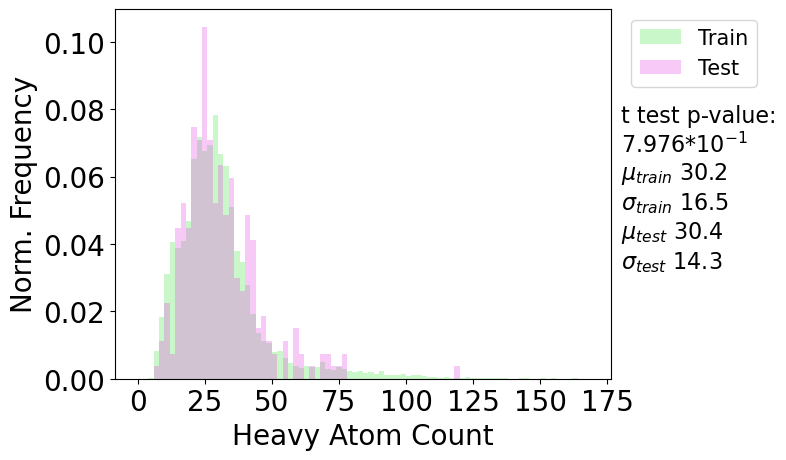

sum
1.0
norm sum
1.0
sum
1.0
norm sum
1.0
TtestResult(statistic=0.8356299417340155, pvalue=0.40337833961638025, df=13117.0)
t test stat 3 formats
raw 0.40337833961638025
.3e 4.034e-01
sci. not. 4.034*$10^{-1}$


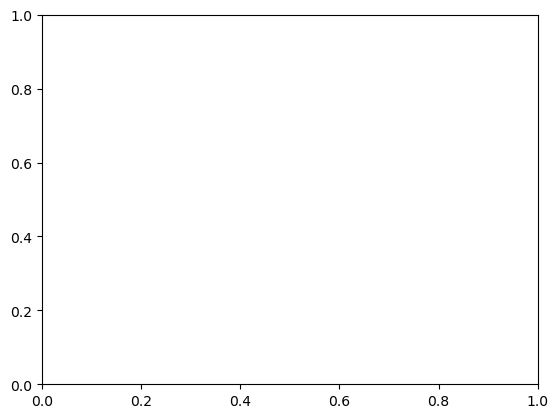

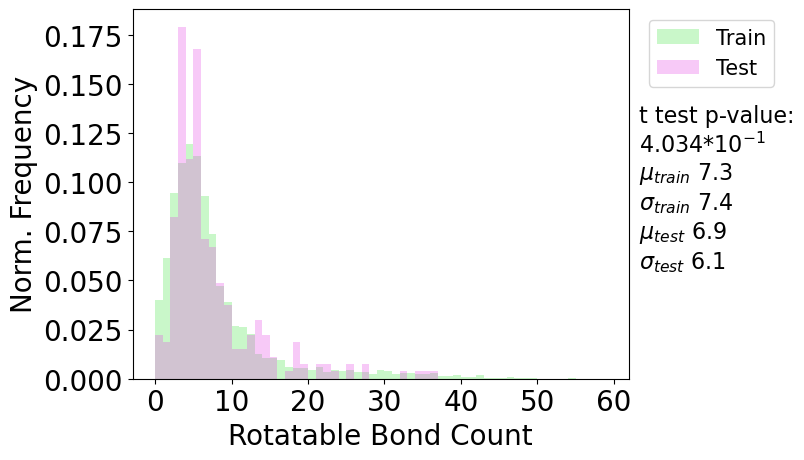

sum
4.999999999999998
norm sum
1.0000000000000004
sum
5.0
norm sum
1.0
TtestResult(statistic=-1.1910242916058227, pvalue=0.23366560033237407, df=13117.0)
t test stat 3 formats
raw 0.23366560033237407
.3e 2.337e-01
sci. not. 2.337*$10^{-1}$


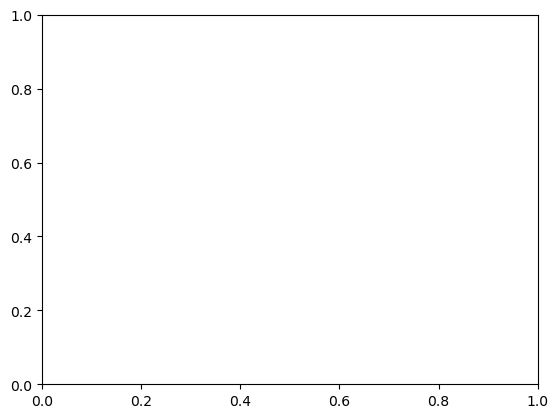

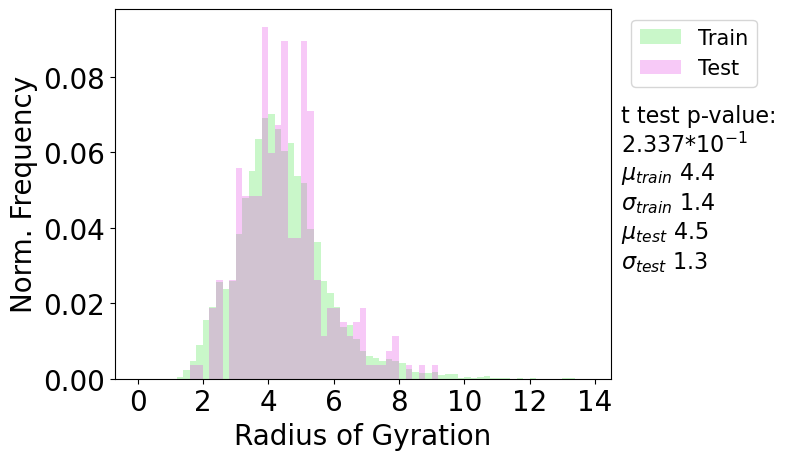

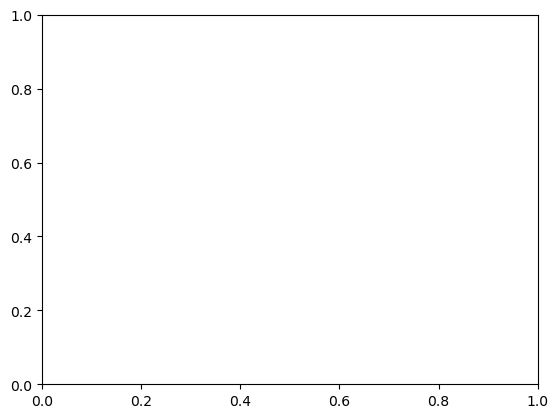

In [40]:
#test/train plot heavy atom count
histogram_train_test(check_df_train["Heavy_Atom_Count"], 
                         check_df_sd_consensus["Heavy_Atom_Count"], 
                         "Heavy_Atom_Count", 
                         170.0, 
                         0.0, 
                         2.0,
                         "Heavy Atom Count",
                         "/Users/dsharon/Documents/MIT/6.8701/Project/Analysis/Output/240205/Test_Train_Plot_2024_02_06_0045",
                         "Heavy_Atom_Count")

histogram_train_test(check_df_train["Rot_Bonds"], 
                         check_df_sd_consensus["Rot_Bonds"], 
                         "Rot_Bonds", 
                         60.0, 
                         0.0, 
                         1.0,
                         "Rotatable Bond Count",
                         "/Users/dsharon/Documents/MIT/6.8701/Project/Analysis/Output/240205/Test_Train_Plot_2024_02_06_0045",
                         "Rot_Bonds")

histogram_train_test(check_df_train["Rg_PDB"], 
                         check_df_sd_consensus["Rg_PDB"], 
                         "Rot_Bonds", 
                         14.0, 
                         0.0, 
                         0.2,
                         "Radius of Gyration",
                         "/Users/dsharon/Documents/MIT/6.8701/Project/Analysis/Output/240205/Test_Train_Plot_2024_02_06_0045",
                         "Rg_PDB")

In [56]:
#########
#Plot the 3 consensus values on 1 axis
#Input:
#(a) check_df_sd_consensus_pl dataframe for plots
#(b) dhist3 directory to save
#########
def plt_consensus_hist(check_df_sd_consensus_pl, dhist3):
    #setup
    bins_consensus = np.arange(0, 350, 5)
    alpha_pl = 0.50
    fhist, ahist = plt.subplots()
    
    #Plot
    plt.hist(check_df_sd_consensus_pl['SD_0.05_Consensus_Distance_Count'], 
             bins = bins_consensus, 
             alpha = alpha_pl, 
             label = "0.05 Å cutoff", 
             color = [0.9, 0.6, 0.3])
    plt.hist(check_df_sd_consensus_pl['SD_0.10_Consensus_Distance_Count'], 
             bins = bins_consensus, 
             alpha = alpha_pl, 
             label = "0.10 Å cutoff", 
             color = [0.3, 0.9, 0.6])
    plt.hist(check_df_sd_consensus_pl['SD_0.15_Consensus_Distance_Count'], 
             bins = bins_consensus, 
             alpha = alpha_pl, 
             label = "0.15 Å cutoff", 
             color = [0.6, 0.3, 0.9])

    #Summary stats
    sd_consensus_str = ""
    for cval in [0.05, 0.10, 0.15]:
        key_str_c = f'SD_{cval:.2f}_Consensus_Distance_Count'
        print(key_str_c)
        sd_consensus_str += f"{cval:.2f} Å "+"$μ$ "+f"{np.average(check_df_sd_consensus_pl[key_str_c]):.1f}"+" $σ$ "+f"{np.std(check_df_sd_consensus_pl[key_str_c],ddof = 1):.1f}\n"

    plt.text(1.02, 0.27, sd_consensus_str, transform = ahist.transAxes, fontsize = 16)

    #Ref https://www.delftstack.com/howto/matplotlib/how-to-place-legend-outside-of-the-plot-in-matplotlib/
    #Ref https://stackoverflow.com/questions/25068384/bbox-to-anchor-and-loc-in-matplotlib
    plt.legend(bbox_to_anchor = (1.02, 1.00), loc = "upper left", fontsize = 15)
    plt.xlabel("Count Consensus Distance", fontsize = 20)
    plt.ylabel("Frequency", fontsize = 20)
    plt.xticks(fontsize = 20)
    plt.yticks(fontsize = 20)

    #Ref https://stackoverflow.com/questions/55942693/how-do-i-save-the-entire-graph-without-it-being-cut-off
    plt.savefig(f"{dhist3}/Hist_3_Consensus.png", bbox_inches = "tight")

    plt.show()  
    plt.close()
    plt.clf()
    plt.cla()

SD_0.05_Consensus_Distance_Count
SD_0.10_Consensus_Distance_Count
SD_0.15_Consensus_Distance_Count


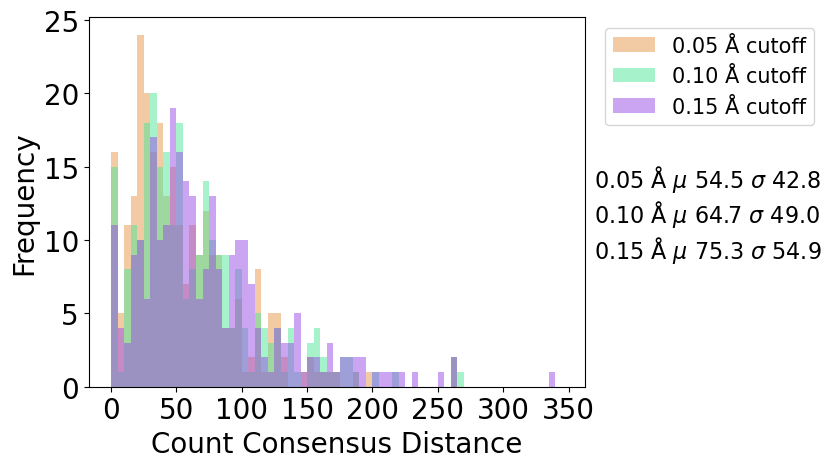

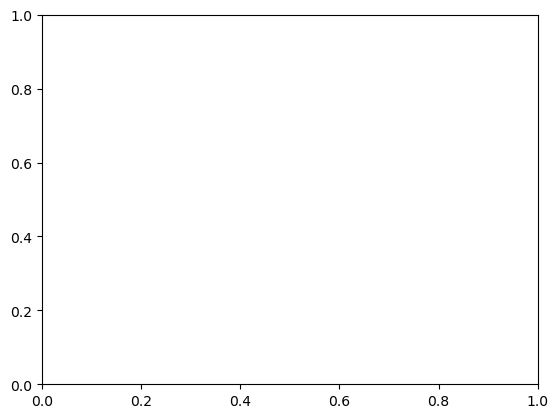

In [58]:
plt_consensus_hist(check_df_sd_consensus, "/Users/dsharon/Documents/MIT/6.8701/Project/Analysis/Output/240205/Test_Train_Plot_2024_02_06_0045")

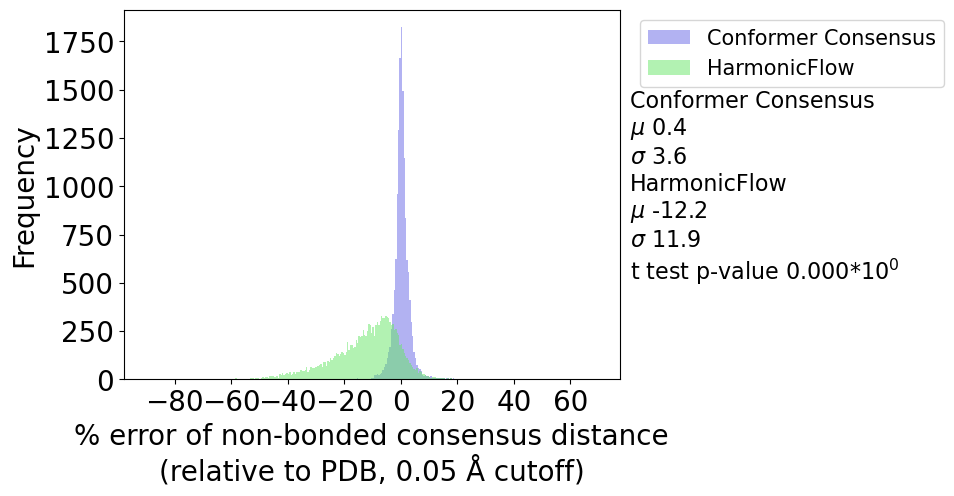

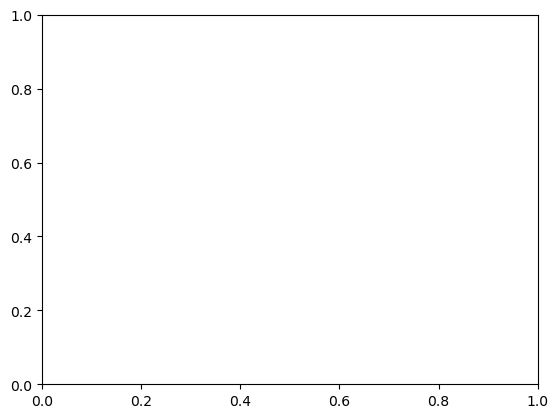

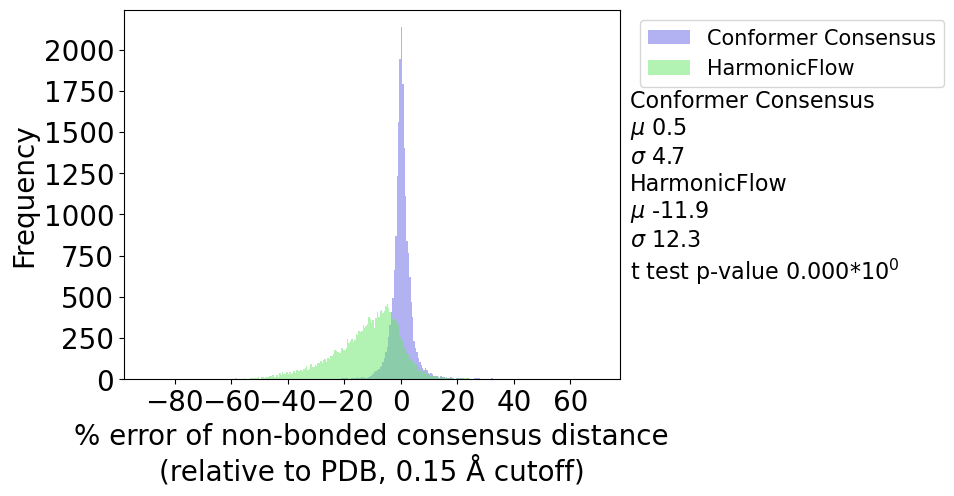

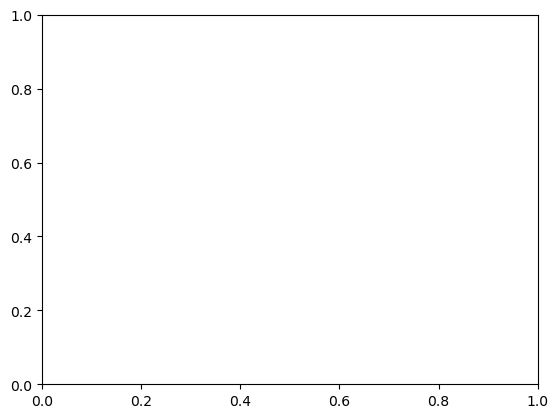

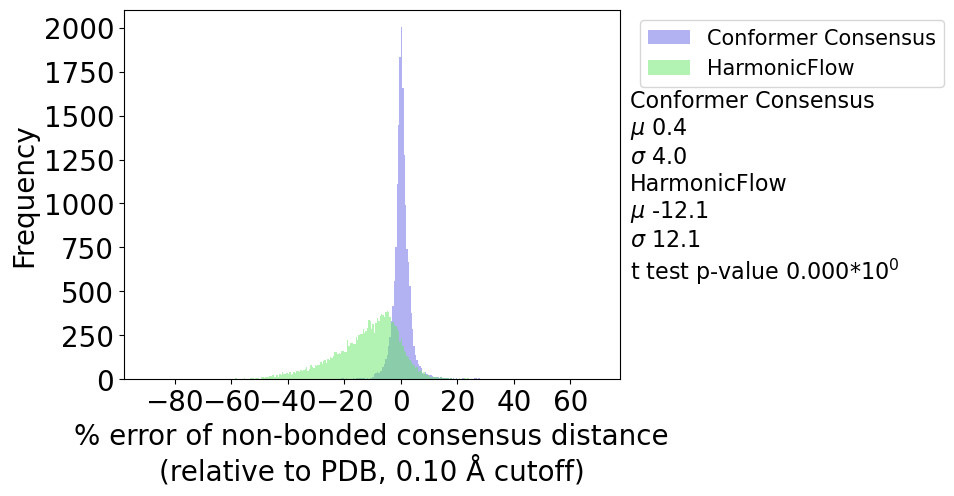

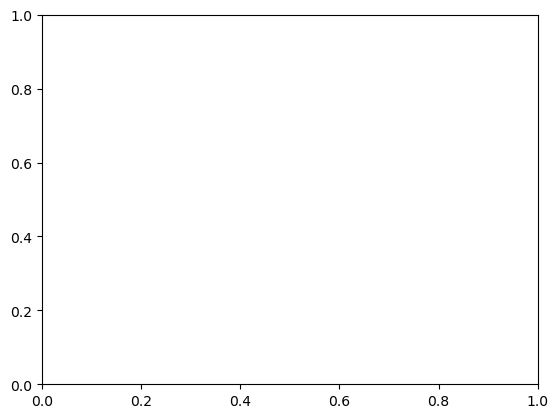

In [61]:
create_histogram_2([list_consolidate(list(check_df_sd_consensus["SD_0.05_Conformer_Consensus_Percent_Error"])), 
                list_consolidate(list(check_df_sd_consensus["SD_0.05_Inference_Consensus_Percent_Error"]))],
               "% error of non-bonded consensus distance\n(relative to PDB, 0.05 Å cutoff)",
               [[0.4, 0.4, 0.9], [0.4, 0.9, 0.4]], 
               {"max" : 70, "min" : -90, "bspace" : 0.5}, 
               ["Conformer Consensus", "HarmonicFlow"], 
               False,
               "/Users/dsharon/Documents/MIT/6.8701/Project/Analysis/Output/240205/Test_Train_Plot_2024_02_06_0045",
               "0.05A_Consensus_Inf_PE")

create_histogram_2([list_consolidate(list(check_df_sd_consensus["SD_0.15_Conformer_Consensus_Percent_Error"])), 
                list_consolidate(list(check_df_sd_consensus["SD_0.15_Inference_Consensus_Percent_Error"]))],
               "% error of non-bonded consensus distance\n(relative to PDB, 0.15 Å cutoff)",
               [[0.4, 0.4, 0.9], [0.4, 0.9, 0.4]], 
               {"max" : 70, "min" : -90, "bspace" : 0.5}, 
               ["Conformer Consensus", "HarmonicFlow"], 
               False,
               "/Users/dsharon/Documents/MIT/6.8701/Project/Analysis/Output/240205/Test_Train_Plot_2024_02_06_0045",
               "0.15A_Consensus_Inf_PE")

create_histogram_2([list_consolidate(list(check_df_sd_consensus["SD_0.10_Conformer_Consensus_Percent_Error"])), 
                list_consolidate(list(check_df_sd_consensus["SD_0.10_Inference_Consensus_Percent_Error"]))],
               "% error of non-bonded consensus distance\n(relative to PDB, 0.10 Å cutoff)",
               [[0.4, 0.4, 0.9], [0.4, 0.9, 0.4]], 
               {"max" : 70, "min" : -90, "bspace" : 0.5}, 
               ["Conformer Consensus", "HarmonicFlow"], 
               False,
               "/Users/dsharon/Documents/MIT/6.8701/Project/Analysis/Output/240205/Test_Train_Plot_2024_02_06_0045",
               "0.10A_Consensus_Inf_PE")

In [42]:
print(f"Heavy_Atom_Count max {max(list(check_df_train['Heavy_Atom_Count']))} {max(list(check_df_sd_consensus['Heavy_Atom_Count']))}")
print(f"Rot_Bonds max {max(list(check_df_train['Rot_Bonds']))} {max(list(check_df_sd_consensus['Rot_Bonds']))}")
print(f"Rg max {max(list(check_df_train['Rg_PDB']))} {max(list(check_df_sd_consensus['Rg_PDB']))}")
print(f"SD consensus {max(list(check_df_sd_consensus['SD_0.15_Consensus_Distance_Count']))}")

Heavy_Atom_Count max 163 119
Rot_Bonds max 54 36
Rg max 13.23501902599816 9.040943220325474
SD consensus 335


In [ ]:
################
#Below this is older, checks

In [ ]:
#6py0 lists and dict match
#6nrf lists and dict match
#6qtr lists and dict match
#print(check_df_sd_consensus[check_df_sd_consensus["Complex_Name"].isin(["6py0", "6nrf", "6qtr"])])
for c_check in ["6py0", "6nrf", "6qtr"]:
    print(c_check)
    print("SD_0.10_Conformer_Consensus_Distance_Count")
    print(list(check_df_sd_consensus[check_df_sd_consensus["Complex_Name"] == c_check]["SD_0.10_Consensus_Distance_Count"]))
    print("SD_0.10_Conformer_Consensus_Percent_Error")
    print(list(check_df_sd_consensus[check_df_sd_consensus["Complex_Name"] == c_check]["SD_0.10_Conformer_Consensus_Percent_Error"]))
    print("SD_0.10_Inference_Consensus_Percent_Error")
    print(list(check_df_sd_consensus[check_df_sd_consensus["Complex_Name"] == c_check]["SD_0.10_Inference_Consensus_Percent_Error"]))
    print("SD_0.10_Consensus_Info_Dict")
    print(dict(check_df_sd_consensus[check_df_sd_consensus["Complex_Name"] == c_check]["SD_0.10_Consensus_Info_Dict"]))
    #print("All_LR_SD")
    #print(list(pd_df[pd_df["Complex_Name"] == c_check]["All_LR_SD"]))

In [ ]:
#Now check counts
#good all incr
#and indeed 6py0 0.10 dict has none below 0.05
#good additions make sense great
for c_check in ["6py0", "6nrf", "6qtr"]:
    print("++++++")
    for cutoff in [0.05, 0.10, 0.15]:
        print("********")
        print(f"cutoff {cutoff}")
        print(c_check)
        print(f"SD_{cutoff}_Conformer_Consensus_Distance_Count")
        print(list(check_df_sd_consensus[check_df_sd_consensus["Complex_Name"] == c_check][f"SD_{cutoff:.2f}_Consensus_Distance_Count"]))
        print(f"SD_{cutoff:.2f}_Consensus_Info_Dict Max SD")
        consensus_d = dict(check_df_sd_consensus[check_df_sd_consensus["Complex_Name"] == c_check][f"SD_{cutoff:.2f}_Consensus_Info_Dict"])
        consensus_d_usable = consensus_d[list(consensus_d.keys())[0]]
        sd_list = [consensus_d_usable[k]["conf_sd"] for k in consensus_d_usable.keys()]
        if len(sd_list) > 0:
            print(f"max SD {max(sd_list)}")
        else:
            print("no entries")
        
        #Check added if 0.15
        if cutoff == 0.15:
            print("how many under 0.10?")
            print(len([s for s in sd_list if s < 0.10]))
            
        #Check added if 0.10
        if cutoff == 0.10:
            print("how many under 0.05?")
            print(len([s for s in sd_list if s < 0.05]))
            
    #Now confirm all in lower sd lists in higher
    i_list_005 = list(check_df_sd_consensus[check_df_sd_consensus["Complex_Name"] == c_check]["SD_0.05_Inference_Consensus_Percent_Error"])
    i_list_010 = list(check_df_sd_consensus[check_df_sd_consensus["Complex_Name"] == c_check]["SD_0.10_Inference_Consensus_Percent_Error"])
    i_list_015 = list(check_df_sd_consensus[check_df_sd_consensus["Complex_Name"] == c_check]["SD_0.15_Inference_Consensus_Percent_Error"])
    print("i, any in 0.10 not 0.15?")
    print([i for i in i_list_010[0] if i not in i_list_015[0]])
    print("i, any in 0.05 not 0.10?")
    print([i for i in i_list_005[0] if i not in i_list_010[0]])
    c_list_005 = list(check_df_sd_consensus[check_df_sd_consensus["Complex_Name"] == c_check]["SD_0.05_Conformer_Consensus_Percent_Error"])
    c_list_010 = list(check_df_sd_consensus[check_df_sd_consensus["Complex_Name"] == c_check]["SD_0.10_Conformer_Consensus_Percent_Error"])
    c_list_015 = list(check_df_sd_consensus[check_df_sd_consensus["Complex_Name"] == c_check]["SD_0.15_Conformer_Consensus_Percent_Error"])
    print("c, any in 0.10 not 0.15?")
    print([c for c in c_list_010[0] if c not in c_list_015[0]])
    print("c, any in 0.05 not 0.10?")
    print([c for c in c_list_005[0] if c not in c_list_010[0]])    
    
    

In [ ]:
print(check_df)
#4kz8 13 heavy atoms 2 rot bonds 2416 rg good
#5ml5 35 heavy atoms 9 rot bonds is ok if let amide N-aryl rotate, good

In [ ]:
#2/5/24 try for a couple ligands
#This has processed PDBbind data
pdb_dir_check = "/Users/dsharon/Documents/MIT/6.8701/Project/Code/HarmonicFlow/FlowSite/data/PDBBind_processed/"

#I had parsed the _xt.pdb output and placed the 20th set of coordinates for each in a directory
hf_out_dir_check = "/Users/dsharon/Documents/MIT/6.8701/Project/Data/From_Hannes/HarmonicFlow/inference_output_last_xt"

#csv for comparison
#hfcsv = pd.read_csv("/Users/dsharon/Documents/MIT/6.8701/Project/Data/From_Hannes/HarmonicFlow/pred_0.csv")

#Output directory
dir_output_run = "/Users/dsharon/Documents/MIT/6.8701/Project/Analysis/Output/240131/240205_1624"
check_df = run_analysis(pdb_dir_check, 
                        hf_out_dir_check, 
                        dir_output_run,
                        ["6py0", "6nrf", "6iby"])

In [ ]:
print(f"Rg for hist max {max(list_rg_pct_error)} min {min(list_rg_pct_error)}")

In [ ]:
#Check train test histogram
#good, sum to 1 in both cases, and distribution is as expect- train uniform, test 3 in 1 bin 1 in other
#stats avg 0.9, sd 05. agrees. and test avg agrees too
#and t test stats match also good
histogram_train_test([1.05, 0.25, 0.75, 1.55], 
                         [0.8, 0.9, 0.95, 1.05], 
                         "testmetric", 
                         2.5, 
                         0.0, 
                         0.50,
                         "testing",
                         "/Users/dsharon/Documents/MIT/6.8701/Project/Analysis/Output/240205/Tests/1700",
                         "sample_data1")

#Now remove 1 entry good bin goes away
#And stats agree tooo
histogram_train_test([1.05, 0.25, 1.55], 
                         [0.8, 0.9, 0.95, 1.05], 
                         "testmetric", 
                         2.5, 
                         0.0, 
                         0.50,
                         "testing",
                         "/Users/dsharon/Documents/MIT/6.8701/Project/Analysis/Output/240205/Tests/1700",
                         "sample_data2")

print(scipy.stats.ttest_ind([1.05, 0.25, 0.75, 1.55], [0.8, 0.9, 0.95, 1.05]))
print(scipy.stats.ttest_ind([1.05, 0.25, 1.55], [0.8, 0.9, 0.95, 1.05]))

In [ ]:
#Create plots- not removing anything
#Check lists match printed df, good
#2/4/24 confirm all plots up to bd % error match stats, good
#this is comparing with Streamline_Analysis_240201_2050
plot_data(pd_df, [])

In [ ]:
pd_df["Consensus_Distance_Count"].sum()

In [ ]:
print(pd_df[pd_df["Complex_Name"].isin(["6py0", "6nrf", "6qtr", "5zjz"])])
for c_check in ["6py0", "6nrf", "6qtr", "5zjz"]:
    print(c_check)
    print("Conformer_Consensus_Percent_Error")
    print(list(pd_df[pd_df["Complex_Name"] == c_check]["Conformer_Consensus_Percent_Error"]))
    print("Inference_Consensus_Percent_Error")
    print(list(pd_df[pd_df["Complex_Name"] == c_check]["Inference_Consensus_Percent_Error"]))
    print("Consensus_Info_Dict")
    print(dict(pd_df[pd_df["Complex_Name"] == c_check]["Consensus_Info_Dict"]))
    #print("All_LR_SD")
    #print(list(pd_df[pd_df["Complex_Name"] == c_check]["All_LR_SD"]))

In [ ]:
#consensus distance counts- compare with Gen_Conformer_Test_240201_2130
#6py0 has 4, 6nrf has 77, 6qtr has 42, 5zjz has 64 good

#consensus pct errors and inf
#6py0 match  good
#consensus distance pe list- relative to conformers
#[3.51940603026987, 2.8253217493780265, 7.927803111924723, 14.412831402255808]
#consensus distance pe list- relative to inference
#[-2.2602189409821625, -14.382359350074113, 5.060666668057455, 11.875740515355558]

#6nrf match good
#consensus distance pe list- relative to conformers
#[1.9010143855905843, 0.14300409240068349, 0.2495840993683197, -2.751217623018728, -1.7272383796153055, -1.0259911192770443, -0.23148755995362102, -2.7365861171643426, -3.428217525975963, -1.5611083838767883, -0.5144526911693704, 0.4224709714630746, 0.6147357184584455, 0.9316520735418887, 0.11800518266656256, 0.8418546578453824, 2.004391948249912, 1.662490561792671, 2.2742185554446346, -1.4838090217029642, -0.8427479017224279, -0.3947755322809376, -0.14563482818799212, 0.15719379328456187, 0.40550145341271837, 3.403685506587259, -0.6535405785269923, -0.38092543764994385, -0.3671534131019658, -0.16045759768352813, -0.22410056283736163, -0.6183483443744985, -0.6536492483598024, -0.4191570860405378, 1.231791997947726, -0.8000570929816256, -1.3676886141776818, -0.6421133216192504, -1.217017999957538, -0.7851876486131874, -1.5999409635216575, -2.3676676108141645, -5.215213317252442, 0.9860097518120617, -1.3147632484835678, -1.3255081133183384, 1.3676782667480183, -0.6904838259680336, -0.8015219552564081, -1.360381638477304, -1.133941225654004, -0.6262384710859953, -0.14420957441335208, -0.759453349141383, 1.1606766236804726, -0.6898359751442152, 0.793750987236015, 0.6177035315749156, 1.25395547630265, 0.6796489647878622, -0.9063739809069861, -0.8546450268382187, -2.1125531049252193, -2.1120662728914295, -1.3486858260899113, 1.2008581332803638, 0.049727561489157364, -0.8195550531077741, -0.44624588778039825, -1.4805028489345622, -0.1895886713201796, 0.8644812805106391, 2.3339986801082517, 1.1502409488760923, 1.055826696778391, -1.0090354957290386, -2.1967626384474244]
#consensus distance pe list- relative to inference
#[-17.58571850784899, -7.9159349105652375, -7.112135690400866, -19.055522779634817, -10.415406483633149, -6.063339668765588, -10.350244921425201, -8.418016698418816, -37.25553418307519, -17.96896279066257, -9.810668846064427, -1.4949404028200668, 3.5888475912017697, 9.732331537100372, -6.16189114176679, -9.182527956086929, -15.573699937103628, -6.411193080834761, -6.194326961149237, -1.0350208227057374, -4.413901830226865, -2.9513623002313154, -2.933551792879997, -3.4788974679128932, -1.907634810406706, -3.810647861596459, -16.34835296041301, -15.207286015922914, -10.45514885295109, -13.483714557932052, -9.240740909810722, -11.540456197745224, -11.600106146480975, -9.917482116405154, -10.966896009893846, -17.537554744451754, -11.655783906280497, -8.274636773202852, -11.949244540520572, -9.441060929526158, -34.61771240256642, -38.723325101344045, -44.33264674804663, -27.320196650167112, -38.9612350986166, -23.052542245837746, -2.935013342372967, -27.629429935492272, -19.053219751272852, -22.78686110313254, -27.120974560495917, -17.177693956130376, -8.73729011305666, -14.016342991625622, -29.315986025392537, -9.251676876461033, -3.3937832717112886, 1.0790167747597894, 3.4077695755393225, 0.7008983000428046, -6.098823626410947, -16.914220451287115, -8.324556033044889, -8.901007125775608, -11.478419023308762, -20.658051971499816, -7.917233752003187, -32.73664754193038, -31.448259912446893, -10.085852621346891, -5.712494294697797, -4.8617424935535825, -6.253685916961075, -10.133622988506344, -28.37260704245759, -11.345578328371792, -2.512141088195539]

#6qtr match good
#consensus distance pe list- relative to conformers
#[2.1004344379828606, 3.810949323659038, 0.4737233610857225, 1.9742099066170897, 1.2910458804872011, 3.960144024160654, 27.895342939019518, -19.378967891417552, 1.3404924163760323, 2.886584256768848, 26.595727124418673, -20.92689793935693, 7.173370731890907, 1.5260968857071349, 0.07800626948980784, 1.379617178024961, 2.69242403325498, 1.217979901220705, 1.1558495429669997, 0.8232114700980189, 0.6420777836166481, 0.8653978298824837, 0.7246240744339947, 0.7737083636006823, 0.8912805213683493, 0.9298610142535715, 0.40279800259803245, 1.7860350456277267, 1.0423585187539472, 1.2565342188223365, 0.45758300561535714, 0.20138746692846865, 0.31695172146331846, 0.3177765975739739, 0.2112082800364197, -0.028567907819224334, 0.3134055386708859, -0.046097656890445975, 1.072143454326248, 0.0636909949923208, 0.9627399268669264, 0.27581103234730825]
#consensus distance pe list- relative to inference
#[-7.275826116748243, -5.703092570145563, -3.5326548498013333, -24.128600768414046, -10.473941728306505, -29.563979922331793, -13.525324600069883, -50.794064400344624, -14.405363734593257, -20.739174659926526, -35.84190201229298, -37.8153298971022, -13.645271397213866, -8.138948426487639, -25.248407359206105, -19.837665800886388, -33.947103790650715, -32.32465803015197, -23.067521627416625, -31.084142758517284, -37.19585435290956, -26.495150545297935, -29.633746059834493, -33.340624852342785, -34.35314909706843, -53.186183550720976, -26.22051460678698, -31.439553816429704, -19.650032407686584, -24.014742756664933, -27.9581667187905, -28.286898610110853, -32.55467125356307, -27.614187901721678, -25.08523420562228, -26.992410175153296, -19.76629354183534, -23.978662195141034, -34.988060162063704, -25.251277935731828, -41.749814596026134, -29.173969170717502]

#5zjz match good
#how many consensus distances? 64
#consensus distance pe list- relative to conformers
#[-21.013862476685286, 26.898703157178957, -0.04196484384262405, 3.6739363580730036, 0.8838838736838724, 0.41970222500373, 1.5081409622646953, 0.4958238424522645, 0.8287738582966451, -0.027990928702799726, 0.5257416302786297, 0.10874022719858742, 1.7988086036316357, 0.14339346338192416, 0.4402425494465754, 0.1420961415266551, -0.23926360055628929, 0.021806160327594293, -0.4475967227656975, 0.702541518362029, -0.45665569179843046, 0.48519587907462397, -0.09933377082757018, 1.0956006703115766, -0.060469469213072106, 0.7651944873189229, 0.9605582700196181, -20.650277990689204, 28.52795103128406, -6.963208821871123, 8.908776913572291, 3.3967473760889226, 2.173526942653649, 6.208335155907042, -1.0013740986619688, 0.22735959657943763, -1.2727966223902198, -0.5469635769565556, 0.21901930098352926, -0.09200555083733139, 0.12270387293471423, 0.6700120506339922, 0.4767081880972493, 1.8086125186363056, -6.377373250224554, -0.6131888538726897, -0.5164411719339161, 0.45981886421287743, -0.342126325427873, 0.4618101623420516, 0.07684244395428151, -0.349614496289518, 0.4376993280653283, 0.20236935010771087, 0.7947410149526298, 0.2531432318509162, 0.9030712644211024, 0.8421077431084136, 0.2839165247831089, -0.19557107166204601, 0.27418543712950544, 0.6143258355478719, 0.15440446632644192, -0.7293196909775355]
#consensus distance pe list- relative to inference
#[-36.33602380789821, -12.82754744444976, -15.325166923909576, -35.90675603774521, 0.16549932214408702, -13.261045515026332, 33.663009386040954, 13.063545314025797, -33.28314363629198, -41.26136235192126, -27.4651864552136, -31.967940201573523, -9.929342093854906, -38.26211590795465, -38.35312957159185, -36.55036857090542, -39.415558170707584, -24.86123178810595, -31.85389003204931, -55.01947069820203, -36.36601576510179, -61.1263785678478, -48.84030297514698, -28.14255308371576, -34.40284218416582, 28.258344213982493, 12.903119560941594, -20.176262327274245, -7.186304781331557, -38.00594501392774, -46.32407891402858, -16.0196358715567, -14.162434399331236, 6.1425172254509235, 0.6195950908999571, -20.79079576324634, -8.502614554608986, -11.367017891689601, -10.714287935139179, -7.2724748563447505, -3.3951940185536102, -46.90515278335021, -44.860854837817364, -13.462661776670211, -12.97573055197857, -14.809810937058442, -2.962175135204015, 4.8026749929727695, -6.655449249368707, -7.555082837714914, -8.50492437073128, -11.886500416781132, -24.568228029088633, -18.537177894542697, -50.76948813821276, -23.56667578906096, -43.22271469441802, -33.48842507326569, -26.876163447727187, -59.2377175521242, -51.925295567779074, -42.245355186045806, -47.307058825269365, -42.42364615884291]

#compare consensus dictionaries- 1st couple entries
#6py0 match good
#{(0, 3): {'pdb': 2.8828966335961472, 'conformers': 2.984357471565377, 'pdb_conf_pe': 3.51940603026987, 'inf': 2.81773685783467, 'pdb_inf_pe': -2.2602189409821625}, (2, 5): {'pdb': 2.8475861707769257, 'conformers': 2.928039642192167, 'pdb_conf_pe': 2.8253217493780265, 'inf': 2.438036094892773, 'pdb_inf_pe': -14.382359350074113}, (6, 9): {'pdb': 3.3917300894970985, 'conformers': 3.6606197730803367, 'pdb_conf_pe': 7.927803111924723, 'inf': 3.5633742436067535, 'pdb_inf_pe': 5.060666668057455}, (8, 11): {'pdb': 3.215300608030297, 'conformers': 3.6787164637414094, 'pdb_conf_pe': 14.412831402255808, 'inf': 3.5971413650286244, 'pdb_inf_pe': 11.875740515355558}}

#6nrf match good
#6nrf consensus distances dictionary
#{(0, 4): {'pdb': 2.8549497368605277, 'conformers': 2.909222742059627, 'pdb_conf_pe': 1.9010143855905843, 'inf': 2.35288631259566, 'pdb_inf_pe': -17.58571850784899}, (0, 5): {'pdb': 6.532755850328405, 'conformers': 6.54209795854092, 'pdb_conf_pe': 0.14300409240068349, 'inf': 6.015627149350266, 'pdb_inf_pe': -7.9159349105652375}
#(24, 27): {'pdb': 2.779696026546788, 'conformers': 2.751647906965561, 'pdb_conf_pe': -1.0090354957290386, 'inf': 2.4643234365642837, 'pdb_inf_pe': -11.345578328371792}, (32, 34): {'pdb': 3.0819339707398017, 'conformers': 3.0142311967289706, 'pdb_conf_pe': -2.1967626384474244, 'inf': 3.004511441149791, 'pdb_inf_pe': -2.512141088195539}}
 

#6qtr match good
#6qtr consensus distances dictionary
#{(1, 10): {'pdb': 3.7865072296246858, 'conformers': 3.8660403314724334, 'pdb_conf_pe': 2.1004344379828606, 'inf': 3.5110075476990925, 'pdb_inf_pe': -7.275826116748243}, (3, 10): {'pdb': 2.7540588229012126, 'conformers': 2.8590146089857384, 'pdb_conf_pe': 3.810949323659038, 'inf': 2.5969922987948952, 'pdb_inf_pe': -5.703092570145563}
#(88, 89): {'pdb': 2.7638959821237816, 'conformers': 2.790505112280758, 'pdb_conf_pe': 0.9627399268669264, 'inf': 1.609974533960087, 'pdb_inf_pe': -41.749814596026134}, (88, 92): {'pdb': 3.640366053022686, 'conformers': 3.650406584214749, 'pdb_conf_pe': 0.27581103234730825, 'inf': 2.578326783012582, 'pdb_inf_pe': -29.173969170717502}}

#5zjz match good
#{(1, 4): {'pdb': 3.577998602570995, 'conformers': 2.8261228968090046, 'pdb_conf_pe': -21.013862476685286, 'inf': 2.277896178494533, 'pdb_inf_pe': -36.33602380789821}, (2, 4): {'pdb': 2.996462414247838, 'conformers': 3.802471944272802, 'pdb_conf_pe': 26.898703157178957, 'inf': 2.612089776405092, 'pdb_inf_pe': -12.82754744444976},
#end (124, 127): {'pdb': 2.7621185709523766, 'conformers': 2.766383405391159, 'pdb_conf_pe': 0.15440446632644192, 'inf': 1.4554415137682462, 'pdb_inf_pe': -47.307058825269365}, (125, 126): {'pdb': 2.84674586150573, 'conformers': 2.825983983385681, 'pdb_conf_pe': -0.7293196909775355, 'inf': 1.6390524701790352, 'pdb_inf_pe': -42.42364615884291}}

#LR SD lists
#6py0
#all pair sd list match
#[0.07199367117749465, 0.17702076411884635....1.0487080521766985, 0.6879352118856541]
#6nrf
#all pair sd list match
#[0.12080109229704707, 0.5930793281189362,...0.39101373616056967, 0.3854277672672214]
#6qtr
#all pair sd list match
#[0.41011121984938037, 0.3353980543288988,...1.1247230645916113, 1.2177365593458067]
#5zjz
#all pair sd list match
#[0.282095228994756, 0.4529594208251584,...1.1514442363404487, 1.125102147315403]

In [ ]:
#Create plots- with removal
#points align with removal, last entries match up- good
remove_list = ['6qsz', '6a6k', '6kqi', '6m7h', '6qtm', '6e4v', '6iql', '6rz6', '6nv9', '6qzh', '5ab1', '4jdf', '1qon', '4pox', '2r23', '4po7', '4nw2', '2w73', '4x6h', '1g6g', '4u6x', '2r23', '4po7', '4nw2', '2w73', '4x6h', '1g6g', '4u6x']
plot_data(pd_df, remove_list)

In [ ]:
#This is from 2/5 check consensus plots for rg abs val
#see x flip, plus got correct spearman
#Create a sample dataframe to check plotting
#look good, just a bit funny about spearman r pvalue, try in cell below
#Bond_Distance_Percent_Error_List 14 entries good, 6 below 0 good, peaks at -5 and 10 good
#And summary stats match: list consolidation was successful, also confirm with exclusion
#2 y. scatter- RMSD series has (1,1), (5,2), (-4, 3), (2, 4), (-3, 5), (0, 6), and (-1,7) -good
#And Rg pe series has (1,3), (5,2), (-4,1), (2,0), (-3,-1), (0, -2), (-1, -3)
#spearman R matches
#Also with exclusions
#rmsd series (2, 4), (-3, 5), (0, 6), and (-1,7) and rg series (2,0), (-3,-1), (0, -2), (-1, -3)
#consensus avg good, bin pattern of 2 then 1 then 2 then 1 is good
#LR SD 3 in 1st bin then 1 a bit over 2, 1 under 3, then 2 over 3 1 each in next 2 bins and 2 over 4 good
#and sd and avg match good
#conformer consensus see 2 just below 0 2 each just above 0 and right larger 1 bit below, 1 each above/below 2 and near 7, 1 at 10 1 at. -15
#HF see 2 at -5/-4/-3, also -20 and -30 and -17 and -23.4 plus 7 and 12
#consensus avg and sd match, so do hf
#exclusions a b look good, stats good
test_df_dict = {
                "Complex_Name" : ["a", "b", "c", "d", "e", "f", "g"],
                "RMSD" : [1, 2, 3, 4, 5, 6, 7],
                "Heavy_Atom_Count" : [1, 2, 3, 4, 5, 6, 7],
                "Rot_Bonds" : [2, 2, 2, 2, 2, 2, 1],
                "Rg_Percent_Error" : [3, 2, 1, 0, -1, -2, -3],
                "Bond_Distance_Percent_Error_List" : [[-5, 10], [-1, 20], [-30, -20], [40, 50], [-5, 10], [-5, 10], [5, 15]],
                "Bond_Distance_Percent_Error_Average" : [1, 5, -4, 2, -3, 0, -1],
                "SD_0.10_Consensus_Distance_Count": [2, 3, 11, 21, 22, 34, 101], 
                "SD_0.10_Conformer_Consensus_Percent_Error" : [[-0.5, -0.2], [0.2, 0.6, 0.2, 0.6], [-1.5], [1.55, 6.96], [2.03], [10.03], [-15.02]],
                "SD_0.10_Inference_Consensus_Percent_Error" : [[-5.05, -5.10], [-4.05, -4.10, -3.05, -3.10], [-20.5], [-17.2, -23.4], [7.03], [12.02], [-30.1]],
                "All_LR_SD" : [[0.12, 0.15], [0.13], [4.03, 4.04], [3.02, 3.07], [3.42, 3.39], [2.03], [2.95]]
               }
#Ref https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.html
pd_test_df = pd.DataFrame(data = test_df_dict)
plot_data(pd_test_df, [], "/Users/dsharon/Documents/MIT/6.8701/Project/Analysis/Output/240131/240205_2230_check_rg_abs", "test")
print("++++++++++++++++++++++++++++++++++++\nWITH REMOVALS")
plot_data(pd_test_df, ["a", "b"], "/Users/dsharon/Documents/MIT/6.8701/Project/Analysis/Output/240131/240205_2230_check_rg_abs", "test2")
print("++++++++++++++++++++++++++++++++++++\nWITH 3 REMOVALS")
plot_data(pd_test_df, ["a", "b", "c"], "/Users/dsharon/Documents/MIT/6.8701/Project/Analysis/Output/240131/240205_2230_check_rg_abs", "test3")

In [ ]:
#This is from 2/4 check consensus plots
#Create a sample dataframe to check plotting
#look good, just a bit funny about spearman r pvalue, try in cell below
#Bond_Distance_Percent_Error_List 14 entries good, 6 below 0 good, peaks at -5 and 10 good
#And summary stats match: list consolidation was successful, also confirm with exclusion
#2 y. scatter- RMSD series has (1,1), (5,2), (-4, 3), (2, 4), (-3, 5), (0, 6), and (-1,7) -good
#And Rg pe series has (1,3), (5,2), (-4,1), (2,0), (-3,-1), (0, -2), (-1, -3)
#spearman R matches
#Also with exclusions
#rmsd series (2, 4), (-3, 5), (0, 6), and (-1,7) and rg series (2,0), (-3,-1), (0, -2), (-1, -3)
#consensus avg good, bin pattern of 2 then 1 then 2 then 1 is good
#LR SD 3 in 1st bin then 1 a bit over 2, 1 under 3, then 2 over 3 1 each in next 2 bins and 2 over 4 good
#and sd and avg match good
#conformer consensus see 2 just below 0 2 each just above 0 and right larger 1 bit below, 1 each above/below 2 and near 7, 1 at 10 1 at. -15
#HF see 2 at -5/-4/-3, also -20 and -30 and -17 and -23.4 plus 7 and 12
#consensus avg and sd match, so do hf
#exclusions a b look good, stats good
test_df_dict = {
                "Complex_Name" : ["a", "b", "c", "d", "e", "f", "g"],
                "RMSD" : [1, 2, 3, 4, 5, 6, 7],
                "Heavy_Atom_Count" : [1, 2, 3, 4, 5, 6, 7],
                "Rot_Bonds" : [2, 2, 2, 2, 2, 2, 1],
                "Rg_Percent_Error" : [3, 2, 1, 0, -1, -2, -3],
                "Bond_Distance_Percent_Error_List" : [[-5, 10], [-1, 20], [-30, -20], [40, 50], [-5, 10], [-5, 10], [5, 15]],
                "Bond_Distance_Percent_Error_Average" : [1, 5, -4, 2, -3, 0, -1],
                "Consensus_Distance_Count": [2, 3, 11, 21, 22, 34, 101], 
                "Conformer_Consensus_Percent_Error" : [[-0.5, -0.2], [0.2, 0.6, 0.2, 0.6], [-1.5], [1.55, 6.96], [2.03], [10.03], [-15.02]],
                "Inference_Consensus_Percent_Error" : [[-5.05, -5.10], [-4.05, -4.10, -3.05, -3.10], [-20.5], [-17.2, -23.4], [7.03], [12.02], [-30.1]],
                "All_LR_SD" : [[0.12, 0.15], [0.13], [4.03, 4.04], [3.02, 3.07], [3.42, 3.39], [2.03], [2.95]]
               }
#Ref https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.html
pd_test_df = pd.DataFrame(data = test_df_dict)
plot_data(pd_test_df, [])
print("++++++++++++++++++++++++++++++++++++\nWITH REMOVALS")
plot_data(pd_test_df, ["a", "b"])
print("++++++++++++++++++++++++++++++++++++\nWITH 3 REMOVALS")
plot_data(pd_test_df, ["a", "b", "c"])

In [ ]:
#Below from 2/1
#Create a sample dataframe to check plotting
#look good, just a bit funny about spearman r pvalue, try in cell below
#Bond_Distance_Percent_Error_List 14 entries good, 6 below 0 good, peaks at -5 and 10 good
#And summary stats match: list consolidation was successful, also confirm with exclusion
#2 y. scatter- RMSD series has (1,1), (5,2), (-4, 3), (2, 4), (-3, 5), (0, 6), and (-1,7) -good
#And Rg pe series has (1,3), (5,2), (-4,1), (2,0), (-3,-1), (0, -2), (-1, -3)
#spearman R matches
#Also with exclusions
#rmsd series (2, 4), (-3, 5), (0, 6), and (-1,7) and rg series (2,0), (-3,-1), (0, -2), (-1, -3)
test_df_dict = {
                "Complex_Name" : ["a", "b", "c", "d", "e", "f", "g"],
                "RMSD" : [1, 2, 3, 4, 5, 6, 7],
                "Heavy_Atom_Count" : [1, 2, 3, 4, 5, 6, 7],
                "Rot_Bonds" : [2, 2, 2, 2, 2, 2, 1],
                "Rg_Percent_Error" : [3, 2, 1, 0, -1, -2, -3],
                "Bond_Distance_Percent_Error_List" : [[-5, 10], [-1, 20], [-30, -20], [40, 50], [-5, 10], [-5, 10], [5, 15]],
                "Bond_Distance_Percent_Error_Average" : [1, 5, -4, 2, -3, 0, -1]
               }
#Ref https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.html
pd_test_df = pd.DataFrame(data = test_df_dict)
plot_data(pd_test_df, [])
print("++++++++++++++++++++++++++++++++++++\nWITH REMOVALS")
plot_data(pd_test_df, ["a", "b"])
print("++++++++++++++++++++++++++++++++++++\nWITH 3 REMOVALS")
plot_data(pd_test_df, ["a", "b", "c"])

In [ ]:
print(scipy.stats.spearmanr([1,2,3,4,5,6,7,8], [1,2,3,4,5,6,7,8]))
print(scipy.stats.spearmanr([1,2,3,4,5,6,7], [1,2,3,4,5,6,7]))
print(scipy.stats.spearmanr([1,2,3,4,5,6], [1,2,3,4,5,6]))
print(scipy.stats.spearmanr([1,2,3,4,5], [1,2,3,4,5]))
print(scipy.stats.spearmanr([1,2,3,4], [1,2,3,4]))
print(np.average([-5, 10, -1, 20, -30, -20, 40, 50, -5, 10, -5, 10, 5, 15]))
print(np.std([-5, 10, -1, 20, -30, -20, 40, 50, -5, 10, -5, 10, 5, 15], ddof = 1))
print(np.average([40, 50, -5, 10, -5, 10, 5, 15]))
print(np.std([40, 50, -5, 10, -5, 10, 5, 15], ddof = 1))
print(scipy.stats.spearmanr([1, 5, -4, 2, -3, 0, -1], [1, 2, 3, 4, 5, 6, 7]))
print(scipy.stats.spearmanr([1, 5, -4, 2, -3, 0, -1], [3, 2, 1, 0, -1, -2, -3]))
print(scipy.stats.spearmanr([2, -3, 0, -1], [4, 5, 6, 7]))
print(scipy.stats.spearmanr([2, -3, 0, -1], [0, -1, -2, -3]))

In [ ]:
print(pd_df)

#Spot checks:
#(a) Heavy_atom_count 
#(i) 6iby is 36, pymol select noth, not elem H get 36
#(ii) 6mjj is 69, pymol select noth, not elem H get  69
#(iii) 6qfe is 30, pymol select noth, not elem H 30
#(b) Rot_Bonds 
#(i) 6iby exlcuding amide bond 5 makes sense
#(ii) 6qfe 8 looks reasonable
#(iii) 6jbe 1 looks reasonable
#(c) Rg percent error
#(i) 6iby 100.0 * (4.696354 - 5.139271) / 5.139271 = -8.617
#(ii) 6mjj 100.0 * (7.873698 - 8.908885) / 8.908885 = -11.6197
#(iii) 6qfe 100.0 * (4.008217 - 4.579058) / 4.579058 = -12.466
#(d) Rg_PDB
#run pymol cmd
#(i) 6mjj 8.90887 match
#(ii) 6hlb 6.95864 match
#(iii) 6jbe got 2.33903 match
#(e) Rg_Inf
#(i) 6mjj 7.87368 match
#(ii) 6hlb 5.58761 match
#(iii) 6qfe 4.00822 match

#Check a few individual entries
#See. /Users/dsharon/Documents/MIT/6.8701/Project/Analysis/Output/240131/Check_bond_pct_error_240131_1930.pse
#Do label- atom properties- id
#6py0 spot check
#21 bonds looks right
#1 2 distance (1 indexed) is 1.5283 in pdb, 1.3022 in inference pose. PE: 100 * (1.3022 - 1.5283) / 1.5283=-14.79 good
#13 21 distance is 1.4828 in pdb, 0.6984 in inference pose. PE: 100 * (0.6984 - 1.4828) / 1.4828 = -52.90 good
#7 8 distance is 1.312 in pdb, 1.1411 in inference pose. PE: 100 * (1.1411- 1.312) / 1.312 = -13.03 good
#And average check matches, good
#6qre spot check
#18 bonds looks right
#2 3 distance pdb 1.3631 inference pose 1.3045 PE (100 * (1.3045 - 1.3631)) / 1.3631 = -4.299 good
#4 17 distance pdb 1.3970 inference pose 1.2403 PE (100 * (1.2403 - 1.3970)) / 1.3970 = -11.217 good
#11 12 distance pdb 1.4543 inference pose 1.2618 PE (100 * (1.2618 - 1.4543)) / 1.4543 = -13.237 good
#And average check matches, good
#6inz spot check
#27. bonds looks right
#0 1 1.4901 distance pdb inf 1.5349 PE 100 * (1.5349 - 1.4901) / 1.4901 = 3.007 good
#18 26 1.2427 distance pdb inf 0.8112 100 * (0.8112 - 1.2427) / 1.2427 = -34.723 good
#4 5 1.3441 distance pdb inf 1.2203 100 * (1.2203 - 1.3441) / 1.3441 = -9.211 good
#And average check matches, good
#Ref https://saturncloud.io/blog/how-to-get-a-list-from-a-pandas-dataframe-column/
#Ref https://stackoverflow.com/questions/40410416/extract-list-from-pandas-cell-and-use-list-elements-as-new-column
for p_check in ["6py0", "6qre", "6inz"]:
    print("******************")
    print(f"{p_check} bond dist pe list")
    list_p_check = pd_df[pd_df["Complex_Name"] == p_check]["Bond_Distance_Percent_Error_List"].tolist()
    print(list_p_check)
    print("list length")
    print(len(list_p_check[0]))
    print(f"{p_check} bond dist pe dict")
    dict_p_check = pd_df[pd_df["Complex_Name"] == p_check]["Bond_Distance_Percent_Error_Dict"].tolist()
    print(dict_p_check)
    print(dict_p_check[0])
    print("dict length")
    print(len(list(dict_p_check[0].keys())))
    print("average")
    print(pd_df[pd_df["Complex_Name"] == p_check]["Bond_Distance_Percent_Error_Average"])

In [ ]:
#check averages
print("6py0")
print(np.average([-14.793005113237022, -12.378756328033436, -21.304080148799766, -21.300633233747288, 5.092115589868116, -15.00823463506898, -13.249148782407467, -13.071068992152068, -13.070096104059616, 1.1701509516145374, -18.249628862345762, -15.067100754090848, -20.812383447632964, -18.74810177385318, -33.46432810038927, -62.89394852337647, -31.53806193269953, -31.85482032035267, -37.10205980943967, -11.32573653621703, -52.89607682051507]))
print("6qre")
print(np.average([-4.29584755380543, -48.85474909818387, -28.162671689191956, -27.965468074581306, -15.09616406784059, -24.803324550539436, -27.071447157509752, -2.8641083831379115, -13.233709561173198, -19.498277281940684, -10.897159330393917, -34.526347883181685, -33.12381580892355, -49.54993933199187, -1.960128905177158, -33.623490189995515, -32.34420984758027, -11.213051146220055]))
print("6inz")
print(np.average([3.007775068767706, -10.62922214419955, -11.27549268592031, -9.205881629270785, -3.3802801986541007, -16.96548141485752, -20.672615355408862, -13.286545433916222, -6.790318434492094, -49.367002911730275, -36.45856967871213, -14.298440220252472, -8.0534883700856, -8.097946097608244, -10.688158940235033, -0.6066654708201425, -20.243450412792974, -17.6875408466208, -10.829942931965688, -23.130038595388907, -8.447648450914699, -7.390489224798162, -40.613540538174504, -10.1188559447668, -9.626552873586133, -44.37490693595686, -34.72494376557915]))

In [ ]:
#Tests
#Expect for 1st- square root of 2/2, giving 1
#Expect for 2nd- square root of 0.5, giving 0.77
print(rmsd_calc_no_torch(np.array([[0, 1, 0], [0, 1, 0]]), np.array([[0, 0, 0], [0, 0, 0]])))
print(rmsd_calc_no_torch(np.array([[0, 1, 0], [0, 0, 0]]), np.array([[0, 0, 0], [0, 0, 0]])))

In [ ]:
csv_with_h_for_calc = pd.read_csv("/Users/dsharon/Documents/MIT/6.8701/Project/Analysis/RMSD_and_Chem_Feats/Docking_analyze_240123_1745/HF_240123_1745_Driver_Data.csv")

In [ ]:
csv_with_h_for_calc[csv_with_h_for_calc["names"] == "6iby"]
#Rgbit diff, rg pct error bit diff
#Rg + Rg_Inf_Minus_PDB = 5.234467-0.538112=4.696, matches. So the change is due to Hs